# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [36]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


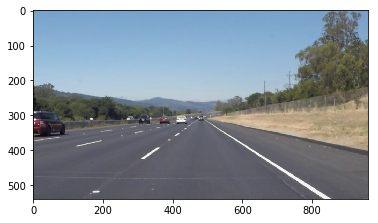

In [37]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [61]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines,flag, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    if flag == 'default':
        for line in lines:
            x1,y1,x2,y2 = line[0]
            cv2.line(img, (x1,y1), (x2,y2), color, thickness)
        return
                
    
    
    ### Lists that will store the x and y values of the line segments lying on left Lane and right lane.
    ### eg: x_left will store the value of x-cordinate lying on left lane,corresponding y-coordinate value 
    ### will be stored in y_left.
    x_left=[]
    x_right=[]
    y_left=[]
    y_right=[]
    
    pos_slopes=[]
    neg_slopes=[]
    for line in lines:
        x1,y1,x2,y2=line[0]
        if x2-x1!=0:
            slp = (y2-y1)/(x2-x1)
            if slp > 0:
                pos_slopes.append(slp)
            elif slp < 0:
                neg_slopes.append(slp)
                
    pos_slopes = np.unique(pos_slopes)
    neg_slopes = np.unique(neg_slopes)
    print(pos_slopes)
    print(np.median(pos_slopes))
    print(neg_slopes)
    print(np.median(neg_slopes))
    pos_th = np.percentile(pos_slopes,50)
    neg_th = abs(np.percentile(neg_slopes,50))
    flag_pos = len(pos_slopes) > 2
    flag_neg = len(neg_slopes) > 2
    
    ### Seperating line segments as belonging to left lane or right lane on the basis of the slope.
    ### Positive sloped line segments to right lane and negative sloped line segments to left lane.
    ### Somewhat steeply rising line segments are considered (based on the absolute value of the slope)
    ### other line segments are discarded (abs(slp) > 0.4)
    for line in lines:
        x1,y1,x2,y2 = line[0]
        if x2-x1 !=0:
            slp = (y2-y1)/(x2-x1)
            
            if (slp < 0) and ~(flag_neg): 
                x_left+=[x1,x2]
                y_left+=[y1,y2]
            elif (slp < 0) and (abs(slp) > min(0.4,neg_th)):
                x_left+=[x1,x2]
                y_left+=[y1,y2]
            elif (slp > 0) and ~(flag_pos):
                x_right+=[x1,x2]
                y_right+=[y1,y2]
            elif (slp > 0) and (slp > min(0.4,pos_th)):
                  x_right+=[x1,x2]
                  y_right+=[y1,y2]
    
    ### Using np.polyfit to fit on the y and x values and determining the parameters for left and right
    ### lanes respectively. Here x is fitted against y --- x = funtion(y)
    left_params = np.polyfit(y_left,x_left,1)
    right_params = np.polyfit(y_right,x_right,1)
    
    ### A linear function for left and right lanes respectively. Pass y values to determine the corresponding
    ### x  values.
    left_lane = np.poly1d(left_params)
    right_lane = np.poly1d(right_params)
    
    ### start and end of the lanes. Start of the lane should be the bottom of the image and a lane should
    ### end at about range of vision
    ### For left lane
    start_L_y = int(img.shape[0])  # y value at bottom of image
    start_L_x = int(left_lane(start_L_y)) # corresponding x-coordinate value
    end_L_y = int(img.shape[0]*0.65) # y-coordinate value below range of vision
    end_L_x = int(left_lane(end_L_y)) # corresponding y-coordinate value
    ### For right lane 
    start_R_y = int(img.shape[0])
    start_R_x = int(right_lane(start_R_y))
    end_R_y = int(img.shape[0]*0.65)
    end_R_x = int(right_lane(end_R_y))
    
    
    lanes = [[start_L_x,start_L_y,end_L_x,end_L_y],[start_R_x,start_R_y,end_R_x,end_R_y]]               
            
    
    for line in lanes:
        x1,y1,x2,y2 = line
        cv2.line(img, (x1,y1), (x2,y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,flag):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines,flag=flag)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [39]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [94]:
ch = mpimg.imread("test_images/whiteCarLaneSwitch.jpg")
gry = grayscale(ch)
blr = gaussian_blur(gry,5)
sobelx = cv2.Sobel(blr,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(blr,cv2.CV_64F,0,1,ksize=3)
grad = abs(sobelx)+abs(sobely)
unique, counts = np.unique(grad.flatten(), return_counts=True)
med = np.median(unique)
print(med)
print(np.max(unique))
print(np.median(unique[unique<med]))

245.0
494.0
122.0


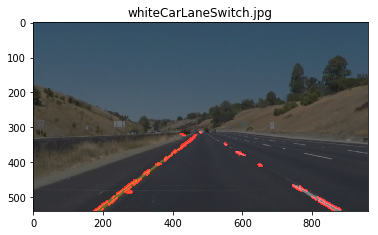

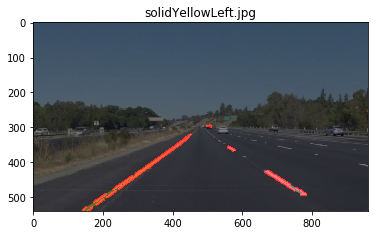

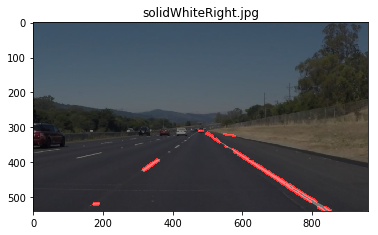

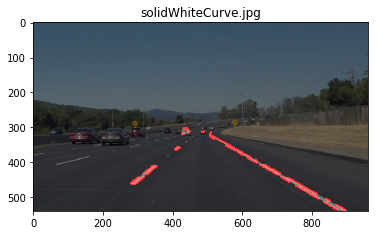

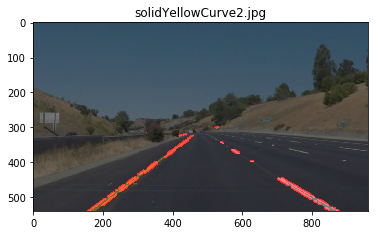

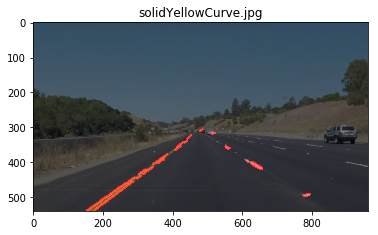

In [58]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def get_threshold(blr_image):
    sobelx = cv2.Sobel(blr_image,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(blr_image,cv2.CV_64F,0,1,ksize=3)
    grad = abs(sobelx)+abs(sobely)
    unique, counts = np.unique(grad.flatten(), return_counts=True)
    high = np.median(unique)
    low = np.median(unique[unique<high])
    return low, high


### Main pipeline function for detecting lanes and drawing lane lines. If flag equals 'default' it will draw line segments 
### Otherwise it will draw complete lines.
### Vertices define the Region of Interest
### test_img is the original image (as numpy array)
### Other are HoughLine parameters
def detect_lanes(test_img,vertices,rho,theta,threshold,min_line_len,max_line_gap,flag):
    gray = grayscale(test_img) # Convert to grayscale
    blur_gray = gaussian_blur(gray,7) # Smooth the image using 3x3 gaussian filter
    low,high = get_threshold(blur_gray)
    edges = canny(blur_gray,low,high) # Detecting edges in the blurred image, low_threshold=100, high_threshold=200
    masked_edges = region_of_interest(edges, vertices) # Consider edges only in region of interest
    # Draw lines using edges using hough transform
    line_image = hough_lines(masked_edges, rho=rho, theta=theta, threshold=threshold, min_line_len=min_line_len, max_line_gap=max_line_gap,flag=flag)
    lines_edges= weighted_img(line_image, test_img, α=0.5, β=1., γ=0) # Combine original image with the line image
    plt.imshow(lines_edges) # Display the image
    return lines_edges # return the combined image

### Iterate over the test images, for each image detect and display the detecte4d line segments
for image in os.listdir("test_images/"):
    plt.figure() # Draw each image in seperate figures
    plt.title(image) # Title of each image --- its filename
    test_img = mpimg.imread("test_images/"+image) # Rading the image
    imshape = test_img.shape # shape of the numpy array
    ## Defining the region of interest as numpy array of vertices
    vertices = np.array([[(0,imshape[0]),(imshape[1]*0.5,imshape[0]*0.5), (imshape[1],imshape[0])]], dtype=np.int32)
    ## Detecting the line segments using the main pipeline function and various tuned HoughLine parameters
    line_edges = detect_lanes(test_img,vertices,rho=5, theta=(np.pi)*3/180, threshold=10, min_line_len=5, max_line_gap=1,flag='default')
    cv2.imwrite("test_images_output/"+image,line_edges) # saving the image


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [41]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [45]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #test_img = mpimg.imread(image)
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(imshape[1]*0.5,imshape[0]*0.5), (imshape[1],imshape[0])]], dtype=np.int32)
    result = detect_lanes(image,vertices,rho=5, theta=(np.pi)*3/180, threshold=10, min_line_len=5, max_line_gap=1,flag='line')
    return result

Let's try the one with the solid white lane on the right first ...

[ 0.07142857  0.16666667  0.33333333  0.4         0.42857143  0.44444444
  0.5         0.55        0.55555556  0.5625      0.57142857  0.58208955
  0.58695652  0.6         0.625       0.63636364  0.64596273  0.66666667
  0.7         0.71428571  0.75        0.76923077  0.77777778  0.8
  0.83333333]
0.586956521739
[-1.         -0.8        -0.78571429 -0.77777778 -0.72916667 -0.72857143
 -0.72727273 -0.71428571 -0.69230769 -0.6875     -0.2       ]
-0.728571428571
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



  0%|          | 0/222 [00:00<?, ?it/s]

[ 0.07142857  0.16666667  0.33333333  0.4         0.42857143  0.44444444
  0.5         0.55        0.55555556  0.5625      0.57142857  0.58208955
  0.58695652  0.6         0.625       0.63636364  0.64596273  0.66666667
  0.7         0.71428571  0.75        0.76923077  0.77777778  0.8
  0.83333333]
0.586956521739
[-1.         -0.8        -0.78571429 -0.77777778 -0.72916667 -0.72857143
 -0.72727273 -0.71428571 -0.69230769 -0.6875     -0.2       ]
-0.728571428571



  1%|          | 2/222 [00:00<00:18, 12.03it/s]

[ 0.1         0.16666667  0.2         0.375       0.4         0.42857143
  0.5         0.53846154  0.54166667  0.55        0.55555556  0.5625
  0.57142857  0.58108108  0.58333333  0.6         0.63793103  0.64285714
  0.6875      0.69230769  0.7         0.71428571  0.75        0.83333333]
0.566964285714
[-1.         -0.90909091 -0.85714286 -0.80952381 -0.80487805 -0.75
 -0.72631579 -0.66666667 -0.4        -0.33333333 -0.125     ]
-0.75
[ 0.125       0.4         0.42857143  0.44444444  0.5         0.54545455
  0.55        0.5625      0.57142857  0.58536585  0.6         0.63461538
  0.63636364  0.66666667  0.7         0.71428571  0.72727273  0.8
  0.83333333]
0.585365853659
[-1.         -0.875      -0.81818182 -0.8        -0.77777778 -0.73913043
 -0.72307692 -0.71428571 -0.66666667 -0.6        -0.16666667]
-0.739130434783



  2%|▏         | 4/222 [00:00<00:17, 12.35it/s]

[ 0.12        0.14285714  0.33333333  0.4         0.42857143  0.44444444
  0.45454545  0.5         0.53333333  0.54545455  0.55        0.55555556
  0.5625      0.57142857  0.58695652  0.6         0.625       0.63333333
  0.66666667  0.6875      0.69230769  0.75        0.77777778  0.8
  0.83333333]
0.5625
[-1.         -0.90909091 -0.9        -0.88888889 -0.81481481 -0.8
 -0.72131148 -0.625      -0.6        -0.4       ]
-0.807407407407



  3%|▎         | 6/222 [00:00<00:17, 12.49it/s]

[ 0.125       0.14285714  0.2         0.33333333  0.4         0.42857143
  0.44444444  0.45454545  0.5         0.52941176  0.53333333  0.55
  0.55555556  0.5625      0.57142857  0.58333333  0.58974359  0.61538462
  0.625       0.64285714  0.65        0.66666667  0.71428571  0.75        0.8
  0.83333333]
0.559027777778
[-0.75       -0.73333333 -0.70833333 -0.69230769 -0.33333333 -0.2       ]
-0.700320512821
[ 0.13333333  0.22222222  0.33333333  0.4         0.42857143  0.44444444
  0.5         0.53846154  0.54166667  0.54545455  0.55555556  0.58536585
  0.58823529  0.6         0.625       0.62857143  0.63414634  0.66666667
  0.77777778  0.8         0.83333333]
0.555555555556
[-2.5        -1.25       -1.         -0.75       -0.66666667 -0.28571429
 -0.16666667]
-0.75


[ 0.1         0.4         0.42857143  0.44444444  0.45454545  0.5
  0.54545455  0.55        0.5625      0.57142857  0.58139535  0.58333333
  0.58823529  0.6         0.625       0.64197531  0.64705882  0.66666667
  0.69230769  0.71428571  0.75        0.8         0.83333333  0.875       1.        ]
0.588235294118
[-0.75       -0.74193548 -0.66666667 -0.6        -0.42857143 -0.33333333]
-0.633333333333



  4%|▎         | 8/222 [00:00<00:17, 12.58it/s]

[ 0.1         0.21052632  0.33333333  0.4         0.42857143  0.44444444
  0.46153846  0.5         0.54545455  0.55        0.57142857  0.59259259
  0.6         0.625       0.63934426  0.64367816  0.66666667  0.7
  0.71428571  0.75        0.77777778  0.8         0.83333333]
0.592592592593
[-0.72972973 -0.72222222 -0.4        -0.2        -0.16666667]
-0.4
[ 0.11111111  0.125       0.33333333  0.4         0.42857143  0.5
  0.53333333  0.54545455  0.55        0.55555556  0.5625      0.57142857
  0.58        0.58333333  0.58974359  0.6         0.625       0.62857143
  0.63636364  0.7         0.71428571  0.75        0.83333333  0.85714286]
0.575714285714
[-1.         -0.85714286 -0.81818182 -0.8125     -0.75       -0.73333333
 -0.7        -0.375      -0.14285714]
-0.75



  5%|▍         | 10/222 [00:00<00:16, 12.76it/s]

[ 0.16666667  0.2         0.33333333  0.4         0.42857143  0.44444444
  0.5         0.53846154  0.54166667  0.55555556  0.57142857  0.58333333
  0.59259259  0.6         0.62790698  0.64444444  0.66666667  0.69230769
  0.7         0.71428571  0.75        0.77777778  0.83333333]
0.583333333333
[-1.25       -1.         -0.88888889 -0.8125     -0.77777778 -0.66666667
 -0.42857143]
-0.8125



  5%|▌         | 12/222 [00:00<00:16, 12.81it/s]

[ 0.08333333  0.15384615  0.33333333  0.4         0.42857143  0.44444444
  0.5         0.5625      0.57142857  0.58181818  0.59375     0.6         0.625
  0.63829787  0.66666667  0.68421053  0.69565217  0.7         0.72727273
  0.75        0.77777778  0.8         0.83333333  0.85714286]
0.6125
[-1.         -0.88888889 -0.8125     -0.8        -0.77777778 -0.71428571
 -0.6875     -0.66666667 -0.58333333 -0.57142857]
-0.746031746032
[ 0.14285714  0.16666667  0.4         0.42857143  0.44444444  0.5         0.55
  0.55555556  0.58461538  0.59090909  0.6         0.64210526  0.64705882
  0.64794007  0.64864865  0.66666667  0.7         0.71428571  0.8       ]
0.590909090909
[-1.         -0.9        -0.875      -0.8        -0.71428571 -0.7        -0.6875
 -0.66666667 -0.5        -0.11111111]
-0.707142857143


[ 0.16666667  0.4         0.42857143  0.44444444  0.5         0.53846154
  0.5625      0.57142857  0.58333333  0.6         0.61111111  0.625
  0.64197531  0.64705882  0.64835165  0.66666667  0.6875      0.69230769
  0.7         0.75        0.77777778  0.8         0.83333333  0.85714286
  1.        ]
0.641975308642
[-1.         -0.9        -0.85714286 -0.83333333 -0.75       -0.73913043
 -0.72839506 -0.72727273 -0.72413793 -0.71929825 -0.71428571 -0.6
 -0.58333333 -0.54545455]
-0.727833894501



  6%|▋         | 14/222 [00:01<00:16, 12.80it/s]

[ 0.09090909  0.14285714  0.15384615  0.2         0.4         0.42857143
  0.44444444  0.5         0.53846154  0.54545455  0.5625      0.57142857
  0.58333333  0.59375     0.6         0.62857143  0.63636364  0.64285714
  0.65185185  0.66666667  0.7         0.70588235  0.71428571  0.8
  0.83333333  0.85714286  1.        ]
0.59375
[-1.25       -1.         -0.88888889 -0.77777778 -0.75       -0.73417722
 -0.72881356 -0.72727273 -0.72222222 -0.71428571 -0.7        -0.64705882
 -0.625      -0.6        -0.5        -0.33333333]
-0.724747474747
[ 0.11111111  0.125       0.4         0.42857143  0.5         0.55555556
  0.57142857  0.6         0.625       0.63414634  0.63888889  0.65079365
  0.66666667  0.6875      0.7         0.72222222  0.77777778  0.85714286]
0.629573170732
[-0.8        -0.7826087  -0.73076923 -0.72727273 -0.69230769 -0.66666667
 -0.63636364 -0.63157895 -0.625      -0.5        -0.4       ]
-0.666666666667



  7%|▋         | 16/222 [00:01<00:15, 12.93it/s]

[ 0.06666667  0.14285714  0.4         0.42857143  0.44444444  0.5
  0.54545455  0.55555556  0.57142857  0.58333333  0.59259259  0.6         0.625
  0.64285714  0.64556962  0.65346535  0.66666667  0.7         0.70588235
  0.71428571  0.76923077  0.85714286  1.        ]
0.6
[-1.         -0.8        -0.78571429 -0.73684211 -0.72916667 -0.71428571
 -0.68181818 -0.61904762 -0.6       ]
-0.729166666667



  8%|▊         | 18/222 [00:01<00:15, 12.95it/s]

[ 0.15        0.2         0.4         0.42857143  0.5         0.55
  0.57142857  0.6         0.625       0.63157895  0.64130435  0.65656566
  0.66666667  0.68421053  0.6875      0.69230769  0.7         0.71428571
  0.75        0.77777778  0.8         0.83333333  0.85714286  3.        ]
0.661616161616
[-0.75       -0.69230769 -0.66666667 -0.6        -0.2       ]
-0.666666666667
[ 0.14285714  0.16666667  0.4         0.5         0.54545455  0.55555556
  0.5625      0.56521739  0.57142857  0.58064516  0.58333333  0.5862069
  0.58823529  0.6         0.61111111  0.61538462  0.625       0.64285714
  0.65048544  0.66666667  0.7         0.72727273  0.75        0.77777778
  0.8         0.83333333  0.85714286  0.875       1.        ]
0.611111111111
[-0.875      -0.76923077 -0.66666667 -0.63636364 -0.61111111 -0.6
 -0.33333333 -0.11111111 -0.1       ]
-0.611111111111


[ 0.16666667  0.2         0.22222222  0.4         0.42857143  0.5
  0.53846154  0.55555556  0.57142857  0.6         0.61111111  0.64285714
  0.64705882  0.66666667  0.7         0.71428571  0.72727273  0.75
  0.76923077  0.77777778  0.8         0.83333333  0.85714286]
0.642857142857
[-1.         -0.8        -0.72222222 -0.66666667 -0.625      -0.6
 -0.58333333 -0.4       ]
-0.645833333333



  9%|▉         | 20/222 [00:01<00:15, 12.85it/s]

[ 0.08333333  0.4         0.42857143  0.44444444  0.5         0.53333333
  0.53846154  0.54545455  0.55555556  0.5625      0.58823529  0.59375     0.6
  0.61538462  0.64179104  0.6516129   0.65517241  0.7         0.75      ]
0.5625
[-0.83333333 -0.8        -0.77777778 -0.75       -0.6875     -0.55555556
 -0.5        -0.4        -0.28571429]
-0.6875
[ 0.16666667  0.2         0.42857143  0.5         0.58823529  0.59375     0.6
  0.61111111  0.61538462  0.63636364  0.64285714  0.65142857  0.66666667
  0.6875      0.71428571  0.75        0.77777778  0.8         0.83333333
  0.85714286  0.88888889]
0.642857142857
[-1.         -0.875      -0.85714286 -0.83333333 -0.8        -0.75       -0.7
 -0.66666667 -0.625      -0.6        -0.28571429 -0.125     ]
-0.725



 10%|▉         | 22/222 [00:01<00:15, 12.91it/s]

[ 0.1         0.4         0.42857143  0.5         0.57142857  0.57894737
  0.58823529  0.59259259  0.6         0.625       0.63636364  0.64516129
  0.64705882  0.64804469  0.65106383  0.66666667  0.69230769  0.70588235
  0.75        0.77777778  0.8       ]
0.636363636364
[-1.         -0.71153846 -0.66666667 -0.28571429]
-0.689102564103



 11%|█         | 24/222 [00:01<00:15, 12.97it/s]

[ 0.14285714  0.33333333  0.4         0.42857143  0.5         0.55555556
  0.57142857  0.58536585  0.6         0.63157895  0.63768116  0.64516129
  0.66666667  0.6875      0.69230769  0.7         0.70833333  0.71428571
  0.72727273  0.75        0.77777778  0.8         0.83333333  1.        ]
0.655913978495
[-5.         -1.2        -1.         -0.8125     -0.72727273 -0.72222222
 -0.71428571 -0.69230769 -0.63636364 -0.625      -0.16666667 -0.11111111]
-0.718253968254
[ 0.4         0.42857143  0.5         0.57142857  0.58823529  0.59090909
  0.6         0.61111111  0.625       0.63636364  0.64        0.64516129
  0.64705882  0.648       0.64814815  0.66666667  0.7         0.70588235
  0.70967742  0.72727273  0.75        0.76923077  0.83333333  0.85714286]
0.646110056926
[-1.         -0.875      -0.8        -0.78571429 -0.73333333 -0.73170732
 -0.72727273 -0.7037037  -0.66666667 -0.6        -0.57142857]
-0.731707317073


[ 0.11111111  0.16666667  0.33333333  0.4         0.42857143  0.5         0.55
  0.55555556  0.57142857  0.59090909  0.6         0.60869565  0.61111111
  0.63793103  0.64864865  0.65217391  0.66666667  0.70588235  0.71428571
  0.8         0.83333333  1.        ]
0.604347826087
[-1.         -0.875      -0.83333333 -0.8        -0.71428571 -0.66666667
 -0.65789474 -0.625      -0.6        -0.5       ]
-0.690476190476



 12%|█▏        | 26/222 [00:02<00:15, 12.94it/s]

[ 0.15384615  0.2         0.4         0.42857143  0.5         0.55
  0.57142857  0.59090909  0.6         0.625       0.63636364  0.64705882
  0.65142857  0.65217391  0.66666667  0.71428571  0.71875     0.75
  0.77777778  0.8         0.83333333]
0.636363636364
[-1.         -0.85714286 -0.83333333 -0.82352941 -0.8        -0.78947368
 -0.78571429 -0.728      -0.72222222 -0.7        -0.64285714 -0.61111111]
-0.787593984962
[ 0.11764706  0.2         0.4         0.42857143  0.5         0.5625
  0.57894737  0.6         0.61538462  0.625       0.63793103  0.63829787
  0.64285714  0.64516129  0.64583333  0.65044248  0.6875      0.70588235
  0.8         0.83333333  0.85714286  1.        ]
0.638114453412
[-0.90909091 -0.875      -0.8        -0.76923077 -0.72164948 -0.66666667
 -0.6        -0.25      ]
-0.745440126883



 13%|█▎        | 28/222 [00:02<00:14, 12.98it/s]

[ 0.14285714  0.4         0.42857143  0.5         0.55555556  0.5625
  0.57142857  0.58333333  0.6         0.625       0.63636364  0.63934426
  0.65217391  0.65714286  0.66666667  0.68421053  0.6875      0.7
  0.70588235  0.71428571  0.8         0.83333333  1.        ]
0.639344262295
[-1.         -0.83333333 -0.8        -0.78571429 -0.76923077 -0.75
 -0.74074074 -0.73333333 -0.72131148 -0.66666667 -0.63636364 -0.63157895
 -0.16666667]
-0.740740740741



 14%|█▎        | 30/222 [00:02<00:14, 12.87it/s]

[ 0.14285714  0.33333333  0.4         0.42857143  0.5         0.55
  0.55555556  0.57142857  0.59259259  0.6         0.625       0.63934426
  0.64814815  0.66666667  0.6875      0.71428571  0.72        0.72727273
  0.8         0.85714286]
0.6125
[-0.75       -0.72727273 -0.71428571 -0.66666667 -0.2       ]
-0.714285714286
[ 0.16666667  0.4         0.42857143  0.5         0.55        0.55555556
  0.5625      0.57142857  0.58333333  0.58823529  0.6         0.63461538
  0.63636364  0.64646465  0.66666667  0.7         0.71428571  0.77777778
  0.8         0.875     ]
0.594117647059
[-0.71428571 -0.70833333 -0.66666667 -0.6        -0.57142857 -0.5
 -0.33333333 -0.2       ]
-0.585714285714


[ 0.09090909  0.14285714  0.4         0.42857143  0.5         0.52941176
  0.54545455  0.55555556  0.5625      0.57142857  0.5862069   0.58823529
  0.6         0.63636364  0.64754098  0.68421053  0.6875      0.69230769
  0.70588235  0.75        0.81818182  1.        ]
0.587221095335
[-0.8        -0.70967742 -0.7        -0.375      -0.16666667]
-0.7



 14%|█▍        | 32/222 [00:02<00:14, 12.72it/s]

[ 0.16666667  0.2         0.4         0.42857143  0.44444444  0.5
  0.55555556  0.57142857  0.58823529  0.6         0.625       0.63265306
  0.63636364  0.64882943  0.65714286  0.66666667  0.69230769  0.70588235
  0.73333333  0.77777778  0.875     ]
0.625
[-0.85714286 -0.8        -0.75       -0.73529412 -0.73333333 -0.66666667
 -0.63636364 -0.375     ]
-0.73431372549
[ 0.18181818  0.2         0.4         0.42857143  0.5         0.52941176
  0.55        0.55555556  0.57142857  0.6         0.625       0.63461538
  0.64885496  0.66666667  0.6875      0.69230769  0.69565217  0.71428571
  0.75        0.77777778  0.8         0.83333333  0.85714286]
0.634615384615
[-1.         -0.8        -0.78571429 -0.72727273 -0.71428571 -0.66666667
 -0.44444444 -0.4        -0.33333333 -0.16666667 -0.08333333]
-0.666666666667



 15%|█▌        | 34/222 [00:02<00:14, 12.81it/s]

[ 0.14285714  0.21428571  0.4         0.42857143  0.5         0.57142857
  0.58333333  0.58695652  0.6         0.625       0.62962963  0.63636364
  0.64583333  0.64705882  0.64814815  0.64835165  0.66666667  0.69230769
  0.71428571  0.72727273  0.75        0.8         0.85714286  1.        ]
0.641098484848
[-0.8        -0.77777778 -0.75       -0.73333333 -0.72340426 -0.6
 -0.44444444 -0.4        -0.375     ]
-0.723404255319



 16%|█▌        | 36/222 [00:02<00:14, 12.88it/s]

[ 0.13333333  0.2         0.27272727  0.4         0.42857143  0.44444444
  0.5         0.6         0.625       0.63636364  0.63829787  0.64        0.65
  0.65034965  0.65140845  0.6875      0.72        0.75        0.76923077
  0.8         0.83333333]
0.63829787234
[-1.         -0.88888889 -0.85714286 -0.84615385 -0.83333333 -0.71428571
 -0.63636364 -0.28571429 -0.2        -0.14285714]
-0.77380952381
[ 0.14285714  0.16666667  0.42857143  0.5         0.55        0.55555556
  0.58823529  0.61538462  0.625       0.63157895  0.63636364  0.64102564
  0.64285714  0.64705882  0.64876033  0.64935065  0.66666667  0.69230769
  0.7         0.70833333  0.75        0.8         0.83333333]
0.641025641026
[-5.         -2.         -0.83333333 -0.8        -0.78571429 -0.75
 -0.71604938 -0.66666667 -0.65       -0.14285714 -0.11111111]
-0.75


[ 0.0625      0.11111111  0.4         0.44444444  0.5         0.53333333
  0.53846154  0.55555556  0.5625      0.57142857  0.58823529  0.59259259
  0.59459459  0.6         0.61111111  0.61538462  0.62068966  0.63461538
  0.63636364  0.64285714  0.6490566   0.6875      0.69230769  0.71428571
  1.        ]
0.594594594595
[-1.         -0.9        -0.88888889 -0.875      -0.83333333 -0.8125     -0.8
 -0.76470588 -0.71428571 -0.61111111 -0.6        -0.58333333 -0.5        -0.4
 -0.16666667]
-0.764705882353



 17%|█▋        | 38/222 [00:02<00:14, 12.78it/s]

[ 0.125       0.14285714  0.16666667  0.2         0.4         0.5
  0.54545455  0.55555556  0.5625      0.57142857  0.6         0.625
  0.63636364  0.64705882  0.65217391  0.65517241  0.66666667  0.70588235
  0.71428571  0.71875     0.73333333  0.75        0.76923077  0.77777778
  0.8         0.83333333  1.        ]
0.647058823529
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.80952381 -0.75
 -0.73333333 -0.72727273 -0.66666667 -0.65384615 -0.63636364 -0.625
 -0.61538462 -0.6        -0.33333333 -0.25       -0.14285714]
-0.666666666667
[ 0.125       0.14285714  0.16666667  0.25        0.33333333  0.4         0.5
  0.54545455  0.59090909  0.6         0.625       0.63636364  0.64285714
  0.64864865  0.65384615  0.66666667  0.69230769  0.7         0.71428571
  0.75        0.77777778  0.8         0.83333333  0.85714286  1.        ]
0.642857142857
[-1.         -0.875      -0.8125     -0.8        -0.71428571 -0.7
 -0.66666667 -0.625      -0.6        -0.5        -0.4        -0.2        -0


 18%|█▊        | 40/222 [00:03<00:14, 12.79it/s]

[ 0.4         0.5         0.53333333  0.55        0.55555556  0.5625
  0.57142857  0.58333333  0.59090909  0.6         0.61538462  0.625
  0.63636364  0.640625    0.65853659  0.71428571  0.72727273  0.75
  0.76923077  0.8         0.875       1.        ]
0.620192307692
[-0.82352941 -0.8        -0.78571429 -0.77777778 -0.75       -0.73333333
 -0.71794872 -0.69230769 -0.63157895 -0.6        -0.5        -0.4        -0.2       ]
-0.717948717949



 19%|█▉        | 42/222 [00:03<00:13, 12.88it/s]

[ 0.1         0.16666667  0.4         0.42857143  0.5         0.53846154
  0.5625      0.57142857  0.58064516  0.58333333  0.58823529  0.6         0.625
  0.65625     0.66666667  0.69565217  0.7037037   0.72727273  0.75
  0.76923077  0.77777778  0.78571429  0.8         0.83333333]
0.6125
[-0.76470588 -0.72727273 -0.66666667 -0.625      -0.6        -0.57142857
 -0.33333333 -0.2        -0.16666667]
-0.6
[ 0.2         0.27272727  0.4         0.5         0.54545455  0.55
  0.57142857  0.58333333  0.6         0.625       0.64705882  0.64912281
  0.65714286  0.66037736  0.66666667  0.72222222  0.77777778  0.8
  0.83333333  0.85714286  1.        ]
0.647058823529
[-0.76923077 -0.7037037  -0.66666667 -0.6        -0.57142857 -0.42857143
 -0.28571429 -0.16666667]
-0.585714285714


[ 0.11111111  0.33333333  0.4         0.5         0.5625      0.57142857
  0.6         0.60869565  0.625       0.64516129  0.64634146  0.64766839
  0.65178571  0.66037736  0.66666667  0.69230769  0.7         0.70588235
  0.75        0.8       ]
0.645751376869
[-1.         -0.75       -0.69230769 -0.66666667 -0.625      -0.6        -0.4       ]
-0.666666666667



 20%|█▉        | 44/222 [00:03<00:19,  9.22it/s]

[ 0.4         0.5         0.54545455  0.5625      0.6         0.61111111
  0.625       0.63636364  0.63829787  0.64210526  0.65263158  0.65306122
  0.66666667  0.71428571  0.72727273  0.75        0.77777778  0.8
  0.83333333  0.85714286  1.        ]
0.652631578947
[-0.75       -0.74193548 -0.73529412 -0.55555556 -0.5        -0.375
 -0.14285714]
-0.555555555556
[ 0.16666667  0.4         0.42857143  0.44444444  0.5         0.54545455
  0.55        0.57142857  0.58333333  0.59090909  0.59375     0.6         0.64
  0.65116279  0.65151515  0.65517241  0.66666667  0.71428571  0.72222222
  0.83333333  0.85714286  1.        ]
0.596875
[-0.8        -0.75       -0.73333333 -0.7        -0.66666667 -0.4        -0.2
 -0.11111111]
-0.683333333333



 21%|██        | 47/222 [00:03<00:19,  8.89it/s]

[ 0.16666667  0.4         0.42857143  0.5         0.54545455  0.55
  0.55555556  0.57142857  0.57894737  0.58333333  0.6         0.625
  0.63157895  0.63636364  0.64285714  0.66071429  0.66666667  0.70588235
  0.71428571  0.8         0.81818182  0.85714286  1.        ]
0.625
[-1.         -0.875      -0.8125     -0.8        -0.71428571 -0.65
 -0.63636364 -0.5        -0.14285714]
-0.714285714286
[ 0.2         0.27272727  0.4         0.5         0.55        0.55555556
  0.57142857  0.58333333  0.59459459  0.6         0.61111111  0.625
  0.63636364  0.65217391  0.65263158  0.7         0.70588235  0.70833333
  0.71428571  0.75        0.83333333  0.85714286]
0.618055555556
[-1.         -0.9        -0.875      -0.80769231 -0.8        -0.75       -0.7
 -0.6        -0.28571429]
-0.8



 22%|██▏       | 49/222 [00:04<00:19,  8.77it/s]

[ 0.11111111  0.14285714  0.4         0.5         0.54545455  0.5625
  0.57142857  0.6         0.61111111  0.61538462  0.625       0.63157895
  0.63636364  0.64102564  0.64285714  0.65346535  0.66666667  0.70588235
  0.71428571  0.71875     0.73333333  0.75        0.76923077  0.77777778
  0.8         0.83333333  0.85714286  0.875       1.        ]
0.642857142857
[-5.         -1.66666667 -1.         -0.88888889 -0.83333333 -0.8        -0.75
 -0.72727273 -0.71428571 -0.7        -0.68       -0.66666667 -0.6       ]
-0.75
[ 0.16666667  0.2         0.4         0.44444444  0.5         0.54545455
  0.5625      0.57142857  0.59090909  0.6         0.625       0.64179104
  0.65116279  0.6547619   0.66666667  0.71428571  0.77777778  0.8         0.875
  1.        ]
0.6125
[-1.         -0.9        -0.88888889 -0.81818182 -0.79166667 -0.73333333
 -0.71428571 -0.7        -0.69230769 -0.66666667 -0.64285714 -0.6
 -0.57142857 -0.55555556 -0.54545455 -0.4        -0.16666667]
-0.692307692308



 23%|██▎       | 51/222 [00:04<00:19,  8.62it/s]

[ 0.2         0.4         0.44444444  0.5         0.53846154  0.5625
  0.57142857  0.5862069   0.6         0.625       0.64285714  0.65306122
  0.66071429  0.66666667  0.69230769  0.7         0.8         0.85714286
  1.        ]
0.625
[-1.         -0.875      -0.8125     -0.8        -0.77777778 -0.75
 -0.72916667 -0.72222222 -0.7        -0.66666667 -0.625      -0.61538462
 -0.6        -0.4        -0.16666667]
-0.722222222222
[ 0.14285714  0.16666667  0.2         0.25        0.33333333  0.4
  0.42857143  0.5         0.55555556  0.5625      0.57142857  0.58333333
  0.6         0.61111111  0.625       0.64423077  0.65263158  0.65384615
  0.66666667  0.7         0.70588235  0.8         0.85714286]
0.583333333333
[-1.66666667 -1.         -0.83333333 -0.81818182 -0.8        -0.72727273
 -0.71428571 -0.66666667 -0.61538462 -0.57142857 -0.5        -0.16666667]
-0.720779220779



 24%|██▍       | 53/222 [00:04<00:20,  8.40it/s]

[ 0.14285714  0.2         0.25        0.4         0.42857143  0.5         0.55
  0.57142857  0.58333333  0.6         0.625       0.64347826  0.65306122
  0.65625     0.66666667  0.68421053  0.71428571  0.75        0.77777778
  0.83333333  0.85714286  0.875     ]
0.634239130435
[-1.2        -1.         -0.85714286 -0.8125     -0.8        -0.77777778
 -0.75       -0.72340426 -0.7        -0.66666667 -0.64705882 -0.6
 -0.57142857 -0.42857143 -0.2       ]
-0.723404255319
[ 0.11111111  0.16666667  0.4         0.42857143  0.5         0.53846154
  0.55555556  0.5625      0.57142857  0.58333333  0.58823529  0.6         0.625
  0.63636364  0.64864865  0.65517241  0.66666667  0.71428571  0.73333333
  0.75        0.76923077  0.77777778  0.8         0.83333333]
0.6125
[-0.71428571 -0.66666667 -0.625      -0.6        -0.57142857 -0.5        -0.4
 -0.125     ]
-0.585714285714



 25%|██▍       | 55/222 [00:04<00:19,  8.53it/s]

[ 0.11111111  0.14285714  0.4         0.42857143  0.5         0.55
  0.57142857  0.58333333  0.58823529  0.59090909  0.6         0.61538462
  0.63636364  0.64285714  0.64864865  0.65306122  0.66666667  0.7
  0.70588235  0.70833333  0.72727273  0.75        0.76923077  0.83333333
  1.        ]
0.636363636364
[-0.69230769 -0.66666667 -0.64705882 -0.6        -0.57142857 -0.44444444
 -0.2        -0.125     ]
-0.585714285714
[ 0.125       0.2         0.4         0.42857143  0.5         0.55555556
  0.5625      0.57142857  0.59090909  0.6         0.625       0.65217391
  0.66666667  0.71875     0.75        0.77777778  0.85714286  0.875     ]
0.595454545455
[-0.72413793 -0.66666667 -0.65625    -0.2        -0.16666667]
-0.65625



 26%|██▌       | 57/222 [00:05<00:19,  8.51it/s]

[ 0.125       0.23809524  0.4         0.42857143  0.5         0.55555556
  0.5625      0.57142857  0.58333333  0.6         0.625       0.63636364
  0.63888889  0.65131579  0.65217391  0.66666667  0.71428571  0.77777778
  0.83333333  0.875       1.        ]
0.625
[-0.76923077 -0.66666667 -0.64285714 -0.63636364 -0.6       ]
-0.642857142857
[ 0.16666667  0.4         0.42857143  0.5         0.55        0.55555556
  0.57142857  0.59375     0.6         0.625       0.66666667  0.68421053
  0.7         0.70588235  0.70833333  0.77777778  0.8         0.83333333
  1.        ]
0.625
[-1.         -0.83333333 -0.8        -0.75       -0.70588235 -0.7
 -0.69230769 -0.6        -0.58333333 -0.4        -0.2        -0.16666667]
-0.696153846154



 27%|██▋       | 59/222 [00:05<00:19,  8.52it/s]

[ 0.16666667  0.2         0.4         0.42857143  0.5         0.53846154
  0.54545455  0.55555556  0.57142857  0.59090909  0.59259259  0.6         0.625
  0.63636364  0.64285714  0.66666667  0.7         0.71428571  0.71875
  0.77777778  0.8         0.83333333  0.85714286  1.        ]
0.6125
[-1.         -0.8        -0.7        -0.67741935 -0.65       -0.64705882
 -0.58333333]
-0.677419354839
[ 0.16666667  0.4         0.5         0.57142857  0.59090909  0.59259259
  0.6         0.625       0.63636364  0.64285714  0.64485981  0.65413534
  0.66666667  0.7         0.7037037   0.70588235  0.71428571  0.78571429
  0.83333333  0.85714286]
0.643858477971
[-1.         -0.83333333 -0.8        -0.78571429 -0.75       -0.71428571
 -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857 -0.5        -0.2
 -0.14285714]
-0.651515151515



 27%|██▋       | 60/222 [00:05<00:19,  8.30it/s]

[ 0.15384615  0.4         0.42857143  0.5         0.55555556  0.57142857
  0.58333333  0.6         0.625       0.63636364  0.64285714  0.64534884
  0.66037736  0.71428571  0.75        0.77777778  0.78571429  0.8
  0.83333333  0.85714286]
0.63961038961
[-1.         -0.8        -0.7        -0.66666667 -0.64285714 -0.61111111
 -0.6        -0.57142857 -0.5        -0.42857143 -0.4        -0.33333333]
-0.605555555556
[ 0.125       0.2         0.5         0.53846154  0.55555556  0.57142857
  0.58333333  0.58823529  0.59090909  0.6         0.61111111  0.6462585
  0.64705882  0.65185185  0.66666667  0.7         0.71428571  0.71875
  1.66666667]
0.6
[-0.88888889 -0.875      -0.8        -0.75       -0.72727273 -0.72619048
 -0.7        -0.66666667 -0.64864865 -0.6        -0.57142857 -0.28571429
 -0.2        -0.16666667]
-0.683333333333



 28%|██▊       | 63/222 [00:05<00:20,  7.82it/s]

[ 0.125       0.1875      0.2         0.4         0.42857143  0.5         0.5625
  0.57142857  0.59259259  0.59375     0.6         0.61111111  0.61904762
  0.625       0.65517241  0.66666667  0.7         0.71428571  0.71875     0.75
  0.77777778  0.78571429  0.83333333  0.85714286  0.875     ]
0.619047619048
[-0.88888889 -0.875      -0.83333333 -0.8        -0.77777778 -0.75
 -0.73333333 -0.72131148 -0.71875    -0.71428571 -0.66666667 -0.625
 -0.61538462 -0.6        -0.55555556 -0.4        -0.1       ]
-0.71875
[ 0.25        0.4         0.42857143  0.5         0.5625      0.57142857
  0.58333333  0.59259259  0.6         0.61111111  0.625       0.64220183
  0.64705882  0.66666667  0.7         0.71428571  0.72222222  0.8
  0.81818182  0.83333333]
0.618055555556
[-0.875      -0.83333333 -0.78571429 -0.77777778 -0.72058824 -0.68421053
 -0.66666667 -0.65957447 -0.64285714 -0.61538462 -0.6        -0.57142857
 -0.5        -0.14285714]
-0.663120567376



 29%|██▉       | 64/222 [00:06<00:20,  7.82it/s]

[ 0.14285714  0.16666667  0.4         0.5         0.55555556  0.5625
  0.57142857  0.58333333  0.6         0.625       0.63636364  0.64210526
  0.66071429  0.66666667  0.7         0.71428571  0.71875     0.75
  0.77777778  0.8         0.83333333  0.85714286]
0.639234449761
[-1.         -0.83333333 -0.81818182 -0.8        -0.71428571 -0.66666667
 -0.6        -0.5        -0.42857143]
-0.714285714286
[ 0.16666667  0.2         0.4         0.42857143  0.5         0.55
  0.55555556  0.5625      0.59375     0.6         0.625       0.6474359
  0.65263158  0.65625     0.66666667  0.7         0.71428571  0.72222222
  0.75        0.8         0.83333333  0.85714286  1.        ]
0.647435897436
[-1.         -0.71428571 -0.61538462 -0.57142857 -0.54545455 -0.53333333
 -0.5        -0.4        -0.33333333 -0.1       ]
-0.539393939394



 30%|███       | 67/222 [00:06<00:18,  8.35it/s]

[ 0.14285714  0.2         0.4         0.42857143  0.5         0.55555556
  0.5625      0.57142857  0.58333333  0.6         0.625       0.65
  0.65591398  0.66666667  0.77777778  0.8         0.83333333  0.85714286
  0.875       1.        ]
0.6125
[-0.85714286 -0.72       -0.625      -0.57142857 -0.4       ]
-0.625
[ 0.14285714  0.2         0.33333333  0.4         0.5         0.57142857
  0.6         0.61111111  0.625       0.64423077  0.65053763  0.65625
  0.66037736  0.66666667  0.7         0.70588235  0.71428571  0.72222222
  0.73333333  0.77777778  0.8         0.85714286  1.        ]
0.65625
[-0.66666667 -0.64285714 -0.625      -0.6        -0.57894737]
-0.625



 31%|███       | 69/222 [00:06<00:18,  8.22it/s]

[ 0.14285714  0.4         0.42857143  0.5         0.57142857  0.57894737
  0.58333333  0.6         0.61111111  0.625       0.64102564  0.64893617
  0.65625     0.66666667  0.69230769  0.7         0.71428571  0.77777778
  0.8         1.        ]
0.633012820513
[-1.         -0.76923077 -0.66666667 -0.63636364 -0.6        -0.57142857
 -0.53846154 -0.2        -0.125     ]
-0.6
[ 0.14285714  0.5         0.54545455  0.55555556  0.57142857  0.58333333
  0.6         0.61111111  0.625       0.64356436  0.64583333  0.64878049
  0.66666667  0.68421053  0.6875      0.7         0.71428571  0.72222222
  0.73684211  0.8         0.85714286]
0.645833333333
[-1.         -0.88888889 -0.72222222 -0.66666667 -0.63636364 -0.58333333
 -0.2       ]
-0.666666666667



 32%|███▏      | 71/222 [00:06<00:18,  8.21it/s]

[ 0.4         0.5         0.55555556  0.5625      0.57142857  0.58333333
  0.59090909  0.59259259  0.59459459  0.6         0.61538462  0.625
  0.63636364  0.64356436  0.65306122  0.66666667  0.71428571  0.71875     0.75
  0.77777778  0.8         1.        ]
0.620192307692
[-0.85714286 -0.75       -0.73333333 -0.72727273 -0.71428571 -0.69230769
 -0.64814815 -0.6        -0.5        -0.4        -0.2       ]
-0.692307692308
[ 0.14285714  0.4         0.42857143  0.5         0.53846154  0.5625
  0.57142857  0.59375     0.6         0.61111111  0.64285714  0.64968153
  0.65822785  0.66666667  0.70588235  0.71428571  0.72        0.75
  0.78571429  0.8         0.85714286  0.875       1.        ]
0.649681528662
[-1.         -0.875      -0.83333333 -0.81818182 -0.78571429 -0.75
 -0.71428571 -0.66666667 -0.57142857 -0.5        -0.16666667]
-0.75



 33%|███▎      | 73/222 [00:07<00:19,  7.75it/s]

[ 0.4         0.42857143  0.5         0.54545455  0.57142857  0.57692308
  0.58333333  0.59259259  0.6         0.60869565  0.625       0.65217391
  0.65517241  0.7         0.70588235  0.71428571  0.72222222  0.75
  0.76923077  0.77777778  0.8         0.85714286  1.        ]
0.652173913043
[-1.         -0.875      -0.85714286 -0.66666667 -0.6547619  -0.64285714
 -0.6        -0.2        -0.14285714]
-0.654761904762
[ 0.2         0.4         0.5         0.55555556  0.57142857  0.58333333
  0.6         0.61111111  0.625       0.63636364  0.64        0.64285714
  0.64640884  0.65517241  0.66666667  0.71794872  0.72222222  0.75
  0.77777778  0.78571429  0.8         0.81818182  1.        ]
0.642857142857
[-0.83333333 -0.7        -0.69230769 -0.66666667 -0.65789474 -0.65333333
 -0.64       -0.625      -0.6        -0.57894737 -0.57142857 -0.5
 -0.42857143 -0.33333333 -0.16666667 -0.14285714]
-0.6125



 34%|███▍      | 75/222 [00:07<00:19,  7.70it/s]

[ 0.14285714  0.4         0.5         0.55555556  0.57142857  0.58333333
  0.6         0.60869565  0.61111111  0.625       0.63636364  0.64423077
  0.65517241  0.65625     0.7         0.71428571  0.72340426  0.72727273
  0.75        0.76923077  0.8         0.81818182  0.83333333  0.85714286
  1.        ]
0.655172413793
[-1.         -0.8        -0.77777778 -0.75       -0.72       -0.71428571
 -0.70588235 -0.7        -0.69230769 -0.66666667 -0.65517241 -0.65454545
 -0.6        -0.57142857 -0.5        -0.45454545 -0.4        -0.125     ]
-0.679487179487
[ 0.14285714  0.4         0.42857143  0.5         0.55555556  0.5625
  0.57142857  0.58333333  0.6         0.61111111  0.625       0.63636364
  0.65384615  0.65957447  0.66666667  0.69230769  0.7         0.70588235
  0.71428571  0.77777778  0.85714286  1.        ]
0.630681818182
[-1.         -0.81818182 -0.8        -0.71875    -0.66666667 -0.65
 -0.64285714 -0.6        -0.55555556 -0.42857143 -0.4        -0.16666667]
-0.646428571429



 35%|███▍      | 77/222 [00:07<00:18,  7.84it/s]

[ 0.14285714  0.4         0.5         0.55555556  0.57142857  0.6
  0.61538462  0.625       0.64935065  0.65753425  0.6875      0.7         0.71875
  0.75        0.77777778  0.8         0.85714286  0.875       1.          1.25      ]
0.672517123288
[-1.         -0.81818182 -0.8        -0.71428571 -0.64367816 -0.63636364
 -0.6        -0.57894737 -0.2       ]
-0.64367816092
[ 0.4         0.5         0.55555556  0.58333333  0.58823529  0.6
  0.61538462  0.625       0.63157895  0.64965986  0.65517241  0.65789474
  0.66666667  0.71428571  0.83333333  0.875       1.        ]
0.631578947368
[-0.83333333 -0.8        -0.77777778 -0.75       -0.71428571 -0.66666667
 -0.65217391 -0.625      -0.6        -0.5625     -0.54545455 -0.5       ]
-0.659420289855



 36%|███▌      | 79/222 [00:07<00:18,  7.85it/s]

[ 0.13333333  0.4         0.5         0.5625      0.6         0.625
  0.64583333  0.65        0.65853659  0.65909091  0.66666667  0.69230769
  0.7         0.70588235  0.72916667  0.75        0.78571429  0.8
  0.83333333  0.85714286  0.875       1.        ]
0.679487179487
[-0.66666667 -0.64285714 -0.57142857 -0.5        -0.4        -0.375      -0.2
 -0.14285714]
-0.45
[ 0.33333333  0.4         0.5         0.59259259  0.6         0.61538462
  0.625       0.63636364  0.64285714  0.65789474  0.66666667  0.70588235
  0.71428571  0.72093023  0.75        0.76923077  0.77777778  0.78571429
  0.8         0.81818182  0.83333333  0.85714286  0.875       1.        ]
0.710084033613
[-0.85714286 -0.75       -0.71428571 -0.7        -0.66666667 -0.625      -0.6
 -0.4        -0.125     ]
-0.666666666667



 36%|███▋      | 81/222 [00:08<00:17,  7.86it/s]

[ 0.4         0.42857143  0.5         0.54545455  0.5625      0.57142857
  0.58333333  0.6         0.625       0.63636364  0.65        0.65789474
  0.66666667  0.7         0.71428571  0.72        0.72340426  0.72727273
  0.76923077  0.8         0.8125      0.81818182  0.83333333  0.85714286
  0.88888889  1.        ]
0.683333333333
[-0.66666667 -0.65789474 -0.625      -0.57142857 -0.55555556 -0.2
 -0.14285714 -0.125     ]
-0.563492063492
[ 0.4         0.5         0.53846154  0.55555556  0.5625      0.57142857
  0.58333333  0.59090909  0.6         0.61111111  0.625       0.63636364
  0.65        0.65789474  0.66666667  0.71428571  0.72        0.72727273
  0.75        0.8         0.85714286  1.        ]
0.630681818182
[-1.         -0.83333333 -0.77777778 -0.72727273 -0.66666667 -0.63636364
 -0.6        -0.57692308 -0.57142857 -0.28571429 -0.16666667]
-0.636363636364



 37%|███▋      | 83/222 [00:08<00:17,  7.84it/s]

[ 0.2         0.4         0.5         0.55555556  0.5625      0.57142857
  0.57894737  0.58333333  0.58823529  0.6         0.61111111  0.625
  0.64516129  0.66666667  0.76923077  0.8         0.88888889  0.9
  0.90909091  1.        ]
0.605555555556
[-0.85714286 -0.8        -0.73076923 -0.7        -0.64814815 -0.625      -0.6
 -0.57142857 -0.53846154 -0.22222222 -0.14285714]
-0.625
[ 0.4         0.5         0.55555556  0.5625      0.57142857  0.58333333
  0.6         0.61111111  0.61538462  0.625       0.63636364  0.64285714
  0.66666667  0.70833333  0.71428571  0.72        0.72131148  0.77777778
  0.8         0.875       1.        ]
0.636363636364
[-0.8        -0.7        -0.66666667 -0.65151515 -0.625      -0.5        -0.4       ]
-0.651515151515



 38%|███▊      | 85/222 [00:08<00:17,  7.96it/s]

[ 0.2         0.4         0.5         0.55555556  0.5625      0.57142857
  0.58333333  0.58823529  0.6         0.61538462  0.625       0.66666667
  0.72        0.72131148  0.72727273  0.75        0.76923077  0.77777778
  0.8         0.81818182  0.875       1.        ]
0.645833333333
[-0.83333333 -0.75       -0.7        -0.66666667 -0.65151515 -0.63636364
 -0.63265306 -0.61538462 -0.6        -0.55555556 -0.54545455 -0.33333333
 -0.16666667 -0.14285714]
-0.624018838305
[ 0.28571429  0.5         0.55555556  0.57142857  0.58333333  0.6
  0.61538462  0.625       0.63157895  0.63636364  0.6516129   0.66666667
  0.6875      0.72058824  0.72340426  0.8         0.80952381  0.81818182
  1.        ]
0.636363636364
[-0.8        -0.70967742 -0.66666667 -0.64545455 -0.64516129 -0.63636364
 -0.625      -0.61538462 -0.6        -0.58333333 -0.5625     -0.5
 -0.42857143 -0.2        -0.16666667]
-0.615384615385



 39%|███▉      | 87/222 [00:08<00:16,  7.97it/s]

[ 0.14285714  0.4         0.42857143  0.5         0.55555556  0.57142857
  0.58333333  0.6         0.61538462  0.625       0.64285714  0.65254237
  0.65853659  0.66666667  0.71428571  0.73076923  0.8         0.875
  0.88888889  0.9         1.        ]
0.642857142857
[-0.8        -0.77777778 -0.71428571 -0.7        -0.66666667 -0.6557377
 -0.64220183 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4
 -0.36363636 -0.28571429 -0.27272727 -0.2       ]
-0.583333333333
[ 0.4         0.42857143  0.5         0.54545455  0.57142857  0.58333333
  0.6         0.61538462  0.625       0.63636364  0.65354331  0.65454545
  0.66666667  0.6875      0.71698113  0.72222222  0.75        0.81818182
  0.83333333  0.875       1.        ]
0.653543307087
[-1.         -0.83333333 -0.77777778 -0.75       -0.71428571 -0.66666667
 -0.66101695 -0.64485981 -0.61904762 -0.61111111 -0.6        -0.58823529
 -0.53846154 -0.2        -0.14285714]
-0.644859813084



 40%|████      | 89/222 [00:09<00:16,  8.05it/s]

[ 0.14285714  0.4         0.5         0.57142857  0.58333333  0.6         0.625
  0.63636364  0.65217391  0.66666667  0.7         0.7195122   0.72043011
  0.72727273  0.77777778  0.8         0.85714286  0.88888889  1.        ]
0.666666666667
[-0.8        -0.77777778 -0.71428571 -0.7        -0.69230769 -0.65714286
 -0.64473684 -0.6        -0.57142857 -0.55555556 -0.5        -0.42857143
 -0.4       ]
-0.644736842105
[ 0.33333333  0.4         0.5         0.55555556  0.58333333  0.6
  0.61538462  0.625       0.63636364  0.65217391  0.66666667  0.71428571
  0.72307692  0.75        0.76923077  0.8         0.83333333  0.85714286
  0.88888889  1.        ]
0.659420289855
[-0.72727273 -0.71428571 -0.70588235 -0.66666667 -0.65217391 -0.64705882
 -0.625      -0.6        -0.59090909 -0.57142857 -0.55555556 -0.25
 -0.11111111]
-0.625



 41%|████      | 91/222 [00:09<00:16,  8.09it/s]

[ 0.4         0.5         0.55555556  0.5625      0.58333333  0.6
  0.61538462  0.625       0.63636364  0.65384615  0.65789474  0.66666667
  0.70833333  0.77777778  0.8         0.81818182  0.85714286  0.875       1.        ]
0.653846153846
[-0.64285714 -0.6        -0.55555556 -0.16666667]
-0.577777777778
[ 0.4         0.42857143  0.5         0.55555556  0.57142857  0.6
  0.61111111  0.61538462  0.625       0.66666667  0.69230769  0.71428571
  0.72222222  0.72357724  0.75        0.76923077  0.8         0.81818182
  0.83333333  0.85714286  0.875       1.        ]
0.703296703297
[-5.         -1.66666667 -1.         -0.72       -0.66666667 -0.57142857
 -0.55555556 -0.2       ]
-0.693333333333



 42%|████▏     | 93/222 [00:09<00:15,  8.16it/s]

[ 0.14285714  0.16666667  0.5         0.55555556  0.57142857  0.58333333
  0.6         0.625       0.63636364  0.65151515  0.71698113  0.72093023
  0.7265625   0.73913043  0.75        0.78947368  0.8         0.8125
  0.85714286  0.875       1.        ]
0.716981132075
[-1.25       -0.83333333 -0.70833333 -0.66666667 -0.63636364 -0.6        -0.5625
 -0.4        -0.125     ]
-0.636363636364
[ 0.4         0.5         0.55555556  0.57142857  0.58333333  0.6
  0.61538462  0.625       0.65217391  0.65306122  0.66666667  0.70588235
  0.71428571  0.72        0.72881356  0.8         0.8125      0.85714286
  0.875       1.        ]
0.659863945578
[-0.66666667 -0.64444444 -0.64102564 -0.63636364 -0.6        -0.58333333
 -0.33333333 -0.14285714]
-0.618181818182



 43%|████▎     | 95/222 [00:09<00:15,  8.12it/s]

[ 0.4         0.5         0.55555556  0.57142857  0.6         0.61538462
  0.625       0.63636364  0.64516129  0.65254237  0.66666667  0.68181818
  0.71428571  0.72727273  0.77777778  0.78571429  0.8         0.81818182
  0.83333333  0.85714286  1.        ]
0.666666666667
[-1.         -0.85714286 -0.75       -0.71428571 -0.66666667 -0.65217391
 -0.6        -0.58823529 -0.57142857 -0.4        -0.2        -0.16666667
 -0.14285714]
-0.6
[ 0.2         0.4         0.5         0.55555556  0.5625      0.57142857
  0.58333333  0.6         0.61111111  0.61538462  0.625       0.64285714
  0.65217391  0.65420561  0.66666667  0.7         0.71428571  0.77777778
  0.78571429  0.8         0.82352941  0.83333333  0.9         1.        ]
0.64751552795
[-1.         -0.77777778 -0.75       -0.71875    -0.71428571 -0.70588235
 -0.66666667 -0.625      -0.6        -0.57142857 -0.55555556 -0.5
 -0.16666667 -0.14285714]
-0.645833333333



 44%|████▎     | 97/222 [00:10<00:15,  8.18it/s]

[ 0.4         0.5         0.57142857  0.58333333  0.6         0.61111111
  0.61538462  0.625       0.63636364  0.66666667  0.68421053  0.70967742
  0.71428571  0.71794872  0.725       0.76923077  0.8         0.83333333
  0.85714286  1.        ]
0.675438596491
[-0.85714286 -0.69230769 -0.66666667 -0.65454545 -0.64197531 -0.6
 -0.57142857 -0.53333333 -0.5        -0.16666667]
-0.620987654321
[ 0.4         0.55555556  0.57142857  0.58333333  0.6         0.61538462
  0.625       0.63636364  0.65        0.66666667  0.7037037   0.71428571
  0.72486772  0.73684211  0.76923077  0.8         0.83333333  0.85714286
  0.875       1.        ]
0.685185185185
[-1.         -0.83333333 -0.8        -0.72222222 -0.71428571 -0.66666667
 -0.64705882 -0.625      -0.6        -0.58823529 -0.57142857 -0.5       ]
-0.656862745098



 45%|████▍     | 99/222 [00:10<00:14,  8.29it/s]

[ 0.33333333  0.4         0.5         0.57142857  0.6         0.60869565
  0.61538462  0.625       0.63636364  0.64285714  0.66666667  0.67857143
  0.68        0.68421053  0.7         0.71428571  0.72        0.72093023
  0.77777778  0.78571429  0.8         0.80952381  0.8125      0.88888889
  1.        ]
0.68
[-1.         -0.8        -0.75       -0.72727273 -0.71428571 -0.70588235
 -0.69230769 -0.65217391 -0.63829787 -0.61904762 -0.6        -0.58333333
 -0.57142857 -0.54545455 -0.4        -0.2        -0.125     ]
-0.63829787234
[ 0.4         0.5         0.57142857  0.58333333  0.6         0.625
  0.70588235  0.71428571  0.71875     0.72        0.72222222  0.72440945
  0.73913043  0.75        0.78571429  0.8125      0.85714286  0.875
  0.88888889  0.9         1.        ]
0.722222222222
[-1.         -0.88888889 -0.8        -0.71875    -0.70588235 -0.66666667
 -0.64705882 -0.64615385 -0.6        -0.58333333 -0.57894737 -0.54545455
 -0.5        -0.2       ]
-0.646606334842



 45%|████▌     | 101/222 [00:10<00:15,  7.89it/s]

[ 0.11111111  0.4         0.5         0.6         0.625       0.65789474
  0.69230769  0.71428571  0.71794872  0.72580645  0.72727273  0.73333333
  0.75        0.77777778  0.78571429  0.8         0.80952381  0.81818182
  0.83333333  0.85714286  0.875       1.        ]
0.730303030303
[-0.83333333 -0.8        -0.71428571 -0.66666667 -0.64285714 -0.63636364
 -0.63157895 -0.6        -0.57142857 -0.56521739 -0.5        -0.42857143
 -0.4        -0.33333333 -0.2        -0.125     ]
-0.585714285714
[ 0.4         0.42857143  0.5         0.57142857  0.625       0.65909091
  0.66666667  0.7         0.72151899  0.72535211  0.72727273  0.77777778
  0.78571429  0.8         0.81818182  0.83333333  0.85714286  1.        ]
0.723435550009
[-1.         -0.85714286 -0.70588235 -0.68421053 -0.66666667 -0.65217391
 -0.625      -0.61111111 -0.6        -0.5        -0.42857143 -0.05      ]
-0.638586956522



 46%|████▋     | 103/222 [00:10<00:14,  8.07it/s]

[ 0.4         0.5         0.54545455  0.55555556  0.57142857  0.58333333
  0.6         0.61538462  0.625       0.64285714  0.65384615  0.66666667
  0.71428571  0.7244898   0.75        0.76923077  0.77777778  0.8
  0.83333333  0.85714286  0.875       1.        ]
0.660256410256
[-0.71428571 -0.69230769 -0.66666667 -0.63636364 -0.625      -0.6
 -0.58333333 -0.57142857 -0.5       ]
-0.625
[ 0.14285714  0.33333333  0.4         0.5         0.57142857  0.58333333
  0.6         0.61111111  0.625       0.63636364  0.6557377   0.66666667
  0.7         0.71428571  0.72289157  0.75        0.78571429  0.81818182
  0.85714286  0.875       1.        ]
0.655737704918
[-0.66666667 -0.64516129 -0.64285714 -0.625      -0.6        -0.57142857
 -0.25       -0.2        -0.16666667]
-0.6



 47%|████▋     | 105/222 [00:11<00:14,  8.06it/s]

[ 0.11111111  0.28571429  0.4         0.5         0.54545455  0.55555556
  0.57142857  0.58333333  0.6         0.61111111  0.625       0.66666667
  0.7         0.71428571  0.72        0.72463768  0.75        0.77777778
  0.78571429  0.8         0.8125      0.85714286  0.875       0.88888889
  1.        ]
0.7
[-0.78571429 -0.72727273 -0.71428571 -0.66666667 -0.64102564 -0.6        -0.2
 -0.125     ]
-0.653846153846
[ 0.15384615  0.16666667  0.33333333  0.4         0.42857143  0.5
  0.57142857  0.58333333  0.6         0.61538462  0.625       0.64285714
  0.65384615  0.66666667  0.69230769  0.71428571  0.72463768  0.72727273
  0.76923077  0.77777778  0.78571429  0.8         0.83333333  0.85714286
  0.875       0.88888889  1.        ]
0.666666666667
[-9.         -0.71428571 -0.70833333 -0.66666667 -0.63043478 -0.6        -0.5
 -0.42857143 -0.2       ]
-0.630434782609



 48%|████▊     | 107/222 [00:11<00:14,  8.15it/s]

[ 0.14285714  0.4         0.42857143  0.5         0.53846154  0.54545455
  0.55555556  0.57142857  0.58333333  0.6         0.60714286  0.625
  0.65625     0.66666667  0.71428571  0.72222222  0.73913043  0.75
  0.77777778  0.8125      0.875       1.        ]
0.616071428571
[-1.66666667 -0.65384615 -0.65217391 -0.61538462 -0.6        -0.53333333
 -0.14285714 -0.125     ]
-0.607692307692
[ 0.11111111  0.4         0.5         0.55555556  0.5625      0.57142857
  0.58333333  0.59259259  0.6         0.61111111  0.625       0.65306122
  0.66037736  0.66666667  0.71428571  0.72043011  0.8         1.        ]
0.605555555556
[-2.         -1.         -0.875      -0.85714286 -0.8        -0.77777778
 -0.66666667 -0.61538462 -0.57142857 -0.2        -0.16666667 -0.11111111]
-0.722222222222



 49%|████▉     | 109/222 [00:11<00:13,  8.11it/s]

[ 0.33333333  0.4         0.42857143  0.5         0.54545455  0.5625
  0.57142857  0.58333333  0.6         0.625       0.66037736  0.66666667
  0.67741935  0.6875      0.7         0.71428571  0.72340426  0.78571429
  0.8         0.875       1.        ]
0.660377358491
[-1.         -0.85714286 -0.71428571 -0.7        -0.66666667 -0.64516129
 -0.64285714 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857
 -0.5        -0.4        -0.2        -0.16666667]
-0.630681818182
[ 0.4         0.5         0.55555556  0.5625      0.57142857  0.58333333
  0.6         0.61538462  0.625       0.65306122  0.66666667  0.69230769
  0.71428571  0.7173913   0.8         0.85714286  0.875       1.        ]
0.639030612245
[-2.5        -1.         -0.88888889 -0.875      -0.83333333 -0.8
 -0.78571429 -0.77777778 -0.76923077 -0.75       -0.66666667 -0.64285714
 -0.625      -0.61111111 -0.5        -0.4        -0.16666667 -0.125     ]
-0.759615384615



 50%|█████     | 111/222 [00:11<00:13,  8.18it/s]

[ 0.1         0.14285714  0.15384615  0.4         0.5         0.57142857
  0.58333333  0.6         0.61111111  0.625       0.64285714  0.65346535
  0.66666667  0.69230769  0.71428571  0.72307692  0.75        0.76923077
  0.78571429  0.8         0.83333333  0.875       1.        ]
0.653465346535
[-0.875      -0.8        -0.77777778 -0.75       -0.73333333 -0.72727273
 -0.71428571 -0.69230769 -0.66666667 -0.64285714 -0.63636364 -0.625
 -0.61111111 -0.6        -0.5        -0.4        -0.16666667]
-0.666666666667
[ 0.2         0.4         0.5         0.55555556  0.5625      0.57142857
  0.58333333  0.6         0.61538462  0.625       0.63636364  0.65957447
  0.66666667  0.69230769  0.71428571  0.72222222  0.75        0.76923077
  0.8         0.81818182  0.83333333  1.        ]
0.647969052224
[-1.         -0.9        -0.875      -0.85714286 -0.83333333 -0.8
 -0.78571429 -0.76923077 -0.75       -0.73170732 -0.70588235 -0.69230769
 -0.6875     -0.63636364 -0.63157895 -0.2        -0.14285714]



 51%|█████     | 113/222 [00:12<00:13,  8.29it/s]

[ 0.11111111  0.4         0.42857143  0.5         0.55555556  0.57142857
  0.6         0.61538462  0.625       0.64516129  0.65116279  0.65217391
  0.7         0.70967742  0.71428571  0.72340426  0.72727273  0.75
  0.77777778  0.78571429  0.8         0.8125      0.81818182  0.83333333
  0.85714286  1.        ]
0.704838709677
[-0.875      -0.8        -0.75       -0.72       -0.71428571 -0.66666667
 -0.64705882 -0.625      -0.6        -0.57142857 -0.5625     -0.5        -0.4
 -0.14285714]
-0.636029411765
[ 0.11111111  0.14285714  0.2         0.4         0.42857143  0.5
  0.55555556  0.57142857  0.6         0.61111111  0.61538462  0.625       0.64
  0.65116279  0.65625     0.66666667  0.68421053  0.72        0.73333333
  0.75        0.78571429  0.8         0.83333333  0.875       1.        ]
0.64
[-1.         -0.875      -0.8        -0.71428571 -0.70588235 -0.66666667
 -0.65853659 -0.625      -0.61538462 -0.6        -0.5        -0.2
 -0.16666667 -0.14285714]
-0.641768292683



 52%|█████▏    | 115/222 [00:12<00:12,  8.26it/s]

[ 0.07142857  0.2         0.4         0.42857143  0.5         0.57142857
  0.6         0.61538462  0.625       0.65189873  0.66101695  0.66666667
  0.6875      0.69230769  0.72727273  0.75        0.83333333  0.85714286
  1.        ]
0.651898734177
[-1.66666667 -1.         -0.85714286 -0.8        -0.71428571 -0.5        -0.2
 -0.14285714 -0.125     ]
-0.714285714286
[ 0.4         0.42857143  0.5         0.57142857  0.5862069   0.6
  0.61111111  0.65        0.65168539  0.65789474  0.66666667  0.72727273
  0.75        0.76923077  0.77777778  0.78571429  0.8         0.83333333
  0.85714286  1.        ]
0.662280701754
[-1.         -0.8        -0.71428571 -0.66666667 -0.2        -0.16666667]
-0.690476190476



 53%|█████▎    | 117/222 [00:12<00:12,  8.11it/s]

[ 0.1         0.2         0.4         0.5         0.54545455  0.57142857
  0.58333333  0.6         0.61111111  0.61538462  0.625       0.65068493
  0.66666667  0.68181818  0.7037037   0.70588235  0.71428571  0.8
  0.83333333  0.85714286  1.        ]
0.625
[-1.         -0.71428571 -0.64285714 -0.5        -0.2       ]
-0.642857142857
[ 0.2         0.4         0.42857143  0.5         0.5625      0.57142857
  0.6         0.64705882  0.65714286  0.66666667  0.71875     0.75
  0.76923077  0.77777778  0.8         0.81818182  0.83333333  0.85714286
  0.875       1.        ]
0.692708333333
[-0.725      -0.66666667 -0.65       -0.61111111 -0.6        -0.55555556
 -0.42857143 -0.28571429 -0.14285714 -0.125     ]
-0.577777777778



 54%|█████▎    | 119/222 [00:12<00:12,  7.96it/s]

[ 0.15        0.4         0.5         0.55555556  0.57142857  0.58333333
  0.59090909  0.6         0.61111111  0.625       0.63636364  0.64516129
  0.65454545  0.66666667  0.76923077  0.77777778  0.8         0.81818182
  0.83333333  0.85714286  0.875       1.        ]
0.640762463343
[-0.8        -0.69230769 -0.66666667 -0.64814815 -0.625      -0.61538462
 -0.6        -0.58333333 -0.4        -0.2        -0.14285714]
-0.615384615385
[ 0.1         0.15384615  0.4         0.42857143  0.44444444  0.5
  0.53846154  0.55555556  0.57142857  0.58333333  0.6         0.60869565
  0.61111111  0.61538462  0.625       0.64583333  0.6462585   0.65079365
  0.66666667  0.8       ]
0.591666666667
[-0.875      -0.8        -0.76470588 -0.72727273 -0.71428571 -0.65853659
 -0.6        -0.56521739 -0.5        -0.4        -0.14285714]
-0.658536585366



 55%|█████▍    | 121/222 [00:13<00:12,  7.99it/s]

[ 0.11111111  0.4         0.42857143  0.5         0.58333333  0.6
  0.61111111  0.61538462  0.625       0.64596273  0.65853659  0.66037736
  0.6875      0.7         0.71428571  0.72727273  0.77777778  0.8
  0.83333333  0.85714286  0.875     ]
0.658536585366
[-1.         -0.88888889 -0.72727273 -0.67857143 -0.66666667 -0.65957447
 -0.625      -0.6        -0.58333333 -0.5625     -0.2       ]
-0.659574468085
[ 0.09090909  0.125       0.4         0.44444444  0.5         0.54545455
  0.55555556  0.5625      0.57142857  0.58333333  0.6         0.625
  0.64473684  0.64814815  0.66153846  0.66666667  0.7         0.71428571
  0.71875     0.75        0.8         1.        ]
0.6125
[-1.         -0.875      -0.85714286 -0.81818182 -0.8        -0.77777778
 -0.73333333 -0.72727273 -0.71428571 -0.69230769 -0.68       -0.66666667
 -0.57142857 -0.4        -0.375      -0.28571429]
-0.720779220779



 55%|█████▌    | 123/222 [00:13<00:12,  8.01it/s]

[ 0.14285714  0.4         0.42857143  0.5         0.55555556  0.57142857
  0.58333333  0.6         0.61111111  0.625       0.64285714  0.65079365
  0.6557377   0.65714286  0.66666667  0.6875      0.7         0.70588235
  0.72        0.72727273  0.75        0.8         1.        ]
0.650793650794
[-1.         -0.85714286 -0.8        -0.78571429 -0.75       -0.71698113
 -0.71428571 -0.66666667 -0.65957447 -0.64705882 -0.58823529 -0.57142857
 -0.5        -0.4       ]
-0.690476190476
[ 0.125       0.2         0.4         0.42857143  0.5         0.54545455
  0.5625      0.6         0.61111111  0.625       0.63636364  0.6446281
  0.64864865  0.65        0.65217391  0.66666667  0.7         0.70588235
  0.72222222  0.75        0.76923077  0.78571429  0.8         0.81818182
  0.85714286  0.875       1.        ]
0.65
[-1.         -0.88888889 -0.81818182 -0.77777778 -0.72972973 -0.71875
 -0.71428571 -0.68       -0.625      -0.6        -0.58823529 -0.57142857
 -0.5        -0.42857143 -0.4       ]
-


 56%|█████▋    | 125/222 [00:13<00:12,  8.01it/s]

[ 0.11111111  0.4         0.42857143  0.44444444  0.5         0.53333333
  0.53846154  0.55        0.55555556  0.5625      0.57142857  0.58333333
  0.6         0.63636364  0.64179104  0.64814815  0.6516129   0.66666667
  0.71428571  0.77777778  0.83333333]
0.571428571429
[-1.         -0.9        -0.8        -0.75       -0.72222222 -0.71428571
 -0.7        -0.66666667 -0.65168539 -0.64       -0.53333333 -0.14285714]
-0.707142857143
[ 0.09090909  0.11111111  0.16666667  0.4         0.42857143  0.5
  0.55555556  0.5625      0.57142857  0.59090909  0.6         0.625
  0.63636364  0.64285714  0.65384615  0.66666667  0.69230769  0.70588235
  0.72727273  0.76923077  0.8         0.83333333  0.85714286  1.        ]
0.630681818182
[-1.         -0.75       -0.7037037  -0.7        -0.66666667 -0.65217391
 -0.6        -0.33333333]
-0.683333333333



 57%|█████▋    | 127/222 [00:13<00:11,  8.29it/s]

[ 0.14285714  0.4         0.5         0.54545455  0.55        0.57142857
  0.6         0.61111111  0.625       0.63636364  0.64285714  0.64705882
  0.64948454  0.66666667  0.7         0.70588235  0.71428571  0.71875     0.72
  0.75        0.77777778  0.78571429  0.8         0.83333333]
0.648271679806
[-0.66666667 -0.65384615 -0.625      -0.6        -0.58333333 -0.57142857
 -0.5625    ]
-0.6
[ 0.1         0.125       0.4         0.42857143  0.5         0.58823529
  0.6         0.61538462  0.625       0.64102564  0.64516129  0.64705882
  0.64921466  0.65        0.66666667  0.6875      0.7         0.71428571
  0.76923077  0.8         0.83333333  0.85714286  0.875     ]
0.647058823529
[-1.66666667 -0.66666667 -0.65384615 -0.6        -0.58333333 -0.375     ]
-0.626923076923



 58%|█████▊    | 129/222 [00:14<00:11,  8.39it/s]

[ 0.14285714  0.2         0.4         0.42857143  0.45454545  0.46153846
  0.5         0.53333333  0.54545455  0.55555556  0.5625      0.57142857
  0.6         0.61538462  0.62962963  0.63636364  0.66666667  0.71428571
  0.75        0.76923077  0.77777778  0.8         0.83333333  0.85714286]
0.585714285714
[-5.         -1.25       -0.72       -0.7        -0.66666667 -0.64       -0.6
 -0.5        -0.16666667 -0.125      -0.07692308]
-0.64
[ 0.14285714  0.2         0.33333333  0.4         0.42857143  0.5
  0.53846154  0.54545455  0.55        0.5625      0.57142857  0.58823529
  0.58974359  0.59259259  0.6         0.625       0.6440678   0.66666667
  0.6875      0.7         0.70588235  0.71428571  0.73333333  0.75
  0.83333333  0.85714286  1.        ]
0.592592592593
[-1.         -0.66666667 -0.65517241 -0.61111111 -0.6        -0.58333333
 -0.57142857 -0.4        -0.2        -0.14285714 -0.125     ]
-0.583333333333



 59%|█████▉    | 131/222 [00:14<00:11,  7.77it/s]

[ 0.4         0.42857143  0.5         0.53846154  0.55        0.57142857
  0.58695652  0.6         0.63414634  0.64        0.64150943  0.65017668
  0.66666667  0.6875      0.69230769  0.70588235  0.71428571  0.8       ]
0.637073170732
[-0.8        -0.7173913  -0.65       -0.6        -0.57142857 -0.5        -0.4
 -0.28571429]
-0.585714285714
[ 0.15384615  0.16666667  0.2         0.33333333  0.4         0.42857143
  0.44444444  0.5         0.54545455  0.55555556  0.58181818  0.58333333
  0.59090909  0.59375     0.6         0.625       0.64179104  0.64912281
  0.66666667  0.69230769  0.7037037   0.75        0.77777778  0.8
  0.83333333  0.85714286]
0.592329545455
[-5.         -1.         -0.875      -0.81818182 -0.76923077 -0.75       -0.7
 -0.6        -0.15384615]
-0.769230769231



 60%|█████▉    | 133/222 [00:14<00:11,  7.84it/s]

[ 0.2         0.4         0.42857143  0.45454545  0.5         0.54166667
  0.54545455  0.55555556  0.57142857  0.58333333  0.59259259  0.6
  0.60869565  0.61538462  0.625       0.63157895  0.70588235  0.76923077
  0.83333333  0.85714286]
0.587962962963
[-1.         -0.83333333 -0.8        -0.75       -0.72727273 -0.72413793
 -0.66666667 -0.61538462 -0.6        -0.58333333]
-0.725705329154
[ 0.16666667  0.2         0.4         0.42857143  0.5         0.54545455
  0.55        0.55555556  0.5625      0.57142857  0.6         0.625
  0.63333333  0.63636364  0.64864865  0.66666667  0.7         0.71428571
  0.72727273  0.75        0.77777778  0.81818182  0.83333333  0.85714286]
0.629166666667
[-1.         -0.88888889 -0.81818182 -0.8        -0.78571429 -0.77777778
 -0.72222222 -0.71428571 -0.66666667]
-0.785714285714



 61%|██████    | 135/222 [00:14<00:10,  7.98it/s]

[ 0.2         0.4         0.42857143  0.5         0.55        0.55555556
  0.57142857  0.58333333  0.6         0.61111111  0.61538462  0.63157895
  0.63636364  0.64423077  0.64814815  0.66666667  0.71428571  0.72        0.75
  0.77777778  0.83333333]
0.615384615385
[-1.         -0.88888889 -0.81818182 -0.8        -0.76923077 -0.71428571
 -0.69230769 -0.68       -0.66666667 -0.625      -0.6        -0.58333333
 -0.57142857 -0.5        -0.4        -0.2        -0.16666667]
-0.666666666667
[ 0.4         0.42857143  0.5         0.53846154  0.54545455  0.55555556
  0.5625      0.57142857  0.58333333  0.58536585  0.6         0.625
  0.64285714  0.6875      0.7         0.7037037   0.71428571  0.72727273
  0.75        0.8         0.83333333]
0.6
[-1.66666667 -1.         -0.88888889 -0.875      -0.81818182 -0.8        -0.75
 -0.6875     -0.66666667 -0.65957447 -0.63157895 -0.6        -0.5
 -0.33333333]
-0.71875



 62%|██████▏   | 137/222 [00:15<00:10,  8.23it/s]

[ 0.2         0.33333333  0.4         0.42857143  0.44444444  0.5
  0.55555556  0.5625      0.57142857  0.58333333  0.6         0.625
  0.64814815  0.65079365  0.66666667  0.6875      0.71428571  0.72727273
  0.75        0.77777778  0.8         0.83333333  0.85714286  0.875       1.        ]
0.648148148148
[-0.83333333 -0.77777778 -0.72727273 -0.71428571 -0.66666667 -0.65517241
 -0.63636364 -0.6        -0.58333333 -0.55555556 -0.4        -0.16666667]
-0.645768025078
[ 0.1         0.28571429  0.4         0.42857143  0.5         0.53333333
  0.55555556  0.5625      0.57142857  0.58333333  0.58536585  0.5862069
  0.6         0.61111111  0.625       0.64814815  0.6875      0.69230769
  0.71428571  0.75        0.77777778  0.83333333  1.        ]
0.586206896552
[-0.88888889 -0.83333333 -0.8        -0.75       -0.72222222 -0.71428571
 -0.66666667 -0.6        -0.55555556 -0.5        -0.33333333 -0.2
 -0.11111111]
-0.666666666667



 63%|██████▎   | 139/222 [00:15<00:10,  8.09it/s]

[ 0.4         0.42857143  0.44444444  0.5         0.54166667  0.54545455
  0.55555556  0.5625      0.57142857  0.59259259  0.6         0.63265306
  0.64285714  0.66666667  0.68421053  0.7         0.71428571  0.75        0.8
  0.83333333]
0.596296296296
[-1.         -0.66666667 -0.625     ]
-0.666666666667
[ 0.42857143  0.5         0.57142857  0.6         0.63265306  0.63333333
  0.63829787  0.64        0.64210526  0.64516129  0.6514658   0.66666667
  0.6875      0.69230769  0.7         0.70588235  0.8         0.83333333]
0.64363327674
[-1.         -0.8        -0.75       -0.66666667 -0.64285714 -0.625
 -0.54545455 -0.5        -0.33333333 -0.2       ]
-0.633928571429



 64%|██████▎   | 141/222 [00:15<00:09,  8.16it/s]

[ 0.14285714  0.4         0.42857143  0.5         0.5625      0.57142857
  0.58333333  0.5862069   0.6         0.625       0.63157895  0.64827586
  0.66666667  0.69230769  0.7         0.71428571  0.72727273  0.75
  0.77777778  0.8         0.83333333]
0.631578947368
[-1.         -0.75       -0.73913043 -0.7        -0.6        -0.09090909]
-0.719565217391
[ 0.2         0.4         0.42857143  0.5         0.55        0.55555556
  0.58333333  0.59259259  0.6         0.63414634  0.63636364  0.64285714
  0.64827586  0.66666667  0.6875      0.71428571  0.8       ]
0.6
[-1.25       -1.         -0.88888889 -0.8        -0.75       -0.71428571
 -0.7        -0.66666667 -0.5        -0.42857143 -0.2       ]
-0.714285714286



 64%|██████▍   | 143/222 [00:15<00:09,  8.27it/s]

[ 0.16666667  0.33333333  0.4         0.42857143  0.45454545  0.5         0.55
  0.5625      0.58333333  0.58823529  0.58974359  0.59090909  0.59259259
  0.6         0.64285714  0.65263158  0.66666667  0.70588235  0.71428571
  0.75        0.77777778  0.8         0.83333333  0.85714286  1.        ]
0.592592592593
[-0.83333333 -0.73333333 -0.71428571 -0.64       -0.61538462 -0.6
 -0.58333333 -0.16666667]
-0.627692307692
[ 0.07142857  0.4         0.42857143  0.46153846  0.5         0.54545455
  0.55555556  0.5625      0.57142857  0.58333333  0.5862069   0.6         0.625
  0.63636364  0.65        0.65185185  0.6875      0.7         0.71428571
  0.72222222  0.72727273  0.75        0.77777778  0.8         0.83333333
  0.85714286]
0.630681818182
[-1.         -0.88888889 -0.8        -0.72340426 -0.71428571 -0.66666667
 -0.63636364 -0.57142857 -0.2        -0.16666667]
-0.690476190476



 65%|██████▌   | 145/222 [00:16<00:09,  8.16it/s]

[ 0.2         0.375       0.4         0.42857143  0.44444444  0.45454545
  0.5         0.55555556  0.57142857  0.58333333  0.58823529  0.6
  0.63934426  0.65137615  0.66666667  0.6875      0.71428571  0.72
  0.72222222  0.75        0.76923077  0.77777778]
0.594117647059
[-1.66666667 -1.         -0.88888889 -0.875      -0.83333333 -0.8
 -0.71428571 -0.69230769 -0.6       ]
-0.833333333333
[ 0.4         0.42857143  0.44444444  0.5         0.53846154  0.55
  0.55555556  0.5625      0.57142857  0.58536585  0.6         0.625       0.64
  0.64210526  0.7         0.7037037   0.71428571  0.72727273  0.75
  0.76923077  0.8         0.83333333]
0.6125
[-1.5        -1.         -0.88888889 -0.875      -0.85714286 -0.8
 -0.76923077 -0.75       -0.72881356 -0.69230769 -0.66666667 -0.65517241
 -0.61538462]
-0.769230769231



 66%|██████▌   | 147/222 [00:16<00:09,  8.28it/s]

[ 0.16666667  0.33333333  0.4         0.44444444  0.45454545  0.5
  0.53571429  0.55555556  0.57142857  0.58333333  0.58536585  0.6
  0.62962963  0.63636364  0.64444444  0.64864865  0.66666667  0.6875
  0.69230769  0.7         0.70588235  0.71428571  0.75        0.77777778
  0.8         0.83333333  0.85714286]
0.636363636364
[-1.         -0.91666667 -0.85714286 -0.8        -0.75       -0.73913043
 -0.73333333 -0.72727273 -0.7        -0.69230769 -0.6875     -0.66666667
 -0.65853659 -0.625      -0.5        -0.16666667 -0.11111111]
-0.7
[ 0.2         0.4         0.42857143  0.44444444  0.5         0.53846154
  0.54545455  0.55555556  0.5625      0.57142857  0.57692308  0.58333333
  0.58974359  0.6         0.64356436  0.66666667  0.6875      0.7
  0.71428571  0.72727273  0.8         0.85714286]
0.580128205128
[-1.         -0.9        -0.875      -0.73134328 -0.72881356 -0.72222222
 -0.71428571 -0.6        -0.58333333 -0.2        -0.14285714 -0.11111111]
-0.718253968254



 67%|██████▋   | 149/222 [00:16<00:08,  8.20it/s]

[ 0.125       0.2         0.4         0.42857143  0.5         0.53846154
  0.55555556  0.5625      0.57142857  0.59259259  0.6         0.61538462
  0.61904762  0.625       0.63157895  0.63636364  0.66666667  0.6875
  0.69230769  0.71428571  0.77777778  0.8         0.83333333]
0.615384615385
[-1.         -0.91666667 -0.8        -0.72727273 -0.7        -0.66666667
 -0.6        -0.22222222 -0.16666667 -0.125     ]
-0.683333333333
[ 0.1         0.4         0.42857143  0.44444444  0.5         0.54545455
  0.55555556  0.57142857  0.5862069   0.59259259  0.6         0.61538462
  0.63157895  0.64516129  0.65        0.66666667  0.7         0.70588235
  0.71428571  0.75        0.77777778  0.8         0.83333333]
0.615384615385
[-2.5        -1.14285714 -1.         -0.83333333 -0.81818182 -0.8
 -0.73913043 -0.71428571 -0.66666667 -0.5       ]
-0.809090909091



 68%|██████▊   | 151/222 [00:16<00:08,  8.22it/s]

[ 0.14285714  0.2         0.33333333  0.4         0.42857143  0.5
  0.53846154  0.54166667  0.57142857  0.59375     0.6         0.62857143
  0.63636364  0.640625    0.64673913  0.64864865  0.66666667  0.6875
  0.69230769  0.70588235  0.71428571  0.75        0.77777778  0.83333333]
0.632467532468
[-0.72222222 -0.72       -0.2       ]
-0.72
[ 0.16666667  0.33333333  0.4         0.42857143  0.44444444  0.5
  0.54166667  0.54545455  0.55        0.55555556  0.5625      0.58333333
  0.58490566  0.58823529  0.59375     0.6         0.625       0.66666667
  0.77777778  0.85714286  1.          5.        ]
0.572916666667
[-0.83333333 -0.81818182 -0.73913043 -0.71428571 -0.2       ]
-0.739130434783



 69%|██████▉   | 153/222 [00:17<00:08,  8.31it/s]

[ 0.2         0.4         0.42857143  0.44444444  0.45454545  0.46666667
  0.5         0.53846154  0.54545455  0.55555556  0.6         0.625
  0.63414634  0.63636364  0.63934426  0.64655172  0.66666667  0.69230769
  0.71428571  0.75        0.8       ]
0.6
[-1.         -0.9        -0.8        -0.73076923 -0.71875    -0.71428571]
-0.765384615385
[ 0.4         0.42857143  0.44444444  0.5         0.53333333  0.53571429
  0.53846154  0.54545455  0.55555556  0.57142857  0.57352941  0.58333333
  0.59259259  0.59375     0.6         0.625       0.64285714  0.66666667
  0.7         0.71428571  0.83333333]
0.573529411765
[-1.         -0.79310345 -0.75       -0.71052632 -0.66666667 -0.28571429
 -0.2       ]
-0.710526315789



 70%|██████▉   | 155/222 [00:17<00:07,  8.42it/s]

[ 0.33333333  0.4         0.42857143  0.44444444  0.5         0.54166667
  0.55        0.5625      0.57894737  0.6         0.61111111  0.63461538
  0.63829787  0.64634146  0.66666667  0.6875      0.69230769  0.7
  0.71428571  0.72727273  0.83333333  0.85714286]
0.622863247863
[-1.         -0.875      -0.85714286 -0.76190476 -0.75       -0.71428571
 -0.7        -0.66666667 -0.625      -0.55555556 -0.22222222 -0.2
 -0.16666667]
-0.7
[ 0.2         0.25        0.33333333  0.4         0.42857143  0.5
  0.53333333  0.53846154  0.57142857  0.58333333  0.6         0.61111111
  0.625       0.63793103  0.64705882  0.66666667  0.6875      0.75
  0.83333333]
0.583333333333
[-1.         -0.88888889 -0.83333333 -0.8        -0.72727273 -0.72222222
 -0.71428571 -0.7        -0.66666667 -0.6        -0.57142857]
-0.722222222222



 71%|███████   | 157/222 [00:17<00:07,  8.45it/s]

[ 0.16666667  0.33333333  0.375       0.4         0.42857143  0.44444444
  0.5         0.53846154  0.55        0.5625      0.58139535  0.58536585
  0.625       0.63636364  0.64        0.64705882  0.6875      0.69230769
  0.7         0.75        0.8       ]
0.581395348837
[-0.73809524 -0.72727273 -0.72222222 -0.66666667 -0.63636364 -0.625
 -0.58333333 -0.57142857 -0.33333333 -0.16666667]
-0.630681818182
[ 0.33333333  0.4         0.42857143  0.44444444  0.5         0.53125
  0.53846154  0.54545455  0.55        0.55555556  0.5625      0.57142857
  0.58333333  0.58823529  0.59259259  0.61111111  0.61538462  0.64583333
  0.66666667  0.69230769  0.71428571  0.75        0.77777778  0.8
  0.83333333]
0.583333333333
[-1.         -0.875      -0.81818182 -0.8125     -0.75       -0.73809524
 -0.73333333 -0.6875     -0.68421053 -0.64516129 -0.625      -0.6        -0.5625
 -0.16666667]
-0.710416666667



 72%|███████▏  | 159/222 [00:17<00:07,  8.62it/s]

[ 0.2         0.33333333  0.4         0.42857143  0.5         0.54545455
  0.55        0.5625      0.57142857  0.58181818  0.58333333  0.6         0.625
  0.66666667  0.6875      0.69230769  0.7         0.71428571  0.75
  0.77777778  0.8       ]
0.583333333333
[-1.         -0.83333333 -0.8        -0.79166667 -0.78571429 -0.74
 -0.72222222 -0.71875    -0.71428571 -0.66666667 -0.625      -0.6        -0.5
 -0.375     ]
-0.720486111111
[ 0.14285714  0.375       0.4         0.42857143  0.44444444  0.46153846
  0.5         0.53333333  0.54166667  0.54545455  0.55555556  0.57142857
  0.58333333  0.58461538  0.5862069   0.59375     0.6         0.61904762
  0.625       0.66666667  0.69230769  0.71428571  0.8         0.83333333
  0.85714286]
0.583333333333
[-1.         -0.8        -0.78571429 -0.73913043 -0.71428571 -0.69230769
 -0.68       -0.66666667 -0.6        -0.5        -0.4        -0.14285714]
-0.686153846154



 73%|███████▎  | 161/222 [00:17<00:07,  8.70it/s]

[ 0.14285714  0.2         0.25        0.4         0.42857143  0.44444444
  0.45454545  0.5         0.53333333  0.53846154  0.54545455  0.55555556
  0.58015267  0.58241758  0.58333333  0.6         0.64197531  0.7
  0.77777778  0.8       ]
0.541958041958
[-1.         -0.91666667 -0.9        -0.88888889 -0.85714286 -0.81818182
 -0.8        -0.73333333 -0.72222222 -0.6        -0.33333333 -0.16666667]
-0.809090909091
[ 0.33333333  0.4         0.42857143  0.44444444  0.5         0.52380952
  0.55        0.55555556  0.57142857  0.57926829  0.57954545  0.58823529
  0.61538462  0.625       0.66666667  0.71428571  0.75      ]
0.571428571429
[-1.         -0.8        -0.75       -0.73684211 -0.72413793 -0.6875
 -0.66666667 -0.64285714]
-0.730490018149



 73%|███████▎  | 163/222 [00:18<00:07,  8.20it/s]

[ 0.2         0.33333333  0.375       0.4         0.42857143  0.45454545
  0.5         0.53333333  0.53571429  0.54545455  0.55555556  0.57142857
  0.58064516  0.58333333  0.58823529  0.6         0.61904762  0.63636364
  0.66666667  0.7         0.71428571  0.77777778  0.8       ]
0.571428571429
[-0.85714286 -0.72       -0.5       ]
-0.72
[ 0.375       0.4         0.42857143  0.5         0.53571429  0.54545455
  0.55        0.55555556  0.5625      0.57142857  0.57709251  0.58163265
  0.6         0.62068966  0.63768116  0.66666667  0.77777778  0.8
  0.83333333]
0.571428571429
[-1.         -0.875      -0.8125     -0.8        -0.75       -0.71428571
 -0.66666667 -0.16666667]
-0.775



 74%|███████▍  | 165/222 [00:18<00:07,  8.13it/s]

[ 0.4         0.42857143  0.44444444  0.45454545  0.5         0.53571429
  0.53846154  0.55555556  0.5625      0.56756757  0.57142857  0.57894737
  0.57983193  0.58695652  0.58823529  0.6         0.60869565  0.61538462
  0.625       0.63157895  0.6875      0.7         0.75      ]
0.578947368421
[-0.76470588 -0.73684211 -0.72       -0.625     ]
-0.728421052632
[ 0.14285714  0.4         0.42857143  0.44444444  0.45454545  0.5
  0.52941176  0.53125     0.53571429  0.53846154  0.54545455  0.55
  0.55555556  0.57142857  0.57471264  0.58333333  0.58461538  0.6         0.625
  0.63636364  0.66666667  0.69230769  0.7         0.71428571  0.8       ]
0.555555555556
[-0.8        -0.75       -0.73913043 -0.72413793 -0.71428571 -0.6
 -0.57142857 -0.2       ]
-0.71921182266



 75%|███████▌  | 167/222 [00:18<00:06,  8.27it/s]

[ 0.16666667  0.2         0.33333333  0.4         0.42857143  0.44444444
  0.5         0.55        0.55555556  0.5625      0.57142857  0.57790368
  0.578125    0.58064516  0.58095238  0.58139535  0.58823529  0.63636364
  0.66666667]
0.5625
[-5.         -0.8        -0.76923077 -0.71428571 -0.71111111 -0.69230769
 -0.625      -0.6        -0.14285714]
-0.711111111111
[ 0.14285714  0.2         0.33333333  0.4         0.42857143  0.45454545
  0.5         0.52941176  0.53846154  0.54545455  0.55        0.57142857
  0.57692308  0.57706093  0.57943925  0.58333333  0.6         0.625
  0.64285714  0.66666667  0.6875      0.75        0.8       ]
0.571428571429
[-1.         -0.8125     -0.8        -0.77777778 -0.76923077 -0.75
 -0.72727273 -0.71428571 -0.6        -0.16666667]
-0.759615384615



 76%|███████▌  | 169/222 [00:18<00:06,  8.33it/s]

[ 0.16666667  0.33333333  0.4         0.42857143  0.44444444  0.45454545
  0.5         0.53333333  0.53571429  0.54166667  0.54545455  0.55
  0.55555556  0.57142857  0.57575758  0.58208955  0.6         0.625
  0.63333333  0.66666667  0.71428571  0.8         0.83333333]
0.55
[-1.         -0.80555556 -0.75       -0.71428571 -0.66666667 -0.61538462
 -0.2       ]
-0.714285714286
[ 0.2         0.33333333  0.4         0.42857143  0.45454545  0.5
  0.54166667  0.54545455  0.55555556  0.57142857  0.57803468  0.57894737
  0.58333333  0.58490566  0.58823529  0.6         0.63829787]
0.555555555556
[-1.2        -1.         -0.90909091 -0.88888889 -0.85714286 -0.83333333
 -0.81818182 -0.75       -0.73684211 -0.73333333 -0.72727273 -0.64285714]
-0.825757575758



 77%|███████▋  | 171/222 [00:19<00:05,  8.51it/s]

[ 0.2         0.33333333  0.4         0.42857143  0.5         0.52941176
  0.54166667  0.54545455  0.55555556  0.57142857  0.57692308  0.58064516
  0.58333333  0.6         0.625       0.63157895  0.63333333  0.63636364
  0.77777778]
0.571428571429
[-1.         -0.90909091 -0.88235294 -0.83333333 -0.8        -0.77777778
 -0.76923077 -0.72       -0.71428571 -0.69230769 -0.66666667 -0.625
 -0.57142857 -0.4        -0.16666667]
-0.72
[ 0.2         0.33333333  0.4         0.42857143  0.44444444  0.45454545
  0.5         0.53846154  0.54166667  0.55        0.56756757  0.57142857
  0.57666667  0.58064516  0.58139535  0.6         0.61904762  0.63157895
  0.66666667  0.69230769  0.7         0.8         0.85714286  2.5       ]
0.574047619048
[-3.         -1.2        -1.16666667 -1.         -0.8        -0.79166667
 -0.76190476 -0.74285714 -0.72727273 -0.66666667 -0.63636364 -0.625     ]
-0.776785714286



 78%|███████▊  | 173/222 [00:19<00:05,  8.56it/s]

[ 0.2         0.375       0.4         0.42857143  0.44444444  0.45454545
  0.5         0.53846154  0.54545455  0.55        0.55555556  0.57407407
  0.578125    0.58181818  0.58208955  0.6       ]
0.541958041958
[-1.         -0.92857143 -0.91666667 -0.90909091 -0.85714286 -0.81818182
 -0.8        -0.78571429 -0.75       -0.71428571 -0.625      -0.6        -0.5
 -0.28571429]
-0.792857142857
[ 0.2         0.375       0.4         0.42857143  0.44444444  0.5
  0.54166667  0.54545455  0.5625      0.57142857  0.57928803  0.5862069
  0.58823529  0.58974359  0.62962963  0.66666667  0.6875      0.7         0.75
  0.8         0.85714286]
0.57928802589
[-1.         -0.83333333 -0.8125     -0.8        -0.78947368 -0.7
 -0.69230769 -0.6875     -0.66666667 -0.57142857 -0.5        -0.45454545
 -0.16666667]
-0.692307692308



 79%|███████▉  | 175/222 [00:19<00:05,  8.67it/s]

[ 0.11111111  0.14285714  0.2         0.33333333  0.375       0.4
  0.42857143  0.44444444  0.5         0.53846154  0.54545455  0.55
  0.55555556  0.5625      0.57142857  0.57692308  0.6         0.61904762
  0.625       0.63333333  0.69230769  0.7         0.71428571  0.75        0.8       ]
0.555555555556
[-1.75       -1.         -0.83333333 -0.8        -0.77777778 -0.6        -0.2       ]
-0.8
[ 0.14285714  0.33333333  0.4         0.42857143  0.44444444  0.45454545
  0.5         0.52380952  0.52631579  0.52941176  0.53846154  0.54166667
  0.54545455  0.55        0.55555556  0.57142857  0.58064516  0.58181818
  0.58333333  0.6         0.61904762  0.625       0.66666667  0.71428571
  0.75        0.77777778  0.8         0.83333333]
0.552777777778
[-0.82608696 -0.76923077 -0.73076923 -0.66666667 -0.6        -0.25      ]
-0.698717948718



 80%|███████▉  | 177/222 [00:19<00:05,  7.90it/s]

[ 0.08333333  0.33333333  0.4         0.42857143  0.44444444  0.45454545
  0.5         0.51851852  0.52631579  0.52777778  0.53125     0.53333333
  0.53846154  0.54545455  0.55555556  0.5625      0.57142857  0.6
  0.61538462  0.625       0.62857143  0.63414634  0.6875      0.7
  0.71428571  0.8       ]
0.541958041958
[-2.5        -0.79310345 -0.75       -0.71875    -0.625      -0.14285714
 -0.11111111]
-0.71875
[ 0.05882353  0.16666667  0.4         0.42857143  0.44444444  0.45454545
  0.47058824  0.5         0.53846154  0.54166667  0.54545455  0.57232704
  0.58108108  0.6         0.61538462  0.625       0.63636364  0.64
  0.64285714  0.64705882  0.66666667  0.7         0.71428571  0.75
  0.77777778  0.83333333]
0.590540540541
[-1.16666667 -1.         -0.88888889 -0.71052632 -0.5        -0.18181818
 -0.16666667]
-0.710526315789



 81%|████████  | 179/222 [00:20<00:05,  7.99it/s]

[ 0.0625      0.18181818  0.33333333  0.375       0.4         0.42857143
  0.45454545  0.5         0.57651246  0.58024691  0.58461538  0.6         0.625
  0.62857143  0.63157895  0.66666667  0.7         0.75        0.77777778
  0.8         0.83333333]
0.584615384615
[-0.82608696 -0.825      -0.8        -0.75       -0.72727273 -0.72222222
 -0.66666667 -0.625      -0.6       ]
-0.727272727273
[ 0.16666667  0.28571429  0.33333333  0.4         0.42857143  0.44444444
  0.45454545  0.46153846  0.5         0.53846154  0.54545455  0.55
  0.55555556  0.5625      0.57142857  0.57894737  0.58333333  0.5862069
  0.6         0.61538462  0.625       0.63636364  0.63829787  0.66666667
  0.7         0.71428571  0.8       ]
0.5625
[-1.         -0.81481481 -0.8        -0.76470588 -0.74074074 -0.6
 -0.14285714]
-0.764705882353



 82%|████████▏ | 181/222 [00:20<00:05,  8.11it/s]

[ 0.08333333  0.4         0.42857143  0.44444444  0.46153846  0.5
  0.54545455  0.55        0.55555556  0.5625      0.56521739  0.57664234
  0.58108108  0.58490566  0.6         0.61538462  0.63793103  0.66666667
  0.7         0.72727273  0.73333333  0.8       ]
0.570929863535
[-1.         -0.80645161 -0.76470588 -0.75       -0.4        -0.2
 -0.14285714]
-0.75
[ 0.33333333  0.4         0.42857143  0.44444444  0.45454545  0.46153846
  0.5         0.54545455  0.55555556  0.5625      0.57142857  0.57894737
  0.58064516  0.58181818  0.6         0.61904762  0.625       0.64285714
  0.66666667  0.69230769  0.7         0.71428571  0.8         0.85714286]
0.579796264856
[-1.         -0.93333333 -0.85714286 -0.84615385 -0.81395349 -0.8
 -0.77777778 -0.71428571 -0.6        -0.16666667 -0.11111111]
-0.8



 82%|████████▏ | 183/222 [00:20<00:04,  8.20it/s]

[ 0.2         0.33333333  0.4         0.41666667  0.42857143  0.44444444
  0.45454545  0.46153846  0.46666667  0.5         0.52941176  0.53846154
  0.54545455  0.55        0.58024691  0.58333333  0.58536585  0.58823529
  0.6         0.625       0.66666667  0.69230769  0.7         0.71428571
  0.75        0.8       ]
0.547727272727
[-1.         -0.9        -0.875      -0.83333333 -0.81818182 -0.81034483
 -0.75       -0.72727273 -0.72       -0.6875     -0.66666667 -0.625      -0.6
 -0.16666667]
-0.738636363636
[ 0.33333333  0.4         0.42857143  0.44444444  0.45454545  0.46153846
  0.46666667  0.5         0.525       0.54545455  0.56        0.57142857
  0.58024691  0.58108108  0.58333333  0.6         0.66666667  0.7
  0.71428571  0.8       ]
0.552727272727
[-1.25       -1.         -0.92857143 -0.91666667 -0.81690141 -0.8        -0.75
 -0.74285714 -0.6        -0.4       ]
-0.808450704225



 83%|████████▎ | 185/222 [00:20<00:04,  8.30it/s]

[ 0.2         0.33333333  0.4         0.42857143  0.44444444  0.45454545
  0.5         0.53571429  0.53846154  0.57657658  0.57777778  0.58
  0.61111111  0.61538462  0.63829787  0.66666667  0.6875      0.69230769
  0.7         0.75        0.77777778  0.8         0.83333333]
0.58
[-1.         -0.83333333 -0.82051282 -0.80769231 -0.8        -0.77777778
 -0.71428571 -0.70588235 -0.66666667 -0.63636364 -0.57142857 -0.5
 -0.42857143 -0.14285714]
-0.710084033613
[ 0.1         0.33333333  0.38461538  0.4         0.42857143  0.45454545
  0.46153846  0.5         0.54545455  0.55555556  0.56521739  0.57142857
  0.57692308  0.58        0.58333333  0.6         0.61111111  0.62857143
  0.66666667  0.6875      0.7         0.75        0.8       ]
0.571428571429
[-1.66666667 -1.         -0.88888889 -0.83333333 -0.825      -0.81818182
 -0.8        -0.75       -0.73913043 -0.73684211 -0.66666667 -0.33333333
 -0.16666667]
-0.8



 84%|████████▍ | 187/222 [00:21<00:04,  8.52it/s]

[ 0.28571429  0.375       0.4         0.42857143  0.44444444  0.47368421
  0.5         0.52380952  0.52777778  0.53333333  0.55        0.55555556
  0.57142857  0.57894737  0.58490566  0.6         0.625       0.64
  0.64285714  0.65517241  0.66666667  0.71428571  0.83333333]
0.555555555556
[-0.66666667 -0.64285714 -0.2        -0.14285714]
-0.421428571429
[ 0.16666667  0.2         0.4         0.42857143  0.47368421  0.47619048
  0.5         0.53333333  0.54166667  0.54545455  0.55        0.5625
  0.57142857  0.57317073  0.5787234   0.58333333  0.5862069   0.58695652
  0.6         0.625       0.66666667  0.69230769  0.71428571  0.77777778
  0.8       ]
0.571428571429
[-2.33333333 -1.         -0.82608696 -0.8        -0.69230769 -0.66666667
 -0.6       ]
-0.8



 85%|████████▌ | 189/222 [00:21<00:03,  8.42it/s]

[ 0.33333333  0.4         0.41666667  0.42857143  0.44444444  0.45454545
  0.5         0.53846154  0.54166667  0.54545455  0.55555556  0.5625
  0.57142857  0.57746479  0.58139535  0.58333333  0.58823529  0.6         0.625
  0.65        0.6875      0.7         0.75      ]
0.5625
[-0.83333333 -0.8        -0.78571429 -0.73333333 -0.66666667 -0.44444444
 -0.16666667]
-0.733333333333
[ 0.33333333  0.4         0.42857143  0.44444444  0.45454545  0.5
  0.52631579  0.53846154  0.54545455  0.57407407  0.57575758  0.5785124
  0.58823529  0.6         0.62068966  0.625       0.66666667  0.69230769
  0.71428571  0.75        0.8       ]
0.575757575758
[-0.9        -0.8        -0.75       -0.74074074 -0.7        -0.6
 -0.16666667 -0.14285714]
-0.72037037037



 86%|████████▌ | 191/222 [00:21<00:03,  8.32it/s]

[ 0.33333333  0.4         0.42857143  0.44444444  0.47058824  0.5
  0.52272727  0.52777778  0.53333333  0.53571429  0.53846154  0.54545455
  0.5625      0.56363636  0.57142857  0.6         0.62962963  0.66666667
  0.69230769  0.71428571  0.75        0.77777778  0.8         0.83333333]
0.553977272727
[-1.         -0.83333333 -0.8        -0.76470588 -0.72222222 -0.71428571
 -0.69230769 -0.57142857 -0.4        -0.2       ]
-0.718253968254
[ 0.33333333  0.375       0.4         0.42857143  0.44444444  0.45454545
  0.46666667  0.5         0.52        0.52173913  0.52941176  0.53125
  0.56521739  0.56790123  0.57142857  0.57377049  0.58181818  0.58333333
  0.6         0.61904762  0.625       0.66666667  0.7         0.71428571
  0.8       ]
0.565217391304
[-0.84210526 -0.8        -0.77777778 -0.75       -0.73684211 -0.72
 -0.66666667 -0.58333333 -0.5        -0.16666667]
-0.728421052632



 87%|████████▋ | 193/222 [00:21<00:03,  8.39it/s]

[ 0.2         0.33333333  0.375       0.4         0.41666667  0.42857143
  0.45454545  0.46153846  0.46666667  0.47058824  0.5         0.51923077
  0.52777778  0.53846154  0.5625      0.56521739  0.57142857  0.58163265
  0.6         0.61111111  0.61904762  0.66666667  0.75        0.8         1.        ]
0.527777777778
[-1.         -0.9        -0.75       -0.74358974 -0.7        -0.375      -0.2
 -0.14285714]
-0.721794871795
[ 0.4         0.42857143  0.44444444  0.45454545  0.5         0.51923077
  0.52380952  0.52631579  0.53125     0.54166667  0.57142857  0.57281553
  0.575       0.5751634   0.57575758  0.58333333  0.6         0.8       ]
0.536458333333
[-5.         -4.         -0.875      -0.81081081 -0.80851064 -0.75
 -0.74418605 -0.72413793 -0.71428571 -0.16666667]
-0.779255319149



 88%|████████▊ | 195/222 [00:22<00:03,  8.28it/s]

[ 0.16666667  0.2         0.33333333  0.375       0.4         0.42857143
  0.5         0.52631579  0.53333333  0.53571429  0.53846154  0.55555556
  0.5625      0.57142857  0.57462687  0.5751634   0.58064516  0.6
  0.61111111  0.625     ]
0.537087912088
[-1.6        -1.         -0.92307692 -0.88888889 -0.83333333 -0.82222222
 -0.81481481 -0.80645161 -0.8        -0.76923077 -0.73529412 -0.66666667
 -0.625      -0.6        -0.57142857]
-0.806451612903
[ 0.33333333  0.375       0.4         0.42857143  0.4375      0.5
  0.53846154  0.54166667  0.57142857  0.575       0.57522124  0.58064516
  0.58181818  0.6         0.625       0.62857143  0.64705882  0.66666667
  0.71428571]
0.575
[-2.5        -1.2        -1.         -0.90909091 -0.88888889 -0.83333333
 -0.8        -0.77777778 -0.75       -0.72727273 -0.71428571 -0.6875
 -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857 -0.5
 -0.14285714]
-0.727272727273



 89%|████████▊ | 197/222 [00:22<00:02,  8.57it/s]

[ 0.16666667  0.4         0.42857143  0.44444444  0.45454545  0.5         0.525
  0.52941176  0.54545455  0.57142857  0.57735849  0.58333333  0.6         0.625
  0.63636364  0.66666667  0.7         0.71428571  0.75        0.8       ]
0.574393530997
[-2.5        -1.         -0.875      -0.81818182 -0.74       -0.73684211
 -0.71428571 -0.7        -0.625      -0.6        -0.16666667]
-0.736842105263
[ 0.33333333  0.4         0.42857143  0.45454545  0.46153846  0.47058824
  0.5         0.52        0.525       0.53125     0.54166667  0.54545455
  0.55555556  0.56756757  0.57142857  0.57777778  0.6         0.61111111
  0.62068966  0.625       0.62857143  0.66666667  0.71428571  0.75        0.8       ]
0.555555555556
[-1.         -0.84210526 -0.83333333 -0.77777778 -0.75       -0.66666667
 -0.5        -0.375     ]
-0.763888888889



 90%|████████▉ | 199/222 [00:22<00:02,  8.30it/s]

[ 0.22222222  0.4         0.42857143  0.5         0.52941176  0.54166667
  0.54545455  0.55        0.55555556  0.57142857  0.57383966  0.58461538
  0.6         0.61904762  0.62068966  0.63414634  0.66666667  0.7         0.8       ]
0.571428571429
[-0.8        -0.69565217 -0.66666667 -0.64705882 -0.5       ]
-0.666666666667
[ 0.11111111  0.125       0.4         0.42857143  0.45454545  0.46153846
  0.46666667  0.5         0.52272727  0.53333333  0.54545455  0.55555556
  0.5754717   0.58208955  0.6         0.61538462  0.62068966  0.625
  0.63157895  0.66666667  0.7         0.71428571  0.8       ]
0.555555555556
[-1.         -0.8        -0.66666667 -0.6       ]
-0.733333333333



 91%|█████████ | 201/222 [00:22<00:02,  8.32it/s]

[ 0.16666667  0.33333333  0.4         0.42857143  0.44444444  0.5
  0.53846154  0.57142857  0.57232704  0.57303371  0.58064516  0.58333333
  0.6         0.61111111  0.61538462  0.625       0.64285714  0.66666667
  0.71428571  0.83333333]
0.576839434578
[-1.         -0.88888889 -0.83333333 -0.8        -0.75       -0.71428571
 -0.625      -0.16666667]
-0.775
[ 0.33333333  0.375       0.4         0.42857143  0.44444444  0.45454545
  0.5         0.52631579  0.53846154  0.54545455  0.55555556  0.57142857
  0.57232704  0.57522124  0.57894737  0.57954545  0.6         0.61904762
  0.625       0.66666667  0.8       ]
0.555555555556
[-1.66666667 -0.83333333 -0.81818182 -0.73333333 -0.73076923 -0.71428571
 -0.55555556 -0.125     ]
-0.732051282051



 91%|█████████▏| 203/222 [00:23<00:02,  8.33it/s]

[ 0.33333333  0.375       0.4         0.42857143  0.44444444  0.46153846
  0.47368421  0.5         0.525       0.52631579  0.55555556  0.56842105
  0.57142857  0.57894737  0.58        0.6         0.61111111  0.61538462
  0.66666667  0.7         0.75        0.77777778  0.8       ]
0.568421052632
[-1.         -0.875      -0.85714286 -0.80769231 -0.8        -0.76190476
 -0.6        -0.16666667]
-0.803846153846
[ 0.375       0.4         0.42857143  0.44444444  0.45        0.46666667
  0.5         0.53846154  0.54166667  0.55        0.55555556  0.56
  0.57303371  0.58333333  0.6         0.61111111  0.62068966  0.625
  0.66666667  0.69230769  0.7         0.71428571  0.75        0.77777778
  0.8       ]
0.573033707865
[-3.         -0.8        -0.77777778 -0.76923077 -0.75       -0.72727273
 -0.71428571 -0.70833333 -0.66666667 -0.57142857 -0.33333333]
-0.727272727273



 92%|█████████▏| 205/222 [00:23<00:02,  8.04it/s]

[ 0.33333333  0.4         0.42857143  0.45454545  0.5         0.51428571
  0.53333333  0.53846154  0.56880734  0.57142857  0.57831325  0.6
  0.60869565  0.625       0.66666667  0.7         0.71428571  0.8       ]
0.570117955439
[-0.875      -0.83333333 -0.80701754 -0.74285714 -0.66666667 -0.6
 -0.33333333]
-0.742857142857
[ 0.2         0.33333333  0.4         0.42857143  0.44444444  0.45454545
  0.46153846  0.5         0.525       0.52631579  0.52941176  0.54545455
  0.55555556  0.56862745  0.57142857  0.6         0.625       0.63636364
  0.66666667  0.7         0.75        0.77777778  0.8       ]
0.545454545455
[-1.25       -1.         -0.9        -0.8        -0.75       -0.73913043
 -0.72727273 -0.66666667 -0.625      -0.57142857 -0.28571429]
-0.739130434783



 93%|█████████▎| 207/222 [00:23<00:01,  8.10it/s]

[ 0.33333333  0.4         0.42857143  0.5         0.51851852  0.53333333
  0.53846154  0.54545455  0.57009346  0.57142857  0.57575758  0.6
  0.60869565  0.61111111  0.61538462  0.625       0.62962963  0.66666667
  0.8       ]
0.571428571429
[-1.5        -1.         -0.92307692 -0.91666667 -0.90909091 -0.875
 -0.82352941 -0.81481481 -0.8        -0.75       -0.72727273 -0.66666667
 -0.6        -0.33333333]
-0.81917211329
[ 0.33333333  0.36363636  0.4         0.42857143  0.44444444  0.5
  0.53846154  0.56842105  0.57        0.57142857  0.57613169  0.6
  0.60869565  0.61904762  0.625       0.62962963  0.63636364  0.64285714
  0.64705882  0.66666667  0.8       ]
0.576131687243
[-1.         -0.9        -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8125     -0.8        -0.78571429 -0.77777778 -0.76470588 -0.75
 -0.72727273 -0.7        -0.66666667 -0.55555556 -0.2       ]
-0.785714285714



 94%|█████████▍| 209/222 [00:23<00:01,  8.03it/s]

[ 0.14285714  0.2         0.33333333  0.4         0.42857143  0.44444444
  0.45454545  0.45833333  0.5         0.53571429  0.53846154  0.54545455
  0.56521739  0.57        0.57142857  0.578125    0.6         0.61111111
  0.625       0.66666667  0.7         0.71428571  0.8       ]
0.545454545455
[-1.5        -1.25       -0.83333333 -0.80722892 -0.8        -0.78571429
 -0.75       -0.73913043 -0.71428571 -0.66666667 -0.6        -0.5        -0.125
 -0.11111111]
-0.744565217391
[ 0.2         0.33333333  0.375       0.4         0.42857143  0.44444444
  0.45454545  0.46666667  0.5         0.53333333  0.53571429  0.53846154
  0.54545455  0.55555556  0.56        0.5625      0.56521739  0.57142857
  0.6         0.61111111  0.625       0.66666667  0.71428571  0.77777778
  0.8         0.83333333  1.        ]
0.555555555556
[-1.         -0.85714286 -0.81818182 -0.8        -0.77777778 -0.71428571
 -0.66666667]
-0.8



 95%|█████████▌| 211/222 [00:24<00:01,  8.28it/s]

[ 0.33333333  0.4         0.42857143  0.45        0.45454545  0.46153846
  0.5         0.52173913  0.525       0.53333333  0.53846154  0.56140351
  0.56451613  0.57587549  0.6         0.61538462  0.61904762  0.63636364
  0.66666667  0.7         0.71428571  0.8       ]
0.549932523617
[-1.         -0.8125     -0.80952381 -0.71428571 -0.6        -0.2       ]
-0.761904761905
[ 0.28571429  0.375       0.4         0.44444444  0.45454545  0.46666667
  0.47058824  0.47619048  0.5         0.53571429  0.56097561  0.56451613
  0.56818182  0.57142857  0.57526882  0.58333333  0.6         0.625
  0.63636364  0.66666667  0.69230769  0.7         0.71428571  0.8       ]
0.566348973607
[-0.79166667 -0.75       -0.66666667 -0.6        -0.57142857 -0.28571429]
-0.633333333333



 96%|█████████▌| 213/222 [00:24<00:01,  8.68it/s]

[ 0.33333333  0.4         0.42857143  0.44444444  0.45454545  0.5
  0.51923077  0.53125     0.53571429  0.56        0.56790123  0.57142857
  0.58333333  0.6         0.61111111  0.61904762  0.66666667  0.7
  0.71428571  0.8         1.        ]
0.567901234568
[-5.         -1.8        -0.85714286 -0.84210526 -0.83333333 -0.73684211
 -0.7        -0.66666667 -0.5        -0.16666667 -0.09090909]
-0.736842105263
[ 0.33333333  0.375       0.4         0.42857143  0.44444444  0.45454545
  0.47368421  0.5         0.51785714  0.54545455  0.56521739  0.57471264
  0.58333333  0.6         0.61111111  0.61538462  0.61904762  0.625
  0.64285714  0.66666667  0.71428571  0.8       ]
0.569965017491
[-1.         -0.8        -0.72727273 -0.66666667 -0.625     ]
-0.727272727273



 97%|█████████▋| 215/222 [00:24<00:00,  8.59it/s]

[ 0.375       0.4         0.41666667  0.42857143  0.45454545  0.48        0.5
  0.51923077  0.52173913  0.55555556  0.56626506  0.57142857  0.57608696
  0.57894737  0.6         0.61111111  0.61538462  0.61904762  0.66666667
  0.71428571  0.8       ]
0.566265060241
[-1.         -0.90909091 -0.83333333 -0.8        -0.76923077 -0.75
 -0.66666667 -0.6        -0.2       ]
-0.769230769231
[ 0.33333333  0.4         0.42857143  0.44444444  0.45454545  0.46153846
  0.5         0.51612903  0.52631579  0.53333333  0.53571429  0.55555556
  0.56578947  0.57142857  0.57352941  0.58333333  0.6         0.61111111
  0.61538462  0.625       0.66666667  0.71428571  0.75        0.8       ]
0.56067251462
[-6.         -0.85714286 -0.82142857 -0.73684211 -0.71428571 -0.7
 -0.66666667 -0.625      -0.53846154 -0.33333333 -0.2       ]
-0.7



 98%|█████████▊| 217/222 [00:24<00:00,  8.57it/s]

[ 0.33333333  0.375       0.4         0.44444444  0.45454545  0.46153846
  0.46666667  0.47058824  0.5         0.52380952  0.53125     0.54166667
  0.54545455  0.55555556  0.56818182  0.57142857  0.57777778  0.58333333
  0.6         0.60869565  0.61111111  0.63636364  0.66666667  0.7
  0.71428571  0.8       ]
0.550505050505
[-2.5        -1.25       -1.         -0.88888889 -0.83333333 -0.81818182
 -0.8        -0.75       -0.6875     -0.66666667 -0.625      -0.6
 -0.54545455 -0.2       ]
-0.775
[ 0.33333333  0.4         0.42857143  0.44444444  0.45454545  0.46153846
  0.47058824  0.5         0.52083333  0.53125     0.55555556  0.56626506
  0.56756757  0.57142857  0.57560976  0.6         0.61111111  0.61538462
  0.62962963  0.66666667  0.7         0.71428571  0.75        0.8         1.
  5.        ]
0.569498069498
[-1.25       -1.         -0.9        -0.85       -0.82857143 -0.72727273
 -0.71428571 -0.66666667 -0.6        -0.33333333 -0.14285714 -0.1       ]
-0.720779220779



 99%|█████████▊| 219/222 [00:24<00:00,  8.58it/s]

[ 0.33333333  0.56521739  0.57024793  0.57142857  0.57627119  0.57894737
  0.58333333  0.6         0.61111111  0.61904762  0.625       0.63636364
  0.66666667  0.71428571  0.8         1.        ]
0.605555555556
[-1.         -0.9        -0.83333333 -0.8        -0.76923077 -0.76470588
 -0.75       -0.71428571 -0.7        -0.69230769 -0.66666667 -0.6
 -0.57142857 -0.5        -0.4        -0.28571429 -0.2        -0.07692308]
-0.696153846154
[ 0.375       0.4         0.44444444  0.47058824  0.5         0.54545455
  0.56        0.5625      0.56521739  0.56626506  0.57142857  0.57704918
  0.6         0.60869565  0.61111111  0.625       0.66666667  0.71428571
  0.8         0.81818182]
0.568846815835
[-1.16666667 -1.         -0.85714286 -0.85       -0.82258065 -0.80952381
 -0.8        -0.66666667 -0.625      -0.6        -0.57142857 -0.2
 -0.16666667]
-0.8



100%|█████████▉| 221/222 [00:25<00:00,  8.77it/s]

[ 0.09090909  0.2         0.33333333  0.375       0.4         0.42857143
  0.44444444  0.45454545  0.47058824  0.5         0.53571429  0.53846154
  0.55555556  0.56578947  0.57142857  0.57446809  0.58333333  0.6
  0.60869565  0.61904762  0.62068966  0.66666667  0.7         0.75        0.8       ]
0.555555555556
[-1.25       -1.         -0.91666667 -0.88888889 -0.875      -0.80769231
 -0.8        -0.76       -0.75       -0.64285714 -0.6       ]
-0.807692307692
[ 0.33333333  0.4         0.45454545  0.5         0.51162791  0.525
  0.54545455  0.5625      0.56666667  0.57142857  0.57692308  0.57948718
  0.6         0.61111111  0.61538462  0.61904762  0.625       0.64705882
  0.66666667  0.7         0.71428571  0.75        0.8       ]
0.579487179487
[-0.90909091 -0.84       -0.8125     -0.8        -0.75       -0.73913043
 -0.72727273 -0.71428571 -0.66666667 -0.6        -0.42857143 -0.125     ]
-0.733201581028


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 14.1 s, sys: 336 ms, total: 14.4 s
Wall time: 26.8 s


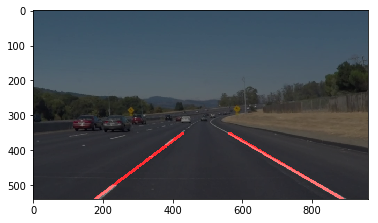

In [62]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[ 0.2         0.4         0.42857143  0.5         0.55555556  0.58333333
  0.6         0.66666667  0.75        0.77777778  0.83333333  0.85714286]
0.591666666667
[-1.         -0.92307692 -0.85714286 -0.83333333 -0.8        -0.77777778
 -0.75       -0.72727273 -0.71428571 -0.70588235 -0.7        -0.69230769
 -0.6875     -0.66666667 -0.64539007 -0.63636364 -0.63414634 -0.625
 -0.61538462 -0.6        -0.58333333 -0.55555556 -0.54166667 -0.5
 -0.42857143 -0.4        -0.2       ]
-0.666666666667
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  0%|          | 0/682 [00:00<?, ?it/s]

[ 0.2         0.4         0.42857143  0.5         0.55555556  0.58333333
  0.6         0.66666667  0.75        0.77777778  0.83333333  0.85714286]
0.591666666667
[-1.         -0.92307692 -0.85714286 -0.83333333 -0.8        -0.77777778
 -0.75       -0.72727273 -0.71428571 -0.70588235 -0.7        -0.69230769
 -0.6875     -0.66666667 -0.64539007 -0.63636364 -0.63414634 -0.625
 -0.61538462 -0.6        -0.58333333 -0.55555556 -0.54166667 -0.5
 -0.42857143 -0.4        -0.2       ]
-0.666666666667
[ 0.16666667  0.33333333  0.375       0.5         0.59259259  0.6
  0.64285714  0.65217391  0.71428571  0.72        0.72727273  0.8
  0.81818182  0.83333333  0.875       1.        ]


  0%|          | 2/682 [00:00<00:57, 11.86it/s]


0.683229813665
[-1.25       -1.2        -1.         -0.88235294 -0.875      -0.83333333
 -0.8        -0.77777778 -0.75       -0.71428571 -0.7        -0.66666667
 -0.64539007 -0.64285714 -0.63934426 -0.63636364 -0.63333333 -0.625      -0.6
 -0.58181818 -0.55555556 -0.54166667 -0.5        -0.44444444 -0.42857143
 -0.4       ]
-0.64412360689
[ 0.4         0.5625      0.57142857  0.63157895  0.65        0.65625
  0.66666667  0.7         0.70588235  0.71428571  0.77777778  0.78571429
  0.8         0.83333333  0.85714286  0.875       1.        ]
0.705882352941
[-1.4        -1.3        -1.25       -1.         -0.8        -0.77777778
 -0.76923077 -0.75       -0.71428571 -0.69230769 -0.66666667 -0.64788732
 -0.63461538 -0.63414634 -0.625      -0.6        -0.59375    -0.58181818
 -0.55555556 -0.53846154 -0.5        -0.44444444 -0.4       ]
-0.647887323944



  1%|          | 4/682 [00:00<00:55, 12.24it/s]

[ 0.33333333  0.4         0.44444444  0.55555556  0.6         0.625
  0.63636364  0.63793103  0.71428571  0.8       ]
0.6125
[-1.66666667 -1.6        -1.33333333 -1.25       -0.85714286 -0.8        -0.75
 -0.71428571 -0.69565217 -0.6875     -0.66666667 -0.64705882 -0.61538462
 -0.6        -0.58823529 -0.58333333 -0.57142857 -0.5625     -0.55555556
 -0.54545455 -0.52941176 -0.5        -0.44444444 -0.42857143 -0.4
 -0.14285714]
-0.607692307692



  1%|          | 6/682 [00:00<00:53, 12.54it/s]

[ 0.4         0.5         0.53846154  0.54545455  0.58333333  0.6
  0.61538462  0.65517241  0.66666667  0.7037037   0.83333333]
0.6
[-1.5        -0.85714286 -0.83333333 -0.82142857 -0.8        -0.77777778
 -0.75       -0.72727273 -0.71428571 -0.7        -0.69230769 -0.66666667
 -0.65517241 -0.63829787 -0.63636364 -0.625      -0.6        -0.59375
 -0.58823529 -0.57142857 -0.5625     -0.5        -0.42857143 -0.4       ]
-0.66091954023
[ 0.16666667  0.2         0.375       0.55555556  0.66666667  0.69230769
  0.73913043  1.        ]
0.611111111111
[-1.66666667 -1.5        -1.10526316 -1.         -0.83333333 -0.8        -0.75
 -0.73170732 -0.72727273 -0.71428571 -0.7        -0.6875     -0.66666667
 -0.64705882 -0.64179104 -0.63636364 -0.6        -0.59259259 -0.59090909
 -0.58536585 -0.5625     -0.5        -0.42857143 -0.4        -0.33333333
 -0.11111111]
-0.656862745098


[ 0.2         0.6         0.625       0.63333333  0.65217391  0.66666667]
0.629166666667
[-1.5        -1.125      -1.         -0.85714286 -0.83333333 -0.8
 -0.77777778 -0.76923077 -0.71428571 -0.6875     -0.66666667 -0.65384615
 -0.64814815 -0.63888889 -0.63793103 -0.625      -0.6        -0.58823529
 -0.57142857 -0.5        -0.4       ]
-0.666666666667



  1%|          | 8/682 [00:00<00:53, 12.66it/s]

[ 0.21428571  0.28571429  0.33333333  0.4         0.6         0.63636364
  0.66666667  0.7         0.71428571  0.75        0.85714286  1.
  1.66666667]
0.666666666667
[-1.125      -1.         -0.66666667 -0.65151515 -0.64285714 -0.63888889
 -0.63636364 -0.625      -0.61111111 -0.6        -0.58823529 -0.57142857
 -0.55555556 -0.53846154 -0.5        -0.42857143 -0.4       ]
-0.611111111111
[ 0.125       0.28571429  0.57142857  0.6         0.625       0.64285714
  0.65116279  0.6875      0.7         0.75      ]
0.633928571429
[-1.18181818 -1.08333333 -1.         -0.875      -0.75       -0.73684211
 -0.70588235 -0.7        -0.69230769 -0.6875     -0.65217391 -0.64
 -0.60869565 -0.6        -0.57142857 -0.55       -0.5        -0.42857143
 -0.4        -0.16666667]
-0.669836956522



  1%|▏         | 10/682 [00:00<00:52, 12.80it/s]

[ 0.22222222  0.4         0.54545455  0.6         0.61111111  0.64285714
  0.66666667  0.71428571  0.8       ]
0.611111111111
[-1.2        -1.11764706 -1.         -0.9        -0.85714286 -0.83333333
 -0.8        -0.78571429 -0.77777778 -0.75       -0.72727273 -0.72222222
 -0.71428571 -0.7        -0.66666667 -0.65217391 -0.64       -0.625
 -0.61538462 -0.61111111 -0.6        -0.5        -0.4       ]
-0.722222222222



  2%|▏         | 12/682 [00:00<00:52, 12.87it/s]

[ 0.42857143  0.57142857  0.625       0.63636364  0.66666667  0.69230769
  0.76923077  0.8         0.9       ]
0.666666666667
[-1.375      -1.         -0.85714286 -0.83333333 -0.77777778 -0.76923077
 -0.75       -0.71428571 -0.70588235 -0.6875     -0.66666667 -0.64705882
 -0.63636364 -0.625      -0.6        -0.59259259 -0.58333333 -0.57142857
 -0.5625     -0.55555556 -0.53846154 -0.5        -0.42857143 -0.4
 -0.33333333]
-0.636363636364
[ 0.33333333  0.57142857  0.59259259  0.6         0.6557377   0.72727273
  0.77777778  0.83333333  1.        ]
0.655737704918
[-1.1        -1.         -0.875      -0.85714286 -0.8        -0.77777778
 -0.75       -0.71428571 -0.7        -0.66666667 -0.65909091 -0.65346535
 -0.61111111 -0.6        -0.59259259 -0.57142857 -0.55555556 -0.53333333
 -0.5        -0.42857143 -0.4        -0.2       ]
-0.656278127813


[ 0.16666667  0.2         0.4         0.42857143  0.53846154  0.57142857
  0.59375     0.6         0.61538462  0.625       0.6557377   0.66666667
  0.77777778]
0.59375
[-2.5        -1.2        -1.125      -1.         -0.875      -0.85714286
 -0.83333333 -0.81818182 -0.8        -0.77777778 -0.75       -0.73529412
 -0.72727273 -0.71875    -0.71428571 -0.69230769 -0.66666667 -0.64516129
 -0.6446281  -0.64       -0.61111111 -0.6        -0.58333333 -0.57142857
 -0.5        -0.42857143 -0.4        -0.2        -0.16666667]
-0.714285714286



  2%|▏         | 14/682 [00:01<00:52, 12.80it/s]

[ 0.4         0.5         0.57142857  0.6         0.625       0.63934426
  0.64705882  0.64864865  0.66666667  0.71428571  0.77777778  0.8       ]
0.643201542912
[-1.21428571 -1.16666667 -1.         -0.91666667 -0.88888889 -0.85714286
 -0.83333333 -0.8        -0.77777778 -0.75       -0.71875    -0.71428571
 -0.7        -0.64705882 -0.6440678  -0.61111111 -0.6        -0.57142857
 -0.54545455 -0.5        -0.42857143 -0.4        -0.16666667]
-0.714285714286
[ 0.4         0.42857143  0.57142857  0.58333333  0.6         0.625
  0.63157895  0.63636364  0.6440678   0.64516129  0.66666667  0.7
  0.71428571  0.72727273  0.75        0.8         0.83333333]
0.64406779661
[-1.33333333 -1.25       -1.         -0.88888889 -0.85714286 -0.83333333
 -0.8        -0.78571429 -0.75       -0.72727273 -0.71428571 -0.66666667
 -0.65853659 -0.64830508 -0.64285714 -0.625      -0.61111111 -0.6
 -0.57142857 -0.55555556 -0.42857143 -0.4       ]
-0.690476190476



  2%|▏         | 16/682 [00:01<00:52, 12.68it/s]

[ 0.4         0.5         0.55        0.5625      0.56521739  0.57142857
  0.5862069   0.59090909  0.6         0.625       0.66666667  0.69230769
  0.75        0.8       ]
0.58855799373
[-1.         -0.89655172 -0.875      -0.85714286 -0.8        -0.78571429
 -0.77777778 -0.72727273 -0.72       -0.71428571 -0.70833333 -0.67857143
 -0.66666667 -0.65789474 -0.65517241 -0.63636364 -0.625      -0.6
 -0.58333333 -0.57142857 -0.5625     -0.55555556 -0.5        -0.42857143
 -0.4       ]
-0.666666666667



  3%|▎         | 18/682 [00:01<00:52, 12.61it/s]

[ 0.09090909  0.16666667  0.5         0.57142857  0.58333333  0.59090909
  0.6         0.66666667  0.7       ]
0.583333333333
[-1.5        -1.25       -1.16666667 -1.         -0.8        -0.77777778
 -0.75       -0.73333333 -0.72       -0.70833333 -0.69230769 -0.66666667
 -0.66101695 -0.625      -0.6        -0.58823529 -0.58333333 -0.57142857
 -0.5        -0.4        -0.13333333]
-0.692307692308
[ 0.14285714  0.375       0.6         0.64        0.66666667  0.69230769
  0.71428571  0.83333333  0.85714286]
0.666666666667
[-1.25       -1.05263158 -1.         -0.90909091 -0.85714286 -0.83333333
 -0.8        -0.78571429 -0.76923077 -0.75       -0.71794872 -0.71428571
 -0.66666667 -0.625      -0.61111111 -0.6        -0.58333333 -0.57142857
 -0.5625     -0.5        -0.4        -0.2       ]
-0.716117216117


[ 0.5         0.55555556  0.59259259  0.6         0.61111111  0.625
  0.66666667  0.83333333  1.        ]
0.611111111111
[-1.5        -1.25       -1.2        -1.         -0.875      -0.85714286
 -0.83333333 -0.81578947 -0.8        -0.76923077 -0.75       -0.73684211
 -0.71875    -0.71428571 -0.66666667 -0.65517241 -0.625      -0.6
 -0.58333333 -0.5625     -0.5        -0.4       ]
-0.743421052632



  3%|▎         | 20/682 [00:01<00:53, 12.49it/s]

[ 0.1         0.375       0.4         0.42857143  0.5         0.57142857
  0.6         0.7         0.71428571  0.8       ]
0.535714285714
[-1.4        -1.         -0.90909091 -0.875      -0.85714286 -0.8
 -0.78571429 -0.77777778 -0.76923077 -0.73033708 -0.71875    -0.71428571
 -0.6875     -0.64285714 -0.625      -0.6        -0.57142857 -0.55555556
 -0.5        -0.42857143 -0.4        -0.2       ]
-0.716517857143
[ 0.4         0.57142857  0.58333333  0.6         0.66666667  0.71428571
  0.75        0.83333333]
0.633333333333
[-1.66666667 -1.28571429 -1.25       -1.125      -1.         -0.88888889
 -0.85714286 -0.83333333 -0.81818182 -0.8        -0.78571429 -0.77777778
 -0.75       -0.72289157 -0.71875    -0.71428571 -0.7        -0.69230769
 -0.66666667 -0.63636364 -0.625      -0.61538462 -0.6        -0.5625
 -0.55555556 -0.5        -0.4        -0.28571429 -0.2       ]
-0.71875



  3%|▎         | 22/682 [00:01<00:52, 12.59it/s]

[ 0.11111111  0.2         0.54545455  0.6         0.625       0.64285714
  0.65        0.6875      0.7         0.8       ]
0.633928571429
[-1.25       -1.18181818 -1.         -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.75       -0.71428571 -0.7        -0.66666667
 -0.65853659 -0.63636364 -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.54545455 -0.5        -0.4       ]
-0.683333333333



  4%|▎         | 24/682 [00:01<00:52, 12.65it/s]

[ 0.16666667  0.33333333  0.4         0.52380952  0.58333333  0.6
  0.60869565  0.63636364  0.66666667  0.71428571  0.8         0.875     ]
0.604347826087
[-1.27272727 -1.         -0.91176471 -0.88888889 -0.875      -0.85714286
 -0.83333333 -0.81818182 -0.8        -0.78571429 -0.77777778 -0.75
 -0.72413793 -0.71428571 -0.70833333 -0.66666667 -0.6        -0.58333333
 -0.57142857 -0.5        -0.42857143 -0.4       ]
-0.763888888889
[ 0.0625      0.4         0.52941176  0.58974359  0.6         0.61538462
  0.66666667  0.69230769  0.71428571  0.72727273  0.75        0.76923077
  0.77777778  0.8         1.2       ]
0.692307692308
[-1.25       -1.         -0.90909091 -0.88888889 -0.875      -0.85714286
 -0.84615385 -0.83333333 -0.82608696 -0.81818182 -0.8        -0.77777778
 -0.73333333 -0.72093023 -0.71428571 -0.70967742 -0.7        -0.6875
 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.5        -0.4       ]
-0.755555555556


[ 0.4         0.5         0.54545455  0.57142857  0.6         0.61538462
  0.63333333  0.63636364  0.66666667  0.71428571  0.75        0.77777778
  0.8         0.83333333  1.        ]
0.636363636364
[-2.33333333 -1.25       -1.2        -1.14285714 -1.         -0.90909091
 -0.88888889 -0.81578947 -0.8        -0.75       -0.72222222 -0.71428571
 -0.66666667 -0.65789474 -0.65306122 -0.625      -0.61538462 -0.6
 -0.58333333 -0.57142857 -0.5625     -0.55555556 -0.5        -0.4       ]
-0.690476190476



  4%|▍         | 26/682 [00:02<00:52, 12.57it/s]

[ 0.4         0.42857143  0.5         0.54545455  0.5625      0.57142857
  0.57692308  0.6         0.625       0.66666667  0.71428571  0.77777778
  0.8         0.88888889  1.        ]
0.6
[-1.         -0.92592593 -0.91666667 -0.88888889 -0.875      -0.83333333
 -0.8125     -0.8        -0.77777778 -0.76923077 -0.75       -0.71428571
 -0.65714286 -0.64705882 -0.625      -0.61538462 -0.6        -0.59090909
 -0.55555556 -0.54545455 -0.5        -0.42857143 -0.4        -0.2       ]
-0.685714285714
[ 0.4         0.42857143  0.47058824  0.5         0.53846154  0.57142857
  0.58333333  0.59574468  0.6         0.64        0.66666667  0.70588235
  0.71428571  0.72727273  0.75        0.8         1.        ]
0.6
[-1.25       -1.23076923 -1.2        -1.         -0.9        -0.875      -0.8
 -0.78571429 -0.76923077 -0.76190476 -0.75       -0.71428571 -0.70833333
 -0.7        -0.66666667 -0.625      -0.61111111 -0.6        -0.58333333
 -0.57142857 -0.5        -0.4       ]
-0.732142857143



  4%|▍         | 28/682 [00:02<00:51, 12.68it/s]

[ 0.11111111  0.2         0.4         0.42857143  0.44444444  0.5
  0.54545455  0.55555556  0.5625      0.57142857  0.57692308  0.58333333
  0.59259259  0.6         0.625       0.64285714  0.65217391  0.66666667
  0.75        0.76923077  2.5       ]
0.576923076923
[-1.15384615 -1.         -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.8125     -0.8        -0.78571429 -0.76923077 -0.73684211 -0.72857143
 -0.72641509 -0.71428571 -0.66666667 -0.65822785 -0.625      -0.6
 -0.55555556 -0.5        -0.14285714]
-0.736842105263



  4%|▍         | 30/682 [00:02<00:51, 12.58it/s]

[ 0.2         0.375       0.42857143  0.5         0.52631579  0.57142857
  0.57407407  0.6         0.625       0.63636364  0.66666667  0.69230769
  0.7         0.71428571  0.72      ]
0.6
[-5.         -1.25       -1.2        -1.         -0.875      -0.85714286
 -0.83333333 -0.80769231 -0.8        -0.77777778 -0.76923077 -0.76190476
 -0.72727273 -0.6875     -0.66666667 -0.65957447 -0.65384615 -0.63636364
 -0.625      -0.61538462 -0.6        -0.57142857 -0.5        -0.4       ]
-0.744588744589
[ 0.125       0.2         0.375       0.4         0.5         0.52941176
  0.54545455  0.58823529  0.625       0.63636364  0.64285714  0.66666667]
0.53743315508
[-1.25       -1.2        -1.         -0.9        -0.88888889 -0.85714286
 -0.8125     -0.80952381 -0.8        -0.76470588 -0.75       -0.74074074
 -0.72727273 -0.7        -0.69230769 -0.66666667 -0.66       -0.625
 -0.61538462 -0.6        -0.58333333 -0.5        -0.4       ]
-0.740740740741


[ 0.5625      0.57142857  0.6         0.64        0.66666667  0.8
  0.85714286]
0.64
[-1.25       -1.         -0.88888889 -0.83333333 -0.8125     -0.8
 -0.77777778 -0.75       -0.71428571 -0.7        -0.6875     -0.66666667
 -0.66071429 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4        -0.09090909]
-0.6875



  5%|▍         | 32/682 [00:02<00:51, 12.51it/s]

[ 0.4         0.5         0.54545455  0.58333333  0.6         0.625
  0.66666667  0.85714286]
0.591666666667
[-1.5        -1.16666667 -1.         -0.9375     -0.9        -0.88888889
 -0.875      -0.83333333 -0.81818182 -0.80952381 -0.8        -0.75
 -0.72222222 -0.72093023 -0.68421053 -0.66666667 -0.64285714 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.54545455
 -0.5        -0.2        -0.11111111]
-0.720930232558
[ 0.52173913  0.57142857  0.6         0.7         0.70588235  0.75        1.        ]
0.7
[-1.5        -1.25       -1.2        -1.         -0.89473684 -0.85714286
 -0.8        -0.78571429 -0.75       -0.72916667 -0.72727273 -0.7260274
 -0.71875    -0.7        -0.66666667 -0.65384615 -0.625      -0.61111111
 -0.6        -0.4        -0.2       ]
-0.727272727273



  5%|▍         | 34/682 [00:02<00:51, 12.60it/s]

[ 0.14285714  0.2         0.57142857  0.58333333  0.6         0.66666667
  0.70588235  0.77777778  0.83333333  0.85714286]
0.633333333333
[-1.25       -1.0625     -1.         -0.9        -0.85714286 -0.83333333
 -0.8125     -0.8        -0.77777778 -0.76923077 -0.75       -0.74285714
 -0.71794872 -0.71428571 -0.66666667 -0.63636364 -0.625      -0.6
 -0.58333333 -0.57142857 -0.5        -0.4        -0.2       ]
-0.742857142857



  5%|▌         | 36/682 [00:02<00:51, 12.60it/s]

[ 0.28571429  0.5         0.53846154  0.55555556  0.6         0.61538462
  0.64        0.66666667  0.71428571  0.75        0.77777778]
0.615384615385
[-1.25       -1.         -0.90909091 -0.88888889 -0.85714286 -0.83333333
 -0.81428571 -0.8125     -0.8        -0.75       -0.72413793 -0.68421053
 -0.66666667 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.4        -0.16666667]
-0.704174228675
[ 0.16666667  0.4         0.5         0.58333333  0.58823529  0.625
  0.64285714  0.70588235  0.75        0.83333333]
0.606617647059
[-1.         -0.875      -0.85714286 -0.84615385 -0.83333333 -0.81818182
 -0.81333333 -0.8125     -0.80952381 -0.8        -0.77777778 -0.76923077
 -0.75       -0.73913043 -0.72727273 -0.72307692 -0.71428571 -0.7
 -0.69230769 -0.68421053 -0.66666667 -0.63636364 -0.6        -0.5        -0.4
 -0.2       ]
-0.744565217391


[ 0.2         0.33333333  0.4         0.44444444  0.5         0.53846154
  0.54545455  0.55555556  0.57142857  0.6         0.63157895  0.66666667
  0.7         0.75        0.8         0.85714286  1.        ]
0.571428571429
[-1.66666667 -1.2        -1.         -0.85714286 -0.83333333 -0.81818182
 -0.81111111 -0.8        -0.78947368 -0.77777778 -0.76923077 -0.75
 -0.73076923 -0.72727273 -0.71428571 -0.6875     -0.66666667 -0.6
 -0.57142857 -0.5        -0.16666667]
-0.769230769231



  6%|▌         | 38/682 [00:03<00:51, 12.54it/s]

[ 0.57142857  0.6         0.60869565  0.62857143  0.63636364  0.64444444
  0.66666667  0.6875      0.69230769  0.71428571  0.75        0.875       1.        ]
0.666666666667
[-1.28571429 -1.         -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.81395349 -0.8        -0.76923077 -0.73239437 -0.72289157
 -0.69230769 -0.66666667 -0.5        -0.4       ]
-0.806976744186
[ 0.3         0.4         0.44444444  0.45454545  0.46153846  0.5
  0.52941176  0.55        0.55555556  0.5625      0.57142857  0.58461538
  0.58974359  0.61904762  0.62068966  0.66666667  0.75        0.8       ]
0.559027777778
[-1.5        -1.         -0.90909091 -0.9        -0.88888889 -0.875
 -0.83333333 -0.81538462 -0.80769231 -0.80555556 -0.8        -0.77777778
 -0.76923077 -0.72380952 -0.71428571 -0.7        -0.69230769 -0.66666667
 -0.63636364 -0.625      -0.6        -0.58333333 -0.5       ]
-0.777777777778



  6%|▌         | 40/682 [00:03<00:51, 12.45it/s]

[ 0.33333333  0.4         0.5         0.57352941  0.5862069   0.6
  0.61111111  0.62068966  0.625       0.63414634  0.66666667  0.75        0.8
  1.25      ]
0.615900383142
[-1.33333333 -1.25       -1.         -0.92857143 -0.88888889 -0.82222222
 -0.8        -0.75       -0.74509804 -0.71428571 -0.69230769 -0.6875
 -0.66666667 -0.625      -0.61538462 -0.6        -0.58333333 -0.5        -0.4
 -0.11111111]
-0.703296703297



  6%|▌         | 42/682 [00:03<00:51, 12.36it/s]

[ 0.4         0.42857143  0.5         0.52173913  0.54166667  0.55555556
  0.56        0.56521739  0.57142857  0.6         0.625       0.63636364
  0.65        0.69230769  0.71428571  0.8       ]
0.568322981366
[-1.25       -1.07692308 -1.         -0.875      -0.83333333 -0.81818182
 -0.80769231 -0.8        -0.75862069 -0.72826087 -0.72727273 -0.725      -0.72
 -0.71428571 -0.69230769 -0.66666667 -0.64285714 -0.63636364 -0.625      -0.6
 -0.5        -0.4       ]
-0.726136363636
[ 0.5         0.57692308  0.6         0.64        0.64285714  0.71428571
  0.75        0.77777778  0.8       ]
0.642857142857
[-1.         -0.90909091 -0.875      -0.80555556 -0.8        -0.77777778
 -0.75       -0.73684211 -0.71428571 -0.69230769 -0.6875     -0.66666667
 -0.63636364 -0.625      -0.61538462 -0.6        -0.5        -0.4       ]
-0.703296703297


[ 0.4         0.5         0.54545455  0.55555556  0.625       0.63636364
  0.71428571  0.75        0.8       ]
0.625
[-1.25       -1.         -0.90909091 -0.9        -0.83333333 -0.8
 -0.77777778 -0.75       -0.73255814 -0.72463768 -0.71428571 -0.7
 -0.66666667 -0.625      -0.6        -0.55555556 -0.5        -0.2       ]
-0.728597910347



  6%|▋         | 44/682 [00:03<01:09,  9.24it/s]

[ 0.14285714  0.4         0.42857143  0.5         0.6         0.66666667]
0.464285714286
[-1.25       -1.         -0.90909091 -0.83333333 -0.81818182 -0.8        -0.75
 -0.73529412 -0.72727273 -0.71428571 -0.69230769 -0.66666667 -0.625      -0.6
 -0.5        -0.4       ]
-0.73128342246
[ 0.14285714  0.16666667  0.5         0.57142857  0.58333333  0.6
  0.64285714  1.        ]
0.577380952381
[-1.         -0.9        -0.83333333 -0.81818182 -0.8125     -0.80952381
 -0.8        -0.77777778 -0.75       -0.72727273 -0.72151899 -0.6875
 -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857 -0.5        -0.4
 -0.2       ]
-0.724395857307



  7%|▋         | 47/682 [00:04<01:13,  8.68it/s]

[ 0.4         0.6         0.61904762  0.63636364  0.66666667  0.77777778
  0.8         0.88888889]
0.651515151515
[-1.25       -1.05555556 -1.         -0.91666667 -0.9        -0.88888889
 -0.83333333 -0.81818182 -0.8        -0.74418605 -0.72881356 -0.72
 -0.68421053 -0.63636364 -0.625      -0.6        -0.57142857 -0.55555556
 -0.5        -0.4       ]
-0.736499802917
[ 0.14285714  0.4         0.53846154  0.5625      0.57142857  0.58333333
  0.59090909  0.6         0.66666667  0.75        0.8       ]
0.583333333333
[-1.         -0.9        -0.85714286 -0.83333333 -0.8        -0.76190476
 -0.73404255 -0.73239437 -0.7        -0.66666667 -0.65789474 -0.65625
 -0.64285714 -0.625      -0.6        -0.58333333 -0.5        -0.4       ]
-0.683333333333



  7%|▋         | 49/682 [00:04<01:16,  8.32it/s]

[ 0.4         0.53333333  0.54545455  0.57142857  0.6         0.63157895
  0.64        0.66666667  0.69230769  0.75        0.8         0.83333333
  0.85714286]
0.64
[-1.         -0.91666667 -0.81395349 -0.80645161 -0.80555556 -0.8
 -0.79166667 -0.76923077 -0.75       -0.728      -0.72727273 -0.69230769
 -0.6875     -0.68421053 -0.66666667 -0.65517241 -0.625      -0.61111111
 -0.6        -0.58333333 -0.55555556 -0.5        -0.4       ]
-0.692307692308
[ 0.16666667  0.33333333  0.4         0.57142857  0.58461538  0.6         0.625
  0.63934426  0.66666667]
0.584615384615
[-1.25       -1.125      -1.         -0.91666667 -0.90909091 -0.88888889
 -0.875      -0.81818182 -0.81481481 -0.80645161 -0.8        -0.75
 -0.73529412 -0.72777778 -0.72727273 -0.6875     -0.66666667 -0.63636364
 -0.625      -0.61538462 -0.6        -0.57142857 -0.5       ]
-0.75



  7%|▋         | 51/682 [00:04<01:15,  8.34it/s]

[ 0.33333333  0.4         0.44444444  0.5         0.55555556  0.5625
  0.57142857  0.58181818  0.58333333  0.6         0.63636364  0.69230769
  0.71428571]
0.571428571429
[-1.25       -1.16666667 -1.         -0.9        -0.875      -0.85714286
 -0.83333333 -0.8125     -0.80769231 -0.8        -0.75       -0.74285714
 -0.71428571 -0.7        -0.66666667 -0.63636364 -0.625      -0.57142857
 -0.5        -0.42857143 -0.4       ]
-0.75
[ 0.2         0.33333333  0.4         0.42857143  0.5         0.54545455
  0.57142857  0.6         0.60869565  0.625       0.62857143  0.63636364
  0.66666667  0.76923077  0.8         0.83333333  1.        ]
0.608695652174
[-1.         -0.94117647 -0.83333333 -0.82608696 -0.8        -0.75
 -0.73770492 -0.73333333 -0.73170732 -0.72815534 -0.71428571 -0.66666667
 -0.64285714 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.4        -0.16666667 -0.125     ]
-0.666666666667



  8%|▊         | 53/682 [00:04<01:16,  8.27it/s]

[ 0.16666667  0.4         0.42857143  0.44444444  0.5         0.55555556
  0.57894737  0.58        0.58823529  0.6         0.61538462  0.66666667
  0.6875      0.7         0.72727273  0.85714286  1.25      ]
0.588235294118
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.8        -0.77777778
 -0.75       -0.73684211 -0.73529412 -0.72727273 -0.72463768 -0.71428571
 -0.69230769 -0.6875     -0.66666667 -0.64285714 -0.63636364 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.54545455
 -0.5        -0.4       ]
-0.689903846154
[ 0.11111111  0.2         0.33333333  0.4         0.42857143  0.44444444
  0.5         0.53333333  0.54545455  0.55        0.58064516  0.58333333
  0.6         0.62068966  0.66666667  0.71428571  1.          1.25      ]
0.547727272727
[-1.28571429 -1.25       -1.2        -1.         -0.9        -0.85714286
 -0.83333333 -0.81818182 -0.80952381 -0.80555556 -0.8        -0.72340426
 -0.7        -0.68421053 -0.66666667 -0.625      -0.61538462 -0.6
 


  8%|▊         | 55/682 [00:05<01:15,  8.32it/s]

[ 0.11111111  0.125       0.33333333  0.4         0.44444444  0.5
  0.54545455  0.57142857  0.625       0.63829787  0.66666667  0.71428571
  0.75        0.83333333]
0.558441558442
[-1.         -0.91666667 -0.88888889 -0.78571429 -0.77777778 -0.75
 -0.73228346 -0.72727273 -0.7244898  -0.72222222 -0.71428571 -0.69230769
 -0.66666667 -0.625      -0.61538462 -0.6        -0.4       ]
-0.724489795918
[ 0.14285714  0.5         0.57777778  0.6         0.625       0.62857143
  0.66666667  0.72727273  0.75        0.8         0.83333333  0.85714286]
0.647619047619
[-1.         -0.9        -0.85714286 -0.81818182 -0.80952381 -0.77777778
 -0.75       -0.74       -0.72916667 -0.72093023 -0.71428571 -0.7
 -0.68421053 -0.66666667 -0.65789474 -0.63636364 -0.625      -0.6
 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.707142857143



  8%|▊         | 57/682 [00:05<01:17,  8.02it/s]

[ 0.57142857  0.6         0.625       0.62962963]
0.6125
[-1.         -0.92307692 -0.91666667 -0.9        -0.875      -0.85714286
 -0.82051282 -0.81818182 -0.8        -0.76923077 -0.72727273 -0.72093023
 -0.71428571 -0.6875     -0.68421053 -0.66666667 -0.63636364 -0.625      -0.6
 -0.58333333 -0.57142857 -0.5        -0.4        -0.28571429 -0.14285714]
-0.714285714286
[ 0.14285714  0.4         0.57142857  0.58823529  0.64516129  0.8
  0.88888889]
0.588235294118
[-1.         -0.90909091 -0.9        -0.88461538 -0.875      -0.85714286
 -0.84210526 -0.83333333 -0.81818182 -0.8        -0.78571429 -0.75       -0.728
 -0.72727273 -0.72222222 -0.7        -0.6875     -0.66666667 -0.63636364
 -0.6        -0.5       ]
-0.785714285714



  9%|▊         | 59/682 [00:05<01:18,  7.91it/s]

[ 0.2         0.6         0.63636364  0.66666667  0.77777778]
0.636363636364
[-1.2        -1.         -0.88888889 -0.875      -0.83333333 -0.81818182
 -0.81481481 -0.80952381 -0.8        -0.78571429 -0.75       -0.73684211
 -0.72368421 -0.72222222 -0.66666667 -0.63636364 -0.625      -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.730263157895
[ 0.44444444  0.59375     0.625       0.63157895  0.68421053  0.71428571
  0.8       ]
0.631578947368
[-1.2        -1.125      -1.         -0.875      -0.8125     -0.8
 -0.77777778 -0.75       -0.73626374 -0.73529412 -0.72815534 -0.72727273
 -0.72413793 -0.71428571 -0.66666667 -0.6        -0.58333333 -0.57142857
 -0.5        -0.4        -0.33333333]
-0.728155339806



  9%|▉         | 61/682 [00:05<01:17,  8.02it/s]

[ 0.16666667  0.4         0.53333333  0.54545455  0.56756757  0.57575758
  0.6         0.66666667  0.77777778  0.85714286]
0.571662571663
[-1.         -0.90909091 -0.83333333 -0.8        -0.78571429 -0.75
 -0.73109244 -0.73076923 -0.72727273 -0.725      -0.72222222 -0.71428571
 -0.7        -0.68421053 -0.66666667 -0.65789474 -0.61538462 -0.6
 -0.58333333 -0.55555556 -0.5        -0.2        -0.05882353]
-0.714285714286
[ 0.2         0.54545455  0.57142857  0.6         0.625       0.63157895
  0.66666667  0.7         0.70588235  0.75        0.77777778  0.8
  0.83333333  0.85714286  1.          1.5       ]
0.702941176471
[-1.         -0.9        -0.88888889 -0.85714286 -0.81818182 -0.73033708
 -0.71428571 -0.7037037  -0.66666667 -0.625      -0.61538462 -0.6
 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.685185185185



  9%|▉         | 63/682 [00:06<01:15,  8.23it/s]

[ 0.5         0.57142857  0.57692308  0.6         0.61538462  0.64285714
  0.64788732  0.66666667  0.69230769  0.7         0.71428571  0.77777778]
0.6453722334
[-1.25       -1.2        -1.         -0.88888889 -0.875      -0.85714286
 -0.83333333 -0.82926829 -0.8125     -0.8        -0.78571429 -0.71428571
 -0.66666667 -0.625      -0.61538462 -0.61111111 -0.6        -0.58333333
 -0.55555556 -0.5        -0.4       ]
-0.785714285714
[ 0.16666667  0.52941176  0.53846154  0.5862069   0.6         0.625
  0.64285714  0.66666667  0.6875      0.69230769  0.70588235  0.77777778
  0.8         0.83333333  1.        ]
0.666666666667
[-1.25       -1.         -0.9375     -0.9        -0.83333333 -0.8
 -0.78571429 -0.76923077 -0.75       -0.72727273 -0.7        -0.66666667
 -0.66       -0.625      -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4       ]
-0.713636363636



 10%|▉         | 65/682 [00:06<01:20,  7.64it/s]

[ 0.375       0.4         0.42857143  0.5         0.54166667  0.55555556
  0.5625      0.58823529  0.6         0.63934426  0.66666667  0.7
  0.71428571  0.75      ]
0.575367647059
[-1.66666667 -1.16666667 -1.         -0.875      -0.85714286 -0.83333333
 -0.82608696 -0.8        -0.78571429 -0.76923077 -0.72727273 -0.72       -0.71875
 -0.71428571 -0.7        -0.69230769 -0.68       -0.66666667 -0.63636364
 -0.625      -0.61538462 -0.6        -0.57142857 -0.5        -0.4       ]
-0.71875
[ 0.2         0.4         0.5         0.52631579  0.53333333  0.54545455
  0.55        0.57142857  0.575       0.6         0.625       0.62962963
  0.63461538  0.66666667  0.8         1.        ]
0.573214285714
[-1.         -0.875      -0.83333333 -0.8        -0.75       -0.73684211
 -0.73333333 -0.72839506 -0.72762646 -0.72727273 -0.71875    -0.71794872
 -0.7037037  -0.7        -0.66666667 -0.6        -0.5        -0.14285714]
-0.727449593208



 10%|▉         | 67/682 [00:06<01:18,  7.88it/s]

[ 0.28571429  0.375       0.4         0.42857143  0.45454545  0.5
  0.57142857  0.58333333  0.625       0.63636364  0.63793103  0.66666667
  0.72727273  0.75        0.78571429  0.8         0.83333333]
0.625
[-1.14285714 -1.         -0.9        -0.85714286 -0.83333333 -0.8
 -0.76470588 -0.75       -0.72727273 -0.72093023 -0.71875    -0.71698113
 -0.71428571 -0.66666667 -0.65853659 -0.65384615 -0.625      -0.6        -0.5       ]
-0.720930232558
[ 0.2         0.4         0.52380952  0.57575758  0.58333333  0.6         0.625
  0.63157895  0.63636364  0.66666667  0.69230769  0.72727273]
0.6125
[-1.25       -1.125      -1.         -0.91666667 -0.9        -0.8125
 -0.78947368 -0.72727273 -0.72222222 -0.71794872 -0.7        -0.68181818
 -0.68       -0.66666667 -0.64285714 -0.63636364 -0.625      -0.61538462
 -0.6        -0.58333333 -0.55555556 -0.5        -0.4       ]
-0.681818181818



 10%|█         | 69/682 [00:06<01:16,  8.05it/s]

[ 0.05882353  0.28571429  0.4         0.42857143  0.5         0.52941176
  0.6         0.625       0.62962963  0.66666667  0.7         0.83333333]
0.564705882353
[-1.         -0.93333333 -0.9        -0.88888889 -0.875      -0.85714286
 -0.81818182 -0.80952381 -0.8        -0.75       -0.72727273 -0.69230769
 -0.66666667 -0.65789474 -0.625      -0.6        -0.57142857 -0.5        -0.4       ]
-0.75
[ 0.16666667  0.5         0.57142857  0.6         0.65384615  0.7       ]
0.585714285714
[-1.         -0.90909091 -0.9047619  -0.9        -0.88888889 -0.85714286
 -0.83333333 -0.81632653 -0.8        -0.77777778 -0.75       -0.73333333
 -0.72972973 -0.72820513 -0.71875    -0.7        -0.66666667 -0.63636364
 -0.625      -0.57142857 -0.5        -0.4        -0.16666667]
-0.733333333333



 10%|█         | 71/682 [00:07<01:15,  8.14it/s]

[ 0.4         0.56521739  0.58333333  0.6         0.625       0.66666667
  1.        ]
0.6
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8
 -0.76923077 -0.74074074 -0.72       -0.66666667 -0.66037736 -0.65217391
 -0.64285714 -0.63636364 -0.625      -0.6        -0.57142857 -0.55555556
 -0.5        -0.4       ]
-0.663522012579
[ 0.15384615  0.58823529  0.6         0.63157895  0.8         0.83333333]
0.615789473684
[-1.         -0.92307692 -0.9        -0.875      -0.85714286 -0.81818182
 -0.8125     -0.8        -0.77777778 -0.76923077 -0.75       -0.72916667
 -0.72839506 -0.72222222 -0.7        -0.69230769 -0.63636364 -0.625      -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.54545455 -0.5        -0.4       ]
-0.728395061728



 11%|█         | 73/682 [00:07<01:15,  8.10it/s]

[ 0.5         0.625       0.65217391  0.66666667  0.70588235  0.71428571]
0.659420289855
[-1.14285714 -1.         -0.90909091 -0.88888889 -0.81818182 -0.8125     -0.8
 -0.77777778 -0.75       -0.73333333 -0.71428571 -0.70588235 -0.6875
 -0.68181818 -0.66666667 -0.65671642 -0.65       -0.63636364 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.684659090909
[ 0.28571429  0.4         0.5         0.57142857  0.6         0.64
  0.64705882  0.66666667  0.7         0.72727273  1.        ]
0.64
[-1.         -0.92857143 -0.85714286 -0.83333333 -0.81818182 -0.80769231
 -0.8        -0.73170732 -0.72727273 -0.69230769 -0.66666667 -0.61538462
 -0.61111111 -0.6        -0.57142857 -0.55555556 -0.5        -0.4        -0.2       ]
-0.692307692308



 11%|█         | 75/682 [00:07<01:13,  8.30it/s]

[ 0.16666667  0.42857143  0.45454545  0.5         0.54545455  0.6         0.640625
  0.66666667  0.75      ]
0.545454545455
[-1.         -0.90909091 -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.78571429 -0.77777778 -0.75       -0.72413793 -0.71428571 -0.66666667
 -0.65789474 -0.625      -0.61538462 -0.6        -0.5        -0.4       ]
-0.737068965517
[ 0.2         0.44444444  0.5         0.57142857  0.6         0.63157895
  0.63333333  0.63793103  0.66666667  0.71428571  0.73333333  0.77777778]
0.632456140351
[-1.         -0.88888889 -0.875      -0.85714286 -0.8125     -0.8
 -0.72777778 -0.72727273 -0.71794872 -0.71428571 -0.68421053 -0.66666667
 -0.625      -0.6        -0.4        -0.16666667]
-0.722610722611



 11%|█▏        | 77/682 [00:07<01:11,  8.45it/s]

[ 0.2         0.28571429  0.55555556  0.57142857  0.6         0.61111111
  0.61538462  0.64634146  0.69230769  0.75        0.76923077  0.83333333
  0.88888889]
0.615384615385
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.82352941
 -0.81818182 -0.8        -0.79166667 -0.77777778 -0.75       -0.72727273
 -0.72380952 -0.71428571 -0.66666667 -0.66037736 -0.65517241 -0.625      -0.6
 -0.5        -0.4        -0.125     ]
-0.738636363636
[ 0.2         0.33333333  0.4         0.42857143  0.5         0.55
  0.58333333  0.6         0.63636364  0.63888889  0.64285714  0.66666667
  0.6875      0.7         0.70588235  0.72727273  0.75        0.77777778
  0.8         0.875       1.        ]
0.642857142857
[-1.125      -1.         -0.91666667 -0.90909091 -0.88888889 -0.875      -0.8125
 -0.80952381 -0.8        -0.75       -0.71875    -0.71428571 -0.6875
 -0.66666667 -0.65789474 -0.625      -0.6        -0.58333333 -0.57142857
 -0.5        -0.4        -0.2       ]
-0.716517857143



 12%|█▏        | 79/682 [00:08<01:10,  8.56it/s]

[ 0.4         0.42857143  0.5         0.55555556  0.57142857  0.57777778
  0.6         0.63636364  0.64285714  0.65        0.66666667  0.6875
  0.69230769  0.75        0.77777778  0.8       ]
0.63961038961
[-1.25       -1.2        -1.         -0.90909091 -0.875      -0.85714286
 -0.83333333 -0.8        -0.77777778 -0.72857143 -0.72727273 -0.72093023
 -0.6875     -0.68421053 -0.66666667 -0.61538462 -0.6        -0.58333333
 -0.55555556 -0.5        -0.4        -0.125     ]
-0.724101479915
[ 0.2         0.4         0.42857143  0.44444444  0.5         0.58333333
  0.6         0.63265306  0.66666667  0.70588235  0.71428571  0.73684211
  0.75        0.83333333]
0.616326530612
[-1.         -0.93333333 -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.8125     -0.8        -0.78571429 -0.77777778 -0.72413793 -0.71428571
 -0.66666667 -0.65714286 -0.63636364 -0.625      -0.61111111 -0.6
 -0.58823529 -0.57142857 -0.55555556 -0.54545455 -0.5        -0.4
 -0.08333333]
-0.666666666667



 12%|█▏        | 81/682 [00:08<01:10,  8.58it/s]

[ 0.55555556  0.57142857  0.5862069   0.59259259  0.61111111  0.63157895
  0.65384615  0.66666667  0.7         0.72727273]
0.62134502924
[-1.         -0.9        -0.875      -0.85714286 -0.8        -0.76923077
 -0.75       -0.72774869 -0.72222222 -0.71794872 -0.70833333 -0.69230769
 -0.68421053 -0.66666667 -0.625      -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.42857143 -0.4       ]
-0.700320512821
[ 0.2         0.625       0.64285714  0.65        0.72      ]
0.642857142857
[-1.         -0.88888889 -0.875      -0.80952381 -0.78571429 -0.75
 -0.72413793 -0.72340426 -0.71428571 -0.68181818 -0.66666667 -0.65
 -0.63636364 -0.625      -0.6        -0.57142857 -0.5        -0.4       ]
-0.698051948052



 12%|█▏        | 83/682 [00:08<01:10,  8.50it/s]

[ 0.14285714  0.625       0.66666667  0.71428571  0.8         2.33333333]
0.690476190476
[-1.         -0.88888889 -0.875      -0.85714286 -0.8125     -0.8
 -0.77777778 -0.76923077 -0.75       -0.72727273 -0.72619048 -0.72222222
 -0.72       -0.68421053 -0.66666667 -0.63636364 -0.625      -0.6
 -0.58333333 -0.55555556 -0.5        -0.4        -0.14285714 -0.11111111
 -0.09090909]
-0.72
[ 0.33333333  0.57142857  0.59090909  0.6         0.66666667  0.6875
  0.71428571]
0.6
[-1.         -0.875      -0.85714286 -0.83333333 -0.8        -0.79411765
 -0.77777778 -0.76923077 -0.73333333 -0.72839506 -0.71428571 -0.66666667
 -0.6557377  -0.63636364 -0.625      -0.61538462 -0.6        -0.58333333
 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.690476190476



 12%|█▏        | 85/682 [00:08<01:11,  8.30it/s]

[ 0.25        0.4         0.5625      0.57894737  0.6         0.64285714
  0.66666667]
0.578947368421
[-1.25       -1.2        -1.         -0.92307692 -0.88888889 -0.85714286
 -0.84615385 -0.83333333 -0.8        -0.78571429 -0.75       -0.73333333
 -0.72222222 -0.72093023 -0.71428571 -0.70588235 -0.68421053 -0.66666667
 -0.64285714 -0.61538462 -0.60869565 -0.6        -0.58333333 -0.55555556
 -0.5        -0.4       ]
-0.72157622739
[ 0.2         0.33333333  0.4         0.42857143  0.6         0.61538462
  0.625       0.63636364  0.64705882  0.66666667  0.8       ]
0.615384615385
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.76923077 -0.75       -0.72375691 -0.72222222 -0.71428571 -0.7
 -0.66666667 -0.65789474 -0.64285714 -0.61538462 -0.6       ]
-0.723756906077



 13%|█▎        | 87/682 [00:08<01:13,  8.15it/s]

[ 0.4         0.58333333  0.6         0.625       0.63636364  0.64
  0.64285714  0.66666667  0.72        0.75        0.83333333]
0.64
[-1.25       -1.         -0.88888889 -0.85714286 -0.83333333 -0.8125     -0.8
 -0.78571429 -0.75       -0.73333333 -0.72972973 -0.71428571 -0.70967742
 -0.66666667 -0.625      -0.6        -0.58333333 -0.55555556 -0.5        -0.4       ]
-0.731531531532
[ 0.4         0.57142857  0.58333333  0.6         0.63636364  0.64
  0.68421053  0.7         0.71428571  0.75        0.8         1.        ]
0.662105263158
[-1.         -0.88888889 -0.875      -0.85714286 -0.82758621 -0.8
 -0.78947368 -0.78571429 -0.75       -0.72380952 -0.71428571 -0.69230769
 -0.66666667 -0.65384615 -0.625      -0.6        -0.57142857 -0.5       ]
-0.736904761905



 13%|█▎        | 89/682 [00:09<01:14,  7.98it/s]

[ 0.28571429  0.33333333  0.4         0.42857143  0.44444444  0.5
  0.55555556  0.625       0.66666667  0.69230769  0.7         0.71428571
  0.75        0.78571429  0.8       ]
0.625
[-1.         -0.875      -0.81818182 -0.8        -0.78947368 -0.72222222
 -0.66666667 -0.65384615 -0.64705882 -0.63636364 -0.61111111 -0.6
 -0.58333333 -0.57142857 -0.54545455 -0.5        -0.4        -0.2
 -0.14285714]
-0.636363636364
[ 0.28571429  0.4         0.44444444  0.5         0.54545455  0.55555556
  0.6         0.61538462  0.625       0.63414634  0.63636364  0.64285714
  0.66666667  0.69230769  0.7         0.71428571  0.8         0.85714286
  0.875       1.        ]
0.635254988914
[-1.25       -1.         -0.875      -0.83333333 -0.81818182 -0.8
 -0.73684211 -0.71428571 -0.7        -0.6875     -0.66666667 -0.65254237
 -0.64583333 -0.625      -0.61538462 -0.6        -0.57142857 -0.55555556
 -0.5        -0.4        -0.33333333]
-0.666666666667



 13%|█▎        | 91/682 [00:09<01:13,  8.05it/s]

[ 0.375       0.4         0.42857143  0.5         0.55555556  0.57142857
  0.58333333  0.6         0.61904762  0.64705882  0.66666667  0.7
  0.70833333  0.71428571  0.72727273  0.75        0.77777778  1.        ]
0.633053221289
[-1.25       -1.         -0.88888889 -0.875      -0.85714286 -0.81818182
 -0.8        -0.78571429 -0.77777778 -0.76923077 -0.75       -0.72916667
 -0.71428571 -0.7        -0.6875     -0.68421053 -0.66666667 -0.63636364
 -0.625      -0.6        -0.57142857 -0.54545455 -0.5        -0.4
 -0.33333333 -0.16666667]
-0.707142857143
[ 0.4         0.5         0.55555556  0.58823529  0.59259259  0.6
  0.64705882  0.66666667  0.69230769  0.7         0.71428571  0.75        0.8
  1.        ]
0.656862745098
[-1.         -0.91666667 -0.8        -0.72413793 -0.71428571 -0.7
 -0.66666667 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.54545455
 -0.5        -0.4        -0.2        -0.14285714]
-0.605555555556



 14%|█▎        | 93/682 [00:09<01:10,  8.31it/s]

[ 0.44444444  0.5         0.52631579  0.57142857  0.6         0.63414634
  0.64705882  0.66666667  0.7         0.71428571  0.72727273  0.75        0.8
  0.83333333]
0.656862745098
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8125     -0.8        -0.78571429 -0.77777778 -0.73333333 -0.72368421
 -0.71875    -0.71428571 -0.7        -0.66666667 -0.625      -0.6
 -0.58333333 -0.5        -0.4       ]
-0.733333333333
[ 0.125       0.14285714  0.2         0.33333333  0.42857143  0.44444444
  0.5         0.6         0.625       0.65517241  0.66666667  0.7
  0.71428571  0.75        0.8       ]
0.6
[-1.         -0.92307692 -0.88888889 -0.85714286 -0.82142857 -0.8
 -0.77777778 -0.76470588 -0.75       -0.72151899 -0.71875    -0.71428571
 -0.7037037  -0.66666667 -0.625      -0.6        -0.58333333 -0.57142857
 -0.5        -0.42857143 -0.4        -0.2        -0.14285714]
-0.714285714286



 14%|█▍        | 95/682 [00:09<01:10,  8.29it/s]

[ 0.1         0.6         0.625       0.66666667  0.71428571  0.75      ]
0.645833333333
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8
 -0.77777778 -0.76923077 -0.76190476 -0.72307692 -0.7        -0.69230769
 -0.66666667 -0.64285714 -0.625      -0.6        -0.59090909 -0.58333333
 -0.57142857 -0.5625     -0.54545455 -0.5        -0.4        -0.14285714]
-0.679487179487
[ 0.42857143  0.5         0.6         0.66666667  0.7         0.83333333]
0.633333333333
[-1.25       -1.         -0.875      -0.8        -0.71428571 -0.7
 -0.67857143 -0.66666667 -0.66071429 -0.65       -0.64285714 -0.63636364
 -0.625      -0.61538462 -0.6        -0.59090909 -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.4        -0.125     ]
-0.63961038961



 14%|█▍        | 97/682 [00:10<01:11,  8.15it/s]

[ 0.2         0.4         0.625       0.66666667  0.72222222  0.8         1.25      ]
0.666666666667
[-1.         -0.875      -0.85714286 -0.8        -0.77777778 -0.72477064
 -0.72222222 -0.71875    -0.71428571 -0.7        -0.68181818 -0.66666667
 -0.66037736 -0.64285714 -0.63636364 -0.625      -0.6        -0.5
 -0.42857143 -0.4       ]
-0.690909090909
[ 0.14285714  0.16666667  0.42857143  0.6         0.62857143  0.65217391
  0.66666667  0.7         0.76923077  0.8       ]
0.640372670807
[-1.         -0.875      -0.85714286 -0.79487179 -0.73684211 -0.72727273
 -0.72222222 -0.72093023 -0.71666667 -0.71428571 -0.70588235 -0.7
 -0.66666667 -0.65       -0.63636364 -0.625      -0.6        -0.58333333
 -0.57142857 -0.5        -0.4        -0.2       ]
-0.702941176471



 15%|█▍        | 99/682 [00:10<01:11,  8.19it/s]

[ 0.14285714  0.33333333  0.5         0.6         0.66666667  0.6875      0.75
  0.8         0.83333333  0.85714286  1.        ]
0.6875
[-1.         -0.88888889 -0.875      -0.85714286 -0.81818182 -0.8        -0.75
 -0.73214286 -0.72857143 -0.72727273 -0.7        -0.66666667 -0.65517241
 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857 -0.5
 -0.42857143 -0.4        -0.2       ]
-0.683333333333
[ 0.16666667  0.57894737  0.6         0.66666667  0.70588235  0.71428571
  0.81818182  0.83333333]
0.686274509804
[-1.         -0.875      -0.85714286 -0.83333333 -0.81818182 -0.81081081
 -0.8        -0.77777778 -0.72727273 -0.72151899 -0.7        -0.66666667
 -0.6557377  -0.63636364 -0.625      -0.61538462 -0.6        -0.58823529
 -0.57142857 -0.5        -0.4        -0.125     ]
-0.683333333333



 15%|█▍        | 101/682 [00:10<01:08,  8.47it/s]

[ 0.16666667  0.2         0.58333333  0.6         0.63888889  0.66666667
  0.68        0.69230769  0.71428571  0.8         1.2       ]
0.666666666667
[-1.         -0.875      -0.8125     -0.8        -0.77777778 -0.72       -0.71875
 -0.71428571 -0.7        -0.66666667 -0.66037736 -0.63636364 -0.625      -0.6
 -0.57142857 -0.5        -0.42857143 -0.4        -0.2       ]
-0.666666666667
[ 0.4         0.58333333  0.6         0.65        0.66666667  0.69230769
  0.7         0.71428571  0.75        0.77777778  0.8       ]
0.692307692308
[-1.         -0.91666667 -0.88888889 -0.83333333 -0.8        -0.78947368
 -0.78571429 -0.77777778 -0.75       -0.72093023 -0.71428571 -0.70588235
 -0.7        -0.66666667 -0.625      -0.61538462 -0.6        -0.57142857
 -0.5625     -0.55555556 -0.5        -0.4        -0.33333333]
-0.705882352941



 15%|█▌        | 103/682 [00:10<01:11,  8.12it/s]

[ 0.16666667  0.4         0.42857143  0.5         0.56521739  0.57142857
  0.58333333  0.6         0.61538462  0.66666667  0.72        0.73333333
  0.75        0.77777778  0.8       ]
0.6
[-1.         -0.88888889 -0.875      -0.85714286 -0.8125     -0.8
 -0.78571429 -0.77777778 -0.75       -0.73684211 -0.72727273 -0.71875
 -0.68421053 -0.66666667 -0.63636364 -0.63333333 -0.625      -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.701480263158
[ 0.14285714  0.4         0.57142857  0.58333333  0.6         0.61538462
  0.64705882  0.65151515  0.66666667  0.7         0.71428571  0.75
  0.83333333  1.          3.5       ]
0.651515151515
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8125     -0.8        -0.77777778 -0.72839506 -0.72307692 -0.71428571
 -0.70967742 -0.68       -0.66666667 -0.625      -0.61538462 -0.61111111
 -0.6        -0.57142857 -0.55555556 -0.5        -0.4        -0.14285714]
-0.71198156682



 15%|█▌        | 105/682 [00:11<01:11,  8.07it/s]

[ 0.14285714  0.54545455  0.58333333  0.6         0.61904762  0.625
  0.64285714  0.64516129  0.64705882  0.66666667  0.7         0.71428571
  1.25      ]
0.642857142857
[-1.         -0.875      -0.83333333 -0.81818182 -0.8        -0.75
 -0.71428571 -0.70967742 -0.66666667 -0.63636364 -0.625      -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.5        -0.4        -0.2       ]
-0.651515151515
[ 0.33333333  0.42857143  0.44444444  0.5         0.57142857  0.58333333
  0.625       0.64285714  0.66666667  0.6875      0.69230769  0.7
  0.71428571  0.72727273  0.75        0.8         0.85714286  1.        ]
0.677083333333
[-1.         -0.875      -0.85714286 -0.81818182 -0.80769231 -0.8
 -0.78571429 -0.75       -0.73529412 -0.71428571 -0.70833333 -0.7        -0.6875
 -0.66666667 -0.65517241 -0.64285714 -0.625      -0.6        -0.57142857
 -0.5        -0.4       ]
-0.708333333333



 16%|█▌        | 107/682 [00:11<01:11,  8.10it/s]

[ 0.14285714  0.33333333  0.375       0.5         0.53846154  0.58333333
  0.6         0.625       0.63636364  0.66666667  0.69230769  0.71428571
  0.75      ]
0.6
[-1.         -0.9        -0.875      -0.83333333 -0.81818182 -0.8
 -0.77777778 -0.76923077 -0.72222222 -0.71875    -0.71428571 -0.7
 -0.66666667 -0.65116279 -0.625      -0.61111111 -0.6        -0.58823529
 -0.57142857 -0.54545455 -0.5        -0.4       ]
-0.707142857143
[ 0.375       0.58333333  0.59090909  0.64705882  0.66666667]
0.590909090909
[-1.         -0.9        -0.83333333 -0.76923077 -0.75       -0.73684211
 -0.69230769 -0.66666667 -0.65384615 -0.625      -0.61538462 -0.61111111
 -0.6        -0.58333333 -0.57142857 -0.5625     -0.55555556 -0.5
 -0.42857143 -0.4        -0.2       ]
-0.615384615385



 16%|█▌        | 109/682 [00:11<01:08,  8.39it/s]

[ 0.5         0.55555556  0.57142857  0.6         0.60869565  0.63157895
  0.66666667  0.77777778  0.8       ]
0.608695652174
[-1.25       -1.         -0.88888889 -0.85714286 -0.83333333 -0.8
 -0.78571429 -0.77777778 -0.75       -0.73076923 -0.6875     -0.66666667
 -0.65       -0.625      -0.6        -0.59259259 -0.57142857 -0.5625
 -0.54545455 -0.5        -0.42857143 -0.4       ]
-0.677083333333
[ 0.2         0.28571429  0.33333333  0.4         0.57142857  0.6
  0.63636364  0.7         1.        ]
0.571428571429
[-1.         -0.85714286 -0.83333333 -0.81818182 -0.8        -0.78571429
 -0.77777778 -0.75       -0.72916667 -0.72307692 -0.71428571 -0.66666667
 -0.64       -0.625      -0.6        -0.58333333 -0.57142857 -0.5        -0.4
 -0.16666667]
-0.718681318681



 16%|█▋        | 111/682 [00:11<01:09,  8.27it/s]

[ 0.2         0.5         0.6         0.625       0.71428571  0.75
  0.83333333  1.          1.2       ]
0.714285714286
[-1.         -0.875      -0.85714286 -0.81818182 -0.8        -0.77777778
 -0.75       -0.72727273 -0.72340426 -0.71428571 -0.7        -0.69230769
 -0.6875     -0.66666667 -0.64285714 -0.625      -0.61538462 -0.6
 -0.57142857 -0.5        -0.4        -0.2       ]
-0.696153846154
[ 0.2         0.5         0.57142857  0.58333333  0.6         0.63636364
  0.66666667  0.68421053  0.72222222]
0.6
[-1.         -0.88888889 -0.875      -0.8        -0.75       -0.72
 -0.66666667 -0.66037736 -0.65384615 -0.65306122 -0.625      -0.6
 -0.58333333 -0.57142857 -0.53846154 -0.5        -0.42857143 -0.4       ]
-0.653453689168



 17%|█▋        | 113/682 [00:12<01:07,  8.41it/s]

[ 0.14285714  0.52380952  0.54545455  0.6         0.65217391  0.69230769
  0.7         0.71428571  0.77777778  0.81818182]
0.672240802676
[-1.         -0.90909091 -0.9        -0.875      -0.85714286 -0.81818182
 -0.8        -0.77777778 -0.76923077 -0.75       -0.72368421 -0.71875
 -0.66666667 -0.65289256 -0.625      -0.61538462 -0.61111111 -0.6
 -0.58333333 -0.57142857 -0.5        -0.4       ]
-0.721217105263
[ 0.14285714  0.57142857  0.58333333  0.6         0.625       0.66666667
  0.72727273  0.75        0.8         0.83333333  1.        ]
0.666666666667
[-1.         -0.9        -0.85714286 -0.80952381 -0.8        -0.77777778
 -0.76923077 -0.72727273 -0.72340426 -0.71428571 -0.68181818 -0.66666667
 -0.63636364 -0.625      -0.61538462 -0.6        -0.59090909 -0.58333333
 -0.57142857 -0.55555556 -0.5        -0.44444444 -0.4        -0.2       ]
-0.651515151515



 17%|█▋        | 115/682 [00:12<01:05,  8.60it/s]

[ 0.1         0.4         0.44444444  0.5         0.57142857  0.58823529
  0.59090909  0.6         0.625       0.64285714  0.66666667  0.75        1.        ]
0.590909090909
[-1.         -0.91666667 -0.875      -0.84615385 -0.8        -0.77777778
 -0.75       -0.73684211 -0.73333333 -0.72727273 -0.72       -0.7
 -0.69230769 -0.6875     -0.66666667 -0.65432099 -0.625      -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.5        -0.42857143 -0.4       ]
-0.696153846154
[ 0.14285714  0.5         0.57142857  0.58695652  0.6         0.64957265
  0.66666667  0.71428571  0.75        0.77777778  0.8         0.85714286]
0.65811965812
[-1.         -0.875      -0.85714286 -0.8        -0.76923077 -0.72535211
 -0.71428571 -0.7        -0.68181818 -0.66666667 -0.65789474 -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.674242424242



 17%|█▋        | 117/682 [00:12<01:05,  8.57it/s]

[ 0.2         0.28571429  0.4         0.42857143  0.44444444  0.5
  0.58974359  0.6         0.64705882  0.65248227  0.66666667  0.6875
  0.71428571  0.75        0.77777778  0.8       ]
0.623529411765
[-1.         -0.875      -0.73611111 -0.71875    -0.71428571 -0.7037037
 -0.68181818 -0.66666667 -0.65789474 -0.65517241 -0.625      -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4        -0.2
 -0.16666667]
-0.640086206897
[ 0.125       0.54545455  0.56521739  0.56666667  0.57142857  0.6
  0.61538462  0.63636364  0.64285714  0.66666667  0.6875      0.7
  0.70588235  0.8       ]
0.625874125874
[-1.         -0.875      -0.8        -0.78947368 -0.77777778 -0.75
 -0.72727273 -0.72222222 -0.71428571 -0.70833333 -0.69230769 -0.66666667
 -0.66037736 -0.6        -0.5        -0.4       ]
-0.718253968254



 17%|█▋        | 119/682 [00:12<01:04,  8.74it/s]

[ 0.14285714  0.2         0.33333333  0.4         0.57142857  0.6
  0.63636364  0.66666667  0.70588235  0.70833333  0.71428571  0.83333333]
0.618181818182
[-1.25       -1.         -0.9        -0.88888889 -0.85714286 -0.83333333
 -0.80952381 -0.8        -0.73333333 -0.72       -0.7173913  -0.71428571
 -0.68       -0.66666667 -0.625      -0.61538462 -0.6        -0.59259259
 -0.58333333 -0.55555556 -0.5        -0.42857143 -0.4       ]
-0.714285714286
[ 0.4         0.5         0.57142857  0.65384615  0.66666667  0.6875
  0.71428571  0.8       ]
0.660256410256
[-1.         -0.88888889 -0.875      -0.81818182 -0.75       -0.73684211
 -0.72463768 -0.71875    -0.71428571 -0.6875     -0.66666667 -0.65625
 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857 -0.5        -0.4
 -0.2        -0.16666667]
-0.666666666667



 18%|█▊        | 121/682 [00:13<01:06,  8.47it/s]

[ 0.33333333  0.55555556  0.58333333  0.6         0.625       0.69230769
  0.8       ]
0.6
[-1.         -0.88888889 -0.79166667 -0.75       -0.72222222 -0.72
 -0.68181818 -0.66666667 -0.65384615 -0.63636364 -0.625      -0.6
 -0.59090909 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.42857143
 -0.4       ]
-0.636363636364
[ 0.1         0.125       0.2         0.4         0.55555556  0.57142857
  0.6         0.66666667  0.71428571  0.8         1.        ]
0.571428571429
[-1.         -0.875      -0.83333333 -0.81818182 -0.8        -0.78571429
 -0.76923077 -0.75       -0.72307692 -0.71428571 -0.69230769 -0.66666667
 -0.65       -0.63636364 -0.625      -0.61538462 -0.6        -0.58333333
 -0.57142857 -0.5        -0.4        -0.2       ]
-0.679487179487



 18%|█▊        | 123/682 [00:13<01:06,  8.40it/s]

[ 0.11111111  0.54545455  0.6         0.63888889  0.64705882  0.65
  0.66666667  0.71428571  0.72727273  0.8         1.66666667]
0.65
[-1.         -0.875      -0.85714286 -0.81481481 -0.8        -0.75       -0.725
 -0.71428571 -0.6875     -0.67741935 -0.66666667 -0.65789474 -0.625
 -0.61111111 -0.6        -0.57142857 -0.5        -0.4        -0.33333333
 -0.05882353]
-0.672043010753
[ 0.57142857  0.6         0.625       0.64583333  0.66666667  0.71428571
  0.75      ]
0.645833333333
[-1.         -0.83333333 -0.8        -0.78571429 -0.75       -0.72340426
 -0.71428571 -0.67741935 -0.66666667 -0.65384615 -0.63636364 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.5        -0.4        -0.2       ]
-0.653846153846



 18%|█▊        | 125/682 [00:13<01:04,  8.59it/s]

[ 0.2         0.52941176  0.58333333  0.6         0.64705882  0.66666667
  0.7         0.71428571  0.8         0.83333333]
0.656862745098
[-1.25       -1.         -0.875      -0.83333333 -0.8        -0.72093023
 -0.71875    -0.7        -0.69230769 -0.68       -0.66666667 -0.65217391
 -0.63636364 -0.625      -0.6        -0.5        -0.4       ]
-0.692307692308
[ 0.57142857  0.58974359  0.6         0.625       0.64285714  0.66666667
  0.7         0.71428571  0.8         0.83333333  1.25      ]
0.666666666667
[-1.         -0.88888889 -0.875      -0.81818182 -0.8        -0.77777778
 -0.75       -0.72093023 -0.68421053 -0.66666667 -0.65789474 -0.63636364
 -0.61538462 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4        -0.33333333]
-0.657894736842



 19%|█▊        | 127/682 [00:13<01:04,  8.60it/s]

[ 0.55555556  0.57142857  0.58823529  0.6         0.65079365  0.65714286
  0.71428571  0.75        0.77777778  0.8         0.83333333  1.        ]
0.685714285714
[-1.16666667 -1.         -0.85714286 -0.8125     -0.8        -0.78947368
 -0.78571429 -0.75       -0.73684211 -0.7257384  -0.72222222 -0.71794872
 -0.66666667 -0.62962963 -0.61538462 -0.6        -0.58333333 -0.5
 -0.42857143 -0.4       ]
-0.723980309423
[ 0.5         0.54545455  0.57142857  0.58333333  0.58823529  0.625
  0.64285714  0.64634146  0.66666667  0.69230769  0.71428571  0.75        0.8
  0.85714286]
0.644599303136
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8125
 -0.80952381 -0.8        -0.75       -0.73684211 -0.72727273 -0.71875
 -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857 -0.55555556
 -0.5        -0.4       ]
-0.732057416268



 19%|█▉        | 129/682 [00:14<01:03,  8.69it/s]

[ 0.2         0.33333333  0.4         0.42857143  0.5         0.57894737
  0.625       0.64102564  0.66666667  0.6875      0.70588235  0.71428571
  0.77777778  0.8         0.9         0.90909091  1.        ]
0.666666666667
[-1.2        -1.         -0.875      -0.85714286 -0.83333333 -0.8
 -0.73333333 -0.72340426 -0.71794872 -0.71428571 -0.70967742 -0.6875
 -0.68181818 -0.66666667 -0.63636364 -0.625      -0.61538462 -0.6
 -0.58333333 -0.55555556 -0.54545455 -0.5        -0.4       ]
-0.6875
[ 0.4         0.55        0.58333333  0.58823529  0.59259259  0.6         0.625
  0.66666667  0.7         0.75        0.77777778  1.        ]
0.6125
[-1.         -0.875      -0.81818182 -0.8125     -0.8        -0.78947368
 -0.78571429 -0.75       -0.73076923 -0.72093023 -0.72       -0.71875
 -0.71428571 -0.70588235 -0.66666667 -0.65517241 -0.625      -0.61111111
 -0.6        -0.58333333 -0.57142857 -0.5        -0.4       ]
-0.71875



 19%|█▉        | 131/682 [00:14<01:04,  8.60it/s]

[ 0.28571429  0.33333333  0.4         0.5         0.55555556  0.58333333
  0.6         0.625       0.63888889  0.66666667  0.7         0.73333333
  0.77777778  0.8         1.        ]
0.625
[-1.2        -1.         -0.9        -0.88888889 -0.875      -0.81818182
 -0.8        -0.76923077 -0.71875    -0.71428571 -0.70588235 -0.68421053
 -0.66666667 -0.64705882 -0.63636364 -0.625      -0.61111111 -0.6
 -0.58333333 -0.5625     -0.54545455 -0.5        -0.4        -0.33333333]
-0.675438596491
[ 0.16666667  0.33333333  0.4         0.5         0.5625      0.57692308
  0.6         0.625       0.63636364  0.64705882  0.66666667  0.7       ]
0.588461538462
[-1.         -0.85714286 -0.8        -0.75       -0.72527473 -0.72093023
 -0.71875    -0.70588235 -0.66666667 -0.65217391 -0.61538462 -0.61111111
 -0.6        -0.57142857 -0.5        -0.4        -0.14285714]
-0.666666666667



 20%|█▉        | 133/682 [00:14<01:08,  8.07it/s]

[ 0.4         0.6         0.65384615  0.66666667  0.69230769]
0.653846153846
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8
 -0.78571429 -0.75       -0.72727273 -0.72058824 -0.66666667 -0.64705882
 -0.63636364 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.5        -0.4       ]
-0.69362745098
[ 0.2         0.57692308  0.6         0.62068966  0.625       0.7       ]
0.610344827586
[-1.         -0.875      -0.85714286 -0.81818182 -0.8        -0.78571429
 -0.75       -0.73913043 -0.725      -0.72483221 -0.71875    -0.71428571
 -0.66666667 -0.625      -0.61111111 -0.6        -0.57894737 -0.4        -0.2       ]
-0.724832214765



 20%|█▉        | 135/682 [00:14<01:10,  7.79it/s]

[ 0.33333333  0.44444444  0.5         0.52631579  0.57692308  0.625
  0.63636364  0.71428571]
0.551619433198
[-1.         -0.875      -0.8125     -0.8        -0.77777778 -0.7
 -0.66666667 -0.66037736 -0.65909091 -0.64285714 -0.61111111 -0.6
 -0.58333333 -0.55555556 -0.54545455 -0.5        -0.4        -0.2       ]
-0.650974025974
[ 0.2         0.58333333  0.58695652  0.625       0.62962963  0.66666667
  1.        ]
0.625
[-1.         -0.9        -0.85714286 -0.83333333 -0.8125     -0.8
 -0.78571429 -0.76923077 -0.72       -0.66666667 -0.66       -0.65789474
 -0.63636364 -0.625      -0.60869565 -0.6        -0.59090909 -0.58333333
 -0.57142857 -0.5        -0.4        -0.125     ]
-0.658947368421



 20%|██        | 137/682 [00:15<01:05,  8.27it/s]

[ 0.125       0.14285714  0.5         0.64285714  0.64583333  0.8       ]
0.571428571429
[-1.         -0.875      -0.8        -0.76923077 -0.75       -0.725
 -0.72222222 -0.71794872 -0.71428571 -0.69230769 -0.66666667 -0.625      -0.6
 -0.58333333 -0.57142857 -0.5        -0.4       ]
-0.714285714286
[ 0.4         0.5         0.54545455  0.55555556  0.57142857  0.6         0.65
  0.66666667  0.69230769  0.71428571  0.8       ]
0.6
[-1.         -0.85714286 -0.81818182 -0.8125     -0.8        -0.78571429
 -0.72535211 -0.71875    -0.71428571 -0.70833333 -0.7        -0.68181818
 -0.68       -0.625      -0.61538462 -0.6        -0.57142857 -0.55555556
 -0.5        -0.4       ]
-0.704166666667



 20%|██        | 139/682 [00:15<01:04,  8.38it/s]

[ 0.4         0.5         0.52631579  0.6         0.63414634  0.64864865
  0.66666667  0.7         0.75      ]
0.634146341463
[-1.         -0.9        -0.83333333 -0.81818182 -0.8125     -0.8        -0.75
 -0.71794872 -0.71428571 -0.68       -0.66666667 -0.65789474 -0.65306122
 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857 -0.5        -0.4
 -0.2       ]
-0.666666666667
[ 0.2         0.375       0.42857143  0.46153846  0.55555556  0.5625
  0.57142857  0.59090909  0.61538462  0.625       0.66666667  0.68421053
  0.75        0.78571429  0.875     ]
0.590909090909
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.8125     -0.8
 -0.79166667 -0.76923077 -0.73333333 -0.73076923 -0.72       -0.71428571
 -0.7        -0.66666667 -0.65517241 -0.625      -0.61538462 -0.6
 -0.57142857 -0.5        -0.42857143 -0.4        -0.14285714]
-0.714285714286



 21%|██        | 141/682 [00:15<01:03,  8.58it/s]

[ 0.2         0.4         0.42857143  0.6         0.61111111  0.625
  0.63636364  0.66666667  0.6875      0.69230769  0.71428571  0.75
  0.76923077  0.8         0.83333333  0.88888889]
0.677083333333
[-1.         -0.88888889 -0.875      -0.8125     -0.8        -0.78571429
 -0.75       -0.72727273 -0.71875    -0.71428571 -0.69230769 -0.68421053
 -0.66666667 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.54545455 -0.5        -0.4       ]
-0.692307692308
[ 0.33333333  0.375       0.4         0.42857143  0.5         0.5625
  0.57142857  0.6         0.61111111  0.625       0.63333333  0.66666667
  0.69230769  0.70588235  0.71428571  0.75        0.8         0.9         1.        ]
0.625
[-1.         -0.9        -0.88888889 -0.875      -0.83333333 -0.8125     -0.8
 -0.77777778 -0.75       -0.725      -0.71428571 -0.70833333 -0.67857143
 -0.66101695 -0.63636364 -0.625      -0.61111111 -0.6        -0.57142857
 -0.5        -0.4       ]
-0.714285714286



 21%|██        | 143/682 [00:15<01:02,  8.62it/s]

[ 0.28571429  0.47058824  0.5         0.54545455  0.58333333  0.62068966
  0.625       0.65384615  0.66666667  0.7         0.73333333  0.75
  0.77777778  0.8         0.83333333  1.        ]
0.660256410256
[-1.         -0.875      -0.85714286 -0.83333333 -0.8        -0.76923077
 -0.75       -0.72727273 -0.72631579 -0.7251462  -0.72222222 -0.70588235
 -0.66666667 -0.61538462 -0.58333333 -0.57142857 -0.5        -0.4       ]
-0.725730994152
[ 0.5         0.57142857  0.6         0.61904762  0.62068966  0.64705882
  0.66666667  0.69230769  0.7         0.73333333  0.75        0.8         1.        ]
0.666666666667
[-1.         -0.9        -0.88888889 -0.875      -0.83333333 -0.77777778
 -0.75       -0.72727273 -0.72413793 -0.71794872 -0.71428571 -0.70588235
 -0.7037037  -0.6875     -0.66666667 -0.65       -0.63636364 -0.625
 -0.54545455 -0.5        -0.4        -0.16666667]
-0.710084033613



 21%|██▏       | 145/682 [00:15<01:01,  8.73it/s]

[ 0.07142857  0.5         0.55555556  0.57894737  0.6         0.63636364
  0.64        0.66666667  0.71428571]
0.6
[-1.         -0.88888889 -0.875      -0.85714286 -0.8        -0.78571429
 -0.75       -0.73333333 -0.71428571 -0.69230769 -0.66666667 -0.64285714
 -0.625      -0.61111111 -0.6        -0.57142857 -0.55555556 -0.5
 -0.42857143 -0.4        -0.33333333]
-0.666666666667
[ 0.5         0.55555556  0.58333333  0.6         0.62962963  0.66666667
  0.68421053  0.71428571]
0.614814814815
[-1.         -0.875      -0.85714286 -0.8125     -0.8        -0.75
 -0.73333333 -0.72413793 -0.71428571 -0.7        -0.66666667 -0.66       -0.625
 -0.61538462 -0.61111111 -0.6        -0.58333333 -0.55555556 -0.5        -0.4       ]
-0.683333333333



 21%|██▏       | 146/682 [00:16<01:04,  8.35it/s]

[ 0.22222222  0.5         0.6         0.64705882  0.65517241  0.71428571
  0.77777778  0.8       ]
0.651115618661
[-1.         -0.9        -0.875      -0.81818182 -0.8        -0.78571429
 -0.71428571 -0.7        -0.68421053 -0.66666667 -0.64285714 -0.61111111
 -0.6        -0.58333333 -0.57142857 -0.5        -0.42857143 -0.4       ]
-0.675438596491
[ 0.2         0.53846154  0.57142857  0.63636364  0.64102564  0.66666667
  1.        ]
0.636363636364
[-1.25       -1.         -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.8        -0.78571429 -0.77777778 -0.75       -0.73684211 -0.71428571
 -0.7        -0.69230769 -0.67857143 -0.66       -0.65517241 -0.625
 -0.61538462 -0.61111111 -0.6        -0.59090909 -0.58333333 -0.57142857
 -0.5        -0.4        -0.14285714]
-0.692307692308



 22%|██▏       | 149/682 [00:16<01:02,  8.58it/s]

[ 0.14285714  0.58695652  0.6         0.63636364  0.65217391  0.83333333
  1.        ]
0.636363636364
[-1.         -0.875      -0.85714286 -0.8        -0.77777778 -0.72413793
 -0.71875    -0.71428571 -0.7        -0.68421053 -0.66666667 -0.65789474
 -0.64705882 -0.625      -0.61538462 -0.61111111 -0.6        -0.58333333
 -0.57142857 -0.5625     -0.5        -0.4        -0.2       ]
-0.657894736842
[ 0.09090909  0.14285714  0.4         0.45454545  0.5         0.53846154
  0.57142857  0.6         0.625       0.64285714  0.69230769  0.75        0.8
  0.83333333  1.        ]
0.6
[-1.         -0.88888889 -0.875      -0.85714286 -0.81818182 -0.8
 -0.77777778 -0.75       -0.72222222 -0.72       -0.71428571 -0.69230769
 -0.68421053 -0.66666667 -0.65671642 -0.61111111 -0.6        -0.58333333
 -0.57142857 -0.54545455 -0.5        -0.4       ]
-0.703296703297



 22%|██▏       | 151/682 [00:16<01:03,  8.39it/s]

[ 0.33333333  0.57142857  0.57575758  0.6         0.64179104  0.64285714
  0.66666667  0.6875      0.8         0.85714286  1.        ]
0.642857142857
[-1.         -0.88888889 -0.875      -0.83333333 -0.8        -0.78947368
 -0.76923077 -0.72489083 -0.72222222 -0.71794872 -0.70588235 -0.69230769
 -0.6875     -0.66666667 -0.625      -0.61111111 -0.6        -0.58333333
 -0.57142857 -0.5        -0.4        -0.33333333]
-0.699095022624
[ 0.42857143  0.5         0.55555556  0.58333333  0.6         0.63636364
  0.66666667  0.69230769  0.7         0.72727273  0.75        0.8       ]
0.651515151515
[-1.         -0.80952381 -0.8        -0.75       -0.71875    -0.71428571
 -0.70588235 -0.66666667 -0.66101695 -0.63636364 -0.61538462 -0.6
 -0.58333333 -0.5        -0.4       ]
-0.666666666667



 22%|██▏       | 153/682 [00:16<01:01,  8.53it/s]

[ 0.5         0.54545455  0.58333333  0.5862069   0.64285714  0.66666667
  0.69230769  0.72222222  0.78571429  0.8         0.85714286  1.        ]
0.679487179487
[-1.         -0.9        -0.875      -0.83333333 -0.81818182 -0.8125     -0.8
 -0.77777778 -0.76923077 -0.75       -0.73684211 -0.71875    -0.71428571
 -0.66666667 -0.63636364 -0.61538462 -0.61111111 -0.6        -0.58333333
 -0.57142857 -0.55555556 -0.54545455 -0.5        -0.4        -0.28571429]
-0.714285714286
[ 0.09090909  0.3         0.53846154  0.59375     0.6         0.61904762
  0.625       0.63636364  0.64772727  0.66666667  0.7         0.71428571
  0.8         0.83333333]
0.630681818182
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.78571429
 -0.77777778 -0.73188406 -0.72222222 -0.71428571 -0.69230769 -0.66666667
 -0.65853659 -0.625      -0.61111111 -0.6        -0.59259259 -0.57142857
 -0.5        -0.08333333]
-0.703296703297



 23%|██▎       | 155/682 [00:17<01:00,  8.65it/s]

[ 0.33333333  0.4         0.57575758  0.57692308  0.58823529  0.6
  0.63636364  0.64197531  0.65217391  0.66666667  0.68421053  0.71428571]
0.618181818182
[-1.         -0.875      -0.83333333 -0.8        -0.78571429 -0.77777778
 -0.76923077 -0.75       -0.72222222 -0.72       -0.71428571 -0.7
 -0.69230769 -0.66666667 -0.625      -0.61111111 -0.6        -0.58333333
 -0.5        -0.42857143 -0.4        -0.33333333 -0.22222222]
-0.7
[ 0.16666667  0.4         0.55555556  0.57142857  0.58333333  0.6
  0.62857143  0.63157895  0.63636364  0.66666667  0.68421053  0.69230769
  0.7         0.72727273  0.75        0.8         1.        ]
0.636363636364
[-1.         -0.78571429 -0.72289157 -0.72222222 -0.71428571 -0.7
 -0.69230769 -0.68421053 -0.66666667 -0.65753425 -0.61538462 -0.61111111
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.662100456621



 23%|██▎       | 157/682 [00:17<01:01,  8.51it/s]

[ 0.2         0.33333333  0.53846154  0.5625      0.5862069   0.6         0.625
  0.64285714  0.66666667  0.72727273  0.75      ]
0.6
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8125     -0.80952381 -0.8        -0.77777778 -0.76923077 -0.72972973
 -0.72413793 -0.71794872 -0.71428571 -0.66666667 -0.625      -0.6
 -0.57142857 -0.54545455 -0.5        -0.4       ]
-0.74948024948
[ 0.5         0.55555556  0.6         0.625     ]
0.577777777778
[-1.         -0.88888889 -0.85714286 -0.8125     -0.8        -0.75
 -0.71794872 -0.7        -0.66666667 -0.65432099 -0.63636364 -0.625
 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.654320987654



 23%|██▎       | 159/682 [00:17<01:00,  8.65it/s]

[ 0.2         0.4         0.56521739  0.57142857  0.6         0.625     ]
0.568322981366
[-1.         -0.88888889 -0.875      -0.85714286 -0.73076923 -0.72340426
 -0.71428571 -0.67857143 -0.66666667 -0.65       -0.625      -0.6
 -0.58333333 -0.57142857 -0.5625     -0.55555556 -0.54545455 -0.5        -0.4
 -0.28571429 -0.09090909]
-0.625
[ 0.125       0.2         0.54545455  0.6         0.61538462  0.61904762
  0.64705882  0.8         0.83333333  1.        ]
0.617216117216
[-1.         -0.91666667 -0.88888889 -0.83333333 -0.75       -0.73076923
 -0.72222222 -0.71428571 -0.70967742 -0.69230769 -0.68       -0.66666667
 -0.65753425 -0.65384615 -0.63636364 -0.625      -0.61538462 -0.61111111
 -0.6        -0.58333333 -0.57142857 -0.5        -0.4        -0.25
 -0.16666667]
-0.657534246575



 24%|██▎       | 161/682 [00:17<00:59,  8.72it/s]

[ 0.42857143  0.5         0.53846154  0.57142857  0.6         0.63888889
  0.66666667  0.8         1.        ]
0.6
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8
 -0.78571429 -0.76       -0.72413793 -0.71875    -0.68181818 -0.68
 -0.67741935 -0.66666667 -0.65517241 -0.625      -0.6        -0.57142857
 -0.4        -0.2        -0.14285714 -0.125     ]
-0.680909090909
[ 0.16666667  0.28571429  0.54545455  0.58333333  0.6         0.62857143
  0.66666667  0.6875      0.71428571  0.83333333  1.        ]
0.628571428571
[-1.         -0.85714286 -0.81481481 -0.8        -0.78571429 -0.75
 -0.72727273 -0.72432432 -0.72       -0.71428571 -0.66666667 -0.625
 -0.61538462 -0.61111111 -0.6        -0.58333333 -0.5        -0.4
 -0.28571429]
-0.714285714286



 24%|██▍       | 163/682 [00:18<01:02,  8.29it/s]

[ 0.14285714  0.4         0.53846154  0.55555556  0.6         0.625
  0.63829787  0.66666667  0.7         0.77777778  0.8         0.83333333]
0.63164893617
[-1.         -0.85714286 -0.8        -0.78571429 -0.76923077 -0.72727273
 -0.7253886  -0.72093023 -0.7037037  -0.7        -0.6875     -0.66666667
 -0.625      -0.6        -0.58333333 -0.55555556 -0.4       ]
-0.703703703704
[ 0.2         0.36363636  0.4         0.5         0.6         0.625
  0.63414634  0.66666667  0.71428571  0.75        0.77777778  0.8
  0.83333333]
0.634146341463
[-1.         -0.90909091 -0.875      -0.84615385 -0.8        -0.78571429
 -0.77777778 -0.75       -0.73913043 -0.71428571 -0.7        -0.69230769
 -0.66666667 -0.66       -0.64285714 -0.625      -0.61538462 -0.61111111
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.42857143
 -0.4       ]
-0.666666666667



 24%|██▍       | 165/682 [00:18<01:01,  8.43it/s]

[ 0.5         0.52941176  0.54545455  0.57142857  0.58333333  0.6
  0.61538462  0.625       0.69230769  0.8         0.81818182  1.        ]
0.607692307692
[-1.         -0.875      -0.85714286 -0.84615385 -0.82352941 -0.8
 -0.78947368 -0.78571429 -0.72881356 -0.72093023 -0.71428571 -0.69230769
 -0.68181818 -0.66666667 -0.65789474 -0.64705882 -0.625      -0.61538462
 -0.61111111 -0.6        -0.57142857 -0.5        -0.4       ]
-0.692307692308
[ 0.07142857  0.16666667  0.2         0.4         0.44444444  0.46153846
  0.5         0.54166667  0.57142857  0.58490566  0.61538462  0.61904762
  0.625       0.66666667  0.8         1.        ]
0.556547619048
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8125
 -0.80952381 -0.8        -0.77777778 -0.75       -0.73913043 -0.66666667
 -0.63636364 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.5        -0.4        -0.33333333 -0.2       ]
-0.702898550725



 24%|██▍       | 167/682 [00:18<01:01,  8.38it/s]

[ 0.33333333  0.44444444  0.5         0.52631579  0.55555556  0.57142857
  0.59259259  0.6         0.61111111  0.61904762  0.63157895  0.69230769
  0.71428571  1.          1.5       ]
0.6
[-1.         -0.90909091 -0.9        -0.875      -0.85714286 -0.8
 -0.71794872 -0.71428571 -0.69230769 -0.66666667 -0.65853659 -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4
 -0.16666667 -0.125     ]
-0.662601626016
[ 0.38461538  0.4         0.5         0.53333333  0.55555556  0.57142857
  0.58181818  0.6         0.625       0.62857143  0.63636364  0.64
  0.66666667  0.71428571  0.83333333]
0.6
[-1.         -0.88888889 -0.875      -0.85714286 -0.81818182 -0.77777778
 -0.76923077 -0.75       -0.73684211 -0.7254902  -0.71794872 -0.66666667
 -0.65384615 -0.64285714 -0.625      -0.61538462 -0.6        -0.55555556
 -0.5        -0.42857143 -0.4        -0.33333333 -0.14285714]
-0.666666666667



 25%|██▍       | 169/682 [00:18<01:00,  8.52it/s]

[ 0.33333333  0.375       0.4         0.42857143  0.47058824  0.5
  0.57142857  0.58333333  0.6         0.63333333  0.66666667  0.7       ]
0.535714285714
[-1.         -0.88888889 -0.85714286 -0.8        -0.78571429 -0.75
 -0.73333333 -0.72826087 -0.71428571 -0.7        -0.66666667 -0.65853659
 -0.6        -0.57142857 -0.54545455 -0.5        -0.4        -0.2       ]
-0.707142857143
[ 0.33333333  0.5         0.57142857  0.6         0.61111111  0.625
  0.63636364  0.7         1.        ]
0.611111111111
[-1.         -0.90909091 -0.81818182 -0.8125     -0.8        -0.75
 -0.73333333 -0.72566372 -0.71794872 -0.7        -0.66666667 -0.6
 -0.57142857 -0.55555556 -0.5        -0.28571429 -0.16666667 -0.125     ]
-0.708974358974



 25%|██▌       | 171/682 [00:19<00:59,  8.65it/s]

[ 0.52941176  0.5625      0.57142857  0.6         0.61538462  0.8
  0.85714286]
0.6
[-1.25       -1.         -0.9        -0.875      -0.78571429 -0.77777778
 -0.75       -0.72959184 -0.72       -0.71875    -0.71428571 -0.66666667
 -0.65       -0.625      -0.61538462 -0.6        -0.57142857 -0.5        -0.4
 -0.125     ]
-0.716517857143
[ 0.2         0.58823529  0.59090909  0.6         0.61538462  0.64705882
  0.66666667]
0.6
[-1.         -0.91666667 -0.88235294 -0.83333333 -0.80487805 -0.8
 -0.78571429 -0.77777778 -0.75       -0.72988506 -0.71929825 -0.71698113
 -0.7        -0.66666667 -0.625      -0.6        -0.58333333 -0.57142857
 -0.54545455 -0.5        -0.4       ]
-0.719298245614



 25%|██▌       | 173/682 [00:19<00:59,  8.56it/s]

[ 0.5         0.57142857  0.58333333  0.58823529  0.6         0.66666667
  0.69230769  0.70588235  0.71428571  1.        ]
0.633333333333
[-1.         -0.92857143 -0.875      -0.83333333 -0.80952381 -0.8        -0.75
 -0.72941176 -0.72463768 -0.71929825 -0.69230769 -0.68       -0.66666667
 -0.625      -0.6        -0.57142857 -0.5        -0.16666667 -0.14285714]
-0.719298245614
[ 0.07692308  0.4         0.5         0.55555556  0.57142857  0.6         0.625
  0.64        0.66666667  0.7         0.8         0.85714286]
0.6125
[-1.25       -1.         -0.92307692 -0.90909091 -0.875      -0.85714286
 -0.83333333 -0.80769231 -0.8        -0.74285714 -0.73684211 -0.72868217
 -0.72727273 -0.71875    -0.6875     -0.66666667 -0.625      -0.61111111
 -0.6        -0.58333333 -0.57142857 -0.5        -0.4        -0.2       ]
-0.727977448908



 26%|██▌       | 175/682 [00:19<00:58,  8.67it/s]

[ 0.42857143  0.5         0.57142857  0.6         0.61904762  0.65
  0.66666667  0.69230769  0.71428571  0.8       ]
0.634523809524
[-1.         -0.92307692 -0.88888889 -0.875      -0.80769231 -0.8
 -0.73076923 -0.71428571 -0.69230769 -0.66666667 -0.65517241 -0.63636364
 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857 -0.5        -0.4       ]
-0.666666666667
[ 0.14285714  0.4         0.5         0.53333333  0.58333333  0.6
  0.61904762  0.66666667  0.75      ]
0.583333333333
[-1.2        -1.         -0.90909091 -0.9        -0.875      -0.83333333
 -0.81818182 -0.81081081 -0.8        -0.77777778 -0.73195876 -0.725
 -0.72222222 -0.71428571 -0.6875     -0.66666667 -0.63636364 -0.625      -0.6
 -0.57142857 -0.55555556 -0.5        -0.4        -0.33333333 -0.2       ]
-0.722222222222



 26%|██▌       | 177/682 [00:19<00:57,  8.73it/s]

[ 0.14285714  0.33333333  0.4         0.42857143  0.44444444  0.5
  0.53846154  0.5625      0.57142857  0.6         0.625       0.66666667]
0.519230769231
[-1.         -0.90909091 -0.88888889 -0.80952381 -0.8        -0.75
 -0.74285714 -0.72972973 -0.71428571 -0.7        -0.69230769 -0.66666667
 -0.63636364 -0.625      -0.61538462 -0.6        -0.58333333 -0.5        -0.4       ]
-0.7
[ 0.2         0.33333333  0.4         0.42857143  0.44444444  0.5
  0.54545455  0.55555556  0.55813953  0.56756757  0.57142857  0.5862069
  0.66666667  0.71428571]
0.550505050505
[-1.25       -1.         -0.92307692 -0.83333333 -0.80769231 -0.8
 -0.77777778 -0.75       -0.74358974 -0.72380952 -0.69230769 -0.66666667
 -0.625      -0.6        -0.57142857 -0.5        -0.4       ]
-0.74358974359



 26%|██▌       | 179/682 [00:19<00:57,  8.69it/s]

[ 0.25        0.3         0.33333333  0.375       0.4         0.42857143
  0.5         0.52631579  0.53846154  0.54166667  0.54545455  0.55555556
  0.57142857  0.58108108  0.6         0.61111111  0.63636364  0.71428571
  0.8         0.88888889]
0.543560606061
[-1.         -0.88888889 -0.83333333 -0.80434783 -0.8        -0.75
 -0.74285714 -0.73195876 -0.71428571 -0.6875     -0.66666667 -0.625      -0.6
 -0.57142857 -0.55555556 -0.5        -0.42857143 -0.4        -0.25       -0.2       ]
-0.677083333333
[ 0.27272727  0.375       0.4         0.42857143  0.5         0.53333333
  0.54545455  0.55        0.56410256  0.5862069   0.6         0.62857143
  0.66666667  0.7         0.71428571  0.85714286  0.9         1.25      ]
0.575154730327
[-1.25       -1.         -0.85714286 -0.82608696 -0.80769231 -0.8
 -0.77777778 -0.74074074 -0.71428571 -0.7        -0.69230769 -0.66666667
 -0.63636364 -0.625      -0.61538462 -0.6        -0.57142857 -0.5
 -0.16666667]
-0.7



 27%|██▋       | 181/682 [00:20<00:58,  8.61it/s]

[ 0.125       0.2         0.27272727  0.42857143  0.5         0.52
  0.55555556  0.56989247  0.57142857  0.575       0.6         0.625
  0.66666667  0.7         0.75        1.        ]
0.570660522273
[-1.25       -1.         -0.92307692 -0.91666667 -0.90909091 -0.88888889
 -0.83333333 -0.8125     -0.8        -0.74418605 -0.72727273 -0.72596154
 -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857 -0.5
 -0.33333333]
-0.744186046512
[ 0.42857143  0.53846154  0.54545455  0.55555556  0.57142857  0.6
  0.61538462  0.625       0.8       ]
0.571428571429
[-1.25       -1.         -0.9        -0.88888889 -0.8125     -0.80952381
 -0.8        -0.75       -0.73214286 -0.72727273 -0.71428571 -0.68421053
 -0.66666667 -0.625      -0.6        -0.57142857 -0.5        -0.125     ]
-0.729707792208



 27%|██▋       | 183/682 [00:20<00:57,  8.63it/s]

[ 0.14285714  0.5         0.52173913  0.5625      0.57142857  0.6
  0.66666667  1.        ]
0.566964285714
[-1.25       -1.         -0.93333333 -0.92307692 -0.91666667 -0.88888889
 -0.83333333 -0.81395349 -0.80769231 -0.8        -0.75       -0.74358974
 -0.72727273 -0.69565217 -0.66666667 -0.63636364 -0.625      -0.5
 -0.33333333 -0.28571429]
-0.775
[ 0.5         0.57142857  0.66666667  0.71428571  1.        ]
0.666666666667
[-1.         -0.9        -0.88888889 -0.8125     -0.81034483 -0.8        -0.75
 -0.73913043 -0.71428571 -0.7        -0.6875     -0.68181818 -0.66666667
 -0.63636364 -0.6        -0.5        -0.4        -0.125     ]
-0.707142857143



 27%|██▋       | 185/682 [00:20<01:03,  7.82it/s]

[ 0.52        0.56410256  0.57142857  0.6         0.8         0.83333333
  1.        ]
0.6
[-1.         -0.92857143 -0.88888889 -0.875      -0.83333333 -0.80952381
 -0.8        -0.75       -0.734375   -0.72727273 -0.7        -0.69230769
 -0.6875     -0.68421053 -0.66666667 -0.625      -0.6        -0.57142857
 -0.5        -0.4       ]
-0.713636363636
[ 0.125       0.25        0.4         0.54545455  0.56        0.57142857
  0.58333333  0.6         0.61538462  0.625       0.66666667  0.71428571]
0.577380952381
[-1.25       -1.         -0.90909091 -0.9        -0.85714286 -0.8
 -0.77777778 -0.75       -0.7        -0.69230769 -0.68421053 -0.66666667
 -0.63636364 -0.625      -0.6        -0.5        -0.33333333 -0.14285714]
-0.696153846154



 27%|██▋       | 187/682 [00:20<01:01,  8.04it/s]

[ 0.2         0.42857143  0.44444444  0.55        0.57142857  0.58333333
  0.6         0.625       0.66666667  0.8       ]
0.577380952381
[-1.66666667 -1.25       -1.         -0.91666667 -0.90909091 -0.89473684
 -0.88888889 -0.80882353 -0.8        -0.75       -0.74285714 -0.71428571
 -0.69230769 -0.66666667 -0.63636364 -0.625      -0.61538462 -0.5       ]
-0.775
[ 0.5         0.52173913  0.52631579  0.55555556  0.57142857  0.6
  0.83333333]
0.555555555556
[-1.66666667 -1.         -0.88235294 -0.85714286 -0.83333333 -0.81818182
 -0.81395349 -0.8        -0.75       -0.73417722 -0.71428571 -0.6875
 -0.66666667 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.5        -0.4        -0.16666667]
-0.714285714286



 28%|██▊       | 189/682 [00:21<00:59,  8.29it/s]

[ 0.2         0.4         0.47619048  0.5         0.53846154  0.57142857
  0.58333333  0.6         0.625       0.66666667  0.75      ]
0.571428571429
[-1.25       -1.16666667 -1.         -0.875      -0.85714286 -0.83333333
 -0.8125     -0.8        -0.76       -0.72815534 -0.72727273 -0.71428571
 -0.7        -0.69230769 -0.6875     -0.66666667 -0.625      -0.57142857
 -0.5        -0.16666667]
-0.727714033539
[ 0.09090909  0.33333333  0.45454545  0.5         0.55555556  0.57142857
  0.57692308  0.58333333  0.6         0.66666667  0.71428571]
0.571428571429
[-1.25       -1.         -0.92307692 -0.91666667 -0.9        -0.83333333
 -0.8        -0.79166667 -0.76       -0.75       -0.73493976 -0.72727273
 -0.71428571 -0.6875     -0.66666667 -0.625      -0.6        -0.57142857
 -0.5        -0.4       ]
-0.742469879518



 28%|██▊       | 191/682 [00:21<01:00,  8.09it/s]

[ 0.2         0.4         0.42857143  0.47368421  0.5         0.51111111
  0.52173913  0.56944444  0.58333333  0.6         0.61904762  0.625
  0.66666667  0.71428571]
0.54559178744
[-1.25       -1.2        -1.         -0.9        -0.8        -0.76190476
 -0.75       -0.73684211 -0.72727273 -0.7        -0.6875     -0.66666667
 -0.63636364 -0.625      -0.6        -0.57142857 -0.5        -0.42857143]
-0.713636363636
[ 0.33333333  0.375       0.4         0.42857143  0.45454545  0.46666667
  0.5         0.52083333  0.52380952  0.5625      0.56756757  0.57142857
  0.58333333  0.58823529  0.6         0.61111111  0.66666667  0.83333333]
0.543154761905
[-1.         -0.90909091 -0.88888889 -0.83333333 -0.8125     -0.8        -0.75
 -0.73913043 -0.72727273 -0.72222222 -0.7        -0.6875     -0.68421053
 -0.66666667 -0.625      -0.6        -0.57142857 -0.55555556 -0.5       ]
-0.722222222222



 28%|██▊       | 193/682 [00:21<00:59,  8.16it/s]

[ 0.4         0.42857143  0.44444444  0.5         0.52380952  0.56097561
  0.57142857  0.58333333  0.59090909  0.6         0.61538462  0.625
  0.63157895]
0.571428571429
[-1.66666667 -1.25       -1.         -0.92307692 -0.91666667 -0.85714286
 -0.81818182 -0.81481481 -0.8        -0.79166667 -0.73684211 -0.71428571
 -0.69230769 -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857
 -0.5        -0.4        -0.2       ]
-0.736842105263
[ 0.36363636  0.52631579  0.55555556  0.56        0.5625      0.56896552
  0.57142857]
0.56
[-1.         -0.91666667 -0.9        -0.80769231 -0.8        -0.76190476
 -0.75       -0.74       -0.71428571 -0.7        -0.69230769 -0.6875
 -0.66666667 -0.63636364 -0.625      -0.6        -0.5        -0.375      -0.2       ]
-0.7



 29%|██▊       | 195/682 [00:21<00:58,  8.33it/s]

[ 0.125       0.16666667  0.55555556  0.56        0.57142857  0.6       ]
0.557777777778
[-1.125      -1.         -0.91666667 -0.88888889 -0.875      -0.83333333
 -0.81132075 -0.80487805 -0.8        -0.76923077 -0.73529412 -0.71428571
 -0.69230769 -0.66666667 -0.63636364 -0.625      -0.6        -0.4
 -0.28571429 -0.2       ]
-0.752262443439
[ 0.2         0.375       0.4         0.45454545  0.5         0.55172414
  0.55555556  0.85714286]
0.477272727273
[-1.25       -1.         -0.90909091 -0.875      -0.84615385 -0.82352941
 -0.81081081 -0.80952381 -0.80672269 -0.8        -0.75       -0.73913043
 -0.6875     -0.66666667 -0.63636364 -0.625      -0.6        -0.5        -0.4
 -0.22222222]
-0.775



 29%|██▉       | 197/682 [00:22<00:58,  8.36it/s]

[ 0.14285714  0.33333333  0.4         0.44444444  0.45454545  0.5
  0.55555556  0.6         0.61538462  0.64705882  0.66666667]
0.5
[-1.2        -1.         -0.88888889 -0.85714286 -0.83333333 -0.80672269
 -0.8        -0.78571429 -0.75       -0.73684211 -0.73333333 -0.72727273
 -0.71428571 -0.7        -0.66666667 -0.64285714 -0.63636364 -0.625      -0.6
 -0.5        -0.4       ]
-0.733333333333
[ 0.42857143  0.5         0.56818182  0.57142857  0.6         0.63636364
  0.71428571  1.        ]
0.585714285714
[-1.25       -1.         -0.90909091 -0.9        -0.83333333 -0.81818182
 -0.8        -0.75       -0.74285714 -0.71428571 -0.70588235 -0.6875
 -0.66666667 -0.625      -0.6        -0.57142857 -0.5        -0.4       ]
-0.728571428571



 29%|██▉       | 199/682 [00:22<00:58,  8.23it/s]

[ 0.16666667  0.45        0.46666667  0.5         0.52380952  0.52941176
  0.54545455  0.6         0.71428571  0.8       ]
0.526610644258
[-1.25       -1.         -0.91666667 -0.9        -0.875      -0.83333333
 -0.80952381 -0.8        -0.76       -0.75       -0.74418605 -0.72727273
 -0.7        -0.6875     -0.68421053 -0.66666667 -0.63636364 -0.625      -0.6
 -0.57142857 -0.5        -0.33333333 -0.2       ]
-0.727272727273
[ 0.14285714  0.2         0.4         0.5         0.55        0.55555556
  0.57142857  0.6         0.625       0.71428571  0.8       ]
0.555555555556
[-1.         -0.83333333 -0.82758621 -0.82352941 -0.8125     -0.80833333
 -0.8        -0.78571429 -0.76923077 -0.75       -0.71428571 -0.7
 -0.69230769 -0.66666667 -0.63636364 -0.625      -0.61538462 -0.58333333
 -0.57142857 -0.5        -0.4        -0.2       ]
-0.707142857143



 29%|██▉       | 201/682 [00:22<00:58,  8.23it/s]

[ 0.42857143  0.47058824  0.54545455  0.6         0.61538462  0.625
  0.63636364  0.64285714  0.64705882  0.66666667  0.7         0.8       ]
0.630681818182
[-1.25       -1.14285714 -1.         -0.93333333 -0.9        -0.88888889
 -0.83333333 -0.81132075 -0.80952381 -0.80555556 -0.8        -0.78571429
 -0.68       -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857
 -0.5        -0.18181818]
-0.802777777778
[ 0.22222222  0.33333333  0.52        0.53333333  0.57142857  0.6
  0.61538462  0.625       0.64285714  0.69230769  0.7         0.75        0.8
  1.        ]
0.620192307692
[-1.         -0.90909091 -0.88888889 -0.875      -0.8        -0.76       -0.74
 -0.73913043 -0.7        -0.6875     -0.66666667 -0.64285714 -0.63636364
 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857 -0.5        -0.4
 -0.33333333 -0.2       ]
-0.654761904762



 30%|██▉       | 203/682 [00:22<00:56,  8.41it/s]

[ 0.28571429  0.4         0.42857143  0.5         0.55555556  0.57142857
  0.576       0.58333333  0.5862069   0.58823529  0.6         0.61111111
  0.66666667  0.83333333]
0.579666666667
[-1.25       -1.         -0.90909091 -0.88888889 -0.88235294 -0.85714286
 -0.83333333 -0.81034483 -0.80769231 -0.8        -0.76470588 -0.75
 -0.71428571 -0.6875     -0.66666667 -0.64285714 -0.625      -0.6
 -0.58333333 -0.57142857 -0.5        -0.4        -0.2        -0.16666667]
-0.732142857143
[ 0.16666667  0.4         0.5         0.53846154  0.55        0.57142857
  0.57575758  0.57594937  0.58333333  0.58823529  0.6         0.61111111
  0.625       0.66666667  1.        ]
0.575949367089
[-1.2        -1.         -0.9        -0.83333333 -0.80952381 -0.80769231
 -0.8        -0.76       -0.75       -0.74137931 -0.73770492 -0.72727273
 -0.70588235 -0.69230769 -0.68421053 -0.66666667 -0.625      -0.6
 -0.57142857]
-0.741379310345



 30%|███       | 205/682 [00:23<00:57,  8.26it/s]

[ 0.21428571  0.4         0.5         0.53846154  0.54545455  0.56521739
  0.56756757  0.57142857  0.6         0.62068966  0.625       0.66666667
  0.71428571  0.8       ]
0.569498069498
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.81012658
 -0.80952381 -0.80555556 -0.73684211 -0.71428571 -0.6875     -0.66666667
 -0.625      -0.6        -0.5        -0.4        -0.375      -0.2       ]
-0.725563909774
[ 0.28571429  0.4         0.5         0.52941176  0.53571429  0.55555556
  0.56        0.57142857  0.57894737  0.58333333  0.59090909  0.6
  0.63636364  0.66666667  0.75        1.        ]
0.575187969925
[-1.         -0.81034483 -0.8        -0.77777778 -0.73913043 -0.73053892
 -0.71428571 -0.7        -0.69230769 -0.6875     -0.66666667 -0.63636364
 -0.625      -0.6        -0.57142857 -0.5        -0.2        -0.11111111]
-0.689903846154



 30%|███       | 207/682 [00:23<00:56,  8.37it/s]

[ 0.33333333  0.4         0.42857143  0.45454545  0.5         0.5483871
  0.55555556  0.57142857  0.6         1.        ]
0.524193548387
[-2.5        -1.         -0.83333333 -0.80645161 -0.8        -0.76923077
 -0.76470588 -0.76190476 -0.75       -0.74285714 -0.73333333 -0.73157895
 -0.72727273 -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857
 -0.4        -0.33333333 -0.28571429 -0.14285714 -0.1       ]
-0.731578947368
[ 0.2         0.58823529  0.6         0.61538462  0.625       0.7       ]
0.607692307692
[-1.         -0.91666667 -0.90909091 -0.88888889 -0.875      -0.83333333
 -0.8125     -0.81132075 -0.77777778 -0.75       -0.73195876 -0.72222222
 -0.71428571 -0.69230769 -0.66666667 -0.63636364 -0.625      -0.6        -0.5
 -0.4        -0.28571429]
-0.731958762887



 31%|███       | 209/682 [00:23<00:55,  8.51it/s]

[ 0.53571429  0.55555556  0.57142857  0.5862069   0.6         0.71428571]
0.57881773399
[-1.25       -1.         -0.9        -0.83333333 -0.8125     -0.76       -0.75
 -0.73076923 -0.72765957 -0.70833333 -0.7        -0.69230769 -0.66666667
 -0.6        -0.5        -0.4        -0.28571429]
-0.727659574468
[ 0.14285714  0.4         0.44444444  0.5         0.57142857  0.57894737
  0.6         0.66666667  0.71428571  0.8         0.83333333  1.66666667]
0.589473684211
[-1.         -0.88888889 -0.8125     -0.8        -0.74       -0.73529412
 -0.72727273 -0.71428571 -0.66666667 -0.625      -0.6        -0.2        -0.1
 -0.08333333 -0.07692308]
-0.714285714286



 31%|███       | 211/682 [00:23<00:54,  8.59it/s]

[ 0.44444444  0.5         0.53846154  0.57142857  0.575       0.6         0.625
  0.66666667  0.71428571]
0.575
[-1.         -0.92857143 -0.85714286 -0.83333333 -0.8        -0.78571429
 -0.75       -0.74418605 -0.74285714 -0.74074074 -0.72580645 -0.6875
 -0.68421053 -0.66666667 -0.625      -0.6        -0.5        -0.2       ]
-0.741798941799
[ 0.38461538  0.5         0.54545455  0.57142857  0.58333333  0.6         0.625
  0.66666667  0.71428571  1.        ]
0.591666666667
[-1.14285714 -1.         -0.91666667 -0.9        -0.88888889 -0.85714286
 -0.83333333 -0.8        -0.74358974 -0.73684211 -0.71428571 -0.69230769
 -0.68421053 -0.66666667 -0.625      -0.61538462 -0.6        -0.58333333
 -0.57142857 -0.5        -0.4        -0.125      -0.07142857]
-0.692307692308



 31%|███       | 213/682 [00:24<00:54,  8.56it/s]

[ 0.16666667  0.33333333  0.45454545  0.5         0.53846154  0.54545455
  0.57142857  0.6         0.625       0.66666667  0.6875      0.75
  0.77777778  0.8       ]
0.585714285714
[-1.         -0.90909091 -0.9        -0.88888889 -0.83333333 -0.81818182
 -0.8        -0.77777778 -0.75       -0.73684211 -0.73170732 -0.72727273
 -0.7254902  -0.69230769 -0.66666667 -0.625      -0.61538462 -0.6
 -0.57142857 -0.5        -0.11111111]
-0.731707317073
[ 0.16666667  0.2         0.4         0.42857143  0.44444444  0.5
  0.54545455  0.55        0.55555556  0.57142857  0.6         0.64444444
  0.66666667  0.71428571  0.8       ]
0.55
[-1.25       -1.         -0.9        -0.83333333 -0.81818182 -0.8
 -0.74137931 -0.74074074 -0.72535211 -0.71428571 -0.69230769 -0.68421053
 -0.67857143 -0.66666667 -0.63636364 -0.625      -0.61538462 -0.6
 -0.57142857 -0.5       ]
-0.703296703297



 32%|███▏      | 215/682 [00:24<00:54,  8.58it/s]

[ 0.125       0.14285714  0.16666667  0.2         0.33333333  0.375
  0.38461538  0.42857143  0.44444444  0.5         0.52941176  0.54166667
  0.55555556  0.5625      0.57142857  0.57627119  0.6         0.61538462
  0.625       0.66666667  0.71428571  0.75        0.8       ]
0.541666666667
[-1.         -0.90909091 -0.88888889 -0.81818182 -0.80769231 -0.8
 -0.77777778 -0.75       -0.73684211 -0.72727273 -0.725      -0.71428571
 -0.66666667 -0.63636364 -0.6        -0.5        -0.125     ]
-0.736842105263
[ 0.16666667  0.2         0.33333333  0.4         0.5         0.52631579
  0.52941176  0.53571429  0.54545455  0.55555556  0.57142857  0.58333333
  0.6         0.60869565  0.61538462  0.66666667  0.8         1.        ]
0.550505050505
[-1.25       -1.         -0.90909091 -0.9        -0.88888889 -0.83333333
 -0.81818182 -0.8125     -0.8        -0.74358974 -0.72463768 -0.69230769
 -0.6875     -0.66666667 -0.64285714 -0.625      -0.6        -0.5       ]
-0.771794871795



 32%|███▏      | 217/682 [00:24<00:53,  8.62it/s]

[ 0.4         0.42857143  0.5         0.52631579  0.52941176  0.54166667
  0.57142857  0.58        0.58333333  0.58490566  0.625       0.64705882
  0.66666667  0.71428571  0.72727273]
0.58
[-1.         -0.88888889 -0.875      -0.78947368 -0.75       -0.74074074
 -0.73417722 -0.72463768 -0.69230769 -0.6875     -0.66666667 -0.63636364
 -0.61538462 -0.6        -0.57142857 -0.5        -0.4        -0.1       ]
-0.689903846154
[ 0.375       0.4         0.54545455  0.57142857  0.57377049  0.58139535
  0.59090909  0.6         0.625       0.63157895  0.64705882  0.66666667
  0.69230769  0.7         0.72727273  0.8         1.66666667]
0.625
[-1.25       -1.         -0.88888889 -0.83333333 -0.80769231 -0.80645161
 -0.8        -0.75       -0.74468085 -0.72727273 -0.72413793 -0.72151899
 -0.7        -0.69230769 -0.68181818 -0.66666667 -0.625      -0.6
 -0.57142857 -0.5        -0.4        -0.16666667]
-0.722828459188



 32%|███▏      | 219/682 [00:24<00:53,  8.61it/s]

[ 0.2         0.4         0.55555556  0.56        0.5625      0.6         0.625
  0.63636364  0.66666667  0.6875      0.8         0.83333333]
0.6125
[-1.         -0.875      -0.83333333 -0.8125     -0.75       -0.74509804
 -0.71428571 -0.7        -0.6875     -0.66666667 -0.64285714 -0.63636364
 -0.6        -0.58333333 -0.57142857 -0.5        -0.4        -0.2       ]
-0.677083333333
[ 0.2         0.4         0.5         0.55555556  0.57142857  0.6         1.        ]
0.555555555556
[-1.25       -1.         -0.9        -0.83333333 -0.80952381 -0.80769231
 -0.8        -0.76190476 -0.74074074 -0.6875     -0.66666667 -0.64285714
 -0.63636364 -0.625      -0.6        -0.5        -0.4       ]
-0.740740740741



 32%|███▏      | 221/682 [00:25<00:56,  8.16it/s]

[ 0.5         0.5625      0.58333333  0.66666667  0.8       ]
0.583333333333
[-1.         -0.9        -0.88888889 -0.875      -0.85714286 -0.8
 -0.78571429 -0.77777778 -0.75       -0.72340426 -0.6875     -0.68421053
 -0.66666667 -0.63636364 -0.625      -0.61538462 -0.6        -0.58333333
 -0.5        -0.4       ]
-0.70545212766
[ 0.14285714  0.16666667  0.33333333  0.4         0.41666667  0.44444444
  0.6         0.62962963  0.64285714  0.66666667]
0.430555555556
[-1.         -0.90909091 -0.88888889 -0.88235294 -0.875      -0.85714286
 -0.78571429 -0.75       -0.73333333 -0.71428571 -0.70588235 -0.7
 -0.69230769 -0.68181818 -0.66666667 -0.65789474 -0.63636364 -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.7



 33%|███▎      | 223/682 [00:25<00:56,  8.13it/s]

[ 0.16666667  0.28571429  0.5         0.57142857  0.57894737  0.59090909
  0.71428571  0.77777778  0.8       ]
0.578947368421
[-1.         -0.9        -0.88888889 -0.875      -0.85714286 -0.84615385
 -0.81818182 -0.80952381 -0.8        -0.78571429 -0.77777778 -0.72661871
 -0.66666667 -0.66       -0.64705882 -0.625      -0.61538462 -0.61111111
 -0.6        -0.58333333 -0.57142857 -0.5        -0.28571429]
-0.726618705036
[ 0.2         0.375       0.42857143  0.47058824  0.5         0.55555556
  0.57142857  0.58064516  0.6         0.61111111  0.66666667  0.71428571
  0.75        0.8       ]
0.576036866359
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.8        -0.77777778
 -0.76923077 -0.75       -0.73417722 -0.72727273 -0.72093023 -0.66666667
 -0.64285714 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.4        -0.2       ]
-0.693798449612



 33%|███▎      | 225/682 [00:25<00:55,  8.26it/s]

[ 0.16666667  0.5         0.57142857  0.6         0.63414634]
0.571428571429
[-1.         -0.875      -0.83333333 -0.82352941 -0.8        -0.77777778
 -0.75       -0.73417722 -0.73015873 -0.71794872 -0.71428571 -0.7
 -0.66666667 -0.64285714 -0.63636364 -0.6        -0.5        -0.4        -0.2       ]
-0.717948717949
[ 0.54166667  0.57142857  0.57894737  0.625       0.63829787  0.64
  0.64285714  0.66666667  0.7         0.77777778]
0.63914893617
[-1.25       -1.16666667 -1.         -0.875      -0.8        -0.76923077
 -0.75       -0.72727273 -0.71428571 -0.6875     -0.66666667 -0.625
 -0.61538462 -0.61111111 -0.6        -0.58333333 -0.5        -0.4        -0.2
 -0.14285714]
-0.677083333333



 33%|███▎      | 227/682 [00:25<00:56,  8.10it/s]

[ 0.11111111  0.4         0.5         0.53333333  0.57142857  0.58139535
  0.61538462  0.625       0.63414634  0.6875      0.7         0.83333333]
0.598389982111
[-1.         -0.89473684 -0.88888889 -0.875      -0.83333333 -0.8        -0.75
 -0.74285714 -0.69230769 -0.68421053 -0.66666667 -0.625      -0.61538462
 -0.6        -0.5        -0.4       ]
-0.717582417582
[ 0.4         0.42857143  0.44444444  0.45454545  0.5         0.52941176
  0.55555556  0.57142857  0.6         0.61904762  0.625       0.63461538
  0.66666667  0.7         0.77777778  0.8         1.        ]
0.6
[-1.2        -1.         -0.92307692 -0.85714286 -0.8        -0.74
 -0.72131148 -0.72       -0.69230769 -0.6875     -0.66666667 -0.63636364
 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857 -0.5        -0.4       ]
-0.6875



 34%|███▎      | 229/682 [00:26<00:55,  8.23it/s]

[ 0.5         0.53333333  0.55        0.55555556  0.58333333  0.6
  0.61904762  0.625       0.63636364  0.66666667  0.75        1.        ]
0.609523809524
[-1.         -0.83333333 -0.81818182 -0.8        -0.75       -0.74358974
 -0.72727273 -0.72       -0.71428571 -0.7        -0.66666667 -0.625      -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.707142857143
[ 0.33333333  0.57142857  0.57627119  0.6         0.625       0.65217391
  0.66666667  0.69230769  0.7         0.71428571  0.75        1.        ]
0.659420289855
[-1.25       -1.         -0.88888889 -0.85714286 -0.81818182 -0.8
 -0.77777778 -0.73       -0.72826087 -0.72340426 -0.71428571 -0.7
 -0.69230769 -0.6875     -0.68181818 -0.66666667 -0.63157895 -0.625
 -0.61538462 -0.58333333 -0.5        -0.33333333 -0.14285714 -0.08333333]
-0.696153846154



 34%|███▍      | 231/682 [00:26<00:54,  8.29it/s]

[ 0.4         0.5         0.52941176  0.53571429  0.53846154  0.54545455
  0.57142857  0.6         0.64        0.65217391  0.66666667  0.7         0.8
  0.83333333  1.        ]
0.6
[-1.         -0.9047619  -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.74285714 -0.74074074 -0.71428571 -0.6875
 -0.67857143 -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857
 -0.5        -0.4        -0.2       ]
-0.714285714286
[ 0.42857143  0.53333333  0.55555556  0.57142857  0.58333333  0.6         0.625
  0.64705882  0.71428571  0.77777778]
0.591666666667
[-1.25       -1.         -0.875      -0.83333333 -0.81818182 -0.8        -0.75
 -0.73056995 -0.72972973 -0.71875    -0.71428571 -0.7        -0.69230769
 -0.66666667 -0.65789474 -0.625      -0.6        -0.57142857 -0.11111111]
-0.71875



 34%|███▍      | 233/682 [00:26<00:53,  8.35it/s]

[ 0.2         0.4         0.55555556  0.57142857  0.6         0.66666667]
0.563492063492
[-1.14285714 -1.         -0.90909091 -0.88888889 -0.875      -0.85714286
 -0.81818182 -0.8125     -0.8        -0.78947368 -0.77777778 -0.75
 -0.72727273 -0.68421053 -0.66666667 -0.65789474 -0.63636364 -0.625      -0.6
 -0.57142857 -0.5        -0.4        -0.11111111]
-0.75
[ 0.16666667  0.2         0.4         0.5         0.54545455  0.6
  0.63636364  0.66666667  5.        ]
0.545454545455
[-1.14285714 -1.         -0.81818182 -0.8        -0.78571429 -0.75
 -0.72693727 -0.72340426 -0.72222222 -0.72093023 -0.69230769 -0.66666667
 -0.6        -0.5        -0.4       ]
-0.723404255319



 34%|███▍      | 235/682 [00:26<00:53,  8.43it/s]

[ 0.05882353  0.5         0.57142857  0.57692308  0.58823529  0.6
  0.61111111  0.625       0.66666667]
0.588235294118
[-1.25       -1.         -0.93333333 -0.85714286 -0.83333333 -0.8
 -0.76923077 -0.72368421 -0.72       -0.71428571 -0.66666667 -0.65789474
 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4       ]
-0.690476190476
[ 0.2         0.5         0.54545455  0.57142857  0.58333333  0.6
  0.63636364  0.66666667  0.7         0.71428571  0.72727273  0.8
  1.66666667]
0.636363636364
[-1.         -0.9        -0.85714286 -0.81818182 -0.8        -0.77777778
 -0.73333333 -0.71428571 -0.70833333 -0.7        -0.6875     -0.66666667
 -0.65789474 -0.63636364 -0.625      -0.61538462 -0.61111111 -0.6
 -0.58333333 -0.57142857 -0.54545455 -0.5        -0.4       ]
-0.666666666667



 35%|███▍      | 237/682 [00:26<00:52,  8.42it/s]

[ 0.14285714  0.4         0.42857143  0.55        0.55555556  0.5625
  0.57142857  0.59090909  0.6         0.61538462  0.66666667  1.66666667]
0.566964285714
[-1.         -0.875      -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.79166667 -0.77777778 -0.76470588 -0.75       -0.72222222 -0.71428571
 -0.66666667 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857
 -0.5        -0.4       ]
-0.736111111111
[ 0.33333333  0.44444444  0.5         0.53846154  0.54545455  0.55555556
  0.6         0.625       0.63157895  0.64285714  0.66666667  0.71428571
  0.75        0.77777778  0.8       ]
0.625
[-1.         -0.9        -0.875      -0.85714286 -0.83333333 -0.80952381
 -0.8        -0.76923077 -0.75       -0.73033708 -0.72340426 -0.71428571
 -0.68181818 -0.66666667 -0.63636364 -0.625      -0.61538462 -0.6
 -0.58333333 -0.57142857 -0.5        -0.4        -0.125     ]
-0.714285714286



 35%|███▌      | 239/682 [00:27<00:53,  8.32it/s]

[ 0.16666667  0.2         0.5         0.58333333  0.58823529  0.58974359
  0.6         0.66666667  0.71428571  0.75        0.8       ]
0.589743589744
[-1.2        -1.         -0.91666667 -0.88888889 -0.83333333 -0.81818182
 -0.8        -0.73684211 -0.71428571 -0.7        -0.66666667 -0.65517241
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.5        -0.4       ]
-0.707142857143
[ 0.42857143  0.52941176  0.57142857  0.6         0.63888889  0.64367816
  0.71428571  0.75        0.8         1.        ]
0.641283524904
[-1.         -0.91666667 -0.88888889 -0.875      -0.83333333 -0.78571429
 -0.73076923 -0.70833333 -0.7        -0.68421053 -0.66666667 -0.65671642
 -0.63636364 -0.625      -0.6        -0.58333333 -0.55555556 -0.5        -0.4
 -0.2       ]
-0.675438596491



 35%|███▌      | 241/682 [00:27<00:54,  8.17it/s]

[ 0.14285714  0.2         0.33333333  0.5         0.54545455  0.58        0.6
  0.625       0.64367816  0.65384615  0.66666667  0.7         0.72727273
  0.73333333]
0.6125
[-1.         -0.93333333 -0.875      -0.85714286 -0.83333333 -0.8
 -0.71428571 -0.7        -0.6875     -0.66666667 -0.60869565 -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.6875
[ 0.11111111  0.16666667  0.2         0.36363636  0.4         0.42857143
  0.5         0.57142857  0.6         0.625       0.63636364  0.64705882
  0.65079365  0.66666667  0.7         0.70588235  0.75        0.8       ]
0.6125
[-1.         -0.90909091 -0.875      -0.72093023 -0.70588235 -0.7
 -0.68181818 -0.67857143 -0.66666667 -0.66071429 -0.63636364 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4
 -0.16666667]
-0.648538961039



 36%|███▌      | 243/682 [00:27<00:53,  8.20it/s]

[ 0.16666667  0.3         0.52173913  0.54545455  0.55555556  0.57142857
  0.57894737  0.58333333  0.59259259  0.6         0.625       0.640625
  0.66666667  0.72727273  0.8         0.85714286]
0.587962962963
[-1.16666667 -1.         -0.875      -0.85714286 -0.83333333 -0.8        -0.75
 -0.72772277 -0.72727273 -0.72222222 -0.72093023 -0.71875    -0.625      -0.6
 -0.58333333 -0.5       ]
-0.727497749775
[ 0.2         0.5         0.5625      0.57142857  0.58823529  0.6         0.625
  0.63636364  0.66666667  0.8       ]
0.594117647059
[-1.         -0.875      -0.8125     -0.8        -0.75       -0.72972973
 -0.72483221 -0.71428571 -0.7        -0.66666667 -0.65909091 -0.63636364
 -0.625      -0.61538462 -0.6        -0.4        -0.2       ]
-0.7



 36%|███▌      | 245/682 [00:27<00:52,  8.38it/s]

[ 0.5         0.57142857  0.6         0.625       0.66666667]
0.6
[-1.         -0.9        -0.875      -0.83333333 -0.8        -0.78571429
 -0.72       -0.71875    -0.71428571 -0.6875     -0.68421053 -0.66666667
 -0.63636364 -0.625      -0.6        -0.57142857 -0.55555556 -0.5
 -0.44444444 -0.4        -0.16666667]
-0.684210526316
[ 0.5         0.54545455  0.57142857  0.625       0.66666667  0.8       ]
0.598214285714
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.81818182 -0.8125     -0.8
 -0.78571429 -0.77777778 -0.74285714 -0.72727273 -0.7253886  -0.71875
 -0.66666667 -0.66071429 -0.63636364 -0.625      -0.6        -0.57142857
 -0.5        -0.4       ]
-0.727272727273



 36%|███▌      | 247/682 [00:28<00:51,  8.39it/s]

[ 0.53846154  0.55555556  0.56756757  0.57575758  0.58333333  0.66666667]
0.571662571663
[-1.         -0.90909091 -0.9        -0.875      -0.84615385 -0.81818182
 -0.8125     -0.8        -0.76923077 -0.75       -0.72727273 -0.72357724
 -0.65789474 -0.65517241 -0.625      -0.61538462 -0.61111111 -0.6        -0.5
 -0.4       ]
-0.738636363636
[ 0.2         0.33333333  0.55555556  0.57142857  0.6         0.66666667
  0.7         0.71428571  1.        ]
0.6
[-1.         -0.88888889 -0.8        -0.72727273 -0.72413793 -0.70967742
 -0.6875     -0.68421053 -0.66666667 -0.64912281 -0.64285714 -0.625
 -0.61111111 -0.6        -0.57142857 -0.5        -0.16666667]
-0.666666666667



 37%|███▋      | 249/682 [00:28<00:55,  7.76it/s]

[ 0.55555556  0.5625      0.57142857  0.6         0.83333333]
0.571428571429
[-1.         -0.875      -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.76923077 -0.72727273 -0.66666667 -0.66071429 -0.63636364 -0.625      -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4        -0.33333333]
-0.660714285714
[ 0.14285714  0.44444444  0.45454545  0.5         0.52631579  0.58333333
  0.58695652  0.6         0.66666667  0.7       ]
0.554824561404
[-1.         -0.9        -0.875      -0.8        -0.72941176 -0.72727273
 -0.69230769 -0.66666667 -0.65671642 -0.64285714 -0.63636364 -0.61111111
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4
 -0.16666667]
-0.642857142857



 37%|███▋      | 251/682 [00:28<00:53,  8.12it/s]

[ 0.57142857  0.58333333  0.58490566  0.59375     0.6         0.625
  0.63636364  0.66666667  0.71428571  0.8         1.25      ]
0.625
[-1.         -0.85714286 -0.80769231 -0.8        -0.79166667 -0.77777778
 -0.76470588 -0.72881356 -0.72519084 -0.72       -0.71875    -0.71428571
 -0.7        -0.67857143 -0.66666667 -0.625      -0.6        -0.5        -0.4
 -0.16666667]
-0.719375
[ 0.08333333  0.4         0.57471264  0.6         0.625       0.6875
  0.70588235  0.71428571  0.8       ]
0.625
[-1.25       -1.2        -1.         -0.875      -0.80769231 -0.8
 -0.77777778 -0.76923077 -0.75       -0.72972973 -0.72916667 -0.71428571
 -0.68181818 -0.66666667 -0.64285714 -0.625      -0.61111111 -0.58333333
 -0.57142857 -0.5        -0.4       ]
-0.729166666667



 37%|███▋      | 253/682 [00:28<00:51,  8.34it/s]

[ 0.125       0.2         0.52631579  0.5625      0.57142857  0.6
  0.63636364  0.7         1.        ]
0.571428571429
[-1.         -0.875      -0.85714286 -0.83333333 -0.81818182 -0.8        -0.75
 -0.73076923 -0.72941176 -0.68421053 -0.66666667 -0.65517241 -0.625      -0.6
 -0.58333333 -0.54545455 -0.5        -0.4        -0.33333333 -0.16666667]
-0.675438596491
[ 0.125       0.5         0.53846154  0.5625      0.58490566  0.6         0.625
  0.63333333  0.63636364  0.66666667  0.72727273  0.75        0.8       ]
0.625
[-1.         -0.875      -0.83333333 -0.81818182 -0.8        -0.77777778
 -0.75       -0.73684211 -0.73333333 -0.72794118 -0.66666667 -0.65079365
 -0.64285714 -0.625      -0.61538462 -0.6        -0.57142857 -0.5        -0.2       ]
-0.727941176471



 37%|███▋      | 255/682 [00:29<00:52,  8.12it/s]

[ 0.2         0.4         0.5         0.56521739  0.57142857  0.57777778
  0.58823529  0.6         0.61111111  0.625       0.63793103  0.66666667
  0.6875      0.71428571  0.75        0.77777778  1.        ]
0.611111111111
[-1.25       -1.         -0.8        -0.73770492 -0.73333333 -0.72380952
 -0.71428571 -0.6875     -0.67857143 -0.65517241 -0.65217391 -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4
 -0.16666667 -0.11111111]
-0.653673163418
[ 0.125       0.4         0.5         0.53571429  0.53846154  0.55
  0.55555556  0.57142857  0.57894737  0.58333333  0.6         0.63414634
  0.63636364  0.66666667  0.75        0.77777778]
0.575187969925
[-1.25       -1.         -0.9        -0.88888889 -0.85714286 -0.84615385
 -0.81818182 -0.80952381 -0.8        -0.78571429 -0.77777778 -0.75
 -0.73684211 -0.72826087 -0.72727273 -0.72222222 -0.67857143 -0.66666667
 -0.625      -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5
 -0.42857143 -0.4        -0.16666667 -0


 38%|███▊      | 257/682 [00:29<00:52,  8.17it/s]

[ 0.375       0.5         0.52380952  0.53846154  0.56521739  0.57142857
  0.58333333  0.58823529  0.58974359  0.6         0.66666667  0.71428571
  0.77777778  0.83333333]
0.585784313725
[-1.         -0.81818182 -0.80952381 -0.8        -0.77777778 -0.76923077
 -0.75       -0.72727273 -0.72661871 -0.72560976 -0.72222222 -0.71428571
 -0.69230769 -0.6875     -0.66666667 -0.63636364 -0.625      -0.6        -0.5
 -0.2       ]
-0.72391598916
[ 0.11111111  0.2         0.42857143  0.5         0.56        0.57142857
  0.6         0.60869565  0.61538462  0.625       0.64285714  0.66666667]
0.585714285714
[-1.         -0.88888889 -0.83333333 -0.8        -0.78571429 -0.73684211
 -0.73267327 -0.72222222 -0.72093023 -0.71428571 -0.68181818 -0.66666667
 -0.63636364 -0.625      -0.6        -0.55555556 -0.5        -0.11111111]
-0.717607973422



 38%|███▊      | 259/682 [00:29<00:52,  8.09it/s]

[ 0.28571429  0.4         0.44444444  0.5         0.5625      0.57142857
  0.6         0.60869565  0.71428571]
0.5625
[-1.         -0.9        -0.88888889 -0.875      -0.81818182 -0.8
 -0.79411765 -0.77777778 -0.76923077 -0.75       -0.73684211 -0.7244898
 -0.71428571 -0.68181818 -0.66666667 -0.63636364 -0.625      -0.6
 -0.58333333 -0.57142857 -0.5       ]
-0.736842105263
[ 0.09090909  0.375       0.55555556  0.63636364  0.71428571  0.72727273
  0.75      ]
0.636363636364
[-1.         -0.9        -0.88888889 -0.85714286 -0.82608696 -0.78571429
 -0.73684211 -0.73417722 -0.72807018 -0.6875     -0.66666667 -0.65789474
 -0.63636364 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.5        -0.4        -0.07692308]
-0.666666666667



 38%|███▊      | 261/682 [00:29<00:53,  7.93it/s]

[ 0.1         0.11111111  0.2         0.28571429  0.33333333  0.58333333
  0.59375     0.6         0.63636364]
0.333333333333
[-1.25       -1.         -0.9        -0.88888889 -0.85714286 -0.83333333
 -0.80952381 -0.8        -0.77777778 -0.75       -0.71428571 -0.6875
 -0.68181818 -0.66666667 -0.63636364 -0.625      -0.61538462 -0.6
 -0.58333333 -0.57142857 -0.5        -0.4        -0.07692308]
-0.6875
[ 0.33333333  0.4         0.5         0.54545455  0.56818182  0.64102564
  0.66666667  0.83333333]
0.556818181818
[-1.25       -1.         -0.88888889 -0.875      -0.80769231 -0.8
 -0.73333333 -0.73076923 -0.72881356 -0.71929825 -0.71428571 -0.6875
 -0.68181818 -0.67741935 -0.66666667 -0.63636364 -0.625      -0.6
 -0.57142857 -0.5        -0.4        -0.33333333 -0.28571429 -0.2
 -0.16666667]
-0.681818181818



 39%|███▊      | 263/682 [00:30<00:52,  7.92it/s]

[ 0.16666667  0.4         0.5         0.54545455  0.55555556  0.57142857
  0.6         0.62068966  0.66666667]
0.555555555556
[-1.         -0.85714286 -0.81818182 -0.8125     -0.8        -0.73333333
 -0.73015873 -0.70833333 -0.6875     -0.66666667 -0.65789474 -0.63636364
 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4        -0.33333333]
-0.657894736842
[ 0.16666667  0.44444444  0.5         0.6         0.61904762  0.625
  0.63636364  0.66666667  0.69230769  0.83333333  0.85714286]
0.625
[-1.         -0.9        -0.85714286 -0.81818182 -0.80952381 -0.77777778
 -0.75       -0.73267327 -0.72727273 -0.725      -0.68421053 -0.66666667
 -0.64285714 -0.625      -0.61538462 -0.6        -0.5        -0.4       ]
-0.726136363636



 39%|███▉      | 265/682 [00:30<00:52,  7.98it/s]

[ 0.07142857  0.4         0.45454545  0.5         0.55555556  0.57142857
  0.57971014  0.59259259  0.6         0.66666667]
0.563492063492
[-1.         -0.9        -0.88888889 -0.875      -0.81818182 -0.8
 -0.78571429 -0.77777778 -0.75       -0.72727273 -0.72307692 -0.6875
 -0.66666667 -0.65789474 -0.63636364 -0.625      -0.61538462 -0.6
 -0.58333333 -0.57142857 -0.5        -0.4        -0.2       ]
-0.6875
[ 0.33333333  0.44444444  0.46666667  0.55        0.57142857  0.57647059
  0.6         0.65625     0.66666667  0.69565217  0.7       ]
0.576470588235
[-1.         -0.9        -0.88888889 -0.85714286 -0.83333333 -0.81818182
 -0.8125     -0.8        -0.78571429 -0.75       -0.73417722 -0.71428571
 -0.7        -0.67741935 -0.66666667 -0.625      -0.61538462 -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.54545455 -0.5        -0.4
 -0.16666667 -0.14285714]
-0.688709677419



 39%|███▉      | 267/682 [00:30<00:51,  8.05it/s]

[ 0.2         0.4         0.5         0.52631579  0.57746479  0.6
  0.64285714  0.65306122  0.66666667  0.71428571  0.72727273  0.8       ]
0.621428571429
[-1.         -0.90909091 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8        -0.78571429 -0.77777778 -0.76923077 -0.73033708 -0.72727273
 -0.72222222 -0.71428571 -0.7037037  -0.6875     -0.66666667 -0.625      -0.6
 -0.5        -0.4        -0.14285714]
-0.728804902962
[ 0.25        0.375       0.52173913  0.53846154  0.54545455  0.55
  0.57142857  0.59090909  0.625       0.62962963  0.66666667  0.69230769
  0.7         0.71428571  0.75        0.8         0.83333333]
0.625
[-1.         -0.88888889 -0.875      -0.83333333 -0.81818182 -0.8
 -0.77777778 -0.75       -0.72897196 -0.72727273 -0.72093023 -0.68421053
 -0.66666667 -0.64705882 -0.63636364 -0.625      -0.6        -0.5        -0.4
 -0.14285714]
-0.724101479915



 39%|███▉      | 269/682 [00:30<00:51,  8.09it/s]

[ 0.16666667  0.25        0.4         0.42857143  0.44444444  0.5
  0.52941176  0.55555556  0.5625      0.56521739  0.57142857  0.60869565
  0.61111111  0.66666667  0.69230769  0.7         0.71428571  0.75        0.8       ]
0.565217391304
[-1.         -0.9        -0.88888889 -0.85714286 -0.81818182 -0.77777778
 -0.72972973 -0.72340426 -0.68181818 -0.66666667 -0.65789474 -0.64285714
 -0.625      -0.61111111 -0.6        -0.55555556 -0.5        -0.4
 -0.33333333 -0.28571429 -0.2        -0.09090909]
-0.65037593985
[ 0.2         0.33333333  0.4         0.42857143  0.5         0.54545455
  0.57142857  0.6         0.61111111  0.61538462  0.63636364  0.65116279
  0.66666667  0.71428571  0.85714286]
0.6
[-1.         -0.9        -0.88888889 -0.875      -0.85714286 -0.8125     -0.8
 -0.78571429 -0.77777778 -0.76923077 -0.75       -0.73170732 -0.72916667
 -0.69230769 -0.67741935 -0.66666667 -0.6        -0.55555556 -0.4        -0.2       ]
-0.759615384615



 40%|███▉      | 271/682 [00:31<00:50,  8.11it/s]

[ 0.2         0.33333333  0.5         0.55555556  0.6         0.625
  0.66666667  0.8       ]
0.577777777778
[-1.25       -1.         -0.92307692 -0.88888889 -0.875      -0.82352941
 -0.79166667 -0.77777778 -0.75       -0.72340426 -0.72131148 -0.68181818
 -0.66666667 -0.625      -0.61111111 -0.6        -0.58333333 -0.5        -0.4
 -0.25       -0.11111111]
-0.72131147541
[ 0.52941176  0.56521739  0.59375     0.6         0.625     ]
0.59375
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8
 -0.77272727 -0.73684211 -0.73333333 -0.72727273 -0.72535211 -0.71794872
 -0.66666667 -0.6        -0.57142857 -0.5        -0.4       ]
-0.733333333333



 40%|████      | 273/682 [00:31<00:49,  8.25it/s]

[ 0.33333333  0.44444444  0.5         0.54166667  0.57142857  0.6       ]
0.520833333333
[-1.16666667 -1.         -0.90909091 -0.9        -0.85714286 -0.80952381
 -0.8        -0.78571429 -0.72727273 -0.71875    -0.7173913  -0.70833333
 -0.7        -0.69230769 -0.68421053 -0.66666667 -0.625      -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4        -0.2
 -0.16666667 -0.05555556]
-0.692307692308
[ 0.42857143  0.57142857  0.58139535  0.6         0.63157895  0.66666667]
0.590697674419
[-1.         -0.9        -0.88888889 -0.875      -0.85714286 -0.80952381
 -0.8        -0.77777778 -0.76923077 -0.72222222 -0.71428571 -0.68421053
 -0.66666667 -0.65789474 -0.63636364 -0.61538462 -0.6        -0.58333333
 -0.55555556 -0.5        -0.4        -0.28571429]
-0.699248120301



 40%|████      | 275/682 [00:31<00:48,  8.47it/s]

[ 0.2         0.33333333  0.4         0.46153846  0.5         0.57142857
  0.6         0.63636364  0.65217391  0.75        0.8       ]
0.571428571429
[-1.25       -1.         -0.92307692 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.78571429 -0.73255814 -0.72093023 -0.71428571
 -0.68421053 -0.68       -0.66666667 -0.625      -0.61111111 -0.6
 -0.58333333 -0.55555556 -0.5        -0.4       ]
-0.717607973422
[ 0.375       0.38461538  0.52380952  0.56451613  0.6         0.62857143
  0.8         0.83333333]
0.582258064516
[-1.25       -1.         -0.9        -0.875      -0.85714286 -0.81818182
 -0.77777778 -0.75       -0.72222222 -0.71666667 -0.71428571 -0.6875
 -0.66666667 -0.625      -0.61111111 -0.6        -0.58333333 -0.5        -0.4       ]
-0.716666666667



 41%|████      | 277/682 [00:31<00:46,  8.69it/s]

[ 0.1         0.125       0.14285714  0.3         0.33333333  0.4
  0.42857143  0.45454545  0.5         0.53333333  0.6         0.625
  0.66666667  0.6875      0.77777778]
0.454545454545
[-1.         -0.9        -0.88888889 -0.85714286 -0.81818182 -0.8
 -0.78571429 -0.75       -0.73103448 -0.72340426 -0.72222222 -0.66666667
 -0.625      -0.61111111 -0.6        -0.57142857 -0.5        -0.4        -0.125     ]
-0.723404255319
[ 0.125       0.28571429  0.375       0.4         0.41666667  0.44444444
  0.5         0.53846154  0.57608696  0.6         0.60869565  0.64705882
  0.66666667]
0.5
[-1.         -0.90909091 -0.88888889 -0.875      -0.86666667 -0.73684211
 -0.73033708 -0.66666667 -0.625      -0.61111111 -0.6        -0.58333333
 -0.57142857 -0.55555556 -0.5        -0.4        -0.14285714]
-0.625



 41%|████      | 279/682 [00:32<00:46,  8.67it/s]

[ 0.16666667  0.33333333  0.4         0.42857143  0.5         0.52941176
  0.57142857  0.6         0.61111111  0.61904762  0.625       0.63636364
  0.66666667  0.71428571  0.8       ]
0.6
[-1.14285714 -1.         -0.9        -0.875      -0.8        -0.78947368
 -0.75       -0.73134328 -0.72093023 -0.71428571 -0.7        -0.69230769
 -0.66666667 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.5        -0.4        -0.14285714]
-0.7
[ 0.33333333  0.375       0.4         0.44444444  0.45        0.46153846
  0.47058824  0.5         0.52941176  0.53846154  0.54545455  0.57142857
  0.6         0.63157895  0.63636364]
0.5
[-1.         -0.85714286 -0.80952381 -0.8        -0.78571429 -0.77777778
 -0.76923077 -0.75       -0.73913043 -0.72222222 -0.7        -0.67857143
 -0.66666667 -0.63636364 -0.625      -0.61538462 -0.6        -0.57142857
 -0.55555556 -0.5        -0.4        -0.14285714]
-0.689285714286



 41%|████      | 281/682 [00:32<00:46,  8.55it/s]

[ 0.4         0.4375      0.5         0.52173913  0.52631579  0.57142857
  0.57317073  0.6         0.61111111  0.64705882  0.66666667  0.69230769
  0.75      ]
0.573170731707
[-1.         -0.90909091 -0.9        -0.88888889 -0.85714286 -0.82142857
 -0.81818182 -0.78571429 -0.75       -0.73684211 -0.7254902  -0.72340426
 -0.7173913  -0.71428571 -0.7        -0.66666667 -0.625      -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.5        -0.4        -0.14285714]
-0.720397779833
[ 0.0625      0.16666667  0.2         0.4         0.42857143  0.44444444
  0.5         0.56521739  0.57142857  0.57894737  0.6         0.61904762
  0.625       0.64285714  0.66666667  0.75        1.        ]
0.571428571429
[-1.         -0.90909091 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8        -0.73239437 -0.73109244 -0.72340426 -0.72093023 -0.71428571
 -0.66666667 -0.61538462 -0.6        -0.5        -0.4       ]
-0.731092436975



 41%|████▏     | 283/682 [00:32<00:48,  8.24it/s]

[ 0.16666667  0.28571429  0.4         0.42857143  0.44444444  0.45454545
  0.5         0.52631579  0.57142857  0.6         0.625       0.63157895
  0.70588235  0.88888889]
0.513157894737
[-1.25       -1.         -0.94444444 -0.88888889 -0.875      -0.81818182
 -0.77777778 -0.76923077 -0.75       -0.73026316 -0.72527473 -0.71875
 -0.71428571 -0.66666667 -0.625      -0.6        -0.5        -0.4       ]
-0.740131578947
[ 0.33333333  0.375       0.4         0.45454545  0.5         0.5862069
  0.6       ]
0.454545454545
[-1.25       -1.         -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.78947368 -0.76923077 -0.76190476 -0.75
 -0.72727273 -0.6875     -0.66666667 -0.625      -0.61538462 -0.6
 -0.57142857 -0.55555556 -0.5        -0.4        -0.16666667]
-0.75



 42%|████▏     | 285/682 [00:32<00:48,  8.15it/s]

[ 0.11111111  0.14285714  0.2         0.55882353  0.57142857  0.6
  0.61904762  0.66666667]
0.56512605042
[-1.         -0.90909091 -0.9        -0.875      -0.83333333 -0.82352941
 -0.8        -0.78571429 -0.75       -0.74074074 -0.72093023 -0.7
 -0.69230769 -0.6875     -0.66666667 -0.64285714 -0.6        -0.57142857
 -0.55555556 -0.5        -0.4        -0.16666667 -0.14285714 -0.11111111
 -0.08333333]
-0.692307692308
[ 0.16666667  0.2         0.33333333  0.4         0.5         0.52380952
  0.54545455  0.55555556  0.56097561  0.57142857  0.6       ]
0.52380952381
[-1.         -0.88888889 -0.875      -0.83333333 -0.82608696 -0.8        -0.75
 -0.73684211 -0.72839506 -0.72413793 -0.72222222 -0.66666667 -0.625      -0.6
 -0.58333333 -0.55555556 -0.54545455 -0.5        -0.4        -0.16666667]
-0.723180076628



 42%|████▏     | 287/682 [00:33<00:48,  8.19it/s]

[ 0.09090909  0.4         0.41666667  0.5         0.53333333  0.57142857
  0.57446809  0.6         0.77777778]
0.533333333333
[-1.         -0.90909091 -0.88888889 -0.875      -0.85714286 -0.84615385
 -0.80952381 -0.8        -0.75       -0.73170732 -0.72727273 -0.71428571
 -0.7        -0.69230769 -0.66666667 -0.625      -0.61538462 -0.6
 -0.57142857 -0.5        -0.45454545 -0.4        -0.33333333 -0.2
 -0.16666667]
-0.7
[ 0.14285714  0.2         0.42857143  0.5         0.55        0.55555556
  0.57142857  0.6         0.71428571  0.8         0.83333333]
0.555555555556
[-1.25       -1.         -0.9        -0.88888889 -0.875      -0.85714286
 -0.83333333 -0.8        -0.78571429 -0.75862069 -0.75       -0.73469388
 -0.72727273 -0.72340426 -0.69230769 -0.66666667 -0.625      -0.6
 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.742346938776



 42%|████▏     | 289/682 [00:33<00:49,  7.99it/s]

[ 0.08333333  0.16666667  0.28571429  0.33333333  0.4         0.5
  0.53846154  0.54545455  0.57142857  0.58333333  0.6         0.63157895
  0.63636364  0.7         0.71428571]
0.545454545455
[-1.         -0.91666667 -0.91304348 -0.90909091 -0.88888889 -0.875
 -0.82352941 -0.80952381 -0.75       -0.72413793 -0.72       -0.68421053
 -0.66666667 -0.65789474 -0.63636364 -0.625      -0.61111111 -0.6
 -0.57142857 -0.4        -0.2        -0.14285714]
-0.702105263158
[ 0.11111111  0.2         0.4         0.45454545  0.46153846  0.47368421
  0.5         0.52380952  0.57894737  0.6         0.61538462  0.625
  0.66666667  0.75        0.77777778]
0.52380952381
[-1.25       -1.         -0.90909091 -0.9        -0.875      -0.85714286
 -0.82758621 -0.8        -0.73015873 -0.71428571 -0.68181818 -0.66666667
 -0.625      -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5
 -0.44444444 -0.4        -0.07142857]
-0.681818181818



 43%|████▎     | 291/682 [00:33<00:49,  7.95it/s]

[ 0.2         0.4         0.5         0.52941176  0.53333333  0.54545455
  0.57142857  0.57777778  0.5862069   0.6         0.64285714  0.66666667
  0.71428571  1.        ]
0.574603174603
[-1.         -0.80952381 -0.80645161 -0.8        -0.71794872 -0.66666667
 -0.65957447 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857
 -0.5        -0.4        -0.2        -0.04761905]
-0.630681818182
[ 0.14285714  0.16666667  0.35714286  0.42857143  0.5         0.55555556
  0.57142857  0.57777778  0.58        0.58333333  0.61111111  0.63636364
  0.66666667  0.71428571  0.75        0.8       ]
0.578888888889
[-1.25       -1.         -0.88888889 -0.83333333 -0.81818182 -0.8
 -0.73469388 -0.72972973 -0.71794872 -0.71428571 -0.66666667 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.4
 -0.33333333 -0.16666667]
-0.690476190476



 43%|████▎     | 293/682 [00:33<00:47,  8.24it/s]

[ 0.11111111  0.2         0.41666667  0.42857143  0.44444444  0.45454545
  0.5         0.54166667  0.54545455  0.55555556  0.57142857  0.59259259
  0.6         0.63333333  0.66666667  0.71428571  0.75      ]
0.545454545455
[-1.         -0.9        -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.8125     -0.75       -0.72897196 -0.72093023 -0.71428571 -0.66666667
 -0.625      -0.6        -0.57142857 -0.5        -0.44444444 -0.4        -0.2
 -0.14285714 -0.125     ]
-0.714285714286
[ 0.4         0.45454545  0.5         0.55555556  0.57142857  0.57446809
  0.6         0.61538462  0.625       0.63043478  0.63636364  0.64
  0.65517241  0.66666667  0.71428571  1.          1.16666667]
0.625
[-1.25       -1.         -0.88888889 -0.875      -0.8        -0.73239437
 -0.73195876 -0.6875     -0.66666667 -0.625      -0.61538462 -0.6
 -0.58333333 -0.57142857 -0.5        -0.4       ]
-0.677083333333



 43%|████▎     | 295/682 [00:34<00:44,  8.64it/s]

[ 0.2         0.4         0.44444444  0.57142857  0.58333333  0.6         0.625
  0.63333333  0.64285714  0.66666667]
0.591666666667
[-1.25       -1.         -0.83333333 -0.77777778 -0.74358974 -0.73333333
 -0.72916667 -0.72413793 -0.66666667 -0.65       -0.625      -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.5        -0.42857143 -0.4        -0.2
 -0.14285714]
-0.6375
[ 0.14285714  0.33333333  0.4         0.42857143  0.5         0.55555556
  0.56666667  0.625       0.64285714]
0.5
[-1.25       -1.         -0.9        -0.875      -0.81818182 -0.8
 -0.77777778 -0.75       -0.72972973 -0.72897196 -0.72826087 -0.72727273
 -0.71428571 -0.7        -0.66666667 -0.63636364 -0.625      -0.6        -0.5       ]
-0.728971962617



 44%|████▎     | 297/682 [00:34<00:44,  8.59it/s]

[ 0.33333333  0.42857143  0.5         0.53846154  0.57142857  0.6         0.625
  0.71428571]
0.554945054945
[-1.         -0.93333333 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8125     -0.8        -0.79166667 -0.77777778 -0.76923077 -0.73529412
 -0.68       -0.66666667 -0.65217391 -0.63636364 -0.625      -0.6
 -0.57142857 -0.55555556 -0.5        -0.4        -0.25      ]
-0.735294117647
[ 0.14285714  0.375       0.51851852  0.54545455  0.56756757  0.6
  0.85714286]
0.545454545455
[-1.25       -1.         -0.90909091 -0.9        -0.875      -0.85714286
 -0.80952381 -0.8        -0.78571429 -0.73333333 -0.72727273 -0.71428571
 -0.6875     -0.68421053 -0.66666667 -0.625      -0.61538462 -0.6
 -0.58333333 -0.57142857 -0.5        -0.4        -0.11111111]
-0.714285714286



 44%|████▍     | 299/682 [00:34<00:44,  8.53it/s]

[ 0.33333333  0.375       0.4         0.42857143  0.54545455  0.57142857
  0.58333333  0.6         0.625       0.62962963  0.63636364  0.66666667]
0.577380952381
[-1.33333333 -1.25       -1.         -0.90909091 -0.9        -0.83333333
 -0.78947368 -0.75       -0.73611111 -0.72727273 -0.72       -0.69230769
 -0.68421053 -0.66666667 -0.63636364 -0.625      -0.6        -0.58333333
 -0.57142857 -0.54545455 -0.5        -0.4       ]
-0.706153846154
[ 0.16666667  0.33333333  0.4         0.54545455  0.57142857  0.59090909
  0.6         0.61111111  0.625       0.63636364]
0.581168831169
[-1.         -0.90909091 -0.85714286 -0.81818182 -0.8        -0.78571429
 -0.76923077 -0.75       -0.74       -0.72131148 -0.66666667 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.5        -0.4
 -0.14285714]
-0.72131147541



 44%|████▍     | 301/682 [00:34<00:45,  8.29it/s]

[ 0.16666667  0.28571429  0.4         0.44444444  0.5         0.57142857
  0.58333333  0.61538462  0.63157895  0.66666667  0.7         0.75        0.8       ]
0.583333333333
[-1.25       -1.         -0.875      -0.85714286 -0.83333333 -0.8        -0.75
 -0.72815534 -0.72307692 -0.71428571 -0.69230769 -0.68421053 -0.68181818
 -0.66666667 -0.625      -0.61111111 -0.6        -0.57142857 -0.55555556
 -0.5        -0.4       ]
-0.692307692308
[ 0.4         0.44444444  0.55555556  0.57142857  0.57692308  0.59259259
  0.6         0.61111111  0.66666667  0.69230769  0.71428571  0.8       ]
0.596296296296
[-1.25       -1.14285714 -1.         -0.875      -0.83333333 -0.81818182
 -0.8125     -0.8        -0.78571429 -0.75       -0.74137931 -0.728
 -0.72727273 -0.72093023 -0.71428571 -0.7        -0.69565217 -0.68421053
 -0.66666667 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.54545455 -0.5        -0.2       ]
-0.720930232558



 44%|████▍     | 303/682 [00:34<00:45,  8.34it/s]

[ 0.14285714  0.16666667  0.2         0.4         0.5         0.53846154
  0.5625      0.58823529  0.59090909  0.6         0.66666667  0.875     ]
0.550480769231
[-1.         -0.90322581 -0.85714286 -0.81818182 -0.80952381 -0.8
 -0.78571429 -0.75       -0.73684211 -0.73148148 -0.72340426 -0.71428571
 -0.7        -0.69230769 -0.66666667 -0.64285714 -0.63636364 -0.625
 -0.61538462 -0.6        -0.57142857 -0.55555556 -0.4        -0.16666667]
-0.707142857143
[ 0.28571429  0.4         0.42857143  0.45454545  0.5         0.53846154
  0.54166667  0.54545455  0.55555556  0.57142857  0.6         0.625
  0.63636364  0.66666667  0.6875      0.71428571  0.8         1.        ]
0.563492063492
[-1.25       -1.         -0.92857143 -0.88888889 -0.85714286 -0.8
 -0.77777778 -0.75       -0.74285714 -0.73214286 -0.73148148 -0.72916667
 -0.72727273 -0.72093023 -0.7        -0.66666667 -0.625      -0.5
 -0.42857143 -0.4       ]
-0.731812169312



 45%|████▍     | 305/682 [00:35<00:44,  8.38it/s]

[ 0.09090909  0.33333333  0.42857143  0.5         0.54545455  0.55555556
  0.58823529  0.63636364  0.63829787  0.66666667  0.7         0.71428571
  0.8         1.        ]
0.612299465241
[-1.         -0.90909091 -0.85714286 -0.85       -0.76190476 -0.75
 -0.73333333 -0.73255814 -0.72340426 -0.71428571 -0.7        -0.6875
 -0.66666667 -0.63636364 -0.625      -0.6        -0.58333333 -0.5        -0.4       ]
-0.714285714286
[ 0.33333333  0.38461538  0.4         0.42857143  0.44444444  0.5         0.55
  0.56521739  0.57142857  0.58333333  0.6         0.61538462  0.625
  0.63636364  0.63793103  0.65        0.7         0.71428571  0.8       ]
0.583333333333
[-1.         -0.92307692 -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.78947368 -0.76470588 -0.75       -0.71428571
 -0.70967742 -0.69230769 -0.68181818 -0.66666667 -0.63636364 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.709677419355



 45%|████▌     | 307/682 [00:35<00:46,  8.02it/s]

[ 0.09090909  0.5         0.55555556  0.58333333  0.625       0.63043478
  0.66666667  0.69230769  0.72727273]
0.625
[-1.25       -1.         -0.91666667 -0.83333333 -0.8125     -0.8
 -0.77777778 -0.76923077 -0.73770492 -0.73       -0.7        -0.66666667
 -0.65789474 -0.65       -0.625      -0.6        -0.5        -0.4        -0.2
 -0.16666667]
-0.715
[ 0.05882353  0.41666667  0.5         0.6         0.625       0.63636364
  0.65      ]
0.6
[-1.         -0.90909091 -0.9        -0.875      -0.85714286 -0.84615385
 -0.8        -0.78571429 -0.75       -0.73913043 -0.73529412 -0.73333333
 -0.7        -0.66666667 -0.63636364 -0.625      -0.6        -0.58333333
 -0.5       ]
-0.739130434783



 45%|████▌     | 309/682 [00:35<00:45,  8.21it/s]

[ 0.2         0.22222222  0.4         0.5         0.57142857  0.6
  0.63636364  0.64285714  0.71428571  0.8       ]
0.585714285714
[-1.         -0.9        -0.875      -0.83333333 -0.8125     -0.80769231
 -0.8        -0.78571429 -0.76470588 -0.74074074 -0.73684211 -0.71428571
 -0.7        -0.69230769 -0.68421053 -0.67741935 -0.66666667 -0.625      -0.5
 -0.4        -0.14285714]
-0.736842105263
[ 0.22222222  0.42857143  0.6         0.62962963  0.63636364  0.83333333
  1.        ]
0.62962962963
[-1.66666667 -1.16666667 -1.         -0.85714286 -0.83333333 -0.82352941
 -0.81818182 -0.8        -0.77777778 -0.73684211 -0.72727273 -0.72222222
 -0.72131148 -0.71428571 -0.7        -0.68421053 -0.66666667 -0.63636364
 -0.6        -0.55555556 -0.5        -0.4        -0.16666667]
-0.722222222222



 46%|████▌     | 311/682 [00:35<00:45,  8.08it/s]

[ 0.3         0.4         0.5         0.58333333  0.6         0.64285714
  0.66666667  0.75      ]
0.591666666667
[-1.25       -1.         -0.91666667 -0.90909091 -0.88888889 -0.85714286
 -0.80952381 -0.8        -0.78947368 -0.78571429 -0.77777778 -0.72972973
 -0.72307692 -0.71428571 -0.7        -0.69230769 -0.68421053 -0.66666667
 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4       ]
-0.718681318681
[ 0.1         0.2         0.4         0.42857143  0.55555556  0.58064516
  0.6         0.625       0.63636364  0.77777778  1.        ]
0.58064516129
[-1.         -0.9        -0.88888889 -0.85714286 -0.83333333 -0.81818182
 -0.80952381 -0.8        -0.77777778 -0.75       -0.72093023 -0.71428571
 -0.70588235 -0.68181818 -0.66666667 -0.625      -0.6        -0.57142857
 -0.55555556 -0.5        -0.4       ]
-0.720930232558



 46%|████▌     | 313/682 [00:36<00:44,  8.29it/s]

[ 0.14285714  0.16666667  0.33333333  0.4         0.5         0.57142857
  0.58333333  0.6         0.60869565  0.61111111  0.69230769  0.75        0.8
  0.83333333]
0.591666666667
[-1.         -0.81818182 -0.8        -0.77777778 -0.7287234  -0.72093023
 -0.71428571 -0.69230769 -0.68421053 -0.66666667 -0.66037736 -0.63636364
 -0.625      -0.61538462 -0.6        -0.58333333 -0.55555556 -0.5        -0.4       ]
-0.666666666667
[ 0.16666667  0.42857143  0.45454545  0.5         0.55555556  0.5625      0.6
  0.625       0.64285714  0.64705882  0.66666667  0.7         0.72727273
  0.8       ]
0.6125
[-1.4        -1.25       -1.         -0.91666667 -0.9        -0.83333333
 -0.8        -0.72972973 -0.72727273 -0.72413793 -0.71794872 -0.71428571
 -0.7        -0.6875     -0.68421053 -0.66666667 -0.65789474 -0.63636364
 -0.6        -0.58333333 -0.5        -0.4        -0.1       ]
-0.714285714286



 46%|████▌     | 315/682 [00:36<00:44,  8.17it/s]

[ 0.41666667  0.5         0.52941176  0.55555556  0.5952381   0.6
  0.64102564  0.66666667  0.7       ]
0.595238095238
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8        -0.75
 -0.73006135 -0.71875    -0.71428571 -0.70588235 -0.6875     -0.66666667
 -0.63636364 -0.625      -0.61538462 -0.61111111 -0.6        -0.5       ]
-0.714285714286
[ 0.375       0.57142857  0.57894737  0.6         0.625       0.63636364
  0.64646465  0.66666667  0.69230769  0.72727273  0.77777778  0.83333333
  0.875     ]
0.646464646465
[-1.5        -1.         -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.76923077 -0.75       -0.74193548 -0.73913043
 -0.66666667 -0.65517241 -0.63636364 -0.625      -0.61538462 -0.6
 -0.57142857 -0.55555556 -0.54545455 -0.5        -0.4       ]
-0.739130434783



 46%|████▋     | 317/682 [00:36<00:43,  8.37it/s]

[ 0.16666667  0.4         0.42857143  0.5         0.52173913  0.57142857
  0.57894737  0.61111111  0.625       0.62857143  0.63414634  0.64197531
  0.64285714  0.7         0.71428571  0.8       ]
0.618055555556
[-1.5        -1.         -0.9        -0.88888889 -0.875      -0.83333333
 -0.8        -0.77777778 -0.76923077 -0.74285714 -0.71875    -0.71428571
 -0.7        -0.69230769 -0.6875     -0.68421053 -0.68181818 -0.66666667
 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4        -0.2        -0.16666667]
-0.689903846154
[ 0.4         0.42857143  0.44444444  0.54545455  0.55555556  0.57142857
  0.59090909  0.59375     0.6         0.625       0.63157895  0.63934426
  0.66666667  0.71428571  0.72727273]
0.59375
[-1.         -0.83333333 -0.8125     -0.80952381 -0.8        -0.76923077
 -0.75       -0.73684211 -0.72815534 -0.72767857 -0.72093023 -0.71428571
 -0.70588235 -0.66666667 -0.66101695 -0.6        -0.58333333 -0.5        -0.4
 -0.2       ]
-


 47%|████▋     | 319/682 [00:36<00:42,  8.44it/s]

[ 0.42857143  0.5         0.54545455  0.57142857  0.58490566  0.6         0.625
  0.63157895  0.66666667  0.71428571  0.75        0.77777778]
0.6125
[-1.         -0.88888889 -0.875      -0.8125     -0.80952381 -0.8
 -0.78571429 -0.73684211 -0.73333333 -0.71875    -0.71428571 -0.7
 -0.68421053 -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857
 -0.5        -0.4       ]
-0.716517857143
[ 0.57142857  0.58333333  0.6         0.60869565  0.66666667]
0.6
[-1.         -0.80769231 -0.8        -0.73493976 -0.72641509 -0.72307692
 -0.71428571 -0.66666667 -0.61111111 -0.6        -0.58333333 -0.57142857
 -0.5        -0.2        -0.125     ]
-0.666666666667



 47%|████▋     | 321/682 [00:37<00:42,  8.42it/s]

[ 0.4         0.42857143  0.44444444  0.6         0.625       0.66666667]
0.522222222222
[-1.25       -1.         -0.9        -0.88888889 -0.875      -0.84615385
 -0.83333333 -0.80769231 -0.8        -0.75       -0.73913043 -0.71794872
 -0.68421053 -0.66666667 -0.625      -0.6        -0.58823529 -0.5       ]
-0.775
[ 0.2         0.4         0.5         0.54545455  0.55555556  0.57894737
  0.59259259  0.6         0.625     ]
0.555555555556
[-1.         -0.875      -0.85714286 -0.82352941 -0.81818182 -0.8
 -0.78571429 -0.73913043 -0.72222222 -0.71428571 -0.7        -0.68421053
 -0.66666667 -0.63636364 -0.625      -0.6        -0.58333333 -0.5        -0.4       ]
-0.714285714286



 47%|████▋     | 323/682 [00:37<00:42,  8.50it/s]

[ 0.28571429  0.57142857  0.6         0.625       0.63636364  0.64102564
  0.66666667  0.7       ]
0.630681818182
[-1.6        -1.         -0.93333333 -0.8        -0.78571429 -0.73170732
 -0.72222222 -0.71428571 -0.69230769 -0.6875     -0.68421053 -0.67857143
 -0.66666667 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857
 -0.5        -0.4        -0.16666667 -0.14285714]
-0.681390977444
[ 0.11111111  0.14285714  0.33333333  0.5         0.5625      0.56603774
  0.57142857  0.66666667  0.71428571  0.77777778]
0.564268867925
[-1.14285714 -1.         -0.88888889 -0.875      -0.83333333 -0.80769231
 -0.8        -0.7826087  -0.76923077 -0.72727273 -0.72093023 -0.71428571
 -0.68       -0.66666667 -0.63636364 -0.61538462 -0.6        -0.58333333
 -0.57142857 -0.5        -0.4        -0.2       ]
-0.717607973422



 48%|████▊     | 325/682 [00:37<00:43,  8.27it/s]

[ 0.42857143  0.5         0.55555556  0.56521739  0.57142857  0.6
  0.61538462  0.625       0.64705882  0.66666667  0.7         0.71428571
  1.        ]
0.615384615385
[-1.6        -1.28571429 -1.         -0.9        -0.875      -0.80952381
 -0.8        -0.78947368 -0.78571429 -0.75       -0.72972973 -0.72727273
 -0.72131148 -0.71428571 -0.66666667 -0.64705882 -0.63636364 -0.625      -0.6
 -0.58333333 -0.55555556 -0.54545455 -0.5        -0.4       ]
-0.724292101341
[ 0.4         0.44444444  0.45454545  0.5         0.52        0.57142857
  0.58333333  0.6         0.61538462  0.61904762  0.63636364  0.71428571
  0.8       ]
0.583333333333
[-1.6        -1.16666667 -1.         -0.875      -0.83333333 -0.80952381
 -0.8        -0.77777778 -0.73076923 -0.72413793 -0.72093023 -0.71428571
 -0.68       -0.66666667 -0.625      -0.6        -0.57142857 -0.5        -0.4       ]
-0.724137931034



 48%|████▊     | 327/682 [00:37<00:42,  8.36it/s]

[ 0.28571429  0.5         0.55        0.55555556  0.57142857  0.57291667
  0.6         0.64        0.66666667  0.7         0.75      ]
0.572916666667
[-1.         -0.875      -0.85714286 -0.83333333 -0.81818182 -0.8125     -0.8
 -0.77777778 -0.75       -0.73394495 -0.73170732 -0.72727273 -0.71428571
 -0.69230769 -0.66666667 -0.65909091 -0.65       -0.63636364 -0.6
 -0.57142857 -0.5        -0.4       ]
-0.729490022173
[ 0.16666667  0.2         0.28571429  0.4         0.42857143  0.44444444
  0.5         0.53846154  0.54545455  0.57534247  0.57894737  0.58163265
  0.6         0.625       0.66666667  0.71428571  0.8       ]
0.545454545455
[-1.25       -1.         -0.85714286 -0.8        -0.78571429 -0.76923077
 -0.75       -0.73333333 -0.72972973 -0.72815534 -0.72222222 -0.71428571
 -0.66666667 -0.625      -0.61538462 -0.58333333 -0.57142857 -0.4        -0.2       ]
-0.728155339806



 48%|████▊     | 329/682 [00:38<00:41,  8.42it/s]

[ 0.0625      0.2         0.4         0.5         0.54166667  0.57142857
  0.5754717   0.57692308  0.6         0.61111111  0.63636364  0.65217391
  0.65517241  0.66666667  0.69230769  0.7         0.71428571  0.8       ]
0.605555555556
[-1.6        -1.25       -0.875      -0.83333333 -0.8        -0.75
 -0.73076923 -0.72881356 -0.72727273 -0.72340426 -0.72       -0.66666667
 -0.625      -0.61538462 -0.6        -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.723404255319
[ 0.14285714  0.2         0.4         0.5625      0.56896552  0.57142857
  0.57627119  0.59090909  0.64        0.64285714  0.65        0.66666667
  0.71428571]
0.576271186441
[-1.         -0.875      -0.83333333 -0.81818182 -0.8        -0.78571429
 -0.75       -0.73684211 -0.72727273 -0.72131148 -0.7        -0.66666667
 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4        -0.16666667]
-0.7



 49%|████▊     | 331/682 [00:38<00:41,  8.39it/s]

[ 0.33333333  0.4         0.42857143  0.5         0.52173913  0.54545455
  0.57142857  0.6         0.625       0.64285714  0.65        0.66666667
  0.69230769  0.71428571  0.72727273  0.8         1.25      ]
0.625
[-1.66666667 -1.18181818 -1.         -0.88888889 -0.875      -0.85714286
 -0.83333333 -0.81818182 -0.8        -0.73333333 -0.72815534 -0.72222222
 -0.71428571 -0.66666667 -0.63636364 -0.6        -0.58333333 -0.5        -0.4
 -0.16666667]
-0.73074433657
[ 0.16666667  0.33333333  0.4         0.54166667  0.57142857  0.59259259
  0.6         0.625     ]
0.556547619048
[-1.         -0.9        -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.78571429 -0.75       -0.72881356 -0.72131148 -0.66666667 -0.65789474
 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.2        -0.14285714]
-0.666666666667



 49%|████▉     | 333/682 [00:38<00:40,  8.59it/s]

[ 0.16666667  0.54545455  0.59375     0.6         0.61904762  0.63157895]
0.596875
[-1.         -0.875      -0.85714286 -0.81818182 -0.8        -0.78947368
 -0.78571429 -0.75       -0.73333333 -0.72340426 -0.66666667 -0.625
 -0.61538462 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4        -0.2        -0.06666667]
-0.645833333333
[ 0.16666667  0.4         0.5         0.57692308  0.6         0.625
  0.66666667  0.7       ]
0.588461538462
[-1.         -0.85714286 -0.8        -0.78571429 -0.72413793 -0.71428571
 -0.70588235 -0.7        -0.66666667 -0.66037736 -0.65909091 -0.625
 -0.61538462 -0.6        -0.57142857 -0.5        -0.42857143 -0.4       ]
-0.663522012579



 49%|████▉     | 335/682 [00:38<00:40,  8.53it/s]

[ 0.14285714  0.2         0.33333333  0.5         0.54545455  0.58064516
  0.6         0.66666667  0.77777778]
0.545454545455
[-1.5        -1.         -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8        -0.78571429 -0.77777778 -0.76923077 -0.72483221 -0.71875
 -0.71428571 -0.66666667 -0.66       -0.63636364 -0.625      -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.5        -0.4        -0.28571429
 -0.08333333]
-0.714285714286
[ 0.16666667  0.5         0.53846154  0.54545455  0.55555556  0.57142857
  0.6         0.63636364  0.66666667  0.7       ]
0.563492063492
[-1.28571429 -1.         -0.85714286 -0.81818182 -0.8        -0.76923077
 -0.73529412 -0.72       -0.7173913  -0.68421053 -0.67857143 -0.66666667
 -0.65625    -0.63636364 -0.625      -0.61538462 -0.61111111 -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4        -0.11111111]
-0.661458333333



 49%|████▉     | 337/682 [00:39<00:39,  8.66it/s]

[ 0.5         0.51724138  0.54545455  0.63461538  0.66666667  0.7
  0.71428571  0.77777778]
0.650641025641
[-1.25       -1.         -0.90909091 -0.85714286 -0.8        -0.75
 -0.73684211 -0.73076923 -0.72727273 -0.71428571 -0.69230769 -0.66666667
 -0.65625    -0.6557377  -0.625      -0.61538462 -0.61111111 -0.6
 -0.58333333 -0.57142857 -0.5        -0.4       ]
-0.679487179487
[ 0.4         0.57142857  0.6         0.63636364  0.64705882  0.66666667
  0.7         0.75        0.8         0.83333333]
0.656862745098
[-1.08333333 -1.         -0.875      -0.85714286 -0.8        -0.78571429
 -0.71875    -0.66666667 -0.65432099 -0.64285714 -0.63636364 -0.625      -0.6
 -0.58333333 -0.57142857 -0.5        -0.4       ]
-0.654320987654



 50%|████▉     | 339/682 [00:39<00:43,  7.95it/s]

[ 0.2         0.33333333  0.4         0.42857143  0.57692308  0.58139535
  0.6         0.63414634  0.63636364  0.66666667  0.68181818  0.7         1.        ]
0.6
[-1.25       -1.2        -1.         -0.88888889 -0.875      -0.83333333
 -0.8        -0.75       -0.72       -0.71428571 -0.66666667 -0.65789474
 -0.625      -0.61111111 -0.6        -0.58333333 -0.55555556 -0.5        -0.4       ]
-0.714285714286
[ 0.33333333  0.36363636  0.4         0.42857143  0.46153846  0.5
  0.53846154  0.54545455  0.55        0.57142857  0.58139535  0.6         0.625
  0.63636364  0.66666667  0.69230769  0.7         0.8       ]
0.560714285714
[-1.         -0.9        -0.8        -0.72727273 -0.72222222 -0.71428571
 -0.66666667 -0.65306122 -0.65       -0.64       -0.63636364 -0.61538462
 -0.6        -0.58823529 -0.57142857 -0.5        -0.42857143 -0.4
 -0.33333333]
-0.64



 50%|█████     | 341/682 [00:39<00:42,  8.11it/s]

[ 0.33333333  0.4         0.5         0.52941176  0.53846154  0.54545455
  0.55555556  0.57142857  0.57731959  0.58333333  0.6         0.65217391
  0.65853659  0.66666667  0.69230769  0.72727273  0.8       ]
0.577319587629
[-1.         -0.875      -0.85714286 -0.83333333 -0.8        -0.78571429
 -0.76923077 -0.72340426 -0.71428571 -0.7        -0.6875     -0.67647059
 -0.66666667 -0.65384615 -0.63636364 -0.60869565 -0.6        -0.58333333
 -0.57142857 -0.5        -0.4        -0.125      -0.11111111]
-0.676470588235
[ 0.22222222  0.42857143  0.44444444  0.5         0.55555556  0.57142857
  0.58227848  0.58333333  0.6         0.625       0.62857143  0.63157895
  0.66666667  0.7         0.77777778  0.8       ]
0.591666666667
[-1.2        -1.         -0.875      -0.85714286 -0.83333333 -0.8
 -0.77777778 -0.76923077 -0.75       -0.72222222 -0.66666667 -0.65116279
 -0.64285714 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5
 -0.42857143 -0.4       ]
-0.694444444444



 50%|█████     | 343/682 [00:39<00:41,  8.16it/s]

[ 0.375       0.4         0.42857143  0.44444444  0.5         0.52631579
  0.53846154  0.54545455  0.5625      0.57142857  0.6         0.625
  0.66666667  0.6875      0.71428571  1.        ]
0.553977272727
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8        -0.72222222 -0.66666667 -0.65306122 -0.625      -0.6
 -0.58333333 -0.57142857 -0.5        -0.4       ]
-0.694444444444
[ 0.11111111  0.375       0.55555556  0.58333333  0.61904762  0.625
  0.63636364  0.66666667  0.72222222  0.77777778]
0.622023809524
[-1.         -0.85714286 -0.83333333 -0.8        -0.75       -0.73333333
 -0.71794872 -0.71428571 -0.66666667 -0.65714286 -0.65555556 -0.63636364
 -0.625      -0.61538462 -0.61111111 -0.6        -0.58333333 -0.5        -0.4
 -0.2        -0.14285714 -0.1        -0.07142857]
-0.636363636364



 51%|█████     | 345/682 [00:40<00:40,  8.27it/s]

[ 0.2         0.4         0.5         0.6         0.625       0.63636364]
0.55
[-1.         -0.875      -0.85714286 -0.83333333 -0.8125     -0.8
 -0.77777778 -0.76923077 -0.75       -0.72       -0.71428571 -0.69230769
 -0.66666667 -0.65853659 -0.63636364 -0.61538462 -0.61111111 -0.60869565
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.42857143
 -0.4        -0.16666667]
-0.662601626016
[ 0.5         0.5862069   0.6         0.66666667  0.6875      0.75      ]
0.633333333333
[-1.125      -1.         -0.90909091 -0.88888889 -0.875      -0.85714286
 -0.83333333 -0.81818182 -0.8        -0.77777778 -0.76923077 -0.73333333
 -0.69230769 -0.66666667 -0.65517241 -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.4        -0.33333333 -0.16666667]
-0.733333333333



 51%|█████     | 347/682 [00:40<00:40,  8.30it/s]

[ 0.14285714  0.2         0.57142857  0.6         0.64        0.66666667
  0.72222222  0.85714286]
0.62
[-1.         -0.9375     -0.875      -0.81818182 -0.78571429 -0.76923077
 -0.75       -0.72727273 -0.72463768 -0.71428571 -0.6875     -0.66666667
 -0.65306122 -0.625      -0.61538462 -0.6        -0.58333333 -0.54545455
 -0.5        -0.42857143 -0.4       ]
-0.6875
[ 0.42857143  0.59259259  0.625       0.63636364  0.66666667  0.71428571
  0.83333333]
0.636363636364
[-1.25       -1.125      -1.         -0.85714286 -0.83333333 -0.8
 -0.77777778 -0.72340426 -0.7037037  -0.7        -0.68181818 -0.66666667
 -0.66       -0.65       -0.63636364 -0.625      -0.61538462 -0.6
 -0.58333333 -0.57142857 -0.5        -0.42857143 -0.4       ]
-0.666666666667



 51%|█████     | 349/682 [00:40<00:39,  8.48it/s]

[ 0.2         0.375       0.4         0.5         0.53846154  0.58333333
  0.59259259  0.6         0.625       0.65517241  0.66666667]
0.583333333333
[-1.66666667 -1.25       -1.         -0.88888889 -0.875      -0.85714286
 -0.76923077 -0.75       -0.71428571 -0.70967742 -0.66666667 -0.65789474
 -0.625      -0.6        -0.58333333 -0.57142857 -0.5        -0.4        -0.2       ]
-0.709677419355
[ 0.33333333  0.57142857  0.57894737  0.64516129  0.66666667  0.7
  0.72727273  0.75      ]
0.655913978495
[-1.         -0.875      -0.85714286 -0.82608696 -0.8        -0.75
 -0.73170732 -0.7        -0.67741935 -0.66666667 -0.65517241 -0.64       -0.625
 -0.61538462 -0.6        -0.57142857 -0.5        -0.4       ]
-0.672043010753



 51%|█████▏    | 351/682 [00:40<00:38,  8.57it/s]

[ 0.57142857  0.58333333  0.59183673  0.6         0.63636364  0.64556962
  0.64705882  0.66666667  0.75        1.        ]
0.640966628308
[-1.14285714 -1.         -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.72727273 -0.72413793 -0.72222222 -0.7        -0.6875
 -0.66666667 -0.65882353 -0.61538462 -0.6        -0.57142857 -0.55555556
 -0.54545455 -0.5        -0.4       ]
-0.711111111111
[ 0.16666667  0.28571429  0.4         0.42857143  0.44444444  0.5
  0.54545455  0.57575758  0.6         0.63636364  0.64285714  0.65
  0.69230769  1.        ]
0.560606060606
[-1.         -0.90909091 -0.875      -0.81818182 -0.8        -0.78571429
 -0.72222222 -0.69230769 -0.66666667 -0.65306122 -0.64705882 -0.64285714
 -0.63636364 -0.63157895 -0.625      -0.6        -0.55555556 -0.5        -0.4
 -0.2       ]
-0.65006002401



 52%|█████▏    | 353/682 [00:41<00:38,  8.61it/s]

[ 0.4         0.44444444  0.46153846  0.5         0.57142857  0.58333333
  0.58536585  0.6         0.625       0.63636364  0.64485981  0.66666667
  0.71428571  0.83333333  1.        ]
0.6
[-1.         -0.875      -0.83333333 -0.8        -0.77777778 -0.73333333
 -0.72340426 -0.71428571 -0.66666667 -0.65753425 -0.63636364 -0.625
 -0.61904762 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4        -0.2       ]
-0.636363636364
[ 0.4         0.5         0.55555556  0.57142857  0.58536585  0.5862069
  0.6         0.64516129  0.66666667  0.71428571  0.75        0.77777778
  0.8       ]
0.6
[-1.18181818 -1.         -0.88888889 -0.875      -0.85714286 -0.81818182
 -0.8        -0.77777778 -0.76923077 -0.73684211 -0.73076923 -0.72727273
 -0.71428571 -0.66666667 -0.64705882 -0.61538462 -0.61111111 -0.6
 -0.57142857 -0.5        -0.44444444 -0.42857143 -0.4        -0.2       ]
-0.720779220779



 52%|█████▏    | 355/682 [00:41<00:38,  8.41it/s]

[ 0.33333333  0.4         0.5         0.52941176  0.54545455  0.57142857
  0.61904762  0.63636364  0.64        0.66666667  0.71428571  0.77777778
  0.8         1.        ]
0.627705627706
[-1.25       -1.0625     -1.         -0.91666667 -0.875      -0.85714286
 -0.81818182 -0.8        -0.78571429 -0.77777778 -0.75       -0.72       -0.71875
 -0.7        -0.65714286 -0.65625    -0.64285714 -0.625      -0.6
 -0.58333333 -0.55555556 -0.5        -0.4        -0.18181818 -0.16666667
 -0.125      -0.11111111]
-0.7
[ 0.54545455  0.57575758  0.58333333  0.6         0.625       0.63157895
  0.63636364  0.64285714  0.66666667  0.68421053  0.71428571]
0.631578947368
[-1.25       -1.         -0.92307692 -0.9        -0.88888889 -0.85714286
 -0.8        -0.76923077 -0.72727273 -0.72307692 -0.71428571 -0.70967742
 -0.7        -0.68421053 -0.66666667 -0.65789474 -0.625      -0.61538462
 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.5        -0.42857143
 -0.4        -0.2        -0.125     ]
-0.68421


 52%|█████▏    | 357/682 [00:41<00:38,  8.40it/s]

[ 0.41666667  0.56521739  0.57894737  0.625       0.63636364]
0.578947368421
[-1.16666667 -1.         -0.9        -0.88888889 -0.85714286 -0.85
 -0.83333333 -0.8        -0.72857143 -0.72289157 -0.70967742 -0.7
 -0.69230769 -0.68421053 -0.66666667 -0.65384615 -0.64705882 -0.625      -0.6
 -0.59090909 -0.58333333 -0.55555556 -0.5        -0.4        -0.14285714]
-0.692307692308
[ 0.5         0.57142857  0.57692308  0.58333333  0.6         0.625
  0.64285714]
0.583333333333
[-1.         -0.875      -0.85714286 -0.84615385 -0.83333333 -0.8
 -0.77777778 -0.75       -0.7254902  -0.72222222 -0.71428571 -0.7
 -0.66666667 -0.65384615 -0.63157895 -0.60869565 -0.6        -0.5        -0.4
 -0.16666667]
-0.718253968254



 53%|█████▎    | 359/682 [00:41<00:38,  8.45it/s]

[ 0.44444444  0.5         0.53846154  0.54545455  0.58333333  0.6
  0.60869565  0.625     ]
0.564393939394
[-1.08333333 -1.         -0.875      -0.85714286 -0.83333333 -0.8
 -0.77777778 -0.75       -0.73333333 -0.72368421 -0.72       -0.70833333
 -0.69230769 -0.6875     -0.66666667 -0.625      -0.6        -0.58333333
 -0.5        -0.4        -0.33333333]
-0.72
[ 0.57142857  0.6         0.625       0.63157895  0.65517241  0.66666667
  0.71428571  0.77777778]
0.643375680581
[-1.         -0.875      -0.85714286 -0.83333333 -0.8        -0.76923077
 -0.75       -0.73469388 -0.71428571 -0.69230769 -0.66666667 -0.64285714
 -0.63636364 -0.625      -0.61111111 -0.6        -0.58333333 -0.57142857
 -0.54545455 -0.5        -0.4        -0.22222222 -0.14285714]
-0.642857142857



 53%|█████▎    | 361/682 [00:41<00:38,  8.38it/s]

[ 0.33333333  0.52631579  0.58064516  0.58823529  0.6         0.63829787
  0.7       ]
0.588235294118
[-1.         -0.92857143 -0.875      -0.81818182 -0.8        -0.78571429
 -0.75       -0.72222222 -0.72       -0.66666667 -0.65789474 -0.65254237
 -0.64705882 -0.63636364 -0.625      -0.61538462 -0.6        -0.58333333
 -0.57142857 -0.55555556 -0.5        -0.42857143 -0.4        -0.33333333]
-0.649800598205
[ 0.2         0.57142857  0.57894737  0.6         0.63636364  0.63934426
  0.66666667]
0.6
[-1.         -0.82051282 -0.81818182 -0.8125     -0.77777778 -0.72222222
 -0.70967742 -0.66666667 -0.6504065  -0.63636364 -0.625      -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4
 -0.16666667]
-0.636363636364



 53%|█████▎    | 363/682 [00:42<00:38,  8.26it/s]

[ 0.25        0.27272727  0.4         0.54545455  0.57894737  0.6
  0.65333333  0.66666667  0.71428571  0.8         0.875     ]
0.6
[-1.         -0.91666667 -0.875      -0.83333333 -0.8        -0.75       -0.7
 -0.67741935 -0.66666667 -0.6547619  -0.64705882 -0.63636364 -0.625      -0.6
 -0.57142857 -0.5        -0.4       ]
-0.666666666667
[ 0.4         0.45454545  0.5         0.54545455  0.55        0.58823529
  0.6         0.61538462  0.625       0.63636364  0.63917526  1.5       ]
0.594117647059
[-1.16666667 -1.         -0.875      -0.85714286 -0.83333333 -0.8
 -0.78571429 -0.76923077 -0.75       -0.74285714 -0.725      -0.71875
 -0.71428571 -0.6875     -0.66666667 -0.625      -0.6        -0.58333333
 -0.57142857 -0.54545455 -0.5        -0.42857143 -0.4        -0.18181818]
-0.716517857143



 54%|█████▎    | 365/682 [00:42<00:37,  8.38it/s]

[ 0.125       0.25        0.4         0.41666667  0.54545455  0.55
  0.57142857  0.59090909  0.6         0.63636364  0.64705882  0.66666667
  0.7         0.72727273  0.8         1.        ]
0.595454545455
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8        -0.74074074 -0.67857143 -0.66666667 -0.65306122 -0.64864865
 -0.64285714 -0.625      -0.61538462 -0.6        -0.57142857 -0.5        -0.4
 -0.33333333 -0.16666667 -0.1       ]
-0.650854936569
[ 0.33333333  0.5         0.52380952  0.54545455  0.5625      0.57142857
  0.57894737  0.61111111  0.63636364  0.65384615  0.66666667  0.69565217
  0.7         0.71428571  0.75      ]
0.611111111111
[-1.5        -1.25       -1.         -0.90909091 -0.875      -0.81818182
 -0.8125     -0.8        -0.75       -0.71794872 -0.66666667 -0.65
 -0.63636364 -0.6        -0.58333333 -0.57142857 -0.5        -0.4
 -0.22222222]
-0.717948717949



 54%|█████▍    | 367/682 [00:42<00:37,  8.48it/s]

[ 0.33333333  0.4         0.42857143  0.5         0.54545455  0.57142857
  0.58139535  0.6         0.625       0.64948454  0.66666667  0.8         1.        ]
0.581395348837
[-1.         -0.85714286 -0.8        -0.75       -0.7238806  -0.71875
 -0.71428571 -0.70588235 -0.69230769 -0.66666667 -0.65957447 -0.63636364
 -0.625      -0.61538462 -0.6        -0.57142857 -0.5        -0.4        -0.125     ]
-0.666666666667
[ 0.33333333  0.375       0.4         0.5         0.55555556  0.57142857
  0.57894737  0.6         0.64705882  0.64814815]
0.563492063492
[-1.         -0.91666667 -0.88888889 -0.85714286 -0.83333333 -0.8125     -0.8
 -0.78571429 -0.75       -0.73333333 -0.72222222 -0.71428571 -0.7
 -0.69230769 -0.66666667 -0.625      -0.61111111 -0.6        -0.57142857
 -0.5        -0.4        -0.16666667]
-0.718253968254



 54%|█████▍    | 369/682 [00:42<00:36,  8.55it/s]

[ 0.4         0.55555556  0.56666667  0.57142857  0.6         0.61111111]
0.569047619048
[-1.         -0.90909091 -0.83333333 -0.81081081 -0.8        -0.76923077
 -0.73684211 -0.73076923 -0.73015873 -0.72727273 -0.71428571 -0.6875
 -0.67857143 -0.66666667 -0.66037736 -0.63636364 -0.625      -0.61538462
 -0.61111111 -0.6        -0.55555556 -0.5        -0.4        -0.2
 -0.11111111 -0.1       ]
-0.672619047619
[ 0.14285714  0.25        0.33333333  0.4         0.5         0.54545455
  0.57142857  0.61538462]
0.45
[-1.         -0.875      -0.85714286 -0.83333333 -0.81818182 -0.8        -0.75
 -0.73170732 -0.72727273 -0.71428571 -0.7        -0.66666667 -0.66071429
 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857 -0.5        -0.4
 -0.33333333 -0.2        -0.16666667 -0.125      -0.11111111]
-0.660714285714



 54%|█████▍    | 371/682 [00:43<00:35,  8.73it/s]

[ 0.28571429  0.5         0.53333333  0.54545455  0.6         0.71428571]
0.539393939394
[-1.         -0.90909091 -0.85714286 -0.8        -0.78947368 -0.77777778
 -0.75       -0.72774869 -0.72       -0.7        -0.67857143 -0.66666667
 -0.625      -0.61538462 -0.6        -0.57142857 -0.5        -0.28571429
 -0.2        -0.16666667 -0.14285714]
-0.678571428571
[ 0.25        0.375       0.41666667  0.5         0.57142857  0.59090909
  0.6         0.66666667  0.75      ]
0.571428571429
[-1.         -0.88888889 -0.875      -0.85714286 -0.81818182 -0.8        -0.75
 -0.74285714 -0.73170732 -0.72897196 -0.72       -0.66666667 -0.65625
 -0.625      -0.61111111 -0.60869565 -0.6        -0.55555556 -0.5        -0.4
 -0.33333333 -0.13333333 -0.125      -0.11111111]
-0.661458333333



 55%|█████▍    | 373/682 [00:43<00:36,  8.38it/s]

[ 0.11111111  0.2         0.375       0.4         0.5         0.54545455
  0.55555556  0.57142857  0.6         0.61111111  0.61538462  0.625
  0.66666667  0.71428571  0.8         1.2       ]
0.585714285714
[-1.         -0.90909091 -0.875      -0.83333333 -0.82051282 -0.81818182
 -0.8        -0.77777778 -0.73770492 -0.71428571 -0.69230769 -0.68181818
 -0.66666667 -0.65384615 -0.63636364 -0.61538462 -0.6        -0.58333333
 -0.57142857 -0.5        -0.4        -0.22222222 -0.06666667]
-0.681818181818
[ 0.28571429  0.47368421  0.5         0.53846154  0.55        0.57142857
  0.58333333  0.6         0.63636364  0.66666667  0.77777778]
0.571428571429
[-1.         -0.85714286 -0.83333333 -0.81578947 -0.8        -0.73913043
 -0.7244898  -0.71428571 -0.66666667 -0.65       -0.63636364 -0.625      -0.6
 -0.58333333 -0.5        -0.4        -0.14285714]
-0.666666666667



 55%|█████▍    | 375/682 [00:43<00:37,  8.30it/s]

[ 0.2         0.22222222  0.33333333  0.4         0.5         0.54545455
  0.5625      0.58823529  0.6         0.66666667  0.77777778]
0.545454545455
[-1.         -0.91666667 -0.88888889 -0.875      -0.84615385 -0.81818182
 -0.80952381 -0.8        -0.76923077 -0.75       -0.72727273 -0.72222222
 -0.71428571 -0.66666667 -0.63636364 -0.625      -0.6        -0.58333333
 -0.5        -0.4        -0.14285714]
-0.727272727273
[ 0.14285714  0.28571429  0.33333333  0.4         0.5         0.54545455
  0.55555556  0.5625      0.58333333  0.58823529  0.6         0.66666667
  0.7         0.77777778  0.83333333]
0.5625
[-1.         -0.81818182 -0.80555556 -0.8        -0.75       -0.72580645
 -0.72340426 -0.71794872 -0.71428571 -0.7        -0.68421053 -0.66666667
 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857 -0.5        -0.4
 -0.375      -0.22222222 -0.14285714]
-0.675438596491



 55%|█████▌    | 377/682 [00:43<00:36,  8.45it/s]

[ 0.14285714  0.2         0.25        0.33333333  0.4         0.42857143
  0.5         0.55555556  0.58333333  0.6         0.61904762  0.625
  0.64705882  0.66666667  0.7         0.75        1.        ]
0.583333333333
[-1.         -0.90909091 -0.875      -0.85714286 -0.8        -0.75
 -0.73076923 -0.72727273 -0.72340426 -0.72222222 -0.66666667 -0.63636364
 -0.625      -0.61538462 -0.6        -0.5        -0.4        -0.375
 -0.33333333 -0.2        -0.16666667]
-0.666666666667
[ 0.2         0.4         0.42857143  0.5         0.52380952  0.53846154
  0.54166667  0.55555556  0.57142857  0.57894737  0.6         0.61538462
  0.625       0.64210526  0.64285714  0.65        0.66666667  0.75      ]
0.575187969925
[-1.         -0.81818182 -0.8125     -0.8        -0.76470588 -0.75
 -0.73006135 -0.72413793 -0.71428571 -0.70588235 -0.69230769 -0.66666667
 -0.625      -0.6        -0.57142857 -0.5        -0.4        -0.14285714]
-0.710084033613



 56%|█████▌    | 379/682 [00:44<00:35,  8.62it/s]

[ 0.33333333  0.42857143  0.5         0.55555556  0.57142857  0.58333333
  0.5862069   0.59615385  0.6         0.62962963  0.64367816  0.6557377
  0.66666667  0.69230769  0.71428571  0.75      ]
0.598076923077
[-1.         -0.90909091 -0.875      -0.83333333 -0.82142857 -0.80952381
 -0.8        -0.76923077 -0.75       -0.73333333 -0.72727273 -0.71428571
 -0.66666667 -0.63636364 -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.4        -0.2        -0.14285714 -0.125     ]
-0.690476190476
[ 0.5         0.54166667  0.57142857  0.59090909  0.6         0.625
  0.64615385  0.69230769  0.8         1.        ]
0.6125
[-1.         -0.88888889 -0.8        -0.78571429 -0.73076923 -0.72727273
 -0.72340426 -0.72       -0.71794872 -0.7        -0.6875     -0.66666667
 -0.625      -0.61111111 -0.6        -0.58333333 -0.5625     -0.5        -0.4       ]
-0.7



 56%|█████▌    | 381/682 [00:44<00:36,  8.33it/s]

[ 0.09090909  0.44444444  0.57142857  0.6         0.60869565  0.625
  0.66666667  0.71428571]
0.604347826087
[-1.11111111 -1.         -0.875      -0.85714286 -0.83333333 -0.76923077
 -0.73333333 -0.72916667 -0.72727273 -0.72340426 -0.72       -0.71428571
 -0.66666667 -0.4        -0.2       ]
-0.729166666667
[ 0.42857143  0.5         0.52941176  0.55555556  0.6         0.625       0.7       ]
0.555555555556
[-1.         -0.9        -0.88888889 -0.85714286 -0.83333333 -0.8
 -0.78571429 -0.75       -0.72222222 -0.71875    -0.7        -0.68421053
 -0.68181818 -0.68       -0.67857143 -0.66666667 -0.625      -0.61538462
 -0.6        -0.57142857 -0.53846154 -0.5        -0.4        -0.375
 -0.27272727 -0.2       ]
-0.680909090909



 56%|█████▌    | 383/682 [00:44<00:35,  8.41it/s]

[ 0.33333333  0.56756757  0.57894737  0.6         0.625       0.64285714
  0.66666667]
0.6
[-1.         -0.85714286 -0.81818182 -0.8        -0.79166667 -0.76923077
 -0.72972973 -0.7254902  -0.71875    -0.71428571 -0.6875     -0.66666667
 -0.65957447 -0.63636364 -0.6        -0.58333333 -0.5        -0.4        -0.2
 -0.14285714]
-0.700892857143
[ 0.16666667  0.4         0.44444444  0.54545455  0.55555556  0.57142857
  0.58333333  0.6         0.61538462  0.62962963  0.66666667  0.7       ]
0.577380952381
[-1.         -0.9        -0.88888889 -0.83333333 -0.8        -0.77777778
 -0.73913043 -0.73033708 -0.72727273 -0.7254902  -0.71428571 -0.66666667
 -0.65753425 -0.63636364 -0.61111111 -0.6        -0.58333333 -0.57142857
 -0.5        -0.42857143 -0.4        -0.16666667]
-0.690476190476



 56%|█████▋    | 385/682 [00:44<00:34,  8.52it/s]

[ 0.16666667  0.5         0.57142857  0.58333333  0.6         0.6875
  0.69230769  0.72727273  0.75        0.77777778  0.8         0.83333333
  1.        ]
0.692307692308
[-1.         -0.875      -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.77777778 -0.76923077 -0.75       -0.72826087 -0.72307692 -0.71875
 -0.71428571 -0.7        -0.69230769 -0.66666667 -0.63636364 -0.625      -0.6
 -0.57142857 -0.5        -0.4        -0.33333333 -0.2       ]
-0.716517857143
[ 0.5         0.57142857  0.6         0.625       0.63636364  0.64285714
  0.7         1.2       ]
0.630681818182
[-1.         -0.88888889 -0.85714286 -0.81818182 -0.8        -0.76923077
 -0.75       -0.73076923 -0.72891566 -0.72368421 -0.72093023 -0.71428571
 -0.66666667 -0.6        -0.57142857 -0.5        -0.4        -0.16666667]
-0.726299936588



 57%|█████▋    | 387/682 [00:45<00:35,  8.42it/s]

[ 0.16666667  0.42857143  0.44444444  0.5         0.53846154  0.5862069
  0.6         0.625       0.63157895  0.64285714  0.7         0.8       ]
0.593103448276
[-1.         -0.92857143 -0.83333333 -0.75       -0.72972973 -0.72173913
 -0.70833333 -0.7        -0.66666667 -0.66       -0.65384615 -0.64285714
 -0.625      -0.6        -0.57142857 -0.55555556 -0.5        -0.4
 -0.28571429 -0.14285714]
-0.656923076923
[ 0.42857143  0.44444444  0.5         0.57142857  0.58139535  0.6
  0.61904762  0.63157895  0.63636364  0.66666667  0.71428571  0.72727273
  0.77777778  0.8         1.        ]
0.631578947368
[-1.         -0.88888889 -0.85714286 -0.8        -0.77777778 -0.75
 -0.72413793 -0.68421053 -0.66666667 -0.65517241 -0.625      -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.5        -0.4        -0.125     ]
-0.66091954023



 57%|█████▋    | 389/682 [00:45<00:33,  8.64it/s]

[ 0.4         0.5         0.52941176  0.55555556  0.58333333  0.6         0.625
  0.64516129  0.66666667  0.69230769  0.7         0.70588235  0.8
  0.83333333  1.        ]
0.645161290323
[-1.25       -1.         -0.875      -0.81818182 -0.8125     -0.8
 -0.77777778 -0.76923077 -0.75       -0.72727273 -0.7254902  -0.71428571
 -0.70588235 -0.66666667 -0.625      -0.6        -0.57142857 -0.5
 -0.18181818]
-0.727272727273
[ 0.33333333  0.36363636  0.4         0.42857143  0.44444444  0.5
  0.53846154  0.54166667  0.54545455  0.55        0.6         0.63636364
  0.63793103  0.64        0.66666667  0.75      ]
0.543560606061
[-1.         -0.88888889 -0.875      -0.83333333 -0.8        -0.73913043
 -0.73333333 -0.72       -0.71794872 -0.7        -0.69230769 -0.66666667
 -0.63636364 -0.625      -0.61111111 -0.6        -0.57142857 -0.54545455
 -0.5        -0.4        -0.14285714]
-0.692307692308



 57%|█████▋    | 391/682 [00:45<00:34,  8.42it/s]

[ 0.2         0.4         0.41666667  0.5         0.57142857  0.58        0.59375
  0.6         0.625       0.64761905  0.69230769  0.7       ]
0.586875
[-1.         -0.9        -0.875      -0.85714286 -0.83333333 -0.82608696
 -0.8        -0.77777778 -0.75       -0.73913043 -0.7173913  -0.70833333
 -0.66666667 -0.63636364 -0.6        -0.58333333 -0.57142857 -0.5625     -0.5
 -0.4        -0.11111111 -0.1       ]
-0.712862318841
[ 0.08333333  0.2         0.33333333  0.4         0.42857143  0.57142857
  0.59259259  0.6         0.61904762  0.63157895  0.66666667]
0.571428571429
[-1.         -0.88888889 -0.81818182 -0.8        -0.77777778 -0.73170732
 -0.725      -0.70588235 -0.6875     -0.67857143 -0.66666667 -0.65384615
 -0.64285714 -0.625      -0.6        -0.58333333 -0.57142857 -0.5
 -0.42857143 -0.4        -0.16666667]
-0.666666666667



 58%|█████▊    | 393/682 [00:45<00:34,  8.46it/s]

[ 0.33333333  0.4         0.5         0.55555556  0.6         0.625       0.64
  0.65217391  0.66666667]
0.6
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8        -0.77777778 -0.76923077 -0.75       -0.73684211 -0.72413793
 -0.71428571 -0.7        -0.69230769 -0.66666667 -0.66129032 -0.63636364
 -0.625      -0.61538462 -0.6        -0.57142857 -0.55555556 -0.5        -0.4
 -0.25       -0.16666667]
-0.7
[ 0.4         0.5         0.56        0.57142857  0.58823529  0.6         0.625
  0.66666667  0.85714286]
0.588235294118
[-1.25       -1.         -0.875      -0.85714286 -0.83333333 -0.8
 -0.78571429 -0.77777778 -0.76923077 -0.75       -0.73469388 -0.7244898
 -0.66666667 -0.65322581 -0.64705882 -0.625      -0.61538462 -0.6
 -0.58333333 -0.57142857 -0.5        -0.4        -0.1        -0.06666667]
-0.695578231293



 58%|█████▊    | 395/682 [00:46<00:34,  8.34it/s]

[ 0.2         0.25        0.4         0.5         0.55555556  0.6         0.625
  0.64285714  0.66666667]
0.555555555556
[-1.         -0.85714286 -0.81818182 -0.8125     -0.8        -0.77777778
 -0.75       -0.73913043 -0.73170732 -0.7        -0.66666667 -0.625
 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5
 -0.42857143 -0.4        -0.2       ]
-0.666666666667
[ 0.2         0.33333333  0.4         0.46153846  0.57142857  0.58333333
  0.6         0.625       0.64705882  0.83333333]
0.577380952381
[-1.         -0.88888889 -0.85714286 -0.78571429 -0.77777778 -0.76923077
 -0.75       -0.72619048 -0.71428571 -0.7        -0.66666667 -0.66101695
 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.2       ]
-0.683333333333



 58%|█████▊    | 397/682 [00:46<00:33,  8.42it/s]

[ 0.16666667  0.45454545  0.53846154  0.54545455  0.58064516  0.6         0.625
  0.63636364  0.64705882  0.66666667]
0.590322580645
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.8        -0.78571429
 -0.75       -0.7244898  -0.72       -0.68421053 -0.66666667 -0.6547619
 -0.64285714 -0.625      -0.6        -0.58333333 -0.55555556 -0.5        -0.4
 -0.11111111]
-0.675438596491
[ 0.16666667  0.4         0.5         0.55555556  0.5625      0.57894737
  0.58333333  0.6         0.65        0.66666667  0.71428571  0.8       ]
0.581140350877
[-1.25       -1.         -0.88888889 -0.875      -0.85714286 -0.78571429
 -0.77777778 -0.76923077 -0.73333333 -0.72463768 -0.69230769 -0.66666667
 -0.65217391 -0.64705882 -0.625      -0.61111111 -0.6        -0.57142857
 -0.55555556 -0.5        -0.42857143 -0.4       ]
-0.679487179487



 59%|█████▊    | 399/682 [00:46<00:34,  8.23it/s]

[ 0.4         0.44444444  0.5         0.57142857  0.59090909  0.59259259
  0.6         0.625       0.63636364  0.64        0.64179104  0.71428571]
0.596296296296
[-1.         -0.85714286 -0.8        -0.78571429 -0.75       -0.72222222
 -0.71428571 -0.68       -0.66666667 -0.65346535 -0.64285714 -0.63636364
 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4       ]
-0.648161244696
[ 0.2         0.28571429  0.55555556  0.57142857  0.6         0.625
  0.62962963  0.63636364  0.64285714  0.64705882  0.66666667  0.75        1.25      ]
0.62962962963
[-1.         -0.88888889 -0.875      -0.8        -0.72307692 -0.72
 -0.70588235 -0.69230769 -0.68181818 -0.67857143 -0.66666667 -0.64285714
 -0.625      -0.61538462 -0.61111111 -0.6        -0.57142857 -0.54545455
 -0.5        -0.42857143 -0.4        -0.28571429 -0.2       ]
-0.642857142857



 59%|█████▉    | 401/682 [00:46<00:33,  8.31it/s]

[ 0.4         0.54545455  0.55555556  0.56521739  0.59090909  0.6         0.625
  0.64935065  0.77777778]
0.590909090909
[-1.         -0.875      -0.85714286 -0.8        -0.78571429 -0.75
 -0.73170732 -0.72307692 -0.71428571 -0.70833333 -0.66666667 -0.63636364
 -0.6        -0.58823529 -0.58333333 -0.57142857 -0.5        -0.4
 -0.22222222 -0.11111111]
-0.6875
[ 0.33333333  0.4         0.42857143  0.52941176  0.55555556  0.5625
  0.57142857  0.58333333  0.59375     0.6         0.61538462  0.65333333
  0.66666667  0.69230769  0.7         0.71428571]
0.588541666667
[-1.         -0.875      -0.85714286 -0.81818182 -0.8        -0.78571429
 -0.72727273 -0.72222222 -0.71428571 -0.7        -0.66666667 -0.65517241
 -0.625      -0.6        -0.58823529 -0.58333333 -0.57142857 -0.5625     -0.5
 -0.4        -0.16666667]
-0.666666666667



 59%|█████▉    | 403/682 [00:46<00:33,  8.26it/s]

[ 0.27272727  0.33333333  0.4         0.5         0.52941176  0.55555556
  0.57142857  0.58823529  0.6         0.63157895  0.64285714  0.65333333
  0.65714286  0.66666667  0.7         0.75        1.25      ]
0.6
[-1.         -0.875      -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.78571429 -0.75       -0.73684211 -0.72307692 -0.71428571 -0.66666667
 -0.63636364 -0.625      -0.61111111 -0.6        -0.59090909 -0.58333333
 -0.5625     -0.5        -0.4        -0.14285714]
-0.690476190476
[ 0.44444444  0.5         0.52941176  0.57142857  0.58333333  0.6         0.625
  0.63636364  0.66666667  0.71428571  0.72        0.75        0.8         1.        ]
0.630681818182
[-1.         -0.875      -0.83333333 -0.82352941 -0.8        -0.71428571
 -0.71052632 -0.66666667 -0.65714286 -0.625      -0.61111111 -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.657142857143



 59%|█████▉    | 405/682 [00:47<00:33,  8.18it/s]

[ 0.14285714  0.42857143  0.5         0.61538462  0.625       0.63157895
  0.63636364  0.66666667  0.69230769  0.71428571  0.72222222]
0.631578947368
[-1.         -0.85714286 -0.8        -0.77777778 -0.75       -0.73913043
 -0.72857143 -0.66666667 -0.65037594 -0.63157895 -0.6        -0.58823529
 -0.57142857 -0.5        -0.4        -0.16666667]
-0.658521303258
[ 0.6         0.71428571  0.73333333  0.75        0.8       ]
0.733333333333
[-1.         -0.875      -0.85714286 -0.83333333 -0.80645161 -0.8
 -0.78571429 -0.77777778 -0.71428571 -0.7        -0.66666667 -0.65789474
 -0.63636364 -0.625      -0.6        -0.59259259 -0.58333333 -0.57142857
 -0.5625     -0.5        -0.4       ]
-0.666666666667



 60%|█████▉    | 407/682 [00:47<00:32,  8.38it/s]

[ 0.16666667  0.5         0.5625      0.6         0.63333333  0.6875
  0.71428571]
0.6
[-1.         -0.875      -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.78571429 -0.77777778 -0.75       -0.73170732 -0.72727273 -0.72340426
 -0.71428571 -0.70588235 -0.69230769 -0.6875     -0.66666667 -0.65853659
 -0.64285714 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.5        -0.4
 -0.2       ]
-0.710084033613
[ 0.11111111  0.5         0.6         0.61111111  0.64102564  0.65        0.75      ]
0.611111111111
[-1.         -0.88888889 -0.875      -0.83333333 -0.8        -0.73684211
 -0.72093023 -0.71428571 -0.7        -0.68421053 -0.66666667 -0.65789474
 -0.64285714 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.5625
 -0.55555556 -0.54545455 -0.5        -0.42857143 -0.4        -0.2       ]
-0.65037593985



 60%|█████▉    | 409/682 [00:47<00:32,  8.38it/s]

[ 0.2         0.5         0.58333333  0.64285714  0.72413793  0.8       ]
0.613095238095
[-1.         -0.875      -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.77777778 -0.75       -0.72093023 -0.71875    -0.70588235 -0.66666667
 -0.65789474 -0.625      -0.6        -0.58333333 -0.57142857 -0.5
 -0.42857143 -0.4        -0.2       ]
-0.705882352941
[ 0.57692308  0.58333333  0.6         0.64285714  0.64516129  0.66666667
  0.71428571  0.8         0.83333333  1.        ]
0.655913978495
[-1.         -0.88235294 -0.875      -0.83333333 -0.8        -0.73015873
 -0.71428571 -0.7        -0.66666667 -0.64       -0.61111111 -0.6
 -0.59259259 -0.58333333 -0.57142857 -0.5625     -0.55555556 -0.5
 -0.42857143 -0.4       ]
-0.625555555556



 60%|██████    | 411/682 [00:47<00:32,  8.27it/s]

[ 0.4         0.6         0.625       0.63157895  0.64179104  0.64516129
  0.64705882  0.66666667  0.8       ]
0.641791044776
[-1.         -0.875      -0.85714286 -0.83333333 -0.82608696 -0.8
 -0.76923077 -0.72727273 -0.72222222 -0.71428571 -0.7        -0.66666667
 -0.65671642 -0.6        -0.53846154 -0.5        -0.4        -0.2
 -0.16666667]
-0.714285714286
[ 0.1         0.625       0.63636364  0.64285714  0.73684211  0.78571429
  0.8         0.875     ]
0.68984962406
[-1.         -0.83333333 -0.8        -0.75       -0.73170732 -0.71428571
 -0.66666667 -0.65909091 -0.625      -0.61538462 -0.60869565 -0.6
 -0.58333333 -0.57142857 -0.5625     -0.55555556 -0.5        -0.42857143
 -0.4        -0.22222222 -0.16666667 -0.125     ]
-0.604347826087



 61%|██████    | 413/682 [00:48<00:32,  8.34it/s]

[ 0.11111111  0.33333333  0.4         0.42857143  0.5         0.58333333
  0.6         0.625       0.64285714  0.6557377   0.65625     0.66666667
  0.69230769  0.71428571  0.8         0.83333333]
0.633928571429
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8        -0.78947368 -0.77777778 -0.75       -0.72131148 -0.71428571
 -0.70588235 -0.7        -0.68       -0.66666667 -0.64285714 -0.625      -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4        -0.2       ]
-0.705882352941
[ 0.2         0.4         0.5         0.5625      0.57142857  0.57894737
  0.6         0.61538462  0.625       0.63636364  0.64        0.66129032
  0.66666667  0.77777778  0.8         0.83333333]
0.620192307692
[-1.25       -1.         -0.875      -0.85714286 -0.83333333 -0.8
 -0.78571429 -0.73076923 -0.72       -0.71428571 -0.7        -0.65625
 -0.625      -0.61538462 -0.6        -0.57142857 -0.5625     -0.5
 -0.42857143 -0.4        -0.16666667 -0.11111111]
-0.678125



 61%|██████    | 415/682 [00:48<00:31,  8.45it/s]

[ 0.33333333  0.4         0.5         0.57142857  0.58333333  0.6
  0.61111111  0.61538462  0.625       0.63636364  0.64705882  0.65116279
  0.7         0.8       ]
0.613247863248
[-1.         -0.875      -0.85714286 -0.8        -0.78947368 -0.77777778
 -0.76923077 -0.75       -0.71428571 -0.7        -0.66666667 -0.65517241
 -0.65217391 -0.64285714 -0.625      -0.61538462 -0.61111111 -0.6
 -0.55555556 -0.5        -0.4       ]
-0.666666666667
[ 0.4         0.5         0.55555556  0.625       0.63636364  0.65
  0.66666667  0.6875      0.8         0.83333333]
0.643181818182
[-1.         -0.91666667 -0.875      -0.85714286 -0.8        -0.77777778
 -0.75       -0.72727273 -0.72222222 -0.71428571 -0.70588235 -0.66666667
 -0.66       -0.60869565 -0.6        -0.57142857 -0.5625     -0.54545455
 -0.5        -0.4        -0.16666667 -0.125     ]
-0.686274509804



 61%|██████    | 417/682 [00:48<00:30,  8.56it/s]

[ 0.16666667  0.6         0.61538462  0.625       0.63636364  0.65217391
  0.66666667  0.6875      0.8         0.83333333  0.85714286]
0.652173913043
[-1.4        -1.         -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8        -0.78571429 -0.76923077 -0.72093023 -0.72       -0.7
 -0.66666667 -0.65217391 -0.64705882 -0.6        -0.58333333 -0.57142857
 -0.5        -0.4        -0.16666667 -0.07142857]
-0.71
[ 0.46153846  0.54545455  0.57142857  0.6         0.65384615]
0.571428571429
[-1.2        -1.         -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.78571429 -0.77777778 -0.76923077 -0.75
 -0.72307692 -0.72222222 -0.71794872 -0.71428571 -0.7        -0.66666667
 -0.625      -0.6        -0.58333333 -0.5        -0.4        -0.33333333
 -0.2       ]
-0.723076923077



 61%|██████▏   | 419/682 [00:48<00:31,  8.44it/s]

[ 0.14285714  0.33333333  0.375       0.4         0.42857143  0.44444444
  0.46153846  0.5         0.54545455  0.66666667]
0.436507936508
[-1.         -0.875      -0.85714286 -0.83333333 -0.8        -0.78571429
 -0.72222222 -0.66666667 -0.65853659 -0.65168539 -0.625      -0.6
 -0.57142857 -0.5625     -0.55555556 -0.5        -0.4        -0.2       ]
-0.655110989312
[ 0.14285714  0.16666667  0.2         0.4         0.42857143  0.5
  0.53571429  0.6         1.        ]
0.428571428571
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8
 -0.78571429 -0.75       -0.72222222 -0.71428571 -0.66666667 -0.65030675
 -0.625      -0.6        -0.58333333 -0.57142857 -0.5625     -0.54545455
 -0.5        -0.42857143 -0.4       ]
-0.666666666667



 62%|██████▏   | 421/682 [00:49<00:31,  8.35it/s]

[ 0.33333333  0.375       0.4         0.5         0.58333333  0.6         0.625
  0.63636364]
0.541666666667
[-1.66666667 -1.25       -1.         -0.875      -0.85714286 -0.83333333
 -0.8        -0.76923077 -0.75       -0.72       -0.70833333 -0.7
 -0.69230769 -0.6875     -0.66666667 -0.63636364 -0.625      -0.61538462
 -0.61111111 -0.6        -0.58333333 -0.55555556 -0.5        -0.4       ]
-0.696153846154
[ 0.42857143  0.6         0.63157895  0.63636364  0.65384615  0.66666667
  0.6875      0.75      ]
0.645104895105
[-1.5        -1.         -0.85714286 -0.81818182 -0.8        -0.78571429
 -0.75       -0.72340426 -0.71428571 -0.66666667 -0.65354331 -0.65079365
 -0.63636364 -0.625      -0.61538462 -0.61111111 -0.6        -0.58333333
 -0.57142857 -0.55555556 -0.5        -0.4        -0.2        -0.13333333]
-0.643578643579



 62%|██████▏   | 423/682 [00:49<00:31,  8.17it/s]

[ 0.2         0.33333333  0.4         0.42857143  0.52173913  0.55555556
  0.5625      0.6         0.64285714  0.69230769  0.8       ]
0.555555555556
[-1.         -0.85714286 -0.8125     -0.8        -0.75       -0.73214286
 -0.72413793 -0.72       -0.71428571 -0.7        -0.66666667 -0.65789474
 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857 -0.5625
 -0.55555556 -0.54545455 -0.5        -0.42857143 -0.4        -0.2       ]
-0.641447368421
[ 0.55        0.58064516  0.58823529  0.6         0.61111111  0.64556962
  0.66666667  0.8         0.85714286]
0.611111111111
[-1.         -0.9        -0.85714286 -0.83333333 -0.8        -0.78571429
 -0.77777778 -0.75       -0.72       -0.71428571 -0.70833333 -0.7
 -0.66666667 -0.65789474 -0.63636364 -0.625      -0.61111111 -0.60869565
 -0.6        -0.58823529 -0.58333333 -0.54545455 -0.5        -0.4        -0.2
 -0.08333333]
-0.662280701754



 62%|██████▏   | 425/682 [00:49<00:31,  8.28it/s]

[ 0.11111111  0.33333333  0.4         0.5         0.52631579  0.55555556
  0.58333333  0.6         0.61111111  0.63265306  0.64285714  0.65        0.7       ]
0.583333333333
[-1.         -0.88888889 -0.81818182 -0.8        -0.78571429 -0.76923077
 -0.75       -0.73333333 -0.73170732 -0.71428571 -0.70588235 -0.7
 -0.66666667 -0.65625    -0.63636364 -0.6        -0.58333333 -0.57142857
 -0.5        -0.4       ]
-0.710084033613
[ 0.2         0.33333333  0.4         0.5         0.53846154  0.55
  0.57142857  0.6         0.625       0.63157895  0.63636364  0.64130435
  0.66666667  0.69230769  0.70833333  0.75        0.8         0.83333333]
0.628289473684
[-1.         -0.875      -0.85714286 -0.8        -0.77777778 -0.73333333
 -0.72727273 -0.72340426 -0.71794872 -0.71428571 -0.7037037  -0.66666667
 -0.63636364 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.28571429]
-0.703703703704



 63%|██████▎   | 427/682 [00:49<00:31,  8.19it/s]

[ 0.25        0.375       0.4         0.44444444  0.5         0.52380952
  0.55555556  0.57142857  0.59259259  0.6         0.625       0.62857143
  0.64516129  0.66666667  0.6875      0.7         0.75        0.81818182]
0.596296296296
[-1.4        -1.         -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.76923077 -0.76       -0.75       -0.72727273 -0.71428571 -0.7
 -0.66666667 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.54545455 -0.5        -0.4        -0.2        -0.14285714]
-0.683333333333
[ 0.16666667  0.33333333  0.4         0.5         0.54166667  0.57142857
  0.6         0.61538462  0.63043478  0.64        0.65116279  0.66666667
  0.7         0.71428571  0.72222222  0.81818182]
0.622909698997
[-1.2        -1.         -0.90909091 -0.875      -0.85714286 -0.83333333
 -0.8        -0.77777778 -0.72222222 -0.72       -0.71428571 -0.69230769
 -0.65384615 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.53846154 -0.5        -0.


 63%|██████▎   | 429/682 [00:50<00:30,  8.35it/s]

[ 0.1         0.16666667  0.2         0.5         0.57142857  0.58181818
  0.6         0.63157895  0.63829787  0.64285714  0.83333333]
0.581818181818
[-1.         -0.88888889 -0.81818182 -0.8        -0.78947368 -0.77777778
 -0.76923077 -0.75       -0.7254902  -0.71428571 -0.70967742 -0.7
 -0.66666667 -0.64516129 -0.64       -0.625      -0.61538462 -0.6
 -0.57142857 -0.5        -0.4        -0.2        -0.16666667 -0.14285714]
-0.683333333333
[ 0.1         0.6         0.63636364  0.71428571  0.73076923  0.8       ]
0.675324675325
[-2.5        -1.         -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.77777778 -0.75       -0.73333333 -0.72340426
 -0.72222222 -0.71428571 -0.7        -0.68181818 -0.66666667 -0.65517241
 -0.63636364 -0.61538462 -0.6        -0.59259259 -0.58333333 -0.5        -0.4
 -0.28571429 -0.25       -0.2        -0.14285714]
-0.7



 63%|██████▎   | 431/682 [00:50<00:30,  8.22it/s]

[ 0.33333333  0.4         0.63333333  0.63636364  0.71428571  0.72413793]
0.634848484848
[-1.         -0.9        -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.77777778 -0.75       -0.72368421 -0.71428571
 -0.69230769 -0.66666667 -0.65625    -0.63636364 -0.625      -0.6
 -0.58333333 -0.57142857 -0.5        -0.4        -0.08333333]
-0.714285714286
[ 0.57142857  0.6         0.61111111  0.66666667  0.72727273  0.73529412]
0.638888888889
[-1.16666667 -1.         -0.83333333 -0.8        -0.76923077 -0.75
 -0.73684211 -0.72727273 -0.72151899 -0.7        -0.66666667 -0.65384615
 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.54545455 -0.5        -0.4        -0.375      -0.23076923 -0.16666667]
-0.645104895105



 63%|██████▎   | 433/682 [00:50<00:30,  8.17it/s]

[ 0.125       0.2         0.4         0.42857143  0.5         0.57142857
  0.6         0.61111111  0.625       0.65625     0.66666667]
0.571428571429
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8        -0.77777778 -0.76923077 -0.75       -0.72307692 -0.70833333
 -0.66666667 -0.65432099 -0.63636364 -0.61538462 -0.6        -0.57142857
 -0.5        -0.4        -0.2        -0.18181818 -0.16666667]
-0.708333333333
[ 0.2         0.3         0.33333333  0.4         0.5         0.57142857
  0.61538462  0.625       0.63157895  0.63636364  0.66666667  0.70833333
  0.75        0.83333333  1.        ]
0.625
[-1.25       -1.         -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.77777778 -0.76923077 -0.72222222 -0.65306122
 -0.65263158 -0.64285714 -0.625      -0.6        -0.58333333 -0.54545455
 -0.5        -0.08333333]
-0.745726495726



 64%|██████▍   | 435/682 [00:50<00:30,  8.11it/s]

[ 0.1         0.2         0.28571429  0.33333333  0.4         0.64285714
  0.65        0.7         0.71428571]
0.4
[-1.         -0.875      -0.85714286 -0.81818182 -0.8        -0.78571429
 -0.72307692 -0.7        -0.66666667 -0.65625    -0.65185185 -0.64285714
 -0.63636364 -0.625      -0.6        -0.58823529 -0.58333333 -0.57142857
 -0.5        -0.4        -0.2       ]
-0.651851851852
[ 0.05        0.33333333  0.4         0.44444444  0.5         0.58333333
  0.6         0.66666667  0.69565217  0.71428571]
0.541666666667
[-1.         -0.875      -0.85714286 -0.84615385 -0.83333333 -0.8
 -0.76923077 -0.73333333 -0.72368421 -0.72340426 -0.71428571 -0.70588235
 -0.66666667 -0.64705882 -0.625      -0.61538462 -0.6        -0.57142857
 -0.5625     -0.5        -0.4       ]
-0.714285714286



 64%|██████▍   | 437/682 [00:51<00:30,  7.96it/s]

[ 0.4         0.5         0.6         0.63636364  0.64516129  0.66071429
  0.66666667  0.7       ]
0.640762463343
[-1.         -0.88888889 -0.875      -0.85714286 -0.8        -0.75
 -0.73214286 -0.71428571 -0.7        -0.66666667 -0.63636364 -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.5        -0.42857143 -0.4        -0.2
 -0.14285714]
-0.651515151515
[ 0.4         0.42857143  0.44444444  0.5         0.5625      0.57142857
  0.6         0.63636364  0.64285714  0.64705882  0.66666667  0.71428571
  0.83333333  1.        ]
0.618181818182
[-1.         -0.90909091 -0.875      -0.83333333 -0.8        -0.78571429
 -0.77777778 -0.72727273 -0.71875    -0.71428571 -0.7        -0.66666667
 -0.6547619  -0.64285714 -0.63636364 -0.625      -0.61111111 -0.6
 -0.58823529 -0.58333333 -0.57142857 -0.5        -0.4        -0.125     ]
-0.660714285714



 64%|██████▍   | 439/682 [00:51<00:31,  7.82it/s]

[ 0.4         0.5         0.53846154  0.57142857  0.58333333  0.6
  0.61111111  0.625       0.63636364  0.64285714  0.66666667  0.69230769]
0.605555555556
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.8        -0.78571429
 -0.76923077 -0.71428571 -0.70833333 -0.7        -0.66666667 -0.63636364
 -0.61538462 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4        -0.22222222 -0.2        -0.15384615 -0.14285714]
-0.625874125874
[ 0.125       0.2         0.22222222  0.4         0.5         0.55
  0.55555556  0.57142857  0.58333333  0.5862069   0.58823529  0.6
  0.65853659  0.66666667  0.77777778  0.8         0.83333333]
0.583333333333
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8125     -0.8        -0.72368421 -0.71428571 -0.66666667 -0.65517241
 -0.6547619  -0.64516129 -0.625      -0.61111111 -0.6        -0.57142857
 -0.55555556 -0.5        -0.4        -0.28571429]
-0.66091954023



 65%|██████▍   | 441/682 [00:51<00:30,  7.96it/s]

[ 0.16666667  0.4         0.56521739  0.57142857  0.58333333  0.58823529
  0.59259259  0.6         0.65        0.66666667  0.71428571]
0.588235294118
[-1.         -0.85714286 -0.78947368 -0.75       -0.71428571 -0.66666667
 -0.65185185 -0.65       -0.625      -0.61538462 -0.6        -0.58333333
 -0.57142857 -0.5        -0.42857143 -0.4        -0.2        -0.16666667
 -0.14285714]
-0.615384615385
[ 0.33333333  0.36363636  0.42857143  0.44444444  0.5         0.6         0.625
  0.64705882  0.66666667  0.71428571]
0.55
[-1.         -0.875      -0.83333333 -0.8        -0.78571429 -0.75
 -0.72727273 -0.72       -0.7        -0.69230769 -0.66666667 -0.65248227
 -0.64705882 -0.625      -0.61538462 -0.61111111 -0.6        -0.58333333
 -0.57142857 -0.55555556 -0.54545455 -0.5        -0.4        -0.28571429
 -0.16666667]
-0.647058823529



 65%|██████▍   | 443/682 [00:51<00:29,  8.02it/s]

[ 0.2         0.4         0.5         0.55172414  0.6         0.63636364
  0.69230769]
0.551724137931
[-1.         -0.85714286 -0.83333333 -0.8        -0.78947368 -0.78571429
 -0.72222222 -0.71428571 -0.66666667 -0.65306122 -0.6        -0.57142857
 -0.54545455 -0.5        -0.4        -0.14285714]
-0.690476190476
[ 0.1         0.14285714  0.2         0.4         0.5         0.6
  0.61538462  0.66666667  0.7       ]
0.5
[-2.5        -1.         -0.875      -0.83333333 -0.8        -0.78947368
 -0.77777778 -0.72340426 -0.72093023 -0.72       -0.71428571 -0.6875
 -0.66666667 -0.65555556 -0.63636364 -0.625      -0.6        -0.58333333
 -0.57142857 -0.5625     -0.5        -0.42857143 -0.4       ]
-0.6875



 65%|██████▌   | 445/682 [00:52<00:29,  8.06it/s]

[ 0.4         0.44444444  0.5         0.6         0.7         0.71428571
  0.75      ]
0.6
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8
 -0.76470588 -0.75       -0.73913043 -0.71428571 -0.70588235 -0.7
 -0.66666667 -0.65       -0.64444444 -0.625      -0.6        -0.5625
 -0.54545455 -0.5        -0.4        -0.25       -0.2       ]
-0.7
[ 0.2         0.57894737  0.59259259  0.625       0.66666667  0.7
  0.71428571  0.75        0.83333333]
0.666666666667
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8        -0.75
 -0.71794872 -0.71428571 -0.6875     -0.66666667 -0.65384615 -0.63157895
 -0.625      -0.6        -0.58333333 -0.57142857 -0.5        -0.4
 -0.36363636 -0.21428571 -0.2        -0.14285714]
-0.653846153846



 66%|██████▌   | 447/682 [00:52<00:29,  8.06it/s]

[ 0.375       0.54545455  0.57142857  0.6         0.63333333  0.66666667
  0.75      ]
0.6
[-1.         -0.875      -0.83333333 -0.81818182 -0.8        -0.78571429
 -0.75       -0.74074074 -0.72727273 -0.71428571 -0.7        -0.69230769
 -0.66666667 -0.65254237 -0.63636364 -0.61538462 -0.61111111 -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.42857143 -0.4        -0.2
 -0.16666667 -0.09090909]
-0.652542372881
[ 0.2         0.44444444  0.45454545  0.5         0.55555556  0.6
  0.61111111  0.63636364  0.65217391  0.8       ]
0.577777777778
[-1.         -0.9        -0.8        -0.77777778 -0.72222222 -0.66666667
 -0.65333333 -0.65217391 -0.63636364 -0.625      -0.61538462 -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.45454545 -0.42857143
 -0.4        -0.14285714]
-0.620192307692



 66%|██████▌   | 449/682 [00:52<00:28,  8.19it/s]

[ 0.28571429  0.4         0.44444444  0.55555556  0.57142857  0.5862069
  0.6         0.61538462  0.625       0.63636364  0.66666667  0.70588235
  0.71428571  0.8         0.85714286  0.88888889]
0.620192307692
[-1.         -0.85714286 -0.83333333 -0.8        -0.77777778 -0.76923077
 -0.76470588 -0.75       -0.73076923 -0.72       -0.71428571 -0.70588235
 -0.7        -0.66666667 -0.65909091 -0.63636364 -0.6        -0.58333333
 -0.5625     -0.54545455 -0.5        -0.4        -0.28571429 -0.2       ]
-0.702941176471
[ 0.2         0.4         0.5         0.53333333  0.55555556  0.57142857
  0.6         0.61111111  0.66666667  0.69230769  0.76923077  0.8
  0.83333333  1.        ]
0.605555555556
[-1.         -0.90909091 -0.88888889 -0.875      -0.85714286 -0.8
 -0.77777778 -0.72340426 -0.71428571 -0.7        -0.66666667 -0.625
 -0.61111111 -0.6        -0.58333333 -0.55555556 -0.54545455 -0.5        -0.4
 -0.3        -0.2        -0.11111111]
-0.645833333333



 66%|██████▌   | 451/682 [00:52<00:28,  7.99it/s]

[ 0.14285714  0.28571429  0.375       0.4         0.5         0.54545455
  0.55555556  0.6         0.61904762  0.62857143  0.65384615  0.66666667
  0.8         0.83333333  0.90909091]
0.6
[-1.         -0.9        -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.78571429 -0.77777778 -0.76470588 -0.72222222
 -0.72093023 -0.68421053 -0.66666667 -0.625      -0.61538462 -0.6
 -0.58333333 -0.57142857 -0.5625     -0.55555556 -0.5        -0.4       ]
-0.72157622739
[ 0.4         0.42857143  0.46666667  0.56521739  0.58928571  0.6         0.625
  0.63636364  0.64285714  0.66666667  0.69230769  0.7         0.71428571
  0.75        1.          1.16666667]
0.63961038961
[-1.         -0.88888889 -0.85714286 -0.78947368 -0.78571429 -0.77777778
 -0.76923077 -0.72093023 -0.71428571 -0.66666667 -0.6547619  -0.625
 -0.61538462 -0.61111111 -0.6        -0.57142857 -0.5        -0.42857143
 -0.4        -0.28571429 -0.25       -0.16666667]
-0.639880952381



 66%|██████▋   | 453/682 [00:53<00:29,  7.82it/s]

[ 0.21428571  0.4         0.5         0.54166667  0.54545455  0.55555556
  0.59259259  0.6         0.62857143  0.63636364  0.63829787  0.7
  0.70588235  0.71428571  0.8         0.83333333  1.        ]
0.628571428571
[-1.66666667 -1.         -0.9        -0.88888889 -0.875      -0.85714286
 -0.82352941 -0.8        -0.78571429 -0.77777778 -0.71428571 -0.66666667
 -0.65384615 -0.63636364 -0.625      -0.61538462 -0.6        -0.57142857
 -0.5        -0.4        -0.30769231 -0.16666667 -0.14285714]
-0.666666666667
[ 0.125       0.4         0.42857143  0.44444444  0.46666667  0.5
  0.55555556  0.57142857  0.58333333  0.6         0.625       0.69230769
  0.7         0.75      ]
0.563492063492
[-1.         -0.875      -0.85714286 -0.8        -0.77777778 -0.75       -0.725
 -0.71875    -0.71428571 -0.67857143 -0.67741935 -0.66666667 -0.65413534
 -0.64285714 -0.625      -0.61111111 -0.6        -0.58823529 -0.58333333
 -0.57142857 -0.55555556 -0.5        -0.4        -0.33333333 -0.27272727
 -0.2   


 67%|██████▋   | 455/682 [00:53<00:29,  7.79it/s]

[ 0.16666667  0.4         0.6         0.61538462  0.625       0.64
  0.66666667  0.71428571  0.8       ]
0.625
[-1.2        -1.         -0.875      -0.85714286 -0.8        -0.75
 -0.72727273 -0.71428571 -0.66666667 -0.66071429 -0.64285714 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.54545455
 -0.53846154 -0.5        -0.4        -0.22222222 -0.16666667 -0.125      -0.1       ]
-0.615384615385
[ 0.5         0.59090909  0.6         0.62068966  0.625       0.63636364]
0.610344827586
[-1.         -0.875      -0.83333333 -0.81818182 -0.8        -0.77777778
 -0.76923077 -0.75       -0.73684211 -0.73333333 -0.725      -0.72413793
 -0.71428571 -0.66666667 -0.65853659 -0.65306122 -0.63636364 -0.625
 -0.61538462 -0.6        -0.5625     -0.54545455 -0.5        -0.4        -0.2       ]
-0.714285714286



 67%|██████▋   | 457/682 [00:53<00:28,  7.82it/s]

[ 0.18181818  0.4         0.5         0.57142857  0.6         0.625
  0.64705882  0.66666667  0.71428571]
0.6
[-1.         -0.88888889 -0.83333333 -0.71794872 -0.66666667 -0.66197183
 -0.65853659 -0.6519337  -0.65079365 -0.63636364 -0.625      -0.61111111
 -0.6        -0.59090909 -0.57142857 -0.55555556 -0.54545455 -0.5
 -0.42857143 -0.4        -0.27272727 -0.2       ]
-0.618055555556
[ 0.11111111  0.16666667  0.5         0.55555556  0.6         0.61538462
  0.63636364  0.7       ]
0.577777777778
[-1.         -0.9        -0.875      -0.85714286 -0.81818182 -0.8
 -0.77777778 -0.75       -0.72727273 -0.71428571 -0.66666667 -0.625      -0.6
 -0.5862069  -0.58333333 -0.57142857 -0.54545455 -0.5        -0.42857143
 -0.4        -0.25       -0.2        -0.16666667]
-0.625



 67%|██████▋   | 459/682 [00:53<00:28,  7.77it/s]

[ 0.4         0.42857143  0.52941176  0.57142857  0.58333333  0.6
  0.63636364  0.66666667  0.71428571  0.83333333]
0.591666666667
[-1.         -0.875      -0.85714286 -0.83333333 -0.8        -0.78571429
 -0.77777778 -0.76923077 -0.72727273 -0.71875    -0.71428571 -0.67857143
 -0.66666667 -0.65909091 -0.64980545 -0.63636364 -0.61538462 -0.6
 -0.58333333 -0.57142857 -0.5        -0.33333333 -0.28571429 -0.2       ]
-0.672619047619
[ 0.04761905  0.4         0.44444444  0.5         0.55555556  0.57142857
  0.58974359  0.6         0.625       0.66666667  0.69230769  0.71428571
  0.75      ]
0.589743589744
[-1.         -0.90909091 -0.85714286 -0.81818182 -0.8        -0.75
 -0.73333333 -0.71929825 -0.71428571 -0.66666667 -0.66197183 -0.65306122
 -0.63636364 -0.625      -0.6        -0.59375    -0.58333333 -0.57142857
 -0.5        -0.42857143 -0.4        -0.25       -0.2       ]
-0.65306122449



 68%|██████▊   | 461/682 [00:54<00:28,  7.64it/s]

[ 0.09090909  0.2         0.4         0.54545455  0.6         0.625
  0.63636364  0.66666667  0.70588235  0.8       ]
0.6125
[-1.         -0.8        -0.78571429 -0.77777778 -0.7        -0.69230769
 -0.66666667 -0.66153846 -0.64285714 -0.63636364 -0.625      -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.55       -0.53333333 -0.5        -0.4
 -0.33333333 -0.3        -0.2        -0.16666667 -0.125     ]
-0.591666666667
[ 0.4         0.42857143  0.57692308  0.58695652  0.625       0.64102564
  0.66666667  0.7         0.70833333  0.71428571  0.83333333]
0.641025641026
[-1.25       -1.         -0.875      -0.85714286 -0.8        -0.77777778
 -0.72727273 -0.72222222 -0.71794872 -0.71428571 -0.69230769 -0.66666667
 -0.64285714 -0.63636364 -0.625      -0.61538462 -0.6        -0.59375
 -0.58333333 -0.57142857 -0.5        -0.42857143 -0.4        -0.2        -0.1       ]
-0.642857142857



 68%|██████▊   | 463/682 [00:54<00:28,  7.64it/s]

[ 0.2         0.33333333  0.4         0.42857143  0.5         0.51851852
  0.55555556  0.58333333  0.58823529  0.59259259  0.6         0.625
  0.64285714  0.66666667  0.77777778  0.8       ]
0.585784313725
[-1.         -0.88888889 -0.875      -0.75       -0.73170732 -0.72727273
 -0.7        -0.67857143 -0.66666667 -0.65625    -0.64779874 -0.64285714
 -0.625      -0.61538462 -0.6        -0.57142857 -0.55555556 -0.5
 -0.42857143 -0.4        -0.22222222 -0.2        -0.14285714 -0.11111111]
-0.633928571429
[ 0.1         0.33333333  0.55        0.55555556  0.58823529  0.6         0.625
  0.62790698  0.63636364  0.64788732  0.65        0.66666667  0.8       ]
0.625
[-1.         -0.88888889 -0.875      -0.85714286 -0.81818182 -0.78571429
 -0.76923077 -0.72727273 -0.71428571 -0.7037037  -0.66666667 -0.65789474
 -0.65079365 -0.625      -0.6        -0.58333333 -0.57142857 -0.5        -0.4
 -0.125     ]
-0.685185185185



 68%|██████▊   | 465/682 [00:54<00:28,  7.56it/s]

[ 0.16666667  0.4         0.41666667  0.42857143  0.5         0.58333333
  0.6         0.62068966  0.625       0.63157895  0.65        0.66666667
  0.70833333  0.8         0.85714286]
0.620689655172
[-1.         -0.875      -0.83333333 -0.8        -0.77777778 -0.72222222
 -0.71428571 -0.69230769 -0.66666667 -0.64835165 -0.625      -0.61538462
 -0.6        -0.57142857 -0.55555556 -0.5        -0.42857143 -0.4        -0.2
 -0.125      -0.11111111]
-0.625
[ 0.28571429  0.44444444  0.5         0.56521739  0.57142857  0.57894737
  0.61538462  0.625       0.65882353  0.66666667  0.71428571  0.8       ]
0.597165991903
[-1.25       -1.         -0.88888889 -0.875      -0.83333333 -0.8
 -0.77777778 -0.75       -0.66666667 -0.65517241 -0.65384615 -0.64705882
 -0.625      -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4
 -0.25       -0.2       ]
-0.653846153846



 68%|██████▊   | 467/682 [00:54<00:27,  7.74it/s]

[ 0.4         0.5         0.55555556  0.58823529  0.6         0.63636364
  0.64705882  0.65384615  0.66666667  0.71428571  0.77777778]
0.636363636364
[-1.         -0.85714286 -0.8        -0.77777778 -0.75       -0.72
 -0.71428571 -0.70588235 -0.66666667 -0.65333333 -0.625      -0.61111111
 -0.6        -0.58333333 -0.57142857 -0.5        -0.4        -0.2
 -0.16666667 -0.11111111]
-0.639166666667
[ 0.09090909  0.4         0.5625      0.57894737  0.6         0.64285714
  0.66666667]
0.578947368421
[-1.         -0.875      -0.85714286 -0.81818182 -0.8        -0.76923077
 -0.75       -0.72093023 -0.7        -0.66666667 -0.65789474 -0.65714286
 -0.65142857 -0.625      -0.61538462 -0.6        -0.58333333 -0.5
 -0.29411765 -0.2       ]
-0.662280701754



 69%|██████▉   | 469/682 [00:55<00:28,  7.58it/s]

[ 0.4         0.42857143  0.58333333  0.61538462  0.66666667  0.71428571
  0.8       ]
0.615384615385
[-1.         -0.85714286 -0.8        -0.75       -0.71875    -0.7
 -0.69230769 -0.66666667 -0.65142857 -0.63636364 -0.625      -0.61538462
 -0.61111111 -0.6        -0.59090909 -0.58333333 -0.5        -0.4        -0.2
 -0.16666667 -0.11111111 -0.09090909]
-0.620192307692
[ 0.14285714  0.5         0.6         0.625       0.66666667  0.71428571
  0.8       ]
0.625
[-1.         -0.875      -0.85714286 -0.83333333 -0.81818182 -0.8125     -0.8
 -0.78571429 -0.77777778 -0.76923077 -0.75       -0.71794872 -0.7173913
 -0.66666667 -0.65142857 -0.63157895 -0.61538462 -0.6        -0.59090909
 -0.57142857 -0.55555556 -0.5        -0.42857143 -0.4        -0.33333333
 -0.25       -0.2        -0.125     ]
-0.659047619048



 69%|██████▉   | 471/682 [00:55<00:28,  7.50it/s]

[ 0.2         0.6         0.61538462  0.625       0.63636364  0.64285714
  0.65217391  0.66666667  0.7037037 ]
0.636363636364
[-1.         -0.875      -0.8        -0.76923077 -0.75       -0.72093023
 -0.70833333 -0.7037037  -0.7        -0.66666667 -0.66       -0.65
 -0.64880952 -0.64285714 -0.625      -0.6        -0.57142857 -0.5
 -0.42857143 -0.4        -0.33333333 -0.16666667]
-0.655
[ 0.16666667  0.4         0.42857143  0.5         0.53333333  0.54545455
  0.57142857  0.58333333  0.63414634  0.7       ]
0.539393939394
[-1.         -0.81818182 -0.80952381 -0.8        -0.78571429 -0.77777778
 -0.75       -0.71428571 -0.70833333 -0.7        -0.6875     -0.66666667
 -0.65333333 -0.64963504 -0.64705882 -0.63636364 -0.61111111 -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4        -0.33333333
 -0.3        -0.2        -0.08333333]
-0.649635036496



 69%|██████▉   | 473/682 [00:55<00:26,  7.81it/s]

[ 0.16666667  0.28571429  0.4         0.57777778  0.6         0.61538462
  0.64516129]
0.577777777778
[-1.         -0.83333333 -0.8        -0.78571429 -0.71428571 -0.69230769
 -0.66666667 -0.65196078 -0.625      -0.61111111 -0.6        -0.58333333
 -0.57142857 -0.55555556 -0.54545455 -0.5        -0.42857143 -0.4        -0.3
 -0.2        -0.16666667 -0.125     ]
-0.591666666667
[ 0.2         0.33333333  0.4         0.5         0.53333333  0.57142857
  0.6         0.63414634  0.64102564  0.64285714  0.8       ]
0.571428571429
[-1.         -0.875      -0.85714286 -0.83333333 -0.77777778 -0.75
 -0.73684211 -0.71428571 -0.70588235 -0.66666667 -0.66       -0.65517241
 -0.63636364 -0.61538462 -0.6        -0.59090909 -0.57142857 -0.5625
 -0.54545455 -0.5        -0.4        -0.35714286 -0.2        -0.18181818
 -0.16666667 -0.14285714]
-0.625874125874



 70%|██████▉   | 475/682 [00:56<00:26,  7.85it/s]

[ 0.53846154  0.55555556  0.57575758  0.58333333  0.6         0.64285714
  0.64646465  0.66666667  0.70588235  0.71428571  1.          1.25      ]
0.644660894661
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.78571429
 -0.75       -0.72222222 -0.71794872 -0.71428571 -0.7        -0.66666667
 -0.65957447 -0.625      -0.60714286 -0.6        -0.58333333 -0.57142857
 -0.5625     -0.55555556 -0.54545455 -0.5        -0.4        -0.375
 -0.28571429 -0.25       -0.2        -0.16666667 -0.125      -0.08333333]
-0.603571428571
[ 0.09090909  0.14285714  0.25        0.33333333  0.4         0.42857143
  0.5         0.55        0.58333333  0.59090909  0.5952381   0.6
  0.66666667  0.70588235  0.72727273  0.73333333  0.8         1.        ]
0.587121212121
[-2.         -1.6        -1.         -0.875      -0.85714286 -0.8        -0.75
 -0.72093023 -0.71428571 -0.70833333 -0.7        -0.66666667 -0.65517241
 -0.64285714 -0.625      -0.61538462 -0.6        -0.5        -0.3        -0.2
 -0


 70%|██████▉   | 477/682 [00:56<00:25,  7.95it/s]

[ 0.16666667  0.2         0.25        0.4         0.42857143  0.5
  0.54545455  0.55555556  0.5625      0.57894737  0.58536585  0.6
  0.63636364  0.66666667  0.75      ]
0.555555555556
[-2.         -0.875      -0.85714286 -0.75       -0.66666667 -0.65957447
 -0.65789474 -0.6516129  -0.64285714 -0.625      -0.6        -0.58333333
 -0.57142857 -0.5625     -0.55555556 -0.54545455 -0.5        -0.4
 -0.16666667 -0.14285714 -0.1       ]
-0.6
[ 0.16666667  0.4         0.44444444  0.5         0.52941176  0.59090909
  0.625       0.62962963  0.63636364  0.64285714  0.64444444  0.66666667
  0.71428571  0.75      ]
0.627314814815
[-1.75       -1.25       -1.         -0.875      -0.85714286 -0.8
 -0.77777778 -0.75       -0.73333333 -0.72727273 -0.71428571 -0.71153846
 -0.66666667 -0.64285714 -0.61538462 -0.61111111 -0.6        -0.57142857
 -0.54545455 -0.5        -0.42857143 -0.4        -0.33333333 -0.18181818
 -0.14285714 -0.11111111 -0.09090909]
-0.642857142857



 70%|███████   | 479/682 [00:56<00:26,  7.61it/s]

[ 0.16666667  0.4         0.5         0.5625      0.58139535  0.6
  0.63414634  0.66666667  0.7         0.71428571  0.75      ]
0.6
[-1.         -0.88888889 -0.875      -0.83333333 -0.8        -0.76923077
 -0.75       -0.72307692 -0.71428571 -0.70588235 -0.6875     -0.66666667
 -0.63636364 -0.625      -0.61111111 -0.6        -0.58333333 -0.57142857
 -0.5        -0.4        -0.33333333 -0.28571429]
-0.677083333333
[ 0.14285714  0.16666667  0.5         0.55172414  0.55555556  0.6
  0.66666667  0.71428571  0.75      ]
0.555555555556
[-1.83333333 -0.71794872 -0.71428571 -0.7        -0.6875     -0.66666667
 -0.65789474 -0.65486726 -0.625      -0.61538462 -0.6        -0.59090909
 -0.58333333 -0.57142857 -0.5625     -0.54545455 -0.5        -0.4
 -0.33333333 -0.3        -0.16666667]
-0.6



 71%|███████   | 481/682 [00:56<00:26,  7.59it/s]

[ 0.25        0.4         0.42857143  0.5         0.54545455  0.55555556
  0.57142857  0.625       0.62962963  0.66666667]
0.550505050505
[-1.66666667 -1.         -0.88888889 -0.875      -0.83333333 -0.81818182
 -0.8        -0.78571429 -0.77777778 -0.76923077 -0.75       -0.72727273
 -0.71875    -0.7173913  -0.69230769 -0.66666667 -0.6547619  -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.5        -0.44444444 -0.42857143
 -0.4        -0.2        -0.13636364]
-0.717391304348
[ 0.28571429  0.55555556  0.6         0.65384615  0.66666667  0.71428571
  0.73684211  0.8       ]
0.660256410256
[-1.         -0.9        -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.8        -0.76923077 -0.75       -0.73333333 -0.72       -0.71428571
 -0.69230769 -0.6875     -0.66666667 -0.625      -0.61904762 -0.61538462
 -0.6        -0.57142857 -0.5        -0.4        -0.30769231 -0.2
 -0.16666667 -0.14285714 -0.11111111]
-0.6875



 71%|███████   | 483/682 [00:57<00:25,  7.80it/s]

[ 0.16666667  0.4         0.55555556  0.58333333  0.625       0.64285714
  0.66666667  0.7         0.77777778  0.875     ]
0.633928571429
[-1.         -0.88888889 -0.85714286 -0.8        -0.72727273 -0.72340426
 -0.71929825 -0.71428571 -0.66666667 -0.65       -0.64285714 -0.63636364
 -0.625      -0.61538462 -0.6        -0.57142857 -0.55555556 -0.5        -0.4
 -0.33333333 -0.16666667]
-0.642857142857
[ 0.1         0.2         0.28571429  0.4         0.6         0.625
  0.63157895  0.64        0.66666667]
0.6
[-1.5        -1.25       -1.         -0.88888889 -0.85714286 -0.83333333
 -0.77777778 -0.7254902  -0.72222222 -0.66666667 -0.65254237 -0.64102564
 -0.61538462 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4        -0.33333333 -0.3        -0.2       ]
-0.641025641026



 71%|███████   | 485/682 [00:57<00:26,  7.45it/s]

[ 0.3         0.33333333  0.4         0.5         0.6         0.63636364
  0.66666667  0.7         0.70588235  0.71428571  0.8         0.875     ]
0.651515151515
[-6.         -4.         -1.         -0.88888889 -0.875      -0.85714286
 -0.83333333 -0.8        -0.78947368 -0.72307692 -0.71428571 -0.70833333
 -0.7        -0.66666667 -0.65384615 -0.6        -0.58333333 -0.57142857
 -0.5        -0.42857143 -0.4        -0.28571429 -0.22222222 -0.08333333]
-0.704166666667
[ 0.2         0.5         0.57692308  0.6         0.63636364  0.64383562
  0.66666667  0.69230769  0.7         0.75        0.83333333]
0.643835616438
[-1.         -0.85714286 -0.83333333 -0.81818182 -0.8        -0.78947368
 -0.75       -0.72413793 -0.71428571 -0.69230769 -0.67857143 -0.66666667
 -0.63636364 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.54545455 -0.5        -0.4        -0.28571429 -0.16666667]
-0.666666666667



 71%|███████▏  | 487/682 [00:57<00:25,  7.58it/s]

[ 0.4         0.42857143  0.5         0.52631579  0.55555556  0.59459459
  0.6         0.66666667  0.69230769  0.71428571  0.75        0.76923077
  0.8         1.        ]
0.633333333333
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.77777778 -0.72       -0.71428571 -0.7        -0.66666667 -0.65555556
 -0.65384615 -0.625      -0.6        -0.58333333 -0.57142857 -0.5        -0.4
 -0.33333333 -0.29166667 -0.2        -0.11111111]
-0.655555555556
[ 0.25        0.4         0.41666667  0.42857143  0.5         0.55555556
  0.6         0.61111111  0.62857143  0.64285714  0.65079365  0.66666667
  0.69230769  0.71428571  0.75        0.8         1.        ]
0.628571428571
[-2.66666667 -1.         -0.83333333 -0.81818182 -0.8        -0.78947368
 -0.78571429 -0.77777778 -0.75       -0.72727273 -0.7        -0.66666667
 -0.65322581 -0.65217391 -0.625      -0.61111111 -0.6        -0.58333333
 -0.57142857 -0.54545455 -0.5        -0.4        -0.27272727 -0.22222222
 -0.14285714 -0


 72%|███████▏  | 489/682 [00:57<00:25,  7.67it/s]

[ 0.4         0.5         0.54545455  0.5625      0.57142857  0.58333333
  0.59090909  0.59375     0.5952381   0.6         0.61111111  0.625
  0.64705882  0.66666667  0.6875      0.75        0.77777778]
0.595238095238
[-1.5        -1.         -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.8        -0.77777778 -0.76923077 -0.75       -0.72340426 -0.72222222
 -0.66666667 -0.625      -0.6        -0.58333333 -0.57142857 -0.5        -0.4375
 -0.4        -0.33333333 -0.26666667 -0.25       -0.11111111]
-0.694444444444
[ 0.14285714  0.2         0.4         0.54545455  0.56        0.5625
  0.57142857  0.6         0.63157895  0.63636364  0.65        0.69230769
  0.69565217  0.71428571  0.8       ]
0.6
[-1.         -0.875      -0.85714286 -0.8125     -0.8        -0.72307692
 -0.71428571 -0.70833333 -0.67741935 -0.66666667 -0.625      -0.61538462
 -0.61111111 -0.6        -0.57142857 -0.5        -0.42857143 -0.4
 -0.21428571 -0.16666667 -0.11111111 -0.06666667]
-0.620192307692



 72%|███████▏  | 491/682 [00:58<00:24,  7.76it/s]

[ 0.11111111  0.625       0.62790698  0.64705882  0.65217391  0.66666667
  0.6875      0.71428571  0.75      ]
0.652173913043
[-1.2        -1.         -0.9        -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8125     -0.8        -0.77777778 -0.75       -0.71794872
 -0.71428571 -0.66666667 -0.66153846 -0.64285714 -0.625      -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.5        -0.4        -0.27272727
 -0.11111111]
-0.714285714286
[ 0.14285714  0.33333333  0.4         0.45454545  0.5         0.5625      0.6
  0.625       0.66666667]
0.5
[-1.         -0.88888889 -0.85714286 -0.81818182 -0.8125     -0.8
 -0.77777778 -0.75       -0.72307692 -0.71875    -0.66666667 -0.65384615
 -0.625      -0.61111111 -0.6        -0.58333333 -0.57142857 -0.5        -0.4
 -0.33333333 -0.30769231 -0.25       -0.2        -0.16666667 -0.11111111]
-0.625



 72%|███████▏  | 493/682 [00:58<00:25,  7.41it/s]

[ 0.125       0.45454545  0.57142857  0.625       0.63333333  0.65384615]
0.598214285714
[-1.25       -1.         -0.88888889 -0.875      -0.85714286 -0.81818182
 -0.8125     -0.8        -0.77777778 -0.75       -0.72222222 -0.66666667
 -0.65555556 -0.625      -0.6        -0.58823529 -0.5        -0.4        -0.24
 -0.2       ]
-0.736111111111
[ 0.14285714  0.57142857  0.57894737  0.6         0.7         0.83333333]
0.589473684211
[-1.         -0.875      -0.85714286 -0.81818182 -0.8        -0.76923077
 -0.72340426 -0.66666667 -0.65517241 -0.625      -0.61538462 -0.6
 -0.58333333 -0.54545455 -0.5        -0.44444444 -0.42857143 -0.4
 -0.28571429 -0.16666667 -0.08333333]
-0.615384615385



 73%|███████▎  | 495/682 [00:58<00:24,  7.49it/s]

[ 0.07142857  0.14285714  0.16666667  0.22222222  0.33333333  0.4
  0.42857143  0.5         0.57142857  0.6       ]
0.366666666667
[-1.         -0.875      -0.8        -0.78571429 -0.75       -0.73333333
 -0.72727273 -0.72222222 -0.7037037  -0.68421053 -0.66666667 -0.625      -0.6
 -0.58333333 -0.5625     -0.54545455 -0.5        -0.42857143 -0.4
 -0.16666667]
-0.675438596491
[ 0.16666667  0.4         0.42857143  0.5         0.57142857  0.59090909
  0.625       0.71428571]
0.535714285714
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8        -0.77777778 -0.72727273 -0.72093023 -0.71604938 -0.71428571
 -0.66666667 -0.64957265 -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.42857143 -0.4        -0.36363636 -0.16666667]
-0.690476190476



 73%|███████▎  | 497/682 [00:58<00:24,  7.68it/s]

[ 0.42857143  0.45454545  0.5         0.53846154  0.54545455  0.59090909
  0.6         0.66666667  0.85714286  1.        ]
0.568181818182
[-1.6        -1.         -0.875      -0.8        -0.77777778 -0.75
 -0.73684211 -0.72727273 -0.72413793 -0.72       -0.66666667 -0.65217391
 -0.63636364 -0.625      -0.61111111 -0.6        -0.5        -0.4
 -0.33333333 -0.16666667 -0.11111111]
-0.666666666667
[ 0.2         0.28571429  0.4         0.42857143  0.44444444  0.5         0.55
  0.57142857  0.6         0.71428571  0.8         1.        ]
0.525
[-1.         -0.875      -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.76923077 -0.72440945 -0.7        -0.66666667 -0.625      -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4        -0.375
 -0.30434783 -0.2        -0.07692308]
-0.625



 73%|███████▎  | 499/682 [00:59<00:23,  7.86it/s]

[ 0.16666667  0.4         0.5         0.53333333  0.6         0.61538462
  0.64179104  0.65753425]
0.566666666667
[-1.         -0.88888889 -0.875      -0.83333333 -0.8        -0.78947368
 -0.77777778 -0.72093023 -0.71428571 -0.7        -0.68421053 -0.66666667
 -0.64814815 -0.61538462 -0.61111111 -0.6        -0.57142857 -0.5
 -0.28571429 -0.15384615 -0.1       ]
-0.684210526316
[ 0.375       0.4         0.42857143  0.5         0.53846154  0.57142857
  0.6         0.62962963  0.65        0.66666667  0.72727273]
0.571428571429
[-1.25       -1.         -0.875      -0.8        -0.78947368 -0.72560976
 -0.72093023 -0.71428571 -0.69230769 -0.66666667 -0.65517241 -0.65
 -0.58333333 -0.5        -0.4        -0.33333333 -0.25       -0.23529412
 -0.2        -0.16666667 -0.14285714]
-0.655172413793



 73%|███████▎  | 501/682 [00:59<00:23,  7.55it/s]

[ 0.3         0.33333333  0.4         0.44444444  0.5         0.53846154
  0.54545455  0.55555556  0.5625      0.57142857  0.58536585  0.6         0.625
  0.66666667  0.6875      0.69230769  0.7         0.70588235  1.        ]
0.571428571429
[-1.         -0.875      -0.85714286 -0.8125     -0.8        -0.78571429
 -0.76923077 -0.72       -0.71875    -0.68181818 -0.66666667 -0.65789474
 -0.625      -0.6        -0.57142857 -0.5625     -0.55555556 -0.5
 -0.44444444 -0.4        -0.29166667 -0.2        -0.16666667 -0.14285714]
-0.641447368421
[ 0.33333333  0.36363636  0.4         0.42857143  0.5         0.55
  0.55555556  0.57142857  0.58823529  0.6         0.625       0.63636364
  0.65217391  0.66666667  0.75        0.8       ]
0.579831932773
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8        -0.78571429 -0.77777778 -0.75       -0.72307692 -0.67857143
 -0.66666667 -0.6557377  -0.64285714 -0.63636364 -0.625      -0.61538462
 -0.61111111 -0.6        -0.5714


 74%|███████▍  | 503/682 [00:59<00:23,  7.73it/s]

[ 0.27272727  0.33333333  0.4         0.5         0.52941176  0.54545455
  0.57894737  0.58333333  0.625       0.65217391  0.66666667  0.83333333
  1.        ]
0.578947368421
[-1.         -0.9        -0.875      -0.85714286 -0.83333333 -0.8
 -0.76923077 -0.71875    -0.71794872 -0.71428571 -0.69230769 -0.68181818
 -0.68       -0.66666667 -0.625      -0.6        -0.58333333 -0.5        -0.4
 -0.35714286 -0.33333333 -0.2        -0.11111111 -0.08333333]
-0.680909090909
[ 0.16666667  0.33333333  0.5         0.52380952  0.55555556  0.57142857
  0.58333333  0.6         0.61538462  0.64      ]
0.563492063492
[-1.         -0.875      -0.85714286 -0.83333333 -0.8        -0.76923077
 -0.75       -0.71875    -0.71428571 -0.68181818 -0.67857143 -0.66666667
 -0.64285714 -0.63636364 -0.625      -0.61111111 -0.6        -0.58333333
 -0.5        -0.4        -0.28571429 -0.2        -0.16666667]
-0.666666666667



 74%|███████▍  | 505/682 [00:59<00:23,  7.58it/s]

[ 0.16666667  0.28571429  0.4         0.44444444  0.56521739  0.6
  0.66666667]
0.444444444444
[-5.         -1.         -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.77777778 -0.76923077 -0.75       -0.72727273 -0.72380952 -0.72
 -0.71428571 -0.66666667 -0.64       -0.61538462 -0.6        -0.58333333
 -0.57142857 -0.5        -0.4        -0.375      -0.25       -0.11111111]
-0.717142857143
[ 0.09090909  0.125       0.33333333  0.4         0.58333333  0.6
  0.63636364  0.69230769]
0.491666666667
[-1.5        -1.         -0.85714286 -0.8        -0.77777778 -0.76923077
 -0.72222222 -0.71428571 -0.7        -0.69230769 -0.66666667 -0.65909091
 -0.61538462 -0.60869565 -0.6        -0.57142857 -0.5        -0.44444444
 -0.4        -0.33333333]
-0.679487179487



 74%|███████▍  | 507/682 [01:00<00:23,  7.46it/s]

[ 0.2         0.54545455  0.55555556  0.57142857  0.6         0.63636364
  0.71428571]
0.571428571429
[-1.66666667 -1.         -0.83333333 -0.8        -0.77777778 -0.75
 -0.71428571 -0.68181818 -0.66666667 -0.66       -0.63636364 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.54545455
 -0.5        -0.42857143 -0.41666667 -0.4        -0.375      -0.33333333
 -0.2962963  -0.2       ]
-0.607692307692
[ 0.2         0.375       0.4         0.5         0.57142857  0.6
  0.63636364  0.64285714  0.66666667]
0.571428571429
[-1.66666667 -1.         -0.85714286 -0.83333333 -0.8        -0.77777778
 -0.72916667 -0.7244898  -0.70967742 -0.66666667 -0.6547619  -0.64285714
 -0.63636364 -0.61111111 -0.6        -0.59090909 -0.58333333 -0.57142857
 -0.54545455 -0.5        -0.4        -0.33333333 -0.28571429]
-0.642857142857



 75%|███████▍  | 509/682 [01:00<00:23,  7.52it/s]

[ 0.14285714  0.33333333  0.41666667  0.42857143  0.55555556  0.57142857
  0.64705882  0.66666667]
0.492063492063
[-2.         -1.         -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.77777778 -0.73684211 -0.73529412 -0.72727273
 -0.72058824 -0.72       -0.71875    -0.71794872 -0.71428571 -0.7
 -0.66666667 -0.625      -0.54545455 -0.45454545 -0.4        -0.3030303
 -0.14285714]
-0.720588235294
[ 0.33333333  0.4         0.5         0.53846154  0.54545455  0.58333333
  0.6         0.64444444  0.64615385  0.66666667  0.6875      0.71428571]
0.591666666667
[-1.         -0.875      -0.85714286 -0.8        -0.78571429 -0.76923077
 -0.76190476 -0.72727273 -0.71428571 -0.66666667 -0.65517241 -0.61111111
 -0.6        -0.57142857 -0.5625     -0.55555556 -0.54545455 -0.5
 -0.45454545 -0.42857143 -0.4        -0.28571429 -0.2        -0.16666667]
-0.605555555556



 75%|███████▍  | 511/682 [01:00<00:22,  7.53it/s]

[ 0.2         0.5         0.55555556  0.58333333  0.6         0.61538462
  0.625       0.63333333  0.66666667  0.69230769  0.7         0.75
  0.83333333]
0.625
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.8        -0.75
 -0.72727273 -0.71428571 -0.66666667 -0.65217391 -0.625      -0.61538462
 -0.6        -0.59090909 -0.57142857 -0.55555556 -0.5        -0.44444444
 -0.42857143 -0.4        -0.22222222 -0.21428571 -0.2       ]
-0.615384615385
[ 0.2         0.4         0.54545455  0.5625      0.6         0.61538462
  0.625       0.66666667  0.6875      0.7         0.72727273  0.76923077
  0.77777778  1.        ]
0.645833333333
[-2.5        -2.33333333 -1.         -0.875      -0.8        -0.78571429
 -0.77777778 -0.76923077 -0.76470588 -0.71428571 -0.7        -0.66666667
 -0.64516129 -0.61111111 -0.6        -0.59090909 -0.58333333 -0.57142857
 -0.5625     -0.5        -0.45454545 -0.44444444 -0.42857143 -0.4        -0.275
 -0.2       ]
-0.628136200717



 75%|███████▌  | 513/682 [01:01<00:22,  7.47it/s]

[ 0.125       0.375       0.4         0.42857143  0.5         0.54545455
  0.57142857  0.58333333  0.6         0.625       0.64634146  0.75        0.8       ]
0.571428571429
[-1.4        -1.16666667 -1.         -0.88888889 -0.85714286 -0.83333333
 -0.81818182 -0.8125     -0.8        -0.78571429 -0.75       -0.73333333
 -0.73076923 -0.72222222 -0.71929825 -0.71428571 -0.66666667 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.5625     -0.55555556
 -0.5        -0.4        -0.375      -0.33333333 -0.28571429 -0.22222222
 -0.14285714 -0.11111111]
-0.690476190476
[ 0.4         0.53846154  0.58333333  0.6         0.61538462  0.625
  0.65289256  0.66666667  0.7         0.71428571  0.77777778  1.25      ]
0.638946280992
[-1.6        -1.5        -1.         -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.78571429 -0.77777778 -0.75       -0.73913043
 -0.71875    -0.71428571 -0.70588235 -0.7        -0.66666667 -0.65       -0.625
 -0.6        -0.58333333 -0.57142857 -0.5


 76%|███████▌  | 515/682 [01:01<00:22,  7.41it/s]

[ 0.2         0.33333333  0.4         0.42857143  0.54166667  0.56521739
  0.6         0.625       0.63157895  0.65909091  0.7         0.75      ]
0.582608695652
[-1.66666667 -1.         -0.875      -0.83333333 -0.8        -0.76923077
 -0.75       -0.73333333 -0.72222222 -0.69230769 -0.68       -0.67741935
 -0.65       -0.64285714 -0.625      -0.61538462 -0.6        -0.57142857
 -0.5        -0.4        -0.29032258 -0.28571429 -0.25      ]
-0.677419354839
[ 0.2         0.25        0.5         0.52173913  0.57142857  0.57692308
  0.6         0.64285714  0.65116279  0.65217391  0.66666667  0.7
  0.72727273]
0.6
[-1.         -0.81818182 -0.8        -0.77777778 -0.71794872 -0.71428571
 -0.7        -0.66666667 -0.65789474 -0.65384615 -0.625      -0.61111111
 -0.6        -0.57142857 -0.5625     -0.55555556 -0.5        -0.44444444
 -0.42857143 -0.4        -0.25       -0.18181818 -0.16666667 -0.14285714]
-0.605555555556



 76%|███████▌  | 517/682 [01:01<00:22,  7.40it/s]

[ 0.125       0.57142857  0.625       0.66666667]
0.598214285714
[-2.         -1.         -0.9        -0.875      -0.85714286 -0.8
 -0.78571429 -0.72222222 -0.71428571 -0.66666667 -0.65789474 -0.64912281
 -0.64285714 -0.625      -0.61111111 -0.6        -0.5        -0.4
 -0.35714286 -0.27272727 -0.16666667 -0.125     ]
-0.65350877193
[ 0.28571429  0.57575758  0.59090909  0.62068966  0.66666667  0.71428571]
0.605799373041
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8
 -0.78947368 -0.77777778 -0.71875    -0.71428571 -0.7037037  -0.7
 -0.66666667 -0.65517241 -0.64285714 -0.625      -0.6        -0.5862069
 -0.58333333 -0.57142857 -0.5625     -0.55555556 -0.5        -0.4
 -0.33333333 -0.29411765 -0.28571429 -0.16666667 -0.14285714]
-0.642857142857



 76%|███████▌  | 519/682 [01:01<00:21,  7.56it/s]

[ 0.5         0.54545455  0.57142857  0.6         0.71428571]
0.571428571429
[-1.         -0.85714286 -0.8        -0.77777778 -0.75       -0.71428571
 -0.70833333 -0.7037037  -0.66666667 -0.65217391 -0.63636364 -0.625
 -0.61538462 -0.61111111 -0.6        -0.57142857 -0.5625     -0.55555556
 -0.54545455 -0.5        -0.42857143 -0.4        -0.32608696 -0.2
 -0.16666667]
-0.615384615385
[ 0.36363636  0.4         0.52941176  0.57142857  0.6         0.61904762
  0.66666667  0.75      ]
0.585714285714
[-1.         -0.85714286 -0.83333333 -0.8        -0.77777778 -0.76923077
 -0.75       -0.73684211 -0.72727273 -0.72131148 -0.72       -0.71428571
 -0.69230769 -0.68181818 -0.66666667 -0.625      -0.6        -0.5        -0.4
 -0.36363636 -0.33333333 -0.29166667 -0.2       ]
-0.714285714286



 76%|███████▋  | 521/682 [01:02<00:21,  7.57it/s]

[ 0.2         0.4         0.5         0.53846154  0.54545455  0.55555556
  0.57142857  0.58823529  0.6         0.63157895]
0.550505050505
[-1.         -0.875      -0.8        -0.71875    -0.71666667 -0.71428571
 -0.7        -0.69565217 -0.66666667 -0.65789474 -0.64963504 -0.625      -0.6
 -0.58333333 -0.57142857 -0.5        -0.4        -0.32352941 -0.16666667]
-0.657894736842
[ 0.2         0.4         0.42857143  0.57777778  0.6         0.64705882
  0.66666667  0.7         0.85714286]
0.6
[-1.2        -1.         -0.9        -0.875      -0.85714286 -0.8125     -0.8
 -0.76923077 -0.75       -0.72727273 -0.72       -0.71428571 -0.7037037
 -0.66666667 -0.66037736 -0.63636364 -0.625      -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.4        -0.28571429 -0.28       -0.25       -0.2       ]
-0.685185185185



 77%|███████▋  | 523/682 [01:02<00:21,  7.44it/s]

[ 0.16666667  0.33333333  0.57142857  0.57446809  0.6         0.625       0.64
  0.66666667  1.        ]
0.6
[-1.         -0.81818182 -0.8125     -0.8        -0.72222222 -0.70833333
 -0.70588235 -0.68181818 -0.66666667 -0.65384615 -0.65053763 -0.65
 -0.64285714 -0.63636364 -0.625      -0.6        -0.57142857 -0.5        -0.4
 -0.32432432 -0.25       -0.22222222 -0.125     ]
-0.65
[ 0.33333333  0.4         0.5         0.53846154  0.58333333  0.61538462
  0.63636364  0.66666667  0.7         0.71428571  0.75        0.8       ]
0.625874125874
[-1.25       -1.         -0.88888889 -0.875      -0.8        -0.77777778
 -0.76923077 -0.75       -0.72307692 -0.72       -0.71428571 -0.69230769
 -0.66666667 -0.64705882 -0.63636364 -0.625      -0.6        -0.58333333
 -0.57142857 -0.5625     -0.55555556 -0.54545455 -0.53846154 -0.5        -0.4
 -0.33333333 -0.28571429 -0.25       -0.2       ]
-0.636363636364



 77%|███████▋  | 525/682 [01:02<00:21,  7.46it/s]

[ 0.2         0.33333333  0.4         0.46153846  0.5         0.52631579
  0.55555556  0.57142857  0.58333333  0.6         0.625       0.63636364
  0.63793103  0.66666667  0.69230769  0.7         0.71428571]
0.583333333333
[-1.         -0.85714286 -0.8        -0.77777778 -0.76923077 -0.75
 -0.72727273 -0.72151899 -0.66666667 -0.65789474 -0.64285714 -0.625      -0.6
 -0.59090909 -0.58823529 -0.58333333 -0.57142857 -0.5625     -0.55555556
 -0.54545455 -0.5        -0.45454545 -0.42857143 -0.4        -0.35714286
 -0.325      -0.23076923]
-0.590909090909
[ 0.33333333  0.375       0.4         0.42857143  0.5         0.52631579
  0.52941176  0.55555556  0.57142857  0.58333333  0.625       0.64285714
  0.66666667  0.71428571  1.        ]
0.555555555556
[-1.         -0.875      -0.85714286 -0.83333333 -0.8        -0.78947368
 -0.78571429 -0.75       -0.72222222 -0.72       -0.71875    -0.66666667
 -0.65384615 -0.6        -0.5625     -0.54545455 -0.5        -0.4        -0.375
 -0.35714286 -0.333


 77%|███████▋  | 527/682 [01:02<00:20,  7.59it/s]

[ 0.14285714  0.22222222  0.57142857  0.58536585  0.58695652  0.6         0.625
  0.63461538  0.66666667  0.6875      0.72727273  0.85714286  1.          2.        ]
0.629807692308
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.8        -0.78571429
 -0.75       -0.73333333 -0.71875    -0.71428571 -0.66666667 -0.65217391
 -0.6        -0.58333333 -0.57142857 -0.5625     -0.55555556 -0.5        -0.4
 -0.33333333 -0.32758621]
-0.666666666667
[ 0.5         0.57142857  0.6         0.63043478  0.63157895  0.66666667
  0.7         0.71428571  0.75        1.        ]
0.649122807018
[-1.         -0.875      -0.85714286 -0.8        -0.75       -0.71875
 -0.71428571 -0.70833333 -0.66666667 -0.66       -0.65648855 -0.63636364
 -0.625      -0.61538462 -0.61111111 -0.60869565 -0.6        -0.55555556
 -0.5        -0.41176471 -0.4        -0.36842105 -0.33333333 -0.25
 -0.07142857]
-0.625



 78%|███████▊  | 529/682 [01:03<00:20,  7.29it/s]

[ 0.2         0.44444444  0.5625      0.57142857  0.6         0.63636364]
0.566964285714
[-1.         -0.85714286 -0.8        -0.66666667 -0.64864865 -0.625
 -0.61111111 -0.6        -0.58823529 -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.42857143 -0.4        -0.28571429 -0.27272727 -0.25       -0.2
 -0.16666667 -0.125     ]
-0.571428571429
[ 0.41666667  0.5         0.54545455  0.57142857  0.57692308  0.66666667
  0.68421053  0.71428571]
0.574175824176
[-1.         -0.85714286 -0.83333333 -0.8        -0.75       -0.71428571
 -0.7        -0.69230769 -0.66666667 -0.66071429 -0.65217391 -0.64285714
 -0.63636364 -0.625      -0.61538462 -0.60869565 -0.6        -0.57142857
 -0.55555556 -0.5        -0.42857143 -0.4        -0.375      -0.36363636
 -0.33333333 -0.30769231 -0.28571429 -0.2        -0.11111111]
-0.615384615385



 78%|███████▊  | 531/682 [01:03<00:20,  7.55it/s]

[ 0.5         0.59090909  0.625       0.66666667  0.71428571]
0.625
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.70588235
 -0.7037037  -0.66666667 -0.65957447 -0.65413534 -0.65217391 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5
 -0.41666667 -0.4        -0.375      -0.35294118 -0.32       -0.3125     -0.2
 -0.16666667]
-0.607692307692
[ 0.2         0.33333333  0.4         0.54545455  0.57142857  0.6
  0.63636364  0.69230769  0.875     ]
0.571428571429
[-1.         -0.875      -0.83333333 -0.8        -0.77777778 -0.75       -0.71875
 -0.71428571 -0.70967742 -0.7        -0.67741935 -0.66666667 -0.625
 -0.61538462 -0.61111111 -0.58333333 -0.57142857 -0.5        -0.4
 -0.37777778 -0.31578947 -0.27272727 -0.16666667]
-0.666666666667



 78%|███████▊  | 533/682 [01:03<00:19,  7.58it/s]

[ 0.4         0.44444444  0.45454545  0.5         0.6         0.64444444
  0.65625     0.66666667]
0.55
[-1.         -0.88888889 -0.83333333 -0.8        -0.75       -0.71428571
 -0.7        -0.66666667 -0.65789474 -0.65420561 -0.63636364 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.5625     -0.5        -0.4
 -0.36842105 -0.33333333 -0.30769231 -0.2       ]
-0.625
[ 0.2         0.6         0.61538462  0.64285714  0.66666667  0.7
  0.71428571  0.8         0.83333333]
0.666666666667
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8
 -0.78571429 -0.76923077 -0.72       -0.71875    -0.71428571 -0.70833333
 -0.7        -0.69230769 -0.66666667 -0.625      -0.6        -0.58333333
 -0.57142857 -0.5        -0.42857143 -0.4        -0.38461538 -0.375
 -0.33333333 -0.31428571 -0.27272727 -0.11111111]
-0.679487179487



 78%|███████▊  | 535/682 [01:03<00:19,  7.69it/s]

[ 0.5         0.5625      0.57142857  0.5952381   0.6         0.61538462
  0.625       0.66666667  0.69230769  0.71428571  0.72727273  0.73333333
  0.8       ]
0.625
[-1.         -0.875      -0.85714286 -0.8        -0.75       -0.73170732
 -0.72727273 -0.71875    -0.71428571 -0.66666667 -0.63636364 -0.625      -0.6
 -0.5625     -0.55555556 -0.5        -0.4        -0.375      -0.28571429
 -0.16666667]
-0.651515151515
[ 0.33333333  0.4         0.5         0.53846154  0.55555556  0.6
  0.62857143  0.64179104  0.66666667  0.75        0.8       ]
0.6
[-1.         -0.90909091 -0.85714286 -0.8        -0.71428571 -0.70588235
 -0.66666667 -0.65384615 -0.625      -0.61538462 -0.61111111 -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.42857143 -0.4        -0.35
 -0.33333333 -0.31578947 -0.2       ]
-0.605555555556



 79%|███████▊  | 537/682 [01:04<00:18,  7.74it/s]

[ 0.1         0.33333333  0.4         0.5         0.54545455  0.57142857
  0.58333333  0.6         0.61111111  0.625       0.63636364  0.64545455
  0.7         0.75        0.8         0.85714286]
0.605555555556
[-1.         -0.875      -0.85714286 -0.83333333 -0.81818182 -0.8        -0.75
 -0.73333333 -0.72727273 -0.71929825 -0.7        -0.66666667 -0.65263158
 -0.63636364 -0.625      -0.6        -0.59090909 -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.42857143 -0.4        -0.375      -0.36
 -0.33333333 -0.30769231 -0.28571429 -0.16666667]
-0.625
[ 0.16666667  0.28571429  0.4         0.42857143  0.5         0.55555556
  0.6         0.61111111  0.61538462  0.66666667  0.6875      0.7037037
  0.71428571  0.8         0.83333333]
0.611111111111
[-1.         -0.875      -0.8        -0.76923077 -0.71428571 -0.66666667
 -0.6557377  -0.65384615 -0.63636364 -0.625      -0.6        -0.57142857
 -0.5        -0.4        -0.375      -0.37037037 -0.35714286 -0.14285714]
-0.630681818182



 79%|███████▉  | 539/682 [01:04<00:18,  7.59it/s]

[ 0.1         0.16666667  0.33333333  0.44444444  0.5         0.53333333
  0.55        0.57142857  0.6         0.61538462  0.625       0.64285714
  0.64473684  0.65217391]
0.560714285714
[-1.         -0.91666667 -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.8        -0.78571429 -0.76923077 -0.75       -0.72       -0.66666667
 -0.66071429 -0.6557377  -0.625      -0.61538462 -0.6        -0.59090909
 -0.57142857 -0.5        -0.4        -0.35714286 -0.325      -0.18181818
 -0.16666667]
-0.660714285714
[ 0.38461538  0.53333333  0.55555556  0.57142857  0.58333333  0.6         0.625
  0.63636364  0.64516129  0.66666667  0.69230769  0.83333333]
0.6125
[-1.         -0.88888889 -0.85714286 -0.8        -0.78571429 -0.77777778
 -0.76923077 -0.72727273 -0.71428571 -0.66666667 -0.625      -0.61111111
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4       ]
-0.690476190476



 79%|███████▉  | 541/682 [01:04<00:18,  7.56it/s]

[ 0.2         0.33333333  0.4         0.47368421  0.5         0.55555556
  0.57142857  0.6         0.66666667  0.71428571  0.83333333]
0.555555555556
[-1.         -0.9        -0.81818182 -0.80952381 -0.8        -0.7
 -0.66666667 -0.65789474 -0.65420561 -0.63636364 -0.625      -0.61111111
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4
 -0.14285714]
-0.636363636364
[ 0.28571429  0.57142857  0.63157895  0.66666667  0.71428571  0.75      ]
0.649122807018
[-1.         -0.88888889 -0.875      -0.85714286 -0.81818182 -0.8
 -0.77777778 -0.72222222 -0.72       -0.71428571 -0.7        -0.66666667
 -0.625      -0.61111111 -0.6        -0.57142857 -0.54545455 -0.5
 -0.42857143 -0.4        -0.2       ]
-0.7



 80%|███████▉  | 543/682 [01:04<00:17,  7.92it/s]

[ 0.33333333  0.57142857  0.6         0.63636364  0.65384615]
0.6
[-1.         -0.90909091 -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.77777778 -0.76923077 -0.72093023 -0.71875
 -0.71428571 -0.7        -0.66666667 -0.63636364 -0.625      -0.61111111
 -0.6        -0.5        -0.44444444 -0.4        -0.375      -0.07692308]
-0.716517857143
[ 0.5         0.6         0.625       0.66666667  0.70588235]
0.625
[-1.         -0.875      -0.8        -0.72413793 -0.71428571 -0.70588235
 -0.66666667 -0.65625    -0.63636364 -0.625      -0.61538462 -0.6
 -0.59090909 -0.58333333 -0.54545455 -0.5        -0.4        -0.26666667
 -0.05555556]
-0.625



 80%|███████▉  | 545/682 [01:05<00:17,  8.03it/s]

[ 0.44444444  0.55555556  0.57142857  0.58064516  0.6         0.66666667
  0.70588235]
0.58064516129
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8
 -0.77777778 -0.76923077 -0.75       -0.72340426 -0.71875    -0.71428571
 -0.7037037  -0.68       -0.64285714 -0.63636364 -0.625      -0.61538462
 -0.6        -0.57142857 -0.5        -0.4        -0.2       ]
-0.714285714286
[ 0.33333333  0.4         0.57142857  0.58333333  0.6         0.61538462
  0.64285714  0.66666667  0.71428571  0.8       ]
0.607692307692
[-1.         -0.85714286 -0.81818182 -0.8125     -0.8        -0.77777778
 -0.72727273 -0.72173913 -0.71428571 -0.66666667 -0.6547619  -0.65432099
 -0.63636364 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857
 -0.5        -0.4       ]
-0.660714285714



 80%|████████  | 547/682 [01:05<00:17,  7.67it/s]

[ 0.5         0.55555556  0.5625      0.57142857  0.6         0.625
  0.63043478  0.66666667  0.8       ]
0.6
[-1.         -0.875      -0.85714286 -0.77777778 -0.72897196 -0.70588235
 -0.7        -0.66666667 -0.65957447 -0.63636364 -0.625      -0.6
 -0.58333333 -0.57142857 -0.5625     -0.5        -0.42857143 -0.4        -0.375     ]
-0.636363636364
[ 0.2         0.4         0.44444444  0.5         0.53333333  0.57142857
  0.6         0.64705882  0.66666667  0.7         0.71428571  0.77777778
  0.85714286]
0.6
[-1.         -0.88888889 -0.85714286 -0.81818182 -0.8        -0.78571429
 -0.76923077 -0.75       -0.7254902  -0.72340426 -0.71428571 -0.67857143
 -0.66666667 -0.65116279 -0.64285714 -0.63636364 -0.625      -0.6
 -0.57142857 -0.5        -0.42857143 -0.4        -0.2        -0.16666667]
-0.672619047619



 80%|████████  | 549/682 [01:05<00:17,  7.63it/s]

[ 0.33333333  0.5         0.54166667  0.55555556  0.57575758  0.6
  0.64772727  0.66666667  0.75      ]
0.575757575758
[-1.         -0.90909091 -0.9        -0.88888889 -0.875      -0.83333333
 -0.81481481 -0.78571429 -0.75       -0.72340426 -0.72       -0.71428571
 -0.7        -0.69230769 -0.66666667 -0.6        -0.58333333 -0.5        -0.4
 -0.2       ]
-0.72170212766
[ 0.16666667  0.4         0.5         0.55555556  0.56521739  0.57142857
  0.57894737  0.58333333  0.64485981  0.65384615  0.66666667  0.7
  0.71428571  0.8         1.2       ]
0.583333333333
[-1.         -0.88888889 -0.875      -0.83333333 -0.8        -0.77777778
 -0.76923077 -0.75       -0.73684211 -0.71428571 -0.66666667 -0.65432099
 -0.64285714 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.4        -0.2       ]
-0.66049382716



 81%|████████  | 551/682 [01:06<00:17,  7.60it/s]

[ 0.2         0.4         0.5         0.54545455  0.55555556  0.57142857
  0.58333333  0.6         0.625       0.63793103  0.63888889  0.64
  0.66666667  0.77777778  0.78571429  0.8         0.83333333]
0.625
[-1.         -0.875      -0.85714286 -0.80952381 -0.78947368 -0.77777778
 -0.73684211 -0.66666667 -0.66071429 -0.66037736 -0.6        -0.58333333
 -0.5        -0.42857143 -0.4        -0.33333333 -0.14285714]
-0.660714285714
[ 0.5         0.52173913  0.55555556  0.57142857  0.59090909  0.6
  0.61538462  0.625       0.62962963  0.63333333  0.63636364  0.64615385
  0.66666667  0.75        0.8       ]
0.625
[-1.         -0.88888889 -0.85714286 -0.82352941 -0.8        -0.78571429
 -0.77777778 -0.73684211 -0.71794872 -0.7173913  -0.71428571 -0.66666667
 -0.625      -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4        -0.22222222 -0.2        -0.16666667]
-0.666666666667



 81%|████████  | 553/682 [01:06<00:17,  7.39it/s]

[ 0.3         0.4         0.57142857  0.58333333  0.6         0.625
  0.64285714  0.64705882  0.7         0.72727273  0.75        0.8       ]
0.633928571429
[-1.         -0.88888889 -0.875      -0.81818182 -0.8125     -0.8
 -0.76923077 -0.75       -0.66666667 -0.65909091 -0.65789474 -0.63636364
 -0.625      -0.61111111 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.4        -0.25       -0.2       ]
-0.647129186603
[ 0.16666667  0.2         0.33333333  0.42857143  0.5         0.54545455
  0.6         0.61111111  0.62962963  0.64705882]
0.522727272727
[-1.         -0.9        -0.875      -0.85714286 -0.83333333 -0.8
 -0.77777778 -0.75       -0.73333333 -0.72727273 -0.71428571 -0.7
 -0.66666667 -0.66071429 -0.625      -0.61538462 -0.6        -0.58333333
 -0.57142857 -0.5        -0.4        -0.25       -0.2       ]
-0.7



 81%|████████▏ | 555/682 [01:06<00:17,  7.35it/s]

[ 0.22222222  0.6         0.625       0.62962963  0.66666667  0.6875      0.7
  0.75        0.8         1.        ]
0.677083333333
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.80952381
 -0.8        -0.72340426 -0.71794872 -0.66666667 -0.65217391 -0.63636364
 -0.625      -0.61538462 -0.6        -0.57142857 -0.5625     -0.55555556
 -0.54545455 -0.5        -0.41666667 -0.4        -0.2       ]
-0.636363636364
[ 0.5         0.55555556  0.57142857  0.6         0.61111111  0.63157895
  0.66666667  0.72727273  0.75      ]
0.611111111111
[-1.         -0.875      -0.83333333 -0.8125     -0.8        -0.78571429
 -0.76923077 -0.73076923 -0.71794872 -0.71428571 -0.70588235 -0.66666667
 -0.65217391 -0.65079365 -0.63157895 -0.625      -0.61111111 -0.6
 -0.58333333 -0.57142857 -0.5        -0.44444444 -0.42857143 -0.4
 -0.33333333 -0.16666667]
-0.651483781919



 82%|████████▏ | 557/682 [01:06<00:16,  7.46it/s]

[ 0.16666667  0.4         0.5         0.54545455  0.58333333  0.6         0.625
  0.66666667  0.71428571]
0.583333333333
[-1.         -0.88888889 -0.875      -0.83333333 -0.8        -0.73684211
 -0.71428571 -0.66666667 -0.65909091 -0.63636364 -0.625      -0.61538462
 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5
 -0.45454545 -0.44444444 -0.4        -0.09090909]
-0.620192307692
[ 0.1         0.58823529  0.6         0.625       0.64        0.65217391
  0.66666667  0.71428571  0.72727273  0.8       ]
0.646086956522
[-1.         -0.88888889 -0.83333333 -0.8        -0.75       -0.72727273
 -0.71428571 -0.68       -0.66666667 -0.63636364 -0.625      -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.54545455 -0.5        -0.42857143
 -0.4        -0.27272727 -0.2        -0.18181818]
-0.6125



 82%|████████▏ | 559/682 [01:07<00:16,  7.45it/s]

[ 0.09090909  0.25        0.4         0.5         0.53846154  0.54545455
  0.57142857  0.6         0.61538462  0.66666667  0.71428571  0.83333333]
0.558441558442
[-1.         -0.875      -0.83333333 -0.81818182 -0.8125     -0.8
 -0.77777778 -0.75       -0.72180451 -0.71428571 -0.69230769 -0.66666667
 -0.66071429 -0.65909091 -0.63636364 -0.61111111 -0.6        -0.58333333
 -0.57142857 -0.5        -0.4        -0.18181818 -0.16666667]
-0.666666666667
[ 0.4         0.42857143  0.5         0.52941176  0.57142857  0.58181818
  0.6         0.65517241  0.70588235  0.72727273  0.8       ]
0.581818181818
[-1.         -0.88888889 -0.875      -0.81818182 -0.8        -0.78571429
 -0.77777778 -0.75       -0.73684211 -0.7253886  -0.72093023 -0.71875
 -0.71428571 -0.66666667 -0.63636364 -0.625      -0.60869565 -0.53846154
 -0.5        -0.4        -0.33333333 -0.2        -0.14285714 -0.09090909]
-0.716517857143



 82%|████████▏ | 561/682 [01:07<00:16,  7.40it/s]

[ 0.4         0.5         0.53333333  0.55555556  0.57142857  0.6
  0.61111111  0.63636364  0.64285714  0.66666667  0.68421053  0.6875
  0.71428571  0.72222222  0.8         1.16666667]
0.63961038961
[-1.         -0.90909091 -0.81818182 -0.8        -0.78571429 -0.72727273
 -0.72222222 -0.71428571 -0.7        -0.68       -0.66666667 -0.625      -0.6
 -0.5        -0.4       ]
-0.714285714286
[ 0.33333333  0.4         0.42857143  0.5         0.55555556  0.58064516
  0.58490566  0.63636364  0.64285714  0.65217391  0.66666667  0.69230769
  0.75        0.8         1.        ]
0.636363636364
[-1.         -0.875      -0.85714286 -0.8        -0.78571429 -0.76923077
 -0.72727273 -0.7260274  -0.71875    -0.7        -0.6875     -0.66666667
 -0.63636364 -0.625      -0.61538462 -0.6        -0.5        -0.4       ]
-0.709375



 83%|████████▎ | 563/682 [01:07<00:16,  7.35it/s]

[ 0.42857143  0.5         0.53333333  0.55555556  0.5625      0.57142857
  0.57692308  0.58536585  0.61904762  0.625       0.63636364  0.64285714
  0.66666667  0.71428571  0.75        0.8         1.        ]
0.619047619048
[-1.         -0.9        -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.81818182 -0.8        -0.78947368 -0.78571429 -0.75       -0.72789116
 -0.72413793 -0.7        -0.625      -0.6        -0.5        -0.4
 -0.11111111]
-0.785714285714
[ 0.125       0.16666667  0.2         0.4         0.42857143  0.45454545
  0.5         0.55555556  0.5625      0.57142857  0.58064516  0.58333333
  0.58536585  0.6         0.61111111  0.625       0.66666667  0.71428571
  0.8         1.          1.14285714]
0.58064516129
[-1.         -0.875      -0.85714286 -0.81818182 -0.8        -0.78947368
 -0.72297297 -0.72222222 -0.7        -0.68421053 -0.68181818 -0.66666667
 -0.65517241 -0.63636364 -0.625      -0.6        -0.57142857 -0.55555556
 -0.54545455 -0.5        -0.4        -0.2    


 83%|████████▎ | 565/682 [01:07<00:16,  7.26it/s]

[ 0.33333333  0.46153846  0.56        0.57142857  0.57407407  0.6         0.625
  0.63636364  0.66666667  0.8         0.88888889]
0.6
[-1.         -0.9        -0.85714286 -0.83333333 -0.8        -0.72727273
 -0.72222222 -0.72093023 -0.71428571 -0.7        -0.68       -0.66666667
 -0.63636364 -0.6        -0.58333333 -0.57142857 -0.5625     -0.5        -0.4       ]
-0.7
[ 0.16666667  0.375       0.42857143  0.44444444  0.55172414  0.57142857
  0.6         0.63157895  0.63636364  0.66666667  0.71428571  0.75      ]
0.585714285714
[-1.25       -1.         -0.8        -0.78571429 -0.76923077 -0.72767857
 -0.72222222 -0.71428571 -0.70833333 -0.66666667 -0.65789474 -0.65625
 -0.64285714 -0.625      -0.61111111 -0.6        -0.58333333 -0.5        -0.4       ]
-0.666666666667



 83%|████████▎ | 567/682 [01:08<00:15,  7.44it/s]

[ 0.33333333  0.4         0.55555556  0.55882353  0.6         0.61538462
  0.64285714  0.66666667  0.77777778]
0.6
[-1.         -0.9        -0.88888889 -0.83333333 -0.81818182 -0.8
 -0.78571429 -0.77777778 -0.76923077 -0.75       -0.73333333 -0.73170732
 -0.73015873 -0.71428571 -0.7037037  -0.69230769 -0.66666667 -0.65517241
 -0.63636364 -0.625      -0.61538462 -0.6        -0.5        -0.4        -0.2
 -0.18181818]
-0.722222222222
[ 0.11111111  0.14285714  0.16666667  0.22222222  0.54545455  0.58823529
  0.6         0.625       0.65625     0.8         0.83333333]
0.588235294118
[-1.         -0.88888889 -0.875      -0.85714286 -0.8125     -0.8
 -0.72807018 -0.72093023 -0.71428571 -0.68421053 -0.66666667 -0.64864865
 -0.625      -0.6        -0.55555556 -0.5        -0.4        -0.3
 -0.28571429]
-0.684210526316



 83%|████████▎ | 569/682 [01:08<00:15,  7.42it/s]

[ 0.06666667  0.14285714  0.33333333  0.55555556  0.57777778  0.6
  0.63636364  0.66666667  0.75      ]
0.577777777778
[-1.         -0.9        -0.875      -0.8        -0.77777778 -0.75
 -0.73493976 -0.72413793 -0.72093023 -0.71428571 -0.7        -0.6875
 -0.68421053 -0.66666667 -0.63636364 -0.625      -0.61111111 -0.6
 -0.58333333 -0.55555556 -0.5        -0.4        -0.33333333 -0.25      ]
-0.685855263158
[ 0.55555556  0.5862069   0.6         0.61538462  0.63636364  0.66666667
  0.71428571  0.75      ]
0.625874125874
[-1.         -0.9        -0.875      -0.80645161 -0.8        -0.75       -0.74
 -0.73333333 -0.71794872 -0.71428571 -0.7        -0.69230769 -0.68181818
 -0.66666667 -0.63636364 -0.625      -0.6        -0.5        -0.4
 -0.33333333 -0.16666667]
-0.7



 84%|████████▎ | 571/682 [01:08<00:14,  7.46it/s]

[ 0.125       0.5         0.57142857  0.61538462  0.625       0.63157895
  0.66666667  0.875     ]
0.620192307692
[-1.         -0.90909091 -0.9        -0.83333333 -0.8        -0.75
 -0.74358974 -0.73333333 -0.72222222 -0.71428571 -0.69230769 -0.66666667
 -0.63636364 -0.625      -0.6        -0.54545455 -0.5        -0.4
 -0.33333333 -0.25       -0.2        -0.11111111]
-0.679487179487
[ 0.16666667  0.2         0.28571429  0.33333333  0.4         0.58333333
  0.59090909  0.6         0.61538462  0.64285714  0.72727273  0.8       ]
0.587121212121
[-1.         -0.875      -0.83333333 -0.8        -0.78571429 -0.77777778
 -0.75       -0.73913043 -0.73195876 -0.72881356 -0.66666667 -0.625      -0.6
 -0.55555556 -0.5        -0.22222222 -0.16666667]
-0.731958762887



 84%|████████▍ | 573/682 [01:09<00:14,  7.43it/s]

[ 0.2         0.33333333  0.4         0.42857143  0.5         0.57142857
  0.57608696  0.58823529  0.6         0.625       0.63157895  0.66666667
  0.7       ]
0.576086956522
[-1.25       -1.         -0.9        -0.88888889 -0.85714286 -0.84615385
 -0.83333333 -0.80645161 -0.8        -0.77777778 -0.73417722 -0.73333333
 -0.72413793 -0.71428571 -0.66666667 -0.64705882 -0.63636364 -0.625
 -0.61538462 -0.6        -0.5        -0.4        -0.27272727 -0.14285714]
-0.728735632184
[ 0.28571429  0.4         0.42857143  0.5         0.52173913  0.54166667
  0.55555556  0.5625      0.56666667  0.57142857  0.6         0.61538462
  0.64516129  0.64705882  0.66666667  0.7         0.75        0.8       ]
0.569047619048
[-1.25       -1.         -0.875      -0.80392157 -0.8        -0.77777778
 -0.76923077 -0.74       -0.72670807 -0.6875     -0.66666667 -0.64285714
 -0.625      -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.25
 -0.2        -0.16666667]
-0.666666666667



 84%|████████▍ | 575/682 [01:09<00:14,  7.46it/s]

[ 0.25        0.28571429  0.30769231  0.375       0.4         0.42857143
  0.45454545  0.5         0.52777778  0.55        0.58333333  0.6
  0.62962963  0.6875      0.71428571  0.75        0.8       ]
0.527777777778
[-1.         -0.9        -0.88888889 -0.85714286 -0.8125     -0.8
 -0.77777778 -0.75       -0.72727273 -0.66666667 -0.625      -0.6
 -0.58333333 -0.57142857 -0.5        -0.4        -0.11111111]
-0.727272727273
[ 0.2         0.42857143  0.44444444  0.5         0.5625      0.57894737
  0.58823529  0.6         0.625       0.62962963  0.66666667  0.69230769
  0.75        0.77777778  0.8       ]
0.6
[-1.         -0.90909091 -0.9        -0.88888889 -0.8125     -0.8
 -0.71698113 -0.7        -0.67857143 -0.66666667 -0.625      -0.60869565
 -0.6        -0.4        -0.23076923 -0.16666667]
-0.689285714286



 85%|████████▍ | 577/682 [01:09<00:14,  7.22it/s]

[ 0.42857143  0.54166667  0.56        0.5625      0.56666667  0.56716418
  0.6         0.62068966  0.66666667  0.83333333]
0.566915422886
[-1.25       -1.         -0.90909091 -0.875      -0.83333333 -0.8125
 -0.80952381 -0.8        -0.78571429 -0.75       -0.72727273 -0.7264574
 -0.71428571 -0.69230769 -0.66666667 -0.5        -0.2        -0.16666667]
-0.767857142857
[ 0.33333333  0.4         0.46153846  0.5         0.53846154  0.54545455
  0.56521739  0.57894737  0.58333333  0.6         0.66666667]
0.545454545455
[-1.         -0.92857143 -0.91666667 -0.875      -0.85714286 -0.81818182
 -0.8125     -0.80769231 -0.8        -0.78571429 -0.75       -0.74418605
 -0.74358974 -0.74285714 -0.73333333 -0.72857143 -0.71428571 -0.6875
 -0.66666667 -0.6        -0.57142857 -0.5        -0.25      ]
-0.744186046512



 85%|████████▍ | 579/682 [01:09<00:13,  7.51it/s]

[ 0.11111111  0.2         0.33333333  0.375       0.4         0.57142857
  0.6         0.61538462  0.62962963  0.66666667  0.71428571  0.83333333]
0.585714285714
[-1.         -0.92307692 -0.90909091 -0.8        -0.76470588 -0.76       -0.75
 -0.73684211 -0.72727273 -0.7        -0.69230769 -0.66666667 -0.625      -0.6
 -0.57142857 -0.5625     -0.55555556 -0.5        -0.4        -0.16666667]
-0.696153846154
[ 0.375       0.4         0.5         0.52380952  0.57142857  0.6
  0.66666667  1.        ]
0.547619047619
[-1.         -0.88888889 -0.8        -0.78571429 -0.77777778 -0.75
 -0.74418605 -0.72820513 -0.71428571 -0.69230769 -0.6875     -0.66666667
 -0.63636364 -0.625      -0.60869565 -0.6        -0.57142857 -0.5625
 -0.36363636 -0.22222222]
-0.689903846154



 85%|████████▌ | 581/682 [01:10<00:13,  7.67it/s]

[ 0.28571429  0.4         0.42857143  0.53125     0.57142857  0.6         0.8       ]
0.53125
[-1.         -0.90909091 -0.88888889 -0.85714286 -0.83333333 -0.8125     -0.8
 -0.75       -0.73684211 -0.73333333 -0.73214286 -0.72727273 -0.71428571
 -0.7        -0.6875     -0.66666667 -0.625      -0.6        -0.57142857
 -0.5        -0.4        -0.25       -0.2        -0.08333333]
-0.720779220779
[ 0.42857143  0.57142857  0.6         0.66666667]
0.585714285714
[-1.66666667 -1.         -0.88888889 -0.84615385 -0.83333333 -0.8125
 -0.81081081 -0.80952381 -0.8        -0.77777778 -0.75       -0.71428571
 -0.69230769 -0.66666667 -0.625      -0.6        -0.58333333 -0.57142857
 -0.5        -0.4        -0.28571429 -0.1       ]
-0.732142857143



 85%|████████▌ | 582/682 [01:10<00:13,  7.57it/s]

[ 0.4         0.42857143  0.5         0.54545455  0.55555556  0.56666667
  0.57142857  0.6         0.61538462]
0.555555555556
[-1.5        -1.         -0.90909091 -0.88888889 -0.875      -0.85714286
 -0.80952381 -0.78571429 -0.75       -0.74285714 -0.74193548 -0.72580645
 -0.66666667 -0.63636364 -0.625      -0.6        -0.5        -0.28571429]
-0.746428571429
[ 0.25        0.375       0.4         0.42857143  0.5         0.54166667
  0.57142857  0.6       ]
0.464285714286
[-1.         -0.875      -0.81818182 -0.80487805 -0.8        -0.75
 -0.73529412 -0.71428571 -0.69565217 -0.69230769 -0.66666667 -0.625      -0.6
 -0.5        -0.4        -0.33333333]
-0.704968944099



 86%|████████▌ | 585/682 [01:10<00:13,  7.13it/s]

[ 0.33333333  0.4         0.42857143  0.5         0.53333333  0.5625
  0.56521739  0.58333333  0.6         0.61538462  0.625       0.66666667
  0.8       ]
0.565217391304
[-1.25       -1.2        -1.         -0.9        -0.875      -0.81818182
 -0.80952381 -0.80769231 -0.8        -0.78571429 -0.77777778 -0.75
 -0.74358974 -0.71428571 -0.7        -0.69230769 -0.66666667 -0.63636364
 -0.625      -0.6        -0.5625     -0.5        -0.4        -0.2       ]
-0.746794871795
[ 0.1         0.2         0.4         0.42857143  0.44444444  0.45454545
  0.5         0.54166667  0.58064516  0.5862069   0.6         0.625       0.64
  0.66666667  0.77777778]
0.541666666667
[-1.         -0.92307692 -0.91666667 -0.90909091 -0.81818182 -0.8
 -0.77777778 -0.76923077 -0.75       -0.74285714 -0.74       -0.71428571
 -0.7        -0.6875     -0.68421053 -0.66666667 -0.625      -0.61538462
 -0.6        -0.57142857 -0.5625     -0.5        -0.25       -0.14285714]
-0.707142857143



 86%|████████▌ | 587/682 [01:10<00:13,  7.13it/s]

[ 0.125       0.33333333  0.4         0.42857143  0.5         0.53846154
  0.54166667  0.54545455  0.57142857  0.58108108  0.58333333  0.66666667
  0.71428571  0.83333333  0.875     ]
0.545454545455
[-1.         -0.92307692 -0.91666667 -0.9        -0.85714286 -0.83333333
 -0.8        -0.78947368 -0.78571429 -0.77777778 -0.75       -0.73333333
 -0.70588235 -0.7        -0.66666667 -0.625      -0.6        -0.5       ]
-0.781746031746
[ 0.42857143  0.46666667  0.5         0.52631579  0.54545455  0.55
  0.58139535  0.58823529  0.625       0.8       ]
0.547727272727
[-1.         -0.91666667 -0.9        -0.875      -0.83333333 -0.8125
 -0.80555556 -0.8        -0.76923077 -0.75       -0.73333333 -0.71428571
 -0.7        -0.6875     -0.66666667 -0.63636364 -0.625      -0.6
 -0.57142857 -0.5        -0.42857143 -0.33333333 -0.11111111]
-0.714285714286



 86%|████████▋ | 589/682 [01:11<00:12,  7.41it/s]

[ 0.28571429  0.33333333  0.4         0.47058824  0.5         0.53333333
  0.54545455  0.55555556  0.56        0.57142857  0.57943925  0.60869565
  0.66666667  0.75      ]
0.550505050505
[-1.         -0.91666667 -0.90909091 -0.88888889 -0.875      -0.81081081
 -0.8        -0.78571429 -0.75       -0.7278481  -0.72727273 -0.6875
 -0.68421053 -0.66666667 -0.64285714 -0.625      -0.6        -0.57142857
 -0.55555556 -0.5        -0.4        -0.375      -0.33333333]
-0.6875
[ 0.125       0.28571429  0.375       0.4         0.5         0.52941176
  0.53846154  0.54545455  0.6         0.63636364  0.66666667  0.75      ]
0.533936651584
[-1.25       -1.         -0.92307692 -0.91666667 -0.90909091 -0.875
 -0.85714286 -0.83333333 -0.80952381 -0.8        -0.75       -0.71428571
 -0.6875     -0.68       -0.66666667 -0.63636364 -0.625      -0.6
 -0.58333333 -0.5        -0.2        -0.11111111 -0.07692308]
-0.714285714286



 87%|████████▋ | 591/682 [01:11<00:12,  7.42it/s]

[ 0.125       0.5         0.52380952  0.5862069   0.6         0.625
  0.72727273  0.8       ]
0.593103448276
[-1.2        -1.         -0.9        -0.83333333 -0.82352941 -0.8
 -0.77777778 -0.76       -0.75       -0.74358974 -0.74285714 -0.72727273
 -0.7        -0.625      -0.6        -0.57142857 -0.5        -0.22222222
 -0.1        -0.09090909]
-0.743223443223
[ 0.33333333  0.41666667  0.45454545  0.5         0.55555556  0.5625
  0.57142857  0.58333333  0.58823529  0.6         0.66666667]
0.5625
[-1.25       -1.         -0.91666667 -0.9        -0.83333333 -0.8125     -0.8
 -0.75       -0.74285714 -0.7264574  -0.71428571 -0.66666667 -0.6        -0.5
 -0.27272727 -0.11111111]
-0.746428571429



 87%|████████▋ | 593/682 [01:11<00:11,  7.68it/s]

[ 0.25        0.53333333  0.55555556  0.56521739  0.57142857  0.58333333
  0.6         0.63636364  0.66666667]
0.571428571429
[-1.         -0.88888889 -0.83333333 -0.81081081 -0.8        -0.77777778
 -0.76923077 -0.76470588 -0.75       -0.7281106  -0.72727273 -0.71428571
 -0.69230769 -0.6875     -0.66666667 -0.625      -0.6        -0.25
 -0.22222222 -0.2       ]
-0.727691663176
[ 0.28571429  0.4         0.51724138  0.54545455  0.55555556  0.57142857
  0.57575758  0.6         0.66666667  0.71428571]
0.563492063492
[-1.25       -1.         -0.85714286 -0.81818182 -0.8        -0.79310345
 -0.77777778 -0.75862069 -0.75       -0.72727273 -0.71428571 -0.69230769
 -0.6875     -0.66666667 -0.625      -0.61538462 -0.6        -0.5        -0.4
 -0.30769231 -0.2        -0.04761905]
-0.703296703297



 87%|████████▋ | 595/682 [01:12<00:11,  7.83it/s]

[ 0.4         0.46153846  0.5         0.53846154  0.54166667  0.55555556
  0.57142857  0.57692308  0.6         0.77777778]
0.548611111111
[-1.25       -1.         -0.92307692 -0.90909091 -0.9        -0.85714286
 -0.83333333 -0.82352941 -0.80851064 -0.8        -0.73333333 -0.70588235
 -0.7        -0.68181818 -0.66666667 -0.63636364 -0.61538462 -0.6
 -0.58333333 -0.57142857 -0.5        -0.4        -0.33333333 -0.28571429
 -0.2       ]
-0.7
[ 0.375       0.42857143  0.5         0.55555556  0.57142857  0.6
  0.62962963  0.66666667  0.8         0.83333333]
0.585714285714
[-1.         -0.9        -0.85714286 -0.83333333 -0.80952381 -0.8
 -0.76470588 -0.75       -0.73333333 -0.71428571 -0.7        -0.6875
 -0.66666667 -0.625      -0.2        -0.14285714]
-0.741666666667



 88%|████████▊ | 597/682 [01:12<00:11,  7.64it/s]

[ 0.14285714  0.5         0.52        0.56962025  0.57142857  0.625       0.7
  0.71428571  0.75        1.        ]
0.598214285714
[-1.         -0.91666667 -0.90909091 -0.9        -0.875      -0.83333333
 -0.81818182 -0.80555556 -0.8        -0.75       -0.73148148 -0.72222222
 -0.71428571 -0.69230769 -0.66666667 -0.63636364 -0.625      -0.6
 -0.58333333 -0.5        -0.28571429]
-0.731481481481
[ 0.08333333  0.2         0.33333333  0.5         0.52941176  0.53571429
  0.55555556  0.56666667  0.57142857  0.6         0.625       0.62857143
  0.6875      0.71428571  1.        ]
0.566666666667
[-1.         -0.92307692 -0.91666667 -0.875      -0.85714286 -0.83333333
 -0.82758621 -0.81818182 -0.8        -0.73493976 -0.66666667 -0.63636364
 -0.625      -0.61538462 -0.6        -0.5        -0.18181818 -0.14285714
 -0.1       ]
-0.734939759036



 88%|████████▊ | 599/682 [01:12<00:10,  7.74it/s]

[ 0.14285714  0.33333333  0.4         0.5         0.54545455  0.55555556
  0.57142857  0.58227848  0.58333333  0.6         0.63333333  0.66666667]
0.563492063492
[-1.         -0.93333333 -0.91666667 -0.9        -0.8125     -0.8
 -0.76190476 -0.75       -0.72815534 -0.68421053 -0.66666667 -0.63636364
 -0.625      -0.6        -0.5        -0.4        -0.16666667 -0.11111111]
-0.706182933061
[ 0.2         0.28571429  0.33333333  0.38461538  0.4         0.42857143
  0.44444444  0.47619048  0.5         0.55555556  0.56        0.57142857
  0.57627119  0.58024691  0.6         0.625       0.7       ]
0.5
[-1.25       -1.         -0.9        -0.88888889 -0.875      -0.83333333
 -0.80882353 -0.8        -0.76923077 -0.73684211 -0.73529412 -0.71428571
 -0.7        -0.6875     -0.67857143 -0.66666667 -0.65       -0.625      -0.6
 -0.57142857 -0.4        -0.18181818]
-0.724789915966



 88%|████████▊ | 601/682 [01:12<00:10,  7.79it/s]

[ 0.16666667  0.4         0.42857143  0.5         0.5625      0.57407407
  0.57627119  0.6         0.66666667  0.75      ]
0.568287037037
[-1.         -0.92857143 -0.91666667 -0.90909091 -0.88888889 -0.81012658
 -0.8        -0.73684211 -0.73333333 -0.71428571 -0.7        -0.66666667
 -0.63636364 -0.625      -0.61538462 -0.6        -0.57142857 -0.5        -0.4
 -0.2        -0.16666667]
-0.7
[ 0.16666667  0.33333333  0.4         0.42857143  0.5         0.54166667
  0.5625      0.57142857  0.58333333  0.6         0.66666667  0.8
  0.81818182]
0.5625
[-1.25       -1.         -0.9        -0.88888889 -0.83333333 -0.80952381
 -0.80769231 -0.8        -0.78571429 -0.75       -0.72826087 -0.7
 -0.66666667 -0.625      -0.6        -0.2       ]
-0.792857142857



 88%|████████▊ | 603/682 [01:13<00:10,  7.62it/s]

[ 0.2         0.4         0.41176471  0.44444444  0.5         0.54545455
  0.57142857  0.6         0.625       0.65      ]
0.522727272727
[-1.         -0.90909091 -0.9        -0.875      -0.83333333 -0.81818182
 -0.8125     -0.80952381 -0.80769231 -0.8        -0.76       -0.75       -0.7
 -0.66666667 -0.63636364 -0.625      -0.6        -0.5        -0.4
 -0.16666667]
-0.78
[ 0.16666667  0.28571429  0.4         0.45454545  0.5         0.57142857
  0.58064516  0.6       ]
0.477272727273
[-1.25       -1.         -0.93333333 -0.9        -0.83333333 -0.81818182
 -0.80898876 -0.80851064 -0.75       -0.73006135 -0.72727273 -0.71428571
 -0.7        -0.625      -0.6        -0.4        -0.375     ]
-0.75



 89%|████████▊ | 605/682 [01:13<00:10,  7.66it/s]

[ 0.4         0.55        0.55555556  0.57142857  0.6         0.61904762]
0.563492063492
[-1.25       -1.16666667 -1.         -0.91666667 -0.9        -0.88888889
 -0.875      -0.81818182 -0.80952381 -0.8        -0.75       -0.74074074
 -0.72727273 -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857
 -0.5        -0.4        -0.2        -0.11111111]
-0.74537037037
[ 0.33333333  0.4         0.45454545  0.5         0.52380952  0.54545455
  0.55555556  0.6       ]
0.511904761905
[-1.5        -1.25       -1.2        -1.         -0.91666667 -0.9
 -0.88888889 -0.80701754 -0.8        -0.75       -0.73255814 -0.71428571
 -0.69230769 -0.6875     -0.68421053 -0.66666667 -0.625      -0.6
 -0.44444444 -0.28571429]
-0.741279069767



 89%|████████▉ | 607/682 [01:13<00:09,  7.80it/s]

[ 0.14285714  0.16666667  0.33333333  0.5         0.53846154  0.54166667
  0.55555556  0.5625      0.58823529  0.7       ]
0.540064102564
[-1.2        -1.         -0.9        -0.83333333 -0.8125     -0.80952381
 -0.77777778 -0.76923077 -0.76190476 -0.75       -0.74285714 -0.73913043
 -0.69230769 -0.68       -0.66666667 -0.63636364 -0.625      -0.6
 -0.57142857 -0.55555556 -0.5        -0.4        -0.33333333 -0.2
 -0.14285714]
-0.692307692308
[ 0.1         0.4         0.42857143  0.5         0.52941176  0.57142857
  0.5862069 ]
0.5
[-1.         -0.92857143 -0.8        -0.77777778 -0.76923077 -0.75
 -0.74418605 -0.74       -0.73333333 -0.71428571 -0.7        -0.69230769
 -0.66666667 -0.64285714 -0.63636364 -0.625      -0.6        -0.5
 -0.33333333 -0.2       ]
-0.707142857143



 89%|████████▉ | 609/682 [01:13<00:09,  7.87it/s]

[ 0.29411765  0.33333333  0.4         0.5         0.55555556  0.5625      0.575
  0.57971014  0.6         0.61904762]
0.559027777778
[-1.25       -1.         -0.90909091 -0.88571429 -0.88235294 -0.875
 -0.83333333 -0.8125     -0.80722892 -0.77777778 -0.75       -0.74285714
 -0.73170732 -0.71428571 -0.7        -0.69230769 -0.6875     -0.66666667
 -0.6        -0.5        -0.33333333 -0.2       ]
-0.746428571429
[ 0.14285714  0.33333333  0.4         0.44444444  0.5         0.55
  0.55555556  0.56        0.57142857  0.6         0.69230769  0.77777778]
0.552777777778
[-1.2        -1.16666667 -1.         -0.91304348 -0.9        -0.875
 -0.85714286 -0.84615385 -0.83333333 -0.80808081 -0.8        -0.73333333
 -0.7        -0.69230769 -0.6875     -0.66666667 -0.625      -0.6
 -0.57142857 -0.5        -0.14285714 -0.125     ]
-0.766666666667



 90%|████████▉ | 611/682 [01:14<00:09,  7.60it/s]

[ 0.33333333  0.375       0.4         0.44444444  0.5         0.53846154
  0.55555556  0.5625      0.56666667  0.58064516  0.6         0.625
  0.66666667  0.69230769]
0.559027777778
[-1.2        -1.         -0.90909091 -0.9        -0.88888889 -0.82608696
 -0.80487805 -0.8        -0.76923077 -0.76190476 -0.75       -0.69230769
 -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857 -0.5
 -0.27272727 -0.2       ]
-0.755952380952
[ 0.14285714  0.2         0.33333333  0.4         0.42857143  0.5
  0.54545455  0.55        0.57534247  0.57627119  0.6         0.625       1.        ]
0.545454545455
[-1.25       -1.16666667 -1.         -0.90909091 -0.9        -0.88888889
 -0.875      -0.85714286 -0.83333333 -0.81818182 -0.81538462 -0.8
 -0.76190476 -0.73684211 -0.72727273 -0.7        -0.69230769 -0.66666667
 -0.625      -0.6        -0.5        -0.42857143 -0.33333333 -0.2
 -0.14285714]
-0.761904761905



 90%|████████▉ | 613/682 [01:14<00:09,  7.14it/s]

[ 0.14285714  0.25        0.33333333  0.4         0.42857143  0.5
  0.52173913  0.52941176  0.53125     0.54545455  0.56818182  0.57954545
  0.6         0.61111111  0.75        0.8       ]
0.530330882353
[-1.25       -1.2        -1.         -0.9        -0.88888889 -0.82352941
 -0.8115942  -0.80645161 -0.76190476 -0.75       -0.71428571 -0.69230769
 -0.6875     -0.66666667 -0.63636364 -0.625      -0.5        -0.41666667
 -0.28571429 -0.25       -0.2       ]
-0.714285714286
[ 0.07692308  0.4         0.42857143  0.44444444  0.5         0.54166667
  0.56        0.56521739  0.57142857  0.57831325  0.57894737  0.66666667
  0.8       ]
0.56
[-1.         -0.92307692 -0.90909091 -0.9        -0.88888889 -0.83333333
 -0.81481481 -0.76470588 -0.75       -0.74358974 -0.72727273 -0.71428571
 -0.66666667 -0.63636364 -0.625      -0.6        -0.5        -0.2
 -0.16666667]
-0.74358974359



 90%|█████████ | 615/682 [01:14<00:09,  7.27it/s]

[ 0.38461538  0.4         0.46666667  0.5         0.52941176  0.57142857
  0.58181818  0.58333333  0.625       0.66666667  0.71428571]
0.571428571429
[-1.25       -1.         -0.88888889 -0.85714286 -0.83333333 -0.81012658
 -0.80645161 -0.76923077 -0.76470588 -0.71428571 -0.6875     -0.66666667
 -0.625      -0.6        -0.5        -0.25      ]
-0.766968325792
[ 0.11111111  0.51612903  0.53846154  0.56666667  0.57142857  0.66666667]
0.552564102564
[-1.25       -1.         -0.90909091 -0.875      -0.85714286 -0.82857143
 -0.81818182 -0.81196581 -0.77777778 -0.76923077 -0.75       -0.734375
 -0.66666667 -0.625      -0.6        -0.57142857 -0.2        -0.16666667]
-0.773504273504



 90%|█████████ | 617/682 [01:14<00:08,  7.43it/s]

[ 0.33333333  0.5         0.54545455  0.57142857  0.57692308]
0.545454545455
[-1.25       -1.         -0.92307692 -0.9        -0.88888889 -0.84615385
 -0.83333333 -0.81818182 -0.81081081 -0.80952381 -0.80769231 -0.8
 -0.78571429 -0.72727273 -0.69230769 -0.66666667 -0.625      -0.6        -0.375
 -0.22222222 -0.14285714]
-0.807692307692
[ 0.4         0.5         0.54545455  0.56410256  0.6         0.66666667]
0.554778554779
[-1.25       -1.         -0.9        -0.81818182 -0.81395349 -0.8125     -0.8
 -0.78571429 -0.76923077 -0.75       -0.73684211 -0.69230769 -0.66666667
 -0.625      -0.6        -0.57142857 -0.16666667]
-0.769230769231



 91%|█████████ | 619/682 [01:15<00:08,  7.51it/s]

[ 0.14285714  0.2         0.28571429  0.33333333  0.4         0.42857143
  0.5         0.55555556  0.57142857  0.6       ]
0.414285714286
[-1.25       -1.2        -1.         -0.90909091 -0.9        -0.875
 -0.81651376 -0.8125     -0.80952381 -0.8        -0.7826087  -0.76190476
 -0.75       -0.66666667 -0.625      -0.6        -0.57142857 -0.5        -0.4
 -0.33333333 -0.28571429 -0.14285714]
-0.772256728778
[ 0.25        0.28571429  0.3         0.33333333  0.375       0.4         0.5
  0.52941176  0.55555556  0.57407407  0.6       ]
0.4
[-1.25       -1.2        -1.         -0.91304348 -0.90909091 -0.9
 -0.88888889 -0.86666667 -0.84210526 -0.83333333 -0.81395349 -0.81318681
 -0.8        -0.76923077 -0.75       -0.71428571 -0.7        -0.66666667
 -0.6        -0.5        -0.4        -0.16666667 -0.125     ]
-0.813186813187



 91%|█████████ | 621/682 [01:15<00:08,  7.31it/s]

[ 0.2         0.27272727  0.33333333  0.4         0.5         0.52777778
  0.57142857  0.57575758  0.66666667  0.7       ]
0.513888888889
[-1.25       -1.         -0.91666667 -0.9        -0.875      -0.82608696
 -0.8125     -0.80851064 -0.78571429 -0.76923077 -0.75       -0.7
 -0.66666667 -0.625      -0.6        -0.4        -0.28571429]
-0.785714285714
[ 0.11111111  0.14285714  0.375       0.4         0.45454545  0.5
  0.52941176  0.53846154  0.57317073  0.58333333  0.6         0.66666667
  0.71428571]
0.529411764706
[-1.25       -1.2        -1.         -0.92857143 -0.91666667 -0.90909091
 -0.9047619  -0.9        -0.85714286 -0.84210526 -0.83333333 -0.81927711
 -0.81818182 -0.80851064 -0.8        -0.76470588 -0.66666667 -0.625      -0.5
 -0.4        -0.23076923]
-0.833333333333



 91%|█████████▏| 623/682 [01:15<00:07,  7.52it/s]

[ 0.14285714  0.33333333  0.375       0.42857143  0.45454545  0.46153846
  0.5         0.56666667  0.57142857  0.6         0.64285714  0.66666667
  0.7         0.75        0.8       ]
0.566666666667
[-1.25       -1.2        -1.16666667 -1.         -0.93333333 -0.85714286
 -0.83333333 -0.81927711 -0.81818182 -0.81666667 -0.8        -0.76923077
 -0.75       -0.66666667 -0.625      -0.36363636 -0.2        -0.16666667]
-0.817424242424
[ 0.1         0.33333333  0.375       0.4         0.41666667  0.42857143
  0.44444444  0.45454545  0.46666667  0.5         0.52380952  0.54545455
  0.57142857  0.6         0.625       0.66666667  0.7         0.71428571]
0.483333333333
[-1.25       -1.2        -1.16666667 -1.14285714 -1.         -0.9
 -0.85714286 -0.83333333 -0.81818182 -0.8        -0.75       -0.73913043
 -0.72727273 -0.7        -0.66666667 -0.625      -0.6        -0.57142857
 -0.5        -0.33333333]
-0.775



 92%|█████████▏| 625/682 [01:16<00:07,  7.57it/s]

[ 0.14285714  0.2         0.25        0.33333333  0.4         0.42857143
  0.44444444  0.45454545  0.47368421  0.5         0.52941176  0.53333333
  0.55555556  0.56410256  0.56666667  0.57142857  0.6         0.66666667]
0.486842105263
[-1.25       -1.2        -1.16666667 -1.         -0.92307692 -0.91666667
 -0.90909091 -0.9        -0.88888889 -0.875      -0.83333333 -0.80991736
 -0.80952381 -0.8        -0.76190476 -0.73333333 -0.72727273 -0.71428571
 -0.66666667 -0.625      -0.6        -0.5        -0.28571429 -0.2       ]
-0.809720582448
[ 0.14285714  0.33333333  0.42857143  0.44444444  0.47058824  0.5         0.52
  0.52941176  0.55813953  0.57723577  0.63636364  0.66666667  0.69230769]
0.52
[-1.25       -1.         -0.91304348 -0.85714286 -0.8245614  -0.8        -0.75
 -0.74285714 -0.72727273 -0.71428571 -0.7        -0.69230769 -0.66666667
 -0.625      -0.6        -0.5        -0.2        -0.14285714 -0.125     ]
-0.714285714286



 92%|█████████▏| 627/682 [01:16<00:07,  7.65it/s]

[ 0.08333333  0.16666667  0.4         0.42857143  0.5         0.56756757
  0.57407407  0.58024691  0.6         0.625       0.63636364  0.71428571
  0.75      ]
0.574074074074
[-1.25       -1.         -0.90909091 -0.88235294 -0.83333333 -0.81651376
 -0.80555556 -0.79166667 -0.76923077 -0.76470588 -0.75       -0.71428571
 -0.66666667 -0.625      -0.6        -0.57142857 -0.5        -0.4        -0.2
 -0.14285714 -0.08333333]
-0.75
[ 0.5         0.53846154  0.54545455  0.55555556  0.5625      0.57142857
  0.58333333  0.6         0.625       0.8         1.        ]
0.571428571429
[-1.66666667 -1.25       -1.2        -1.14285714 -1.         -0.91666667
 -0.89655172 -0.88888889 -0.82051282 -0.8        -0.77777778 -0.76190476
 -0.75       -0.74285714 -0.73333333 -0.7        -0.69230769 -0.6875
 -0.66666667 -0.63636364 -0.6        -0.375      -0.2        -0.16666667]
-0.755952380952



 92%|█████████▏| 629/682 [01:16<00:07,  7.50it/s]

[ 0.16666667  0.28571429  0.5         0.52173913  0.5625      0.6         0.625
  0.83333333]
0.542119565217
[-1.25       -1.         -0.92307692 -0.9        -0.83333333 -0.81914894
 -0.80821918 -0.80769231 -0.80434783 -0.8        -0.76923077 -0.75       -0.2
 -0.14285714 -0.11111111]
-0.807692307692
[ 0.4         0.55555556  0.5625      0.56410256  0.57142857  0.6         0.625
  0.66666667]
0.567765567766
[-1.5        -1.25       -1.2        -1.14285714 -1.         -0.92307692
 -0.91666667 -0.90909091 -0.9047619  -0.84615385 -0.83333333 -0.8125     -0.8
 -0.77777778 -0.75       -0.71428571 -0.7        -0.69230769 -0.66666667
 -0.625      -0.6        -0.5        -0.28571429 -0.25      ]
-0.80625



 93%|█████████▎| 631/682 [01:16<00:06,  7.50it/s]

[ 0.07692308  0.4         0.5         0.52631579  0.54545455  0.625
  0.63157895  0.8       ]
0.535885167464
[-1.25       -1.2        -1.         -0.9        -0.875      -0.84615385
 -0.82352941 -0.80869565 -0.8        -0.76923077 -0.74285714 -0.72727273
 -0.69230769 -0.66666667 -0.63636364 -0.625      -0.6        -0.16666667]
-0.784615384615
[ 0.14285714  0.16666667  0.42857143  0.44444444  0.51428571  0.52380952
  0.57142857  0.58333333  0.6         0.66666667]
0.519047619048
[-1.25       -1.2        -1.         -0.93333333 -0.92307692 -0.83333333
 -0.82352941 -0.8        -0.76190476 -0.75       -0.74285714 -0.73333333
 -0.71428571 -0.7        -0.66666667 -0.625      -0.57142857 -0.5        -0.2
 -0.14285714 -0.05555556]
-0.742857142857



 93%|█████████▎| 633/682 [01:17<00:06,  7.63it/s]

[ 0.14285714  0.16666667  0.33333333  0.375       0.4         0.44444444
  0.45454545  0.46153846  0.47368421  0.5         0.52        0.58064516
  0.58333333  0.6       ]
0.458041958042
[-1.25       -1.2        -1.         -0.92307692 -0.91666667 -0.9047619
 -0.9        -0.88888889 -0.85714286 -0.83333333 -0.82089552 -0.8        -0.75
 -0.71428571 -0.66666667 -0.42857143 -0.22222222 -0.14285714]
-0.845238095238
[ 0.33333333  0.4         0.42857143  0.45454545  0.47368421  0.5
  0.53333333  0.5625      0.56944444]
0.473684210526
[-1.66666667 -1.25       -1.2        -1.         -0.92307692 -0.89473684
 -0.88888889 -0.875      -0.84615385 -0.83333333 -0.82258065 -0.81481481
 -0.80851064 -0.78571429 -0.77777778 -0.72727273 -0.7        -0.66666667
 -0.4        -0.33333333 -0.14285714]
-0.822580645161



 93%|█████████▎| 635/682 [01:17<00:06,  7.53it/s]

[ 0.14285714  0.33333333  0.4         0.41666667  0.42857143  0.46666667
  0.5         0.55555556  0.57142857  0.6         0.61111111  0.61904762
  0.625       0.63636364  0.71428571]
0.555555555556
[-1.66666667 -1.25       -1.16666667 -1.         -0.9375     -0.92857143
 -0.91666667 -0.90909091 -0.9        -0.875      -0.85714286 -0.85
 -0.84615385 -0.83333333 -0.81481481 -0.8115942  -0.8        -0.66666667
 -0.6        -0.5        -0.375      -0.28571429 -0.125     ]
-0.85
[ 0.16666667  0.375       0.38461538  0.42857143  0.44444444  0.45        0.5
  0.52631579  0.53846154  0.55555556  0.56756757  0.57142857  0.6         0.625
  0.7         0.8       ]
0.532388663968
[-1.25       -1.2        -1.         -0.91304348 -0.875      -0.85714286
 -0.83333333 -0.82142857 -0.81944444 -0.81034483 -0.8        -0.75
 -0.72727273 -0.71428571 -0.69230769 -0.66666667 -0.625      -0.6
 -0.57142857 -0.33333333 -0.2        -0.16666667]
-0.775



 93%|█████████▎| 637/682 [01:17<00:06,  7.21it/s]

[ 0.14285714  0.28571429  0.33333333  0.375       0.4         0.41666667
  0.42857143  0.5         0.52380952  0.525       0.53333333  0.53846154
  0.54545455  0.55555556  0.55882353  0.56097561  0.57142857  0.58333333
  0.61111111  0.66666667]
0.529166666667
[-1.25       -1.2        -1.         -0.91666667 -0.875      -0.85714286
 -0.81818182 -0.76923077 -0.76470588 -0.75       -0.72727273 -0.71428571
 -0.7        -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857
 -0.5        -0.4        -0.16666667]
-0.727272727273
[ 0.14285714  0.375       0.4         0.42857143  0.44444444  0.45454545
  0.5         0.52173913  0.52380952  0.52777778  0.54545455  0.57142857
  0.6         0.625       0.8       ]
0.521739130435
[-1.5        -1.33333333 -1.25       -1.         -0.93333333 -0.91666667
 -0.9047619  -0.9        -0.875      -0.85714286 -0.83333333 -0.8125     -0.8
 -0.78571429 -0.76923077 -0.76470588 -0.72727273 -0.66666667 -0.6
 -0.36363636 -0.1       ]
-0.833333333333



 94%|█████████▎| 639/682 [01:17<00:05,  7.60it/s]

[ 0.2         0.33333333  0.4         0.45454545  0.5         0.51612903
  0.57575758  0.6         0.61538462  0.66666667  1.25      ]
0.516129032258
[-1.25       -1.2        -1.         -0.91666667 -0.83333333 -0.82352941
 -0.82051282 -0.81081081 -0.81034483 -0.8        -0.76470588 -0.75
 -0.71428571 -0.69230769 -0.66666667 -0.61538462 -0.6        -0.57142857
 -0.42857143 -0.4        -0.33333333 -0.2        -0.11111111]
-0.75
[ 0.25        0.5         0.51724138  0.55555556  0.56410256  0.56521739
  0.57142857  0.57692308  0.6       ]
0.564102564103
[-1.25       -1.         -0.91304348 -0.90909091 -0.88888889 -0.875
 -0.85714286 -0.84615385 -0.83333333 -0.82142857 -0.81456954 -0.8125     -0.8
 -0.76190476 -0.75       -0.71428571 -0.66666667 -0.625      -0.6
 -0.57142857 -0.5        -0.25       -0.22222222 -0.2       ]
-0.80625



 94%|█████████▍| 641/682 [01:18<00:05,  7.77it/s]

[ 0.45454545  0.51724138  0.52380952  0.56521739  0.56666667  0.6
  0.66666667  1.        ]
0.565942028986
[-1.         -0.93333333 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.81188119 -0.8        -0.78947368 -0.75       -0.73333333 -0.71428571
 -0.7        -0.69230769 -0.66666667 -0.63636364 -0.625      -0.6
 -0.57142857 -0.44444444 -0.33333333 -0.2        -0.16666667 -0.14285714]
-0.707142857143
[ 0.5         0.51282051  0.56521739  0.57142857  0.6       ]
0.565217391304
[-1.5        -1.25       -1.2        -1.         -0.85714286 -0.84615385
 -0.80952381 -0.8        -0.76470588 -0.76190476 -0.76       -0.74074074
 -0.72727273 -0.71428571 -0.7        -0.69230769 -0.6875     -0.66666667
 -0.63636364 -0.625      -0.57142857 -0.5        -0.4        -0.36363636
 -0.2        -0.11111111]
-0.720779220779



 94%|█████████▍| 643/682 [01:18<00:05,  7.62it/s]

[ 0.4         0.5         0.51351351  0.56097561  0.57142857  0.6
  0.66666667  0.71428571]
0.566202090592
[-1.         -0.90909091 -0.875      -0.83333333 -0.81818182 -0.8125
 -0.81081081 -0.80933852 -0.80769231 -0.8        -0.75       -0.73684211
 -0.625      -0.6        -0.5        -0.375      -0.18181818 -0.16666667
 -0.14285714]
-0.8
[ 0.33333333  0.4         0.42857143  0.5         0.51724138  0.56818182
  0.6       ]
0.5
[-5.         -1.4        -1.25       -1.         -0.91666667 -0.90909091
 -0.9        -0.80769231 -0.8        -0.78571429 -0.74285714 -0.72727273
 -0.71428571 -0.6875     -0.66666667 -0.625      -0.6        -0.5
 -0.28571429]
-0.785714285714



 95%|█████████▍| 645/682 [01:18<00:05,  6.84it/s]

[ 0.33333333  0.5         0.52941176  0.54545455  0.55882353  0.57142857
  0.6         0.75        0.8       ]
0.558823529412
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.80952381 -0.80769231
 -0.80645161 -0.80555556 -0.8        -0.75       -0.71428571 -0.69230769
 -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857 -0.5
 -0.33333333 -0.28571429]
-0.732142857143
[ 0.44444444  0.53333333  0.54545455  0.55        0.56363636  0.57352941
  0.6         0.66666667]
0.556818181818
[-2.5        -1.         -0.88888889 -0.83333333 -0.81818182 -0.80991736
 -0.80645161 -0.8        -0.75       -0.71428571 -0.7        -0.69230769
 -0.68421053 -0.66666667 -0.57142857 -0.5        -0.16666667]
-0.75



 95%|█████████▍| 647/682 [01:18<00:04,  7.17it/s]

[ 0.16666667  0.4         0.42857143  0.44444444  0.5         0.53333333
  0.54545455  0.56        0.57142857  0.6         0.625       0.63636364
  0.66666667  0.8       ]
0.552727272727
[-1.         -0.9        -0.80904523 -0.8        -0.78947368 -0.78571429
 -0.77777778 -0.75       -0.73913043 -0.69230769 -0.66666667 -0.625      -0.6
 -0.58333333 -0.28571429 -0.2       ]
-0.744565217391
[ 0.14285714  0.2         0.33333333  0.375       0.42857143  0.44444444
  0.46666667  0.5         0.55555556  0.5625      0.57142857  0.57407407
  0.6         0.61111111  0.66666667  0.69230769]
0.527777777778
[-2.         -1.25       -1.         -0.92857143 -0.92307692 -0.91666667
 -0.9        -0.89473684 -0.83333333 -0.80769231 -0.77777778 -0.76190476
 -0.75       -0.66666667 -0.625      -0.6        -0.57142857 -0.5        -0.4
 -0.33333333 -0.25      ]
-0.777777777778



 95%|█████████▌| 649/682 [01:19<00:04,  7.00it/s]

[ 0.33333333  0.4         0.42857143  0.5         0.57142857  0.57553957
  0.57575758  0.58333333  0.6         0.61111111  0.61538462  0.625
  0.66666667  0.72727273]
0.579545454545
[-1.25       -1.16666667 -1.         -0.90909091 -0.88888889 -0.81818182
 -0.8125     -0.81025641 -0.80769231 -0.8        -0.76923077 -0.72222222
 -0.625      -0.6        -0.4        -0.375      -0.26666667 -0.2       ]
-0.803846153846
[ 0.11111111  0.16666667  0.2         0.4         0.42857143  0.45454545
  0.5         0.55555556  0.56363636  0.57142857  0.58139535  0.59090909
  0.6         0.625       0.66666667  0.68421053  0.69230769]
0.563636363636
[-1.         -0.9        -0.88235294 -0.875      -0.85714286 -0.83333333
 -0.80769231 -0.8        -0.75       -0.73913043 -0.72727273 -0.68421053
 -0.66666667 -0.6        -0.57142857 -0.3        -0.22222222 -0.2
 -0.11111111]
-0.739130434783



 95%|█████████▌| 651/682 [01:19<00:04,  7.26it/s]

[ 0.2         0.33333333  0.4         0.42857143  0.4375      0.44444444
  0.46666667  0.52941176  0.55555556  0.56521739  0.57142857  0.58
  0.58333333  0.6         0.66666667  0.71428571  0.8       ]
0.555555555556
[-2.5        -1.66666667 -1.5        -1.25       -1.         -0.92307692
 -0.85714286 -0.81818182 -0.8125     -0.8        -0.76470588 -0.71428571
 -0.6875     -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857
 -0.5        -0.4        -0.375      -0.25       -0.2        -0.16666667
 -0.125     ]
-0.6875
[ 0.2         0.33333333  0.4         0.42857143  0.44444444  0.46153846
  0.5         0.53125     0.57142857  0.6         0.625       0.66666667]
0.480769230769
[-1.5        -1.25       -1.         -0.90909091 -0.9        -0.89473684
 -0.88888889 -0.85714286 -0.83333333 -0.81818182 -0.8125     -0.81102362
 -0.80769231 -0.80645161 -0.8        -0.7        -0.625      -0.5        -0.4
 -0.33333333 -0.28571429 -0.2       ]
-0.811761811024



 96%|█████████▌| 653/682 [01:19<00:03,  7.51it/s]

[ 0.2         0.33333333  0.42857143  0.55172414  0.55555556  0.625
  0.83333333]
0.551724137931
[-2.         -1.25       -1.         -0.91666667 -0.9        -0.88888889
 -0.85714286 -0.83333333 -0.80645161 -0.8        -0.76190476 -0.75       -0.74
 -0.72222222 -0.71428571 -0.7        -0.68421053 -0.66666667 -0.625      -0.6
 -0.57142857 -0.5        -0.4        -0.27272727 -0.16666667]
-0.74
[ 0.14285714  0.57575758  0.6         0.62068966  0.66666667  0.85714286]
0.610344827586
[-1.4        -1.25       -1.         -0.90909091 -0.9        -0.85714286
 -0.84615385 -0.83333333 -0.81176471 -0.8        -0.75       -0.73684211
 -0.73611111 -0.71428571 -0.7        -0.68181818 -0.66666667 -0.625      -0.5
 -0.4        -0.16666667]
-0.75



 96%|█████████▌| 655/682 [01:20<00:03,  7.57it/s]

[ 0.08333333  0.14285714  0.54545455  0.56521739  0.56756757  0.57142857
  0.6         0.62962963]
0.566392479436
[-1.25       -1.         -0.91666667 -0.90909091 -0.9        -0.88888889
 -0.83333333 -0.81818182 -0.8        -0.77777778 -0.73846154 -0.73333333
 -0.72727273 -0.68421053 -0.66666667 -0.625      -0.6        -0.57142857
 -0.5        -0.4        -0.33333333 -0.2        -0.16666667]
-0.733333333333
[ 0.125       0.2         0.42857143  0.51724138  0.6         0.61111111
  0.61538462  0.63333333  0.66666667]
0.6
[-1.66666667 -1.         -0.91666667 -0.90909091 -0.9        -0.83333333
 -0.81481481 -0.81012658 -0.75       -0.73417722 -0.71428571 -0.69230769
 -0.6875     -0.66666667 -0.625      -0.6        -0.57142857 -0.5
 -0.42857143 -0.1        -0.09090909]
-0.714285714286



 96%|█████████▋| 657/682 [01:20<00:03,  7.60it/s]

[ 0.16666667  0.4         0.42857143  0.5         0.53333333  0.57142857
  0.6         0.60869565  0.66666667  0.8       ]
0.552380952381
[-1.16666667 -1.         -0.92307692 -0.90909091 -0.9        -0.85714286
 -0.84615385 -0.83333333 -0.80519481 -0.8        -0.75       -0.73333333
 -0.71428571 -0.69230769 -0.6875     -0.68181818 -0.66666667 -0.64705882
 -0.63636364 -0.625      -0.6        -0.57142857 -0.5        -0.4        -0.25      ]
-0.714285714286
[ 0.4         0.52941176  0.53846154  0.55555556  0.57142857  0.6         0.625
  0.63333333  0.71428571  0.77777778]
0.585714285714
[-5.         -1.         -0.91666667 -0.88888889 -0.85714286 -0.83333333
 -0.81818182 -0.80952381 -0.8        -0.79166667 -0.75       -0.73188406
 -0.71428571 -0.7        -0.66666667 -0.625      -0.6        -0.55555556
 -0.5        -0.4        -0.33333333 -0.3        -0.22222222 -0.2
 -0.16666667]
-0.714285714286



 97%|█████████▋| 659/682 [01:20<00:03,  7.55it/s]

[ 0.4         0.42857143  0.52173913  0.52941176  0.53333333  0.54545455
  0.6         0.625       0.64102564  0.64516129  0.66666667  0.77777778]
0.572727272727
[-1.         -0.91666667 -0.88888889 -0.80952381 -0.8        -0.75
 -0.74285714 -0.73333333 -0.72611465 -0.7        -0.69230769 -0.68
 -0.66666667 -0.63636364 -0.625      -0.6        -0.57142857 -0.4        -0.3
 -0.2       ]
-0.696153846154
[ 0.14285714  0.33333333  0.4         0.45454545  0.5         0.53333333
  0.55555556  0.56666667  0.57377049  0.58536585  0.58823529  0.625
  0.62857143  0.66666667]
0.561111111111
[-1.         -0.85714286 -0.81818182 -0.8125     -0.8        -0.77777778
 -0.74285714 -0.7311828  -0.72777778 -0.71428571 -0.69230769 -0.66666667
 -0.63636364 -0.625      -0.6        -0.58333333 -0.33333333 -0.28571429
 -0.25       -0.2        -0.16666667]
-0.692307692308



 97%|█████████▋| 661/682 [01:20<00:02,  7.52it/s]

[ 0.16666667  0.28571429  0.33333333  0.4         0.42857143  0.5
  0.52173913  0.52631579  0.57575758  0.6         0.625       0.63636364
  0.66666667  0.71428571]
0.524027459954
[-1.66666667 -1.         -0.92307692 -0.91666667 -0.90909091 -0.9
 -0.85714286 -0.8125     -0.8        -0.78571429 -0.73333333 -0.7
 -0.69230769 -0.6875     -0.68421053 -0.66666667 -0.63636364 -0.625      -0.6
 -0.58333333 -0.5        -0.4        -0.33333333 -0.28571429 -0.16666667]
-0.692307692308
[ 0.125       0.2         0.33333333  0.4         0.41666667  0.42857143
  0.44444444  0.46666667  0.5         0.52941176  0.54166667  0.54545455
  0.55555556  0.575       0.57894737  0.58695652  0.6         0.625
  0.71428571  0.8         1.        ]
0.541666666667
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.82142857 -0.8        -0.75
 -0.73913043 -0.72489083 -0.72222222 -0.69230769 -0.66666667 -0.6        -0.4
 -0.33333333 -0.28571429 -0.16666667]
-0.724890829694



 97%|█████████▋| 663/682 [01:21<00:02,  7.62it/s]

[ 0.2         0.25        0.4         0.44444444  0.5         0.52941176
  0.53571429  0.53846154  0.55        0.57142857  0.57894737  0.58695652
  0.6         0.66666667]
0.537087912088
[-1.         -0.88888889 -0.83333333 -0.8125     -0.80952381 -0.8
 -0.79166667 -0.74       -0.72307692 -0.66666667 -0.63636364 -0.625      -0.6
 -0.57142857 -0.55555556 -0.5        -0.4        -0.2        -0.125     ]
-0.666666666667
[ 0.33333333  0.375       0.4         0.42857143  0.45454545  0.5
  0.55555556  0.6         0.61538462  0.61904762  0.625       0.63414634
  0.75      ]
0.555555555556
[-1.         -0.90909091 -0.9        -0.81481481 -0.8125     -0.8
 -0.76923077 -0.75       -0.72222222 -0.71428571 -0.7        -0.69230769
 -0.67857143 -0.66666667 -0.625      -0.61538462 -0.6        -0.5        -0.4
 -0.25       -0.14285714]
-0.7



 98%|█████████▊| 665/682 [01:21<00:02,  7.75it/s]

[ 0.08333333  0.2         0.25        0.33333333  0.4         0.53333333
  0.58064516  0.64        0.75      ]
0.4
[-1.         -0.9        -0.88888889 -0.84615385 -0.80769231 -0.8
 -0.76923077 -0.75       -0.73333333 -0.71428571 -0.69230769 -0.66666667
 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857 -0.5
 -0.42857143 -0.33333333 -0.28571429 -0.16666667 -0.125     ]
-0.666666666667
[ 0.33333333  0.4         0.5         0.51851852  0.56666667  0.6       ]
0.509259259259
[-1.25       -1.         -0.90909091 -0.9        -0.88888889 -0.875
 -0.83333333 -0.80769231 -0.8        -0.78571429 -0.76923077 -0.74
 -0.71698113 -0.68       -0.66666667 -0.625      -0.6        -0.25       -0.2       ]
-0.785714285714



 98%|█████████▊| 667/682 [01:21<00:01,  7.56it/s]

[ 0.15384615  0.2         0.33333333  0.4         0.5         0.56756757
  0.57575758  0.6       ]
0.45
[-1.         -0.88888889 -0.875      -0.85714286 -0.81818182 -0.81481481
 -0.8125     -0.80952381 -0.80769231 -0.8        -0.77777778 -0.73684211
 -0.72839506 -0.725      -0.66666667 -0.63636364 -0.625      -0.61538462
 -0.6        -0.5        -0.3        -0.2       ]
-0.75730994152
[ 0.14285714  0.33333333  0.54545455  0.57142857  0.6         0.63636364
  0.6875    ]
0.571428571429
[-1.         -0.9        -0.88888889 -0.875      -0.85714286 -0.80645161
 -0.8        -0.73684211 -0.73493976 -0.72413793 -0.72368421 -0.68421053
 -0.63636364 -0.625      -0.6        -0.55555556 -0.5        -0.11111111]
-0.729538845035



 98%|█████████▊| 669/682 [01:21<00:01,  7.57it/s]

[ 0.14285714  0.33333333  0.4         0.42857143  0.44444444  0.53846154
  0.575       0.58333333  0.7       ]
0.444444444444
[-1.         -0.9        -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.8125     -0.8        -0.75       -0.73333333 -0.73015873 -0.71428571
 -0.68181818 -0.66666667 -0.63636364 -0.625      -0.61538462 -0.6
 -0.58333333 -0.55555556 -0.5        -0.4       ]
-0.722222222222
[ 0.3         0.33333333  0.4         0.42857143  0.5         0.55555556
  0.63636364  0.65853659  0.75        0.77777778  0.8       ]
0.555555555556
[-1.4        -1.         -0.9        -0.88888889 -0.875      -0.81818182
 -0.8        -0.78571429 -0.77777778 -0.72727273 -0.72222222 -0.71428571
 -0.7        -0.66666667 -0.63636364 -0.6        -0.57142857 -0.5        -0.4
 -0.2       ]
-0.724747474747



 98%|█████████▊| 671/682 [01:22<00:01,  7.50it/s]

[ 0.2         0.42857143  0.5         0.57142857  0.57446809  0.57692308
  0.6         0.61538462  0.62962963  1.        ]
0.575695581015
[-1.4        -1.25       -1.         -0.85714286 -0.81818182 -0.8125     -0.8
 -0.75       -0.72903226 -0.72289157 -0.7        -0.69230769 -0.6875
 -0.66666667 -0.63636364 -0.625      -0.61538462 -0.6        -0.57142857
 -0.54545455 -0.5        -0.2       ]
-0.696153846154
[ 0.16666667  0.28571429  0.33333333  0.375       0.4         0.42857143
  0.47058824  0.5         0.54545455  0.57142857  0.61538462  0.625
  0.63636364  0.66666667  0.69230769]
0.5
[-1.25       -1.         -0.90909091 -0.9        -0.875      -0.81818182
 -0.8        -0.78571429 -0.75       -0.73170732 -0.72881356 -0.72222222
 -0.7        -0.66666667 -0.64285714 -0.63636364 -0.625      -0.6
 -0.57142857 -0.5        -0.42857143 -0.4        -0.33333333 -0.2       ]
-0.711111111111



 99%|█████████▊| 673/682 [01:22<00:01,  7.50it/s]

[ 0.16666667  0.28571429  0.4         0.5         0.55        0.5625
  0.57142857  0.58333333  0.6         0.625       0.63414634  0.66666667
  0.75        1.        ]
0.577380952381
[-1.         -0.9        -0.85714286 -0.83333333 -0.81818182 -0.81481481
 -0.8125     -0.8        -0.73913043 -0.73333333 -0.72340426 -0.72222222
 -0.71428571 -0.66666667 -0.64285714 -0.63636364 -0.61538462 -0.61111111
 -0.6        -0.55555556 -0.5        -0.4        -0.25      ]
-0.722222222222
[ 0.16666667  0.35714286  0.4         0.42857143  0.5         0.53333333
  0.55555556  0.57142857  0.625       0.63636364  0.64285714  0.70588235
  0.71428571  0.8         1.        ]
0.571428571429
[-1.66666667 -1.5        -1.         -0.88888889 -0.83333333 -0.81818182
 -0.8125     -0.8        -0.77777778 -0.73417722 -0.71428571 -0.66666667
 -0.65853659 -0.63636364 -0.625      -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.4        -0.16666667]
-0.690476190476



 99%|█████████▉| 674/682 [01:22<00:01,  6.81it/s]

[ 0.14285714  0.375       0.4         0.5         0.54166667  0.54545455
  0.55555556  0.57142857  0.57777778  0.58333333  0.58695652  0.6
  0.61904762  0.66666667  0.8       ]
0.571428571429
[-7.         -1.5        -1.         -0.9        -0.88888889 -0.875
 -0.85714286 -0.81818182 -0.8125     -0.80645161 -0.8        -0.73076923
 -0.72727273 -0.72222222 -0.7        -0.66666667 -0.65789474 -0.625      -0.5
 -0.4        -0.375     ]
-0.8
[ 0.08333333  0.2         0.33333333  0.5         0.52941176  0.53571429
  0.55555556  0.5625      0.58823529  0.6         0.625       0.65
  0.66666667  0.7       ]
0.559027777778
[-1.         -0.91666667 -0.9        -0.80645161 -0.8        -0.75
 -0.73109244 -0.72440945 -0.71428571 -0.7        -0.69230769 -0.66666667
 -0.61111111 -0.5        -0.4       ]
-0.724409448819



 99%|█████████▉| 677/682 [01:23<00:00,  7.23it/s]

[ 0.4         0.44444444  0.45454545  0.5         0.52380952  0.52631579
  0.53333333  0.56        0.5625      0.57142857  0.6         0.64583333
  0.7       ]
0.533333333333
[-1.         -0.90909091 -0.9        -0.88888889 -0.875      -0.85714286
 -0.83333333 -0.8        -0.77777778 -0.72815534 -0.72380952 -0.7
 -0.66666667 -0.65789474 -0.625      -0.61538462 -0.61111111 -0.6
 -0.58333333 -0.55555556 -0.5        -0.2        -0.16666667]
-0.7
[ 0.2         0.4         0.6         0.625       0.63636364  0.65384615]
0.6125
[-1.2        -1.         -0.9        -0.875      -0.85714286 -0.83333333
 -0.80555556 -0.8        -0.78571429 -0.77777778 -0.76923077 -0.75
 -0.73333333 -0.72727273 -0.72222222 -0.71428571 -0.66666667 -0.625      -0.6
 -0.57142857 -0.55555556 -0.53846154 -0.5        -0.4        -0.375     ]
-0.733333333333



100%|█████████▉| 679/682 [01:23<00:00,  7.36it/s]

[ 0.375       0.58823529  0.63333333  0.71428571]
0.610784313725
[-1.6        -1.         -0.9        -0.88888889 -0.83333333 -0.8
 -0.78571429 -0.77777778 -0.75       -0.73611111 -0.71428571 -0.7
 -0.66666667 -0.66153846 -0.63636364 -0.625      -0.58333333 -0.55555556
 -0.5        -0.4        -0.33333333]
-0.714285714286
[ 0.4         0.5         0.54545455  0.6         0.625       0.71428571]
0.572727272727
[-1.66666667 -1.33333333 -1.         -0.875      -0.85714286 -0.83333333
 -0.8125     -0.8        -0.78571429 -0.76923077 -0.75       -0.73684211
 -0.72413793 -0.71428571 -0.68421053 -0.66666667 -0.63636364 -0.625      -0.6
 -0.55555556 -0.5        -0.4        -0.2        -0.16666667]
-0.730490018149



100%|█████████▉| 681/682 [01:23<00:00,  7.43it/s]

[ 0.18181818  0.28571429  0.4         0.42857143  0.44444444  0.5         0.6
  0.62068966  0.63157895  0.63636364]
0.472222222222
[-1.66666667 -1.4        -1.25       -1.         -0.90909091 -0.9
 -0.88888889 -0.875      -0.83333333 -0.8125     -0.8        -0.72307692
 -0.6875     -0.68       -0.66666667 -0.625      -0.6        -0.54545455
 -0.5        -0.28571429 -0.2        -0.16666667]
-0.761538461538
[ 0.14285714  0.28571429  0.375       0.4         0.41666667  0.42857143
  0.5         0.52173913  0.53846154  0.57894737  0.75      ]
0.428571428571
[-1.66666667 -1.2        -1.16666667 -1.         -0.91666667 -0.875
 -0.83333333 -0.81818182 -0.8        -0.75       -0.74468085 -0.73770492
 -0.68181818 -0.66666667 -0.64285714 -0.625      -0.6        -0.58333333
 -0.57142857 -0.55555556 -0.5        -0.4        -0.22222222]
-0.737704918033


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 42.6 s, sys: 4.07 s, total: 46.7 s
Wall time: 1min 25s


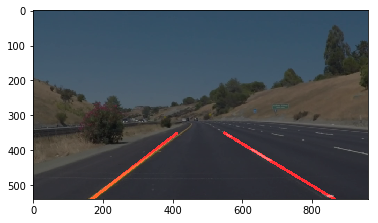

In [64]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[ 0.2         0.22222222  0.4         0.54545455  0.56896552  0.57142857
  0.6         0.60869565  0.61904762  0.625       0.63414634  0.63636364
  0.66666667  0.75        0.8         0.81818182  0.83333333]
0.619047619048
[-6.         -1.         -0.85714286 -0.8        -0.78571429 -0.77777778
 -0.75       -0.73684211 -0.71428571 -0.69230769 -0.68181818 -0.68
 -0.66666667 -0.66       -0.65       -0.625      -0.61538462 -0.6
 -0.58823529 -0.58333333 -0.57142857 -0.5        -0.47058824 -0.42857143
 -0.4        -0.33333333 -0.28571429 -0.27272727 -0.24242424 -0.2
 -0.16666667 -0.11111111]
-0.620192307692
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



  0%|          | 0/251 [00:00<?, ?it/s]

[ 0.2         0.22222222  0.4         0.54545455  0.56896552  0.57142857
  0.6         0.60869565  0.61904762  0.625       0.63414634  0.63636364
  0.66666667  0.75        0.8         0.81818182  0.83333333]
0.619047619048
[-6.         -1.         -0.85714286 -0.8        -0.78571429 -0.77777778
 -0.75       -0.73684211 -0.71428571 -0.69230769 -0.68181818 -0.68
 -0.66666667 -0.66       -0.65       -0.625      -0.61538462 -0.6
 -0.58823529 -0.58333333 -0.57142857 -0.5        -0.47058824 -0.42857143
 -0.4        -0.33333333 -0.28571429 -0.27272727 -0.24242424 -0.2
 -0.16666667 -0.11111111]
-0.620192307692



  0%|          | 1/251 [00:00<00:36,  6.94it/s]

[ 0.16666667  0.2         0.4         0.42857143  0.5         0.55555556
  0.57142857  0.5862069   0.6         0.63157895  0.63636364  0.66666667
  0.7         0.71428571  0.8       ]
0.586206896552
[-2.66666667 -1.         -0.88888889 -0.85714286 -0.80952381 -0.8
 -0.78947368 -0.77777778 -0.76923077 -0.75       -0.71875    -0.71794872
 -0.71428571 -0.7037037  -0.7        -0.66666667 -0.63636364 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5
 -0.42857143 -0.4        -0.26666667 -0.20833333 -0.2        -0.15384615
 -0.14285714]
-0.666666666667



  1%|          | 2/251 [00:00<00:40,  6.20it/s]

[ 0.11111111  0.33333333  0.4         0.5         0.5625      0.57142857
  0.58333333  0.6         0.625       0.66666667  0.72727273  0.75        0.8       ]
0.583333333333
[-1.         -0.9        -0.8125     -0.77777778 -0.76923077 -0.75
 -0.70833333 -0.66666667 -0.65753425 -0.6557377  -0.64285714 -0.63636364
 -0.625      -0.61538462 -0.61111111 -0.6        -0.58333333 -0.57142857
 -0.5625     -0.55555556 -0.52777778 -0.5        -0.42857143 -0.33333333
 -0.28571429 -0.25581395 -0.22222222 -0.2       ]
-0.613247863248



  1%|          | 3/251 [00:00<00:41,  5.95it/s]

[ 0.125       0.5         0.625       0.65384615  0.66666667  0.72727273]
0.639423076923
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.77777778 -0.75       -0.71428571 -0.70588235 -0.66666667 -0.66101695
 -0.625      -0.61538462 -0.6        -0.57142857 -0.55555556 -0.51162791
 -0.5        -0.4        -0.375      -0.33333333 -0.28571429 -0.25581395
 -0.22222222 -0.1        -0.08333333]
-0.615384615385



  2%|▏         | 4/251 [00:00<00:40,  6.04it/s]

[ 0.22222222  0.5         0.57142857  0.66666667  0.85714286]
0.571428571429
[-1.         -0.875      -0.78947368 -0.78571429 -0.77777778 -0.76923077
 -0.71428571 -0.7037037  -0.7        -0.6875     -0.66666667 -0.65671642
 -0.625      -0.6        -0.58333333 -0.57142857 -0.5        -0.44444444
 -0.4        -0.23529412 -0.22222222 -0.2        -0.16666667 -0.15384615]
-0.640858208955



  2%|▏         | 5/251 [00:00<00:40,  6.01it/s]

[ 0.16666667  0.33333333  0.4         0.46153846  0.58333333  0.64285714
  0.7         1.        ]
0.522435897436
[-1.         -0.85714286 -0.8        -0.78571429 -0.77777778 -0.75
 -0.72307692 -0.71428571 -0.69230769 -0.6875     -0.66666667 -0.65384615
 -0.625      -0.61538462 -0.6        -0.57446809 -0.5        -0.42857143
 -0.4        -0.33333333 -0.25       -0.23076923 -0.2        -0.16666667]
-0.639423076923



  2%|▏         | 6/251 [00:01<00:40,  6.08it/s]

[ 0.16666667  0.375       0.5         0.6         0.62068966  0.63636364
  0.71428571]
0.6
[-1.         -0.83333333 -0.8        -0.77777778 -0.75       -0.72916667
 -0.72222222 -0.71428571 -0.66666667 -0.625      -0.6        -0.58333333
 -0.57142857 -0.5625     -0.54545455 -0.5        -0.4        -0.375
 -0.33333333 -0.28571429 -0.27272727 -0.22222222 -0.20689655 -0.2
 -0.14285714 -0.125     ]
-0.566964285714



  3%|▎         | 7/251 [00:01<00:39,  6.19it/s]

[ 0.14285714  0.4         0.42857143  0.5         0.5625      0.57692308
  0.6         0.64285714  0.66666667]
0.5625
[-0.875      -0.85714286 -0.81818182 -0.8        -0.75       -0.72826087
 -0.71428571 -0.7        -0.66666667 -0.65384615 -0.63636364 -0.625      -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.45833333 -0.42857143
 -0.4        -0.28571429 -0.27272727 -0.2        -0.14285714 -0.11111111]
-0.6



  3%|▎         | 8/251 [00:01<00:38,  6.24it/s]

[ 0.16666667  0.2         0.25        0.61111111  0.61538462  0.65714286
  0.72727273]
0.611111111111
[-1.         -0.9        -0.88888889 -0.83333333 -0.81818182 -0.8        -0.75
 -0.72222222 -0.70967742 -0.7        -0.67741935 -0.66666667 -0.64615385
 -0.63333333 -0.625      -0.6        -0.57142857 -0.55555556 -0.5        -0.4
 -0.375      -0.28571429 -0.23076923 -0.22727273 -0.22222222 -0.21052632
 -0.2        -0.18181818 -0.1       ]
-0.625



  4%|▎         | 9/251 [00:01<00:39,  6.10it/s]

[ 0.14285714  0.2         0.36363636  0.38461538  0.58333333  0.6         0.625
  0.64285714  0.64935065  0.66666667  0.71428571  1.25      ]
0.6125
[-1.         -0.90909091 -0.875      -0.85714286 -0.83333333 -0.8125     -0.8
 -0.78571429 -0.77777778 -0.74137931 -0.69230769 -0.68       -0.66666667
 -0.65753425 -0.65714286 -0.65384615 -0.625      -0.61538462 -0.6
 -0.58333333 -0.57894737 -0.57142857 -0.52631579 -0.5        -0.47368421
 -0.42857143 -0.4        -0.33333333 -0.28571429 -0.26136364 -0.15151515
 -0.125      -0.05555556]
-0.625



  4%|▍         | 10/251 [00:01<00:39,  6.15it/s]

[ 0.14285714  0.16666667  0.2         0.375       0.4         0.5
  0.55555556  0.58333333  0.625       0.64285714  0.66666667  0.6875
  0.71428571  0.75        0.83333333  0.85714286  0.875     ]
0.625
[-1.         -0.90909091 -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.82352941 -0.81818182 -0.8125     -0.8        -0.75       -0.73333333
 -0.72477064 -0.7        -0.6875     -0.65517241 -0.625      -0.6
 -0.58333333 -0.57142857 -0.5        -0.42857143 -0.4        -0.28571429
 -0.26797386 -0.22222222 -0.2        -0.16666667 -0.14285714 -0.11111111]
-0.671336206897



  4%|▍         | 11/251 [00:01<00:40,  5.96it/s]

[ 0.16666667  0.2         0.25        0.28571429  0.4         0.41666667
  0.45454545  0.5         0.52941176  0.54545455  0.55555556  0.57142857
  0.58974359  0.6         0.625       0.64285714  0.65384615  0.66666667
  0.8       ]
0.545454545455
[-1.         -0.88888889 -0.875      -0.85714286 -0.84615385 -0.80952381
 -0.8        -0.74418605 -0.74285714 -0.71428571 -0.7        -0.66666667
 -0.61111111 -0.58333333 -0.57894737 -0.57142857 -0.55555556 -0.5        -0.4
 -0.36363636 -0.33333333 -0.22222222 -0.16666667 -0.14285714 -0.125
 -0.11111111 -0.1       ]
-0.583333333333



  5%|▍         | 12/251 [00:02<00:40,  5.96it/s]

[ 0.4         0.42857143  0.44444444  0.45454545  0.5         0.54545455
  0.57692308  0.58333333  0.59090909  0.6         0.625       0.66666667
  0.75        0.83333333  1.        ]
0.583333333333
[-1.         -0.90909091 -0.83333333 -0.8        -0.77777778 -0.73267327
 -0.66666667 -0.65789474 -0.63636364 -0.625      -0.61538462 -0.61111111
 -0.6        -0.58333333 -0.51851852 -0.5        -0.4375     -0.42857143
 -0.4        -0.27272727 -0.25806452 -0.22727273 -0.21428571 -0.2
 -0.16666667 -0.125      -0.07142857]
-0.583333333333



  5%|▌         | 13/251 [00:02<00:39,  6.04it/s]

[ 0.08333333  0.1         0.16666667  0.2         0.28571429  0.33333333
  0.4         0.44444444  0.53846154  0.54545455  0.58333333  0.6
  0.66666667  0.7         0.72727273  0.75        0.8         0.85714286
  1.        ]
0.545454545455
[-6.         -1.         -0.88888889 -0.83333333 -0.80769231 -0.78571429
 -0.75       -0.73611111 -0.72727273 -0.7254902  -0.72340426 -0.71428571
 -0.70588235 -0.66666667 -0.63636364 -0.625      -0.61538462 -0.6
 -0.54545455 -0.5        -0.42857143 -0.4        -0.26086957 -0.2
 -0.16666667 -0.14285714 -0.125      -0.07692308]
-0.651515151515



  6%|▌         | 14/251 [00:02<00:38,  6.16it/s]

[ 0.16666667  0.2         0.25        0.4         0.42857143  0.44444444
  0.53846154  0.54166667  0.57142857  0.625       0.64285714  0.66666667
  0.83333333  1.        ]
0.540064102564
[-1.         -0.875      -0.85714286 -0.8        -0.78571429 -0.75
 -0.73913043 -0.73684211 -0.72307692 -0.71428571 -0.6875     -0.68421053
 -0.66666667 -0.65       -0.625      -0.6        -0.54545455 -0.53333333
 -0.5        -0.4        -0.26315789 -0.26086957 -0.21428571 -0.2
 -0.16666667 -0.08      ]


  6%|▋         | 16/251 [00:02<00:38,  6.06it/s]


-0.658333333333
[ 0.125       0.2         0.5625      0.57142857  0.62962963]
0.5625
[-1.         -0.90909091 -0.81818182 -0.8        -0.74137931 -0.6875
 -0.67857143 -0.66666667 -0.625      -0.6        -0.58333333 -0.57142857
 -0.5625     -0.54545455 -0.5        -0.41666667 -0.4        -0.33333333
 -0.29032258 -0.28571429 -0.2        -0.16666667 -0.14285714 -0.1
 -0.08333333]
-0.5625



  7%|▋         | 17/251 [00:02<00:47,  4.92it/s]

[ 0.14285714  0.2         0.42857143  0.55555556  0.57142857  0.6         0.625     ]
0.555555555556
[-6.         -1.         -0.88888889 -0.875      -0.85714286 -0.81818182
 -0.8        -0.78571429 -0.77777778 -0.74       -0.73033708 -0.72368421
 -0.71428571 -0.68421053 -0.66666667 -0.64814815 -0.625      -0.6
 -0.57142857 -0.5        -0.4        -0.24       -0.2        -0.16666667
 -0.14285714 -0.08333333]
-0.699248120301
[ 0.16666667  0.2         0.33333333  0.6         0.62962963  0.66666667
  0.70588235]
0.6
[-1.         -0.9        -0.875      -0.85714286 -0.83333333 -0.8
 -0.78571429 -0.76923077 -0.75       -0.73684211 -0.70833333 -0.7
 -0.68181818 -0.66666667 -0.65625    -0.625      -0.6        -0.55555556
 -0.53333333 -0.5        -0.30555556 -0.22222222 -0.2        -0.16666667
 -0.08333333]
-0.681818181818



  8%|▊         | 20/251 [00:03<00:39,  5.86it/s]

[ 0.16666667  0.18181818  0.2         0.42857143  0.5         0.58333333
  0.6         0.61111111  0.66666667  0.68421053  6.        ]
0.583333333333
[-1.         -0.90909091 -0.9        -0.88888889 -0.80769231 -0.8
 -0.77777778 -0.75       -0.73684211 -0.72588832 -0.72340426 -0.69230769
 -0.66666667 -0.625      -0.61111111 -0.6        -0.58333333 -0.57142857
 -0.5625     -0.54545455 -0.5        -0.44444444 -0.41666667 -0.4        -0.375
 -0.27272727 -0.25       -0.22222222 -0.21428571 -0.2        -0.16666667
 -0.14285714 -0.125     ]
-0.583333333333
[ 0.2         0.33333333  0.4         0.42857143  0.45454545  0.5
  0.61538462  0.625       0.66666667  0.71428571]
0.477272727273
[-1.         -0.9        -0.875      -0.85714286 -0.83333333 -0.8
 -0.76923077 -0.75       -0.6875     -0.66666667 -0.64285714 -0.63636364
 -0.625      -0.61111111 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.54545455 -0.53846154 -0.5        -0.46153846 -0.42857143 -0.4
 -0.33333333 -0.27118644 -0.2     


  9%|▉         | 22/251 [00:03<00:37,  6.17it/s]

[ 0.4         0.44444444  0.5         0.55        0.55555556  0.57352941
  0.6         0.63636364  0.7       ]
0.555555555556
[-2.5        -1.         -0.92307692 -0.88888889 -0.83333333 -0.8125     -0.8
 -0.74285714 -0.73913043 -0.72727273 -0.72222222 -0.72093023 -0.70588235
 -0.7        -0.68       -0.66666667 -0.63636364 -0.625      -0.61538462
 -0.6        -0.57142857 -0.52       -0.51612903 -0.5106383  -0.5        -0.375
 -0.26315789 -0.25       -0.21428571]
-0.68
[ 0.2         0.23076923  0.57142857  0.57575758  0.62962963  0.66666667
  0.7         0.71428571  0.75      ]
0.62962962963
[-1.5        -1.         -0.83333333 -0.80645161 -0.80555556 -0.8
 -0.77777778 -0.76923077 -0.74       -0.72727273 -0.71428571 -0.70833333
 -0.67857143 -0.66666667 -0.63636364 -0.625      -0.61538462 -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.42857143 -0.4        -0.375
 -0.33333333 -0.26666667 -0.2        -0.16666667 -0.15384615 -0.07692308]
-0.625



  9%|▉         | 23/251 [00:03<00:38,  5.93it/s]

[ 0.11111111  0.125       0.14285714  0.2         0.375       0.4
  0.41176471  0.42857143  0.5         0.57692308  0.6         0.625
  0.62962963  0.66666667  0.6875      0.71428571  0.73333333  0.77777778
  0.875       2.66666667]
0.588461538462
[-1.         -0.9        -0.875      -0.85714286 -0.8125     -0.8
 -0.77777778 -0.76923077 -0.73913043 -0.72380952 -0.72       -0.71428571
 -0.66666667 -0.65       -0.625      -0.57142857 -0.5625     -0.5
 -0.42857143 -0.41666667 -0.4        -0.38888889 -0.28571429 -0.27272727
 -0.25       -0.21428571 -0.2        -0.16666667 -0.14285714 -0.05882353]
-0.598214285714
[ 0.2         0.33333333  0.36363636  0.4         0.42857143  0.44444444
  0.5         0.53125     0.54545455  0.56410256  0.57142857  0.58064516
  0.6         0.61111111  0.66666667  0.6875      0.71428571  0.75        0.8
  0.83333333  1.        ]
0.571428571429
[-1.         -0.875      -0.81818182 -0.8        -0.78947368 -0.77777778
 -0.75       -0.74358974 -0.7173913  -0.714285


 10%|▉         | 25/251 [00:04<00:36,  6.13it/s]

[ 0.16666667  0.33333333  0.4         0.46153846  0.5         0.53846154
  0.58333333  0.6         0.61538462  0.625       0.66666667  0.71428571
  0.8       ]
0.583333333333
[-1.         -0.9        -0.875      -0.80952381 -0.8        -0.78947368
 -0.75       -0.72173913 -0.7        -0.66666667 -0.625      -0.6
 -0.50909091 -0.5        -0.42857143 -0.4        -0.375      -0.25       -0.2125
 -0.2        -0.16666667]
-0.625
[ 0.11111111  0.2         0.375       0.44444444  0.5         0.54545455
  0.57142857  0.6         0.66666667  0.71428571  0.88888889  8.        ]
0.558441558442
[-1.         -0.90909091 -0.9        -0.875      -0.83333333 -0.8        -0.75
 -0.73170732 -0.72826087 -0.72727273 -0.7254902  -0.72222222 -0.71428571
 -0.69230769 -0.66666667 -0.63636364 -0.61538462 -0.6        -0.58333333
 -0.5        -0.45833333 -0.44444444 -0.42857143 -0.4        -0.26829268
 -0.22222222 -0.2        -0.19607843 -0.14285714 -0.11111111]
-0.651515151515



 11%|█         | 27/251 [00:04<00:35,  6.27it/s]

[  0.2          0.33333333   0.4          0.42857143   0.44444444
   0.57142857   0.64285714   0.66666667   0.71428571   0.75         0.8
   0.85714286  14.        ]
0.642857142857
[-1.         -0.9        -0.88888889 -0.875      -0.85714286 -0.84615385
 -0.83333333 -0.80769231 -0.77777778 -0.75       -0.74468085 -0.7254902
 -0.7        -0.69230769 -0.6875     -0.66666667 -0.625      -0.55555556
 -0.54545455 -0.54166667 -0.53846154 -0.5        -0.42857143 -0.4
 -0.33333333 -0.28571429 -0.25       -0.23076923 -0.2        -0.16666667
 -0.15384615 -0.14285714 -0.11111111]
-0.625
[ 0.4         0.42857143  0.5         0.625       0.71428571  0.85714286
  5.        ]
0.625
[-1.         -0.90909091 -0.88888889 -0.875      -0.83333333 -0.8
 -0.72941176 -0.7278481  -0.71428571 -0.7        -0.69230769 -0.6875
 -0.66666667 -0.625      -0.6        -0.51282051 -0.5        -0.47058824
 -0.45454545 -0.42857143 -0.4        -0.3        -0.25       -0.2195122
 -0.2        -0.16666667 -0.14285714 -0.125 


 12%|█▏        | 29/251 [00:04<00:36,  6.01it/s]

[ 0.08333333  0.2         0.4         0.55555556  0.60869565  0.625
  0.66666667]
0.555555555556
[-1.         -0.90909091 -0.88888889 -0.83333333 -0.80952381 -0.8        -0.75
 -0.72727273 -0.71428571 -0.66666667 -0.63636364 -0.625      -0.61538462
 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.53846154 -0.5        -0.4
 -0.28571429 -0.24       -0.2        -0.16666667 -0.14285714 -0.125      -0.1       ]
-0.6
[ 0.57142857  0.6         0.625       0.62962963  0.66666667  0.7
  0.77777778]
0.62962962963
[-1.         -0.875      -0.85714286 -0.83333333 -0.81481481 -0.8
 -0.73913043 -0.72413793 -0.71428571 -0.68421053 -0.67857143 -0.66666667
 -0.63636364 -0.6        -0.58333333 -0.55555556 -0.52173913 -0.50769231
 -0.5        -0.42857143 -0.4        -0.2173913  -0.2        -0.14285714
 -0.125      -0.12      ]
-0.618181818182



 12%|█▏        | 31/251 [00:05<00:38,  5.77it/s]

[ 0.2         0.28571429  0.29411765  0.4         0.5         0.6
  0.61904762  0.63829787  0.75      ]
0.5
[-1.         -0.875      -0.85714286 -0.81818182 -0.8125     -0.8        -0.75
 -0.71428571 -0.7        -0.6875     -0.68421053 -0.66666667 -0.63636364
 -0.625      -0.6        -0.57575758 -0.57142857 -0.55555556 -0.54545455
 -0.5        -0.44444444 -0.4        -0.33333333 -0.25       -0.21212121
 -0.2        -0.16666667 -0.15384615 -0.14285714 -0.125     ]
-0.587878787879
[ 0.14285714  0.2         0.42857143  0.5         0.55        0.6         0.625
  0.63157895  0.66666667  0.68421053  1.        ]
0.6
[-1.         -0.90909091 -0.875      -0.8        -0.78571429 -0.77777778
 -0.72727273 -0.72463768 -0.71428571 -0.6875     -0.66666667 -0.64814815
 -0.63636364 -0.625      -0.61538462 -0.6        -0.5        -0.4
 -0.33333333 -0.2        -0.16666667 -0.14285714]
-0.657407407407



 14%|█▎        | 34/251 [00:05<00:34,  6.20it/s]

[ 0.2         0.42857143  0.44444444  0.5         0.57142857  0.59259259
  0.6         0.625       0.66666667  0.68421053  0.75        1.        ]
0.596296296296
[-1.         -0.90909091 -0.88888889 -0.875      -0.85714286 -0.81481481
 -0.8        -0.79166667 -0.75       -0.72       -0.71875    -0.71428571
 -0.66666667 -0.65853659 -0.625      -0.61111111 -0.6        -0.57142857
 -0.5625     -0.55555556 -0.5        -0.44444444 -0.4        -0.27272727
 -0.25       -0.23529412 -0.2        -0.11111111 -0.09090909]
-0.625
[ 0.16666667  0.5         0.52173913  0.59375     0.6         0.61538462
  0.71428571  0.83333333  0.85714286  1.        ]
0.607692307692
[-1.         -0.9        -0.85714286 -0.80645161 -0.8        -0.77777778
 -0.76923077 -0.72093023 -0.71929825 -0.71428571 -0.7        -0.69230769
 -0.6875     -0.67857143 -0.66666667 -0.63636364 -0.625      -0.6
 -0.57692308 -0.57142857 -0.56521739 -0.50943396 -0.5        -0.4
 -0.28571429 -0.21428571 -0.16666667 -0.14285714 -0.07142857]


 14%|█▍        | 35/251 [00:05<00:36,  5.95it/s]

[ 0.11111111  0.33333333  0.42857143  0.52777778  0.55555556  0.57142857
  0.6         0.625       0.62857143  0.65714286  0.66666667  0.6875
  0.71428571  0.77777778  0.8         1.        ]
0.626785714286
[-6.         -3.         -1.         -0.85714286 -0.80769231 -0.8
 -0.78571429 -0.76923077 -0.75       -0.72093023 -0.7        -0.69230769
 -0.66666667 -0.65217391 -0.625      -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.42857143 -0.40909091 -0.4        -0.375
 -0.33333333 -0.25      ]
-0.659420289855
[ 0.16666667  0.2         0.30769231  0.33333333  0.375       0.4
  0.42857143  0.44444444  0.5         0.53571429  0.57142857  0.58333333
  0.6         0.625       0.63636364  0.65        0.66666667  0.69230769
  0.7         0.75        0.8       ]
0.571428571429
[-8.         -1.         -0.83333333 -0.8        -0.75       -0.71794872
 -0.71428571 -0.68181818 -0.66666667 -0.66       -0.64285714 -0.63636364
 -0.625      -0.61111111 -0.6        -0.57142857 -0.55555556


 15%|█▍        | 37/251 [00:06<00:35,  5.98it/s]

[ 0.16666667  0.33333333  0.4         0.42857143  0.5         0.53846154
  0.55555556  0.57894737  0.6         0.625       0.64285714  0.66666667
  0.71428571  0.72727273  0.75        0.77777778  0.8         1.          5.
  7.        ]
0.633928571429
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.78571429
 -0.75       -0.73913043 -0.72727273 -0.72297297 -0.71428571 -0.67857143
 -0.65517241 -0.63636364 -0.625      -0.6        -0.57142857 -0.5625
 -0.52631579 -0.5        -0.44444444 -0.42857143 -0.4        -0.33333333
 -0.28571429 -0.27272727 -0.21276596 -0.2        -0.11111111]
-0.625
[ 0.14285714  0.2         0.4         0.57971014  0.58333333  0.6
  0.64150943  0.71428571  0.75        0.8         0.85714286]
0.6
[-1.         -0.88888889 -0.875      -0.85714286 -0.81818182 -0.8125     -0.8
 -0.75       -0.73913043 -0.71794872 -0.71428571 -0.7037037  -0.7
 -0.69230769 -0.64285714 -0.625      -0.61538462 -0.60869565 -0.6        -0.5625
 -0.54545455 -0.5        -0.454545


 16%|█▌        | 39/251 [00:06<00:35,  6.05it/s]

[ 0.16666667  0.2         0.3         0.42857143  0.53846154  0.55555556
  0.6         0.62962963  0.66666667]
0.538461538462
[-9.         -1.         -0.875      -0.85714286 -0.83333333 -0.8
 -0.78571429 -0.77777778 -0.75       -0.73333333 -0.72727273 -0.7
 -0.66666667 -0.64761905 -0.64285714 -0.625      -0.61538462 -0.61111111
 -0.6        -0.58333333 -0.57142857 -0.54545455 -0.5        -0.44444444
 -0.42857143 -0.4        -0.33333333 -0.29411765 -0.25       -0.21052632
 -0.20689655 -0.2        -0.16666667]
-0.615384615385
[ 0.1         0.11111111  0.2         0.4         0.44444444  0.8         1.
  5.          7.        ]
0.444444444444
[-1.33333333 -1.         -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.78571429 -0.75       -0.73076923 -0.7244898  -0.72093023 -0.66666667
 -0.64912281 -0.64285714 -0.625      -0.6        -0.58823529 -0.58333333
 -0.57142857 -0.5625     -0.55555556 -0.5106383  -0.5        -0.42857143
 -0.4        -0.375      -0.3        -0.27272727 -0.25       -0.2



 16%|█▋        | 41/251 [00:06<00:34,  6.03it/s]

[ 0.2         0.38461538  0.5         0.57142857  0.6         0.69230769]
0.535714285714
[-1.         -0.81818182 -0.8        -0.76923077 -0.75       -0.72
 -0.66666667 -0.66071429 -0.63636364 -0.625      -0.6        -0.57142857
 -0.55555556 -0.5        -0.45945946 -0.44444444 -0.42857143 -0.42105263
 -0.4        -0.28571429 -0.21428571 -0.20833333 -0.2        -0.18181818
 -0.16666667 -0.14285714 -0.11111111]
-0.5
[ 0.14285714  0.2         0.33333333  0.625       0.6875      0.8         0.875
  2.        ]
0.65625
[-1.         -0.875      -0.8        -0.75       -0.71428571 -0.70833333
 -0.70588235 -0.69230769 -0.68181818 -0.66666667 -0.625      -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.55       -0.52       -0.5
 -0.44444444 -0.42105263 -0.4        -0.33333333 -0.29411765 -0.28571429
 -0.26315789 -0.25       -0.11111111 -0.08333333]
-0.563492063492



 17%|█▋        | 42/251 [00:07<00:34,  6.14it/s]

[ 0.125       0.4         0.57142857  0.58823529  0.625       0.66666667
  0.8         1.        ]
0.606617647059
[-1.         -0.875      -0.85714286 -0.8        -0.78571429 -0.75
 -0.72483221 -0.69230769 -0.65853659 -0.64705882 -0.6        -0.58333333
 -0.57142857 -0.5625     -0.55555556 -0.54545455 -0.53846154 -0.52941176
 -0.5        -0.42857143 -0.4        -0.375      -0.33333333 -0.20833333
 -0.2        -0.16666667 -0.14285714 -0.125     ]
-0.559027777778



 18%|█▊        | 44/251 [00:07<00:50,  4.14it/s]

[  0.22222222   0.4          0.5          0.6          0.625        0.69230769
   0.7          0.75         0.77777778   0.8         20.        ]
0.692307692308
[-0.88888889 -0.875      -0.83333333 -0.8125     -0.8        -0.77777778
 -0.75       -0.73333333 -0.70588235 -0.7        -0.68       -0.66666667
 -0.65517241 -0.64583333 -0.625      -0.61538462 -0.6        -0.58333333
 -0.55555556 -0.53333333 -0.5        -0.42857143 -0.42307692 -0.4
 -0.33333333 -0.3        -0.26315789 -0.15384615 -0.125      -0.07692308
 -0.07142857]
-0.615384615385



 18%|█▊        | 45/251 [00:07<00:51,  4.00it/s]

[ 0.5         0.56989247  0.61904762  0.63636364  0.64285714  0.6875      0.75      ]
0.636363636364
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.81818182
 -0.8        -0.77777778 -0.75       -0.71875    -0.71428571 -0.70833333
 -0.68421053 -0.66666667 -0.65116279 -0.64788732 -0.6        -0.58333333
 -0.5        -0.42857143 -0.42105263 -0.4        -0.30434783 -0.28571429
 -0.26530612 -0.2        -0.18181818 -0.11111111 -0.05882353]
-0.651162790698



 18%|█▊        | 46/251 [00:08<00:50,  4.04it/s]

[ 0.2         0.33333333  0.4         0.5         0.57009346  0.6
  0.63157895  0.66666667  0.7         0.75        0.77777778  0.83333333]
0.615789473684
[-1.         -0.85714286 -0.83333333 -0.8        -0.72222222 -0.71428571
 -0.7        -0.66666667 -0.65555556 -0.625      -0.6        -0.58333333
 -0.57142857 -0.54545455 -0.53846154 -0.5        -0.47058824 -0.45454545
 -0.42857143 -0.4        -0.375      -0.33333333 -0.27272727 -0.26086957
 -0.25       -0.2        -0.16666667 -0.14285714 -0.13333333]
-0.538461538462



 19%|█▊        | 47/251 [00:08<00:51,  3.98it/s]

[ 0.4         0.42857143  0.5         0.57142857  0.58730159  0.6
  0.61904762  0.62068966  0.625       0.63157895  0.63636364  0.64285714
  0.66666667  0.8         0.83333333  1.        ]
0.622844827586
[-1.         -0.88888889 -0.875      -0.83333333 -0.81818182 -0.8125     -0.8
 -0.76923077 -0.75       -0.71428571 -0.7        -0.6875     -0.68181818
 -0.66666667 -0.65671642 -0.625      -0.6        -0.58333333 -0.55555556
 -0.55172414 -0.54545455 -0.5        -0.45945946 -0.42857143 -0.4
 -0.38461538 -0.28571429 -0.27272727 -0.25       -0.22222222 -0.21428571
 -0.2        -0.11764706 -0.05263158]
-0.591666666667



 19%|█▉        | 48/251 [00:08<00:50,  3.99it/s]

[ 0.33333333  0.42857143  0.5         0.57142857  0.6         0.61904762
  0.625       0.62962963  0.63414634  0.66666667  0.7         0.71428571
  0.75        0.8         0.83333333  1.        ]
0.631887985547
[-1.         -0.81818182 -0.8        -0.78571429 -0.75       -0.72427984
 -0.71428571 -0.70833333 -0.66153846 -0.64285714 -0.625      -0.6
 -0.58333333 -0.57142857 -0.53846154 -0.50943396 -0.5        -0.4
 -0.33333333 -0.23809524 -0.21428571 -0.16666667 -0.125     ]
-0.6



 20%|█▉        | 49/251 [00:08<00:49,  4.08it/s]

[ 0.16666667  0.4         0.5         0.54166667  0.57142857  0.58181818
  0.58928571  0.6         0.61538462  0.66666667  0.6875      0.69230769
  0.7         0.71428571  0.72727273  0.8         1.        ]
0.615384615385
[-1.         -0.8125     -0.8        -0.78947368 -0.75       -0.74418605
 -0.70588235 -0.68181818 -0.66666667 -0.66071429 -0.65789474 -0.625
 -0.61538462 -0.6        -0.58333333 -0.575      -0.57142857 -0.55555556
 -0.54545455 -0.52631579 -0.5        -0.4        -0.33333333 -0.27272727
 -0.23529412 -0.16666667 -0.125      -0.07142857]
-0.591666666667



 20%|█▉        | 50/251 [00:09<00:48,  4.17it/s]

[ 0.2         0.33333333  0.42857143  0.44444444  0.57142857  0.6
  0.62962963  0.63636364  0.66666667  0.7         0.75        0.77777778]
0.614814814815
[-5.         -1.66666667 -1.         -0.875      -0.85714286 -0.81818182
 -0.8        -0.78571429 -0.72727273 -0.69230769 -0.66666667 -0.65753425
 -0.625      -0.61538462 -0.6        -0.57142857 -0.5        -0.44444444
 -0.42857143 -0.4        -0.33333333 -0.21428571 -0.2        -0.18181818
 -0.14285714]
-0.625



 20%|██        | 51/251 [00:09<00:47,  4.21it/s]

[ 0.33333333  0.53333333  0.61111111  0.66666667]
0.572222222222
[-1.         -0.90909091 -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.80952381 -0.8        -0.75       -0.72340426 -0.71875    -0.71428571
 -0.66666667 -0.6        -0.58333333 -0.57377049 -0.57142857 -0.5
 -0.4516129  -0.4        -0.33333333 -0.25       -0.22222222 -0.21052632
 -0.15       -0.14285714 -0.1       ]
-0.6



 21%|██        | 52/251 [00:09<00:46,  4.28it/s]

[ 0.2         0.4         0.5         0.5625      0.6         0.63157895
  0.66666667  1.25      ]
0.58125
[-1.         -0.88888889 -0.85714286 -0.81818182 -0.8125     -0.80952381
 -0.8        -0.78571429 -0.73913043 -0.72794118 -0.72222222 -0.71428571
 -0.7        -0.66666667 -0.61111111 -0.6        -0.58333333 -0.57142857
 -0.55555556 -0.5        -0.47368421 -0.42857143 -0.4        -0.33333333
 -0.28571429 -0.21428571 -0.2        -0.16666667 -0.14285714 -0.125     ]
-0.605555555556



 21%|██        | 53/251 [00:09<00:46,  4.25it/s]

[ 0.05555556  0.125       0.2         0.4         0.6         0.63636364
  0.66666667  0.7         0.72727273  0.76923077  0.8         1.        ]
0.651515151515
[-10.          -1.          -0.9         -0.875       -0.85714286  -0.8
  -0.78571429  -0.72680412  -0.72340426  -0.71794872  -0.71428571
  -0.70833333  -0.7         -0.69230769  -0.66666667  -0.625       -0.60869565
  -0.6         -0.57142857  -0.42857143  -0.4         -0.38888889
  -0.33333333  -0.28571429  -0.25        -0.22222222  -0.2         -0.16666667
  -0.14285714  -0.125       -0.05      ]
-0.625



 22%|██▏       | 54/251 [00:10<00:45,  4.29it/s]

[ 0.4         0.42857143  0.5         0.57142857  0.6         0.64
  0.66666667  0.75        0.85714286  0.875       1.        ]
0.64
[-1.         -0.88888889 -0.875      -0.85714286 -0.8        -0.78947368
 -0.78571429 -0.728      -0.72222222 -0.72093023 -0.72       -0.71428571
 -0.7        -0.66666667 -0.65384615 -0.63636364 -0.625      -0.6        -0.5
 -0.47619048 -0.44444444 -0.42857143 -0.41176471 -0.4        -0.33333333
 -0.28571429 -0.27272727 -0.25       -0.22222222 -0.2        -0.16666667
 -0.11111111 -0.05555556]
-0.625



 22%|██▏       | 55/251 [00:10<00:45,  4.27it/s]

[ 0.4         0.625       0.66666667  0.71428571  0.72727273  0.8
  0.85714286]
0.714285714286
[-1.         -0.875      -0.85714286 -0.81818182 -0.8        -0.75
 -0.73404255 -0.72727273 -0.72093023 -0.71428571 -0.66666667 -0.64634146
 -0.61538462 -0.6        -0.58333333 -0.54545455 -0.5        -0.45454545
 -0.4        -0.375      -0.36363636 -0.33333333 -0.29411765 -0.23076923
 -0.2        -0.16666667 -0.11111111]
-0.6



 22%|██▏       | 56/251 [00:10<00:45,  4.28it/s]

[ 0.44444444  0.46666667  0.5         0.54545455  0.57142857  0.71428571
  0.73333333  0.8         1.        ]
0.571428571429
[-1.         -0.80769231 -0.8        -0.78571429 -0.734375   -0.72727273
 -0.72340426 -0.71428571 -0.7        -0.66666667 -0.625      -0.6
 -0.58333333 -0.57627119 -0.57377049 -0.57142857 -0.5        -0.42857143
 -0.4        -0.28571429 -0.26666667 -0.2        -0.16666667 -0.14285714
 -0.11111111 -0.09090909]
-0.579802259887



 23%|██▎       | 57/251 [00:10<00:45,  4.29it/s]

[ 0.14285714  0.4         0.42857143  0.5         0.57142857  0.6         0.64
  0.66666667  0.71428571  0.75        0.77777778  0.8       ]
0.62
[-1.         -0.9        -0.875      -0.85714286 -0.83333333 -0.8125     -0.8
 -0.77777778 -0.75       -0.73684211 -0.72093023 -0.71875    -0.7
 -0.66666667 -0.625      -0.6        -0.58333333 -0.5        -0.45454545
 -0.44444444 -0.42857143 -0.4        -0.33333333 -0.26666667 -0.25       -0.2
 -0.14285714 -0.09090909]
-0.645833333333



 23%|██▎       | 58/251 [00:11<00:44,  4.30it/s]

[ 0.16666667  0.2         0.25        0.28571429  0.33333333  0.375       0.4
  0.42857143  0.5         0.55555556  0.57142857  0.6         0.61538462
  0.66666667  0.71428571  0.75        0.8         0.83333333]
0.527777777778
[-1.         -0.90909091 -0.85714286 -0.8125     -0.8        -0.77777778
 -0.76923077 -0.72463768 -0.71428571 -0.69230769 -0.6875     -0.68421053
 -0.66666667 -0.64864865 -0.63636364 -0.625      -0.6        -0.57142857
 -0.55555556 -0.5        -0.47058824 -0.4        -0.33333333 -0.25
 -0.23529412 -0.22222222 -0.2        -0.16666667 -0.13333333]
-0.636363636364



 24%|██▎       | 59/251 [00:11<00:44,  4.30it/s]

[ 0.125       0.16666667  0.2         0.42857143  0.4375      0.45454545
  0.5         0.5625      0.57142857  0.6         0.61111111  0.61538462
  0.64285714  0.64705882  0.66666667  0.7         0.70588235  0.75        0.8
  0.83333333  0.88888889  1.          8.        ]
0.615384615385
[-0.83333333 -0.8        -0.77777778 -0.75       -0.74074074 -0.73529412
 -0.72340426 -0.7        -0.6875     -0.66666667 -0.64864865 -0.64634146
 -0.63636364 -0.625      -0.61111111 -0.6        -0.58333333 -0.57142857
 -0.52       -0.5        -0.44444444 -0.42857143 -0.4        -0.3
 -0.26470588 -0.22222222 -0.2        -0.15151515 -0.14285714 -0.11111111]
-0.605555555556



 24%|██▍       | 60/251 [00:11<00:44,  4.28it/s]

[ 0.16666667  0.33333333  0.4         0.42857143  0.5         0.57142857
  0.59090909  0.6         0.61904762  0.625       0.63333333  0.66666667
  0.7         0.71428571  0.75        0.8         1.        ]
0.619047619048
[-1.         -0.9        -0.83333333 -0.81818182 -0.8        -0.77777778
 -0.75       -0.73529412 -0.72222222 -0.71428571 -0.7        -0.66666667
 -0.63829787 -0.625      -0.61538462 -0.61111111 -0.6        -0.58333333
 -0.55555556 -0.54545455 -0.5        -0.42857143 -0.4        -0.26315789
 -0.16666667 -0.15384615 -0.14285714]
-0.625



 24%|██▍       | 61/251 [00:11<00:43,  4.34it/s]

[ 0.2         0.5         0.55        0.57142857  0.57894737  0.6         0.625
  0.63157895  0.64285714  0.66666667  0.71428571  0.75        0.77777778
  0.8       ]
0.628289473684
[-1.25       -1.         -0.85714286 -0.83333333 -0.8        -0.77777778
 -0.74074074 -0.71428571 -0.7        -0.69230769 -0.68421053 -0.68181818
 -0.67741935 -0.66666667 -0.63157895 -0.625      -0.61538462 -0.61111111
 -0.6        -0.58333333 -0.55555556 -0.55       -0.5        -0.33333333
 -0.25       -0.22222222 -0.21428571 -0.14285714]
-0.649122807018



 25%|██▍       | 62/251 [00:11<00:43,  4.35it/s]

[ 0.14285714  0.33333333  0.4         0.55555556  0.57142857  0.6
  0.61111111  0.61904762  0.625       0.63157895  0.66666667  0.70833333
  0.71428571  0.77777778  0.8         1.        ]
0.622023809524
[-1.         -0.91666667 -0.90909091 -0.9        -0.875      -0.85714286
 -0.83333333 -0.8125     -0.8        -0.72289157 -0.71428571 -0.7
 -0.66666667 -0.65079365 -0.64615385 -0.64285714 -0.625      -0.61538462
 -0.61111111 -0.6        -0.5        -0.42857143 -0.375      -0.25
 -0.21428571 -0.2        -0.14285714]
-0.650793650794



 25%|██▌       | 63/251 [00:12<00:42,  4.38it/s]

[ 0.25        0.33333333  0.57142857  0.625       0.6875      0.71428571]
0.598214285714
[-1.         -0.875      -0.83333333 -0.8        -0.78571429 -0.75
 -0.73170732 -0.725      -0.71428571 -0.7        -0.69230769 -0.68181818
 -0.66666667 -0.625      -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.53846154 -0.5        -0.42857143 -0.41666667 -0.4        -0.375
 -0.33333333 -0.25       -0.18181818 -0.14285714 -0.09090909 -0.08333333]
-0.591666666667



 25%|██▌       | 64/251 [00:12<00:43,  4.27it/s]

[ 0.16666667  0.2         0.36363636  0.4         0.5         0.64864865
  0.71428571]
0.4
[-1.         -0.875      -0.85714286 -0.8        -0.72       -0.71428571
 -0.70588235 -0.68       -0.66666667 -0.66071429 -0.65517241 -0.63636364
 -0.625      -0.61538462 -0.61111111 -0.6        -0.59259259 -0.58333333
 -0.57142857 -0.5625     -0.5        -0.42857143 -0.4        -0.33333333
 -0.28571429 -0.16666667 -0.15384615 -0.14285714]
-0.613247863248



 26%|██▌       | 65/251 [00:12<00:43,  4.24it/s]

[ 0.4         0.5         0.55555556  0.57142857  0.63888889  0.71428571]
0.563492063492
[-1.         -0.8        -0.73684211 -0.71428571 -0.7        -0.6875
 -0.66666667 -0.65789474 -0.65517241 -0.65217391 -0.63636364 -0.625
 -0.61538462 -0.6        -0.58333333 -0.57142857 -0.5        -0.46153846
 -0.4        -0.375      -0.33333333 -0.22727273 -0.2        -0.15384615
 -0.14285714 -0.1       ]
-0.607692307692



 26%|██▋       | 66/251 [00:12<00:43,  4.24it/s]

[ 0.125       0.375       0.57142857  0.58333333  0.64        0.66666667
  0.71428571  0.85714286]
0.611666666667
[-1.         -0.875      -0.8        -0.77777778 -0.75       -0.72222222
 -0.71428571 -0.69230769 -0.66666667 -0.65789474 -0.63636364 -0.625
 -0.61538462 -0.6        -0.58333333 -0.55555556 -0.54545455 -0.5        -0.4
 -0.33333333 -0.25       -0.2       ]
-0.630681818182



 27%|██▋       | 67/251 [00:13<00:43,  4.23it/s]

[ 0.16666667  0.2         0.375       0.4         0.5         0.625
  0.65217391  0.66666667  0.69230769  0.77777778  5.        ]
0.625
[-1.         -0.875      -0.83333333 -0.8        -0.77777778 -0.75       -0.725
 -0.71428571 -0.7037037  -0.69230769 -0.66666667 -0.65789474 -0.6
 -0.58333333 -0.57142857 -0.55555556 -0.5        -0.42857143 -0.4
 -0.33333333 -0.28571429 -0.25       -0.23529412 -0.14285714 -0.11111111]
-0.6



 27%|██▋       | 68/251 [00:13<00:43,  4.24it/s]

[ 0.1         0.42857143  0.45454545  0.5         0.5862069   0.6
  0.61538462  0.66666667  0.69230769  0.7         0.8         5.        ]
0.607692307692
[-1.         -0.875      -0.83333333 -0.81818182 -0.8125     -0.8
 -0.77777778 -0.75       -0.72222222 -0.7        -0.69230769 -0.68
 -0.66666667 -0.66153846 -0.65384615 -0.64285714 -0.625      -0.61538462
 -0.6        -0.57142857 -0.5625     -0.55555556 -0.54545455 -0.5        -0.4
 -0.28571429 -0.1875    ]
-0.661538461538



 27%|██▋       | 69/251 [00:13<00:42,  4.24it/s]

[ 0.33333333  0.54545455  0.57142857  0.57894737  0.6         0.61538462
  0.625       0.63157895  0.66666667  0.8         1.        ]
0.615384615385
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.77777778 -0.75       -0.73684211 -0.72727273 -0.71428571 -0.69230769
 -0.6875     -0.67857143 -0.66666667 -0.6        -0.58823529 -0.57142857
 -0.5        -0.4        -0.28571429 -0.22222222 -0.16666667 -0.125     ]
-0.689903846154



 28%|██▊       | 70/251 [00:13<00:42,  4.24it/s]

[ 0.16666667  0.375       0.4         0.41666667  0.5         0.53571429
  0.55        0.57142857  0.57777778  0.58333333  0.6         0.625
  0.71428571  0.75        0.8       ]
0.571428571429
[-1.         -0.875      -0.85714286 -0.8        -0.78571429 -0.72727273
 -0.72222222 -0.7        -0.66666667 -0.64761905 -0.63636364 -0.625
 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.5        -0.4
 -0.33333333 -0.20930233 -0.2        -0.16666667]
-0.630681818182



 28%|██▊       | 71/251 [00:14<00:42,  4.22it/s]

[ 0.33333333  0.44444444  0.45454545  0.46153846  0.46666667  0.5
  0.55555556  0.57142857  0.6         0.61111111  0.625       0.63414634
  0.63636364  0.66666667  0.71428571  0.75        0.8         0.83333333
  1.        ]
0.611111111111
[-1.         -0.88888889 -0.85714286 -0.83333333 -0.8        -0.77777778
 -0.75       -0.72727273 -0.72093023 -0.72       -0.70588235 -0.7
 -0.69230769 -0.68421053 -0.66666667 -0.64705882 -0.63636364 -0.625
 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.55555556 -0.5        -0.4
 -0.33333333 -0.27272727 -0.25       -0.15384615]
-0.666666666667



 29%|██▊       | 72/251 [00:14<00:42,  4.18it/s]

[ 0.125       0.2         0.33333333  0.4         0.46153846  0.47058824
  0.5         0.53846154  0.5625      0.57971014  0.5862069   0.6         0.625
  0.66666667  0.7         0.71428571  1.        ]
0.5625
[-1.         -0.90909091 -0.875      -0.83333333 -0.80952381 -0.80769231
 -0.8        -0.78571429 -0.75       -0.73333333 -0.72222222 -0.7173913
 -0.7        -0.66666667 -0.6        -0.57692308 -0.5        -0.45454545
 -0.4        -0.375      -0.28571429 -0.2        -0.16666667]
-0.717391304348



 29%|██▉       | 73/251 [00:14<00:42,  4.20it/s]

[ 0.2         0.4         0.42857143  0.5         0.52380952  0.53333333
  0.54545455  0.55555556  0.56        0.57142857  0.57692308  0.625
  0.66666667  0.71428571  0.75        0.77777778  6.        ]
0.56
[-1.         -0.875      -0.85714286 -0.83333333 -0.81818182 -0.8
 -0.78947368 -0.77777778 -0.73333333 -0.72727273 -0.72222222 -0.71428571
 -0.66666667 -0.63636364 -0.625      -0.61538462 -0.6        -0.57142857
 -0.55555556 -0.5        -0.44444444 -0.42857143 -0.4        -0.33333333
 -0.3        -0.18181818 -0.16666667 -0.1       ]
-0.630681818182



 29%|██▉       | 74/251 [00:14<00:42,  4.19it/s]

[ 0.11111111  0.2         0.28571429  0.375       0.4         0.58064516
  0.6         0.625       0.63157895  0.66666667  0.71428571  0.75      ]
0.590322580645
[-1.         -0.90909091 -0.88888889 -0.8        -0.73913043 -0.73333333
 -0.72727273 -0.71428571 -0.7        -0.69230769 -0.66666667 -0.625      -0.6
 -0.58536585 -0.55555556 -0.54545455 -0.5        -0.4        -0.28571429
 -0.25       -0.2        -0.14285714 -0.125      -0.11111111 -0.08333333]
-0.6



 30%|██▉       | 75/251 [00:15<00:42,  4.18it/s]

[ 0.16666667  0.2         0.28571429  0.33333333  0.42857143  0.5
  0.55555556  0.57142857  0.6         0.625     ]
0.464285714286
[-1.25       -1.         -0.88888889 -0.85714286 -0.8125     -0.8
 -0.72807018 -0.72727273 -0.71428571 -0.6875     -0.66666667 -0.64705882
 -0.63636364 -0.625      -0.6        -0.58333333 -0.55555556 -0.5
 -0.42857143 -0.33333333 -0.3        -0.22222222 -0.2        -0.16666667
 -0.15384615 -0.08333333 -0.05882353]
-0.625



 30%|███       | 76/251 [00:15<00:41,  4.20it/s]

[ 0.16666667  0.2         0.28571429  0.4         0.5         0.52631579
  0.575       0.6         0.625       6.        ]
0.513157894737
[-1.         -0.88888889 -0.875      -0.85714286 -0.83333333 -0.8
 -0.77777778 -0.75       -0.73015873 -0.72       -0.71428571 -0.7
 -0.68421053 -0.66666667 -0.625      -0.57575758 -0.57142857 -0.5        -0.4
 -0.33333333 -0.25       -0.2        -0.16666667]
-0.7



 31%|███       | 77/251 [00:15<00:41,  4.17it/s]

[ 0.33333333  0.4         0.5         0.55555556  0.63157895  0.66666667]
0.527777777778
[-9.         -5.         -1.         -0.91666667 -0.9        -0.875
 -0.85714286 -0.83333333 -0.8125     -0.80952381 -0.8        -0.77777778
 -0.75       -0.72727273 -0.71428571 -0.6875     -0.66666667 -0.64285714
 -0.63636364 -0.6        -0.59090909 -0.57142857 -0.5        -0.4
 -0.33333333 -0.28571429 -0.23809524 -0.2        -0.16666667 -0.13333333]
-0.700892857143



 31%|███       | 78/251 [00:15<00:42,  4.11it/s]

[ 0.14285714  0.16666667  0.42857143  0.5         0.57142857  0.6
  0.62068966  0.625       0.66666667  0.8       ]
0.585714285714
[-1.2        -1.         -0.88888889 -0.875      -0.85714286 -0.8125     -0.8
 -0.74       -0.73333333 -0.72972973 -0.72289157 -0.71428571 -0.69230769
 -0.6875     -0.66666667 -0.625      -0.6        -0.55555556 -0.5        -0.4
 -0.26666667 -0.21428571 -0.2        -0.16666667 -0.10526316]
-0.692307692308



 31%|███▏      | 79/251 [00:16<00:42,  4.08it/s]

[ 0.07692308  0.16666667  0.4         0.5         0.53846154  0.54545455
  0.6         0.60869565  0.61538462  0.61904762  0.625       0.76923077
  1.        ]
0.6
[-1.         -0.90909091 -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.8        -0.77777778 -0.75       -0.73684211 -0.725      -0.71428571
 -0.7        -0.69230769 -0.6875     -0.66666667 -0.625      -0.6        -0.5
 -0.4        -0.33333333 -0.26315789 -0.2        -0.16666667 -0.05555556]
-0.7



 32%|███▏      | 80/251 [00:16<00:41,  4.11it/s]

[  0.09090909   0.2          0.33333333   0.41666667   0.46666667   0.5
   0.56818182   0.57142857   0.6          0.61538462   0.66666667   0.7
   0.71428571   0.75         9.          11.        ]
0.585714285714
[-1.33333333 -1.         -0.875      -0.83333333 -0.80952381 -0.75
 -0.72444444 -0.71428571 -0.7        -0.69230769 -0.66666667 -0.64912281
 -0.6        -0.55555556 -0.5        -0.42857143 -0.4        -0.33333333
 -0.24       -0.2        -0.16666667 -0.06666667]
-0.657894736842



 32%|███▏      | 81/251 [00:16<00:40,  4.15it/s]

[ 0.11111111  0.2         0.28571429  0.33333333  0.375       0.38461538
  0.4         0.42857143  0.45454545  0.5         0.56521739  0.57142857
  0.6         0.61111111  0.66666667  0.8       ]
0.441558441558
[-1.25       -1.         -0.92307692 -0.90909091 -0.875      -0.85714286
 -0.83333333 -0.8125     -0.80769231 -0.8        -0.77777778 -0.72972973
 -0.7        -0.66666667 -0.625      -0.6        -0.46153846 -0.4
 -0.28571429 -0.21428571 -0.2        -0.16666667 -0.04545455]
-0.72972972973



 33%|███▎      | 82/251 [00:16<00:40,  4.13it/s]

[ 0.125       0.2         0.3         0.38461538  0.4         0.42857143
  0.44444444  0.45454545  0.46666667  0.5         0.51470588  0.51612903
  0.53333333  0.54545455  0.57142857  0.58974359  0.6       ]
0.466666666667
[-1.25       -1.         -0.91666667 -0.90909091 -0.9        -0.85714286
 -0.83333333 -0.81034483 -0.80952381 -0.8        -0.75       -0.72774869
 -0.72727273 -0.71428571 -0.66666667 -0.63636364 -0.6        -0.59090909
 -0.58333333 -0.57142857 -0.5        -0.4        -0.36       -0.33333333
 -0.22222222 -0.2        -0.18181818 -0.16666667 -0.14285714 -0.1
 -0.07407407]
-0.636363636364



 33%|███▎      | 83/251 [00:17<00:40,  4.12it/s]

[ 0.05882353  0.11111111  0.16666667  0.2         0.33333333  0.4
  0.42857143  0.4375      0.46666667  0.47058824  0.5         0.52631579
  0.53846154  0.56        0.57142857  0.57894737  0.6         0.61111111
  0.61904762  0.625       0.63157895  0.66666667  0.71428571  0.77777778
  0.8       ]
0.538461538462
[-3.         -1.5        -1.         -0.88888889 -0.875      -0.83333333
 -0.81132075 -0.80555556 -0.75       -0.72670807 -0.71428571 -0.7
 -0.69230769 -0.66666667 -0.63636364 -0.625      -0.6        -0.58333333
 -0.57142857 -0.5        -0.4        -0.36363636 -0.33333333 -0.3
 -0.28571429 -0.27777778 -0.27272727 -0.2        -0.04545455]
-0.636363636364



 33%|███▎      | 84/251 [00:17<00:39,  4.18it/s]

[ 0.2         0.33333333  0.375       0.42857143  0.44444444  0.45454545
  0.5         0.51315789  0.56666667  0.6         0.64285714  0.66666667
  0.71428571  0.75        0.8         5.        ]
0.539912280702
[-1.         -0.91666667 -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.82608696 -0.82352941 -0.8        -0.75       -0.73684211 -0.72826087
 -0.6875     -0.6        -0.57142857 -0.5        -0.44444444 -0.42857143
 -0.4        -0.33333333 -0.25       -0.2        -0.16666667]
-0.728260869565



 34%|███▍      | 85/251 [00:17<00:39,  4.17it/s]

[ 0.4         0.45454545  0.5         0.50980392  0.55555556  0.56626506
  0.57142857  0.6         0.625     ]
0.555555555556
[-1.25       -1.         -0.9        -0.88888889 -0.80555556 -0.8
 -0.73015873 -0.71428571 -0.6875     -0.68421053 -0.66666667 -0.625
 -0.61538462 -0.61111111 -0.6        -0.58333333 -0.57142857 -0.55555556
 -0.5        -0.33333333 -0.28571429 -0.25       -0.22222222 -0.2
 -0.16666667 -0.15384615 -0.14285714 -0.125      -0.11111111]
-0.6



 34%|███▍      | 86/251 [00:17<00:39,  4.17it/s]

[ 0.11111111  0.2         0.33333333  0.4         0.42857143  0.44444444
  5.        ]
0.4
[-5.         -1.66666667 -1.25       -1.         -0.90909091 -0.9
 -0.88888889 -0.875      -0.85714286 -0.83333333 -0.81481481 -0.8
 -0.77777778 -0.73913043 -0.73684211 -0.73333333 -0.71428571 -0.6875
 -0.66666667 -0.63636364 -0.57142857 -0.55555556 -0.5        -0.4
 -0.33333333 -0.28571429 -0.25       -0.22222222 -0.2        -0.16666667
 -0.125      -0.11111111]
-0.72380952381



 35%|███▍      | 87/251 [00:17<00:40,  4.04it/s]

[ 0.14285714  0.16666667  0.2         0.28571429  0.33333333  0.4
  0.42857143  0.5       ]
0.309523809524
[-1.66666667 -1.4        -1.25       -1.         -0.91666667 -0.90909091
 -0.875      -0.85714286 -0.80851064 -0.80733945 -0.78571429 -0.73195876
 -0.7        -0.66666667 -0.6        -0.57142857 -0.5        -0.44444444
 -0.4        -0.25581395 -0.2       ]
-0.785714285714



 35%|███▌      | 88/251 [00:18<00:40,  4.07it/s]

[ 0.2         0.375       0.5         0.51851852  0.55555556  0.57142857
  0.57894737  0.61111111]
0.537037037037
[-20.          -1.25        -1.          -0.91666667  -0.90909091
  -0.80952381  -0.76        -0.75        -0.7         -0.66666667
  -0.63636364  -0.625       -0.6         -0.57142857  -0.5         -0.4
  -0.3         -0.265625    -0.16666667]
-0.666666666667



 35%|███▌      | 89/251 [00:18<00:39,  4.08it/s]

[ 0.2         0.33333333  0.375       0.5         0.52380952  0.56
  0.56862745  0.6       ]
0.511904761905
[-1.66666667 -1.4        -1.25       -1.16666667 -1.14285714 -1.         -0.9
 -0.875      -0.85714286 -0.81818182 -0.8        -0.79310345 -0.77777778
 -0.76923077 -0.75       -0.71428571 -0.66666667 -0.6        -0.57142857
 -0.5        -0.44444444 -0.4        -0.33333333 -0.29166667 -0.25806452
 -0.25       -0.2        -0.14285714 -0.125     ]
-0.75



 36%|███▌      | 90/251 [00:18<00:39,  4.10it/s]

[ 0.16666667  0.5         0.53333333  0.54166667  0.54545455  0.57142857
  0.57894737  0.625       0.75        0.83333333]
0.558441558442
[-1.5        -1.25       -1.2        -1.         -0.93333333 -0.88888889
 -0.875      -0.85714286 -0.83333333 -0.82142857 -0.8        -0.76923077
 -0.76190476 -0.75       -0.71428571 -0.7        -0.69230769 -0.66666667
 -0.65384615 -0.6        -0.5625     -0.55555556 -0.5        -0.4        -0.375
 -0.36363636 -0.33333333 -0.28571429 -0.26582278 -0.23076923 -0.2       ]
-0.7



 36%|███▋      | 91/251 [00:18<00:38,  4.14it/s]

[ 0.1         0.14285714  0.16666667  0.2         0.33333333  0.5
  0.51612903  0.53846154  0.61904762]
0.333333333333
[-1.66666667 -1.6        -1.25       -1.2        -1.14285714 -1.
 -0.92307692 -0.91666667 -0.9        -0.88888889 -0.88235294 -0.85714286
 -0.84615385 -0.80952381 -0.77777778 -0.73684211 -0.70588235 -0.66666667
 -0.6        -0.5        -0.375      -0.33333333 -0.3        -0.28571429
 -0.27272727 -0.25       -0.16666667 -0.125      -0.1       ]
-0.777777777778



 37%|███▋      | 92/251 [00:19<00:38,  4.15it/s]

[ 0.05555556  0.14285714  0.2         0.28571429  0.33333333  0.4
  0.42857143  0.45454545  0.47368421  0.5         0.53333333  0.5625
  0.63157895  0.66666667]
0.441558441558
[-1.25       -1.16666667 -1.         -0.93333333 -0.90909091 -0.88888889
 -0.875      -0.85714286 -0.83333333 -0.81578947 -0.8        -0.76470588
 -0.72727273 -0.66666667 -0.61538462 -0.6        -0.57142857 -0.5        -0.4
 -0.375      -0.35294118 -0.33333333 -0.29411765 -0.28571429 -0.27777778
 -0.2        -0.11111111]
-0.666666666667



 37%|███▋      | 93/251 [00:19<00:37,  4.18it/s]

[ 0.2         0.33333333  0.4         0.42857143  0.44444444  0.46666667
  0.5         0.53333333  0.53571429  0.57142857  0.66666667  0.83333333
  1.        ]
0.5
[-2.5        -1.66666667 -1.4        -1.25       -1.2        -1.16666667
 -1.         -0.91304348 -0.88888889 -0.875      -0.85714286 -0.83333333
 -0.8        -0.75       -0.72727273 -0.71428571 -0.69230769 -0.66666667
 -0.6        -0.5        -0.41666667 -0.4        -0.375      -0.36842105
 -0.33333333 -0.3        -0.29411765 -0.28571429 -0.26666667 -0.25       -0.2
 -0.15789474 -0.11111111 -0.05882353]
-0.679487179487



 37%|███▋      | 94/251 [00:19<00:37,  4.21it/s]

[  0.11111111   0.14285714   0.2          0.33333333   0.375        0.4
   0.42857143   0.45454545   0.5          0.51162791   0.55555556
   0.55813953   0.5625       0.57142857   0.61111111   0.625        0.69230769
   0.71428571   0.8         18.        ]
0.533591731266
[-2.5        -1.25       -1.2        -1.16666667 -1.         -0.84615385
 -0.82352941 -0.80555556 -0.76923077 -0.75       -0.72727273 -0.71428571
 -0.69230769 -0.6875     -0.66666667 -0.61111111 -0.6        -0.57142857
 -0.5        -0.44444444 -0.42857143 -0.4        -0.38636364 -0.33333333
 -0.28571429 -0.2        -0.125      -0.11111111 -0.05555556]
-0.666666666667



 38%|███▊      | 95/251 [00:19<00:37,  4.12it/s]

[ 0.11111111  0.125       0.14285714  0.18181818  0.2         0.28571429
  0.33333333  0.4         0.42857143  0.44444444  0.45454545  0.5
  0.51851852  0.56862745  0.57142857  0.6         0.66666667]
0.428571428571
[-1.5        -1.4        -1.25       -1.22222222 -1.2        -1.
 -0.94444444 -0.9375     -0.92307692 -0.91666667 -0.90909091 -0.9
 -0.83333333 -0.8        -0.76923077 -0.75       -0.72727273 -0.66666667
 -0.625      -0.6        -0.4        -0.33333333 -0.30434783 -0.2
 -0.16666667 -0.11111111 -0.1       ]
-0.8



 38%|███▊      | 96/251 [00:20<00:37,  4.13it/s]

[ 0.2         0.375       0.4         0.42857143  0.5         0.51020408
  0.52173913  0.54545455  0.57142857  0.6         0.625       0.66666667
  0.7         0.8       ]
0.533596837945
[-1.25       -1.2        -1.16666667 -1.14285714 -1.         -0.88888889
 -0.83333333 -0.81395349 -0.8        -0.66666667 -0.625      -0.6
 -0.57142857 -0.55555556 -0.54545455 -0.5        -0.42857143 -0.4
 -0.33333333 -0.28571429 -0.27272727 -0.2        -0.16666667 -0.14285714
 -0.09090909]
-0.571428571429



 39%|███▊      | 97/251 [00:20<00:37,  4.14it/s]

[  0.2          0.4          0.44444444   0.45         0.5          0.52173913
   0.56097561   0.6          0.66666667   0.8          2.          18.        ]
0.541357370095
[-1.66666667 -1.5        -1.25       -1.2        -1.1        -1.
 -0.92307692 -0.91176471 -0.81818182 -0.8        -0.77777778 -0.75
 -0.70588235 -0.7        -0.66666667 -0.63636364 -0.625      -0.6
 -0.57142857 -0.55555556 -0.5        -0.4        -0.375      -0.36
 -0.33333333 -0.28       -0.2        -0.16666667 -0.11111111 -0.08108108
 -0.03333333]
-0.636363636364



 39%|███▉      | 98/251 [00:20<00:37,  4.13it/s]

[ 0.22222222  0.4375      0.5       ]
0.4375
[-1.5        -1.25       -1.2        -1.16666667 -1.125      -1.
 -0.92307692 -0.88888889 -0.85714286 -0.83870968 -0.8        -0.76190476
 -0.75       -0.71428571 -0.7        -0.66666667 -0.6        -0.5
 -0.45454545 -0.41666667 -0.4        -0.38461538 -0.36363636 -0.33333333
 -0.3        -0.28       -0.27272727 -0.22222222 -0.2        -0.16666667
 -0.14285714 -0.11111111]
-0.633333333333



 39%|███▉      | 99/251 [00:20<00:38,  3.98it/s]

[ 0.16666667  0.2         0.33333333  0.4         0.41666667  0.46153846
  0.5         0.6         0.66666667]
0.416666666667
[-1.66666667 -1.5        -1.4        -1.25       -1.2        -1.16666667
 -1.14285714 -1.         -0.91666667 -0.85714286 -0.8        -0.78947368
 -0.75       -0.72727273 -0.71428571 -0.6        -0.57142857 -0.55555556
 -0.5        -0.42857143 -0.41666667 -0.41176471 -0.4        -0.375      -0.36
 -0.33333333 -0.27272727 -0.25       -0.2        -0.14285714 -0.11111111
 -0.1       ]
-0.585714285714



 40%|███▉      | 100/251 [00:21<00:37,  4.04it/s]

[ 0.125       0.16666667  0.38461538  0.5         0.52173913  0.52380952]
0.442307692308
[-1.25       -1.2        -1.         -0.92307692 -0.80882353 -0.75
 -0.73333333 -0.66666667 -0.6        -0.55555556 -0.54545455 -0.5
 -0.44444444 -0.42857143 -0.41176471 -0.4        -0.36363636 -0.33333333
 -0.30769231 -0.27777778 -0.2        -0.125     ]
-0.522727272727



 40%|████      | 101/251 [00:21<00:37,  4.05it/s]

[ 0.2         0.21428571  0.25        0.4         0.42857143  0.5       ]
0.325
[-1.5        -1.25       -1.2        -1.         -0.91666667 -0.9047619
 -0.9        -0.83333333 -0.7        -0.66666667 -0.6        -0.57142857
 -0.5        -0.42857143 -0.41666667 -0.41176471 -0.4        -0.375
 -0.37037037 -0.33333333 -0.30769231 -0.28571429 -0.2        -0.16666667
 -0.15384615 -0.14285714]
-0.464285714286



 41%|████      | 102/251 [00:21<00:36,  4.11it/s]

[ 0.03703704  0.16666667  0.2         0.28571429  0.33333333  0.375       0.4
  0.42857143  0.55555556  0.57142857  0.75        0.8       ]
0.3875
[-1.         -0.90909091 -0.88888889 -0.83333333 -0.8125     -0.80952381
 -0.8        -0.71428571 -0.69230769 -0.625      -0.57142857 -0.4
 -0.33333333 -0.3        -0.28571429 -0.27272727 -0.25       -0.2
 -0.16666667 -0.15384615 -0.125     ]
-0.571428571429



 41%|████      | 103/251 [00:21<00:35,  4.12it/s]

[ 0.11111111  0.16666667  0.2         0.28571429  0.4         0.41176471
  0.42857143  0.44444444  0.45652174  0.47368421  0.5         0.66666667]
0.420168067227
[-1.4        -1.25       -1.         -0.92307692 -0.90909091 -0.8        -0.75
 -0.66666667 -0.5        -0.4        -0.35714286 -0.33333333 -0.28571429]
-0.75



 41%|████▏     | 104/251 [00:22<00:35,  4.10it/s]

[ 0.11111111  0.13636364  0.2         0.36363636  0.375       0.4
  0.42857143  0.44444444  0.46428571  0.5         0.5625    ]
0.4
[-3.         -1.16666667 -1.         -0.92307692 -0.91666667 -0.85714286
 -0.80645161 -0.66666667 -0.5        -0.42857143 -0.33333333 -0.31764706
 -0.2        -0.16666667 -0.14285714 -0.1       ]
-0.583333333333



 42%|████▏     | 105/251 [00:22<00:36,  4.00it/s]

[ 0.05555556  0.11764706  0.14285714  0.33333333  0.36363636  0.375       0.4
  0.42105263  0.42857143  0.44444444  0.5         0.52941176  0.57142857
  0.66666667  0.77777778  0.8         0.83333333]
0.428571428571
[-1.25       -1.         -0.80952381 -0.70833333 -0.6        -0.5        -0.4
 -0.33333333 -0.3        -0.28571429 -0.28       -0.22222222 -0.16666667
 -0.14285714 -0.1       ]
-0.333333333333



 42%|████▏     | 106/251 [00:22<00:36,  3.97it/s]

[ 0.08333333  0.14285714  0.16666667  0.2         0.375       0.4
  0.41176471  0.41666667  0.42857143  0.44444444  0.45454545  0.46153846
  0.5         0.66666667  0.71428571  0.8       ]
0.422619047619
[-1.         -0.85714286 -0.78571429 -0.71428571 -0.5        -0.42857143
 -0.4        -0.33333333 -0.32317073 -0.27272727 -0.25       -0.2        -0.125     ]
-0.4



 43%|████▎     | 107/251 [00:22<00:36,  3.95it/s]

[ 0.11111111  0.2         0.25        0.35714286  0.375       0.38461538
  0.4         0.42857143  0.44444444  0.45454545  0.47058824  0.47619048
  0.5         0.51190476  0.6         0.8         1.          1.2         1.25      ]
0.454545454545
[-1.16666667 -0.5        -0.42857143 -0.4        -0.375      -0.33333333
 -0.3258427  -0.21428571 -0.2        -0.16666667 -0.14285714]
-0.333333333333



 43%|████▎     | 108/251 [00:23<00:36,  3.96it/s]

[ 0.11111111  0.125       0.14285714  0.2         0.25        0.375
  0.41666667  0.42857143  0.4375      0.44444444  0.45454545  0.46666667
  0.48        0.5         0.51219512  0.52380952  0.53846154  0.6
  0.66666667  0.83333333  0.875       1.        ]
0.460606060606
[-1.75       -0.6        -0.4        -0.375      -0.33333333 -0.328125
 -0.28571429 -0.25       -0.2        -0.125     ]
-0.330729166667



 43%|████▎     | 109/251 [00:23<00:34,  4.10it/s]

[ 0.11111111  0.14285714  0.16666667  0.33333333  0.4         0.41666667
  0.42857143  0.44444444  0.45454545  0.47058824  0.55882353  0.5625      0.6
  0.61538462  0.71428571  0.77777778  1.        ]
0.454545454545
[-1.25       -0.5        -0.4        -0.375      -0.33333333 -0.28571429
 -0.27272727 -0.26666667 -0.2        -0.16666667 -0.08333333]
-0.285714285714



 44%|████▍     | 110/251 [00:23<00:34,  4.06it/s]

[ 0.11111111  0.125       0.2         0.33333333  0.4         0.46153846
  0.5         0.53333333  0.6         0.66666667  0.8         0.85714286]
0.480769230769
[-1.         -0.6        -0.44444444 -0.4        -0.33333333 -0.32911392
 -0.30952381 -0.28571429 -0.22222222 -0.2       ]
-0.331223628692



 44%|████▍     | 111/251 [00:23<00:37,  3.76it/s]

[ 0.0625      0.11111111  0.16666667  0.2         0.42857143  0.5       ]
0.183333333333
[-1.5        -0.5        -0.4        -0.33333333 -0.31818182 -0.22222222
 -0.2        -0.16666667]
-0.325757575758



 45%|████▍     | 112/251 [00:24<00:37,  3.71it/s]

In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))